In [ ]:
# Daniel Costelloe, Woojae Jo, Vraj N Patel
# GA Tech Pracitcum, Spring 2024
# Advanded Analytics
# Project for AI+ First Technology
# Breast Cancer detection project.
# CNN models for ultrasound images
# Ultrasound images are proprietary to AI+ First Technology and confidential

# CHATGPT 4 was used as a source for some of this coding, allowed as per instructions by TA early in project.


## Installs used for this project

In [ ]:
''' 
# Installs done for this project, downloaded from separate Jupyter Notebook

#!/usr/bin/env python
# coding: utf-8

import itertools
import sklearn

pip install itertools

pip install torch

pip install torchvision

pip install CUDA

#from torch import cuda

pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

pip install torch torchvision torchaudio 

pip install cuDNN

pip install -c anaconda tensorflow-gpu keras-gpu

pip install bayesian-optimization

pip uninstall torchvision

pip install torchvision==0.17.0+cu118 -f https://download.pytorch.org/whl/torch_stable.html --user

pip install pycocotools

pip install yolov5

get_ipython().system('pip uninstall yolov5 -y')

# show current working directory in Windows
get_ipython().system('cd')

# Clone the YOLOv5 repository
get_ipython().system('git clone https://github.com/ultralytics/yolov5.git')
get_ipython().run_line_magic('cd', 'yolov5')
# Install the required dependencies
get_ipython().system('pip install -r requirements.txt')

pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

pip install comet_ml

get_ipython().system('pip install tensorboard')

# "Install the Jupyter-TensorBoard extension (optional): If you want to integrate TensorBoard directly into your Jupyter environment, you can install the Jupyter-TensorBoard extension:"
get_ipython().system('pip install jupyter-tensorboard')

# this will install yolov8 - YOLO VERSION 8
pip install ultralytics

pip install ray[tune]

pip install ray[tune] bayesian-optimization

#New https://pypi.org/project/ultralytics/8.1.37 available 😃 Update with 'pip install -U ultralytics'
# was running Ultralytics YOLOv8.1.27 
get_ipython().system('pip install -U ultralytics')

get_ipython().system('pip install torchmetrics')

pip install --upgrade ray
''' 

## Imports and path assignments

In [9]:
import itertools
import sklearn
print("sklearn version: ", sklearn.__version__)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import os
import csv
import sys
import datetime
import pandas as pd

import json
import numpy as np
from pathlib import Path
import time
from operator import itemgetter

import shutil
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import default_collate

import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.resnet import ResNet50_Weights
from torchvision.models import ResNet50_Weights
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models import ResNet18_Weights

from torchvision.models import DenseNet121_Weights

from torchvision.models import MobileNet_V3_Small_Weights
from torchvision.models import MobileNet_V2_Weights
from torchvision.models.detection import ssdlite320_mobilenet_v3_large

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models import mobilenet_v2
from torchvision.ops import misc as misc_nn_ops

from torchvision.ops import box_convert
import torchvision.transforms.functional as F

from torch.optim import Adam
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import cv2

import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import statsmodels.api as sm
from statsmodels.formula.api import ols
from itertools import cycle

#from torchvision.models.detection import fasterrcnn_resnet50_fpn
#from torchvision.models import FasterRCNN_ResNet50_FPN_Weights
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.datasets import CocoDetection
#from torchvision.models.detection import fasterrcnn_resnet50_fpn
#from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights

from bayes_opt import BayesianOptimization
from ultralytics import YOLO

#show graphs within Jupyter Notebook
%matplotlib inline

print("python version: ", sys.version)
print("torch.version.cuda: " ,torch.version.cuda)
print("torch.__version: ", torch.__version__)
print("torchvision.__version: ", torchvision.__version__)
print("torchmetrics.__version__: ", torchmetrics.__version__)
print("torch.cuda.is_available: ", torch.cuda.is_available())
print("torch.cuda.current_device: ", torch.cuda.current_device())
print("torch.cuda.get_device_name: ", torch.cuda.get_device_name())
print("torch.cuda.get_device_capability: ", torch.cuda.get_device_capability())
#print('CUDA_HOME: {}'.format(os.environ["CUDA_HOME"]))
print('cuda version: {}'.format(torch.version.cuda))

print('os.environ["CUDA_PATH"] {}'.format(os.environ["CUDA_PATH"]))
#print('CUDA_HOME: {}'.format(os.environ["CUDA_HOME"]))
# checks for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

num_classes = 2  # Define the number of classes in your dataset

#set paths
def assign_existing_paths():
    # Paths for the first PC
    paths_pc1 = {
        'benign_path': "C:\\Users\\dan_c\\Documents\\GeorgiaTech\\PRACTICUM\\data\\Ultrasound-labeled\\benign",
        'malignant_path': "C:\\Users\\dan_c\\Documents\\GeorgiaTech\\PRACTICUM\\data\\Ultrasound-labeled\\malignant",
        'data_output_path': "C:\\Users\\dan_c\\Documents\\GeorgiaTech\\PRACTICUM\\data_output"

    }

    # Paths for the second PC
    paths_pc2 = {
        'benign_path': "C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-labeled\\benign",
        'malignant_path': "C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\\\Ultrasound-labeled\\malignant",
        'data_output_path': "C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data_output"
    }

    # Check which paths exist and assign them
    existing_paths = {}
    for key in paths_pc1:
        if os.path.exists(paths_pc1[key]):
            existing_paths[key] = paths_pc1[key]
        elif os.path.exists(paths_pc2[key]):
            existing_paths[key] = paths_pc2[key]
        else:
            print(f"Neither path for {key} exists on this computer.")

    return existing_paths

# Use the function to get the existing paths
existing_paths = assign_existing_paths()
benign_path = existing_paths.get('benign_path', None)
malignant_path = existing_paths.get('malignant_path', None)
data_output_path =  existing_paths.get('data_output_path', None)
# Check if the paths were assigned
if benign_path and malignant_path and data_output_path:
    print(f"benign_path: {benign_path}")
    print(f"malignant_path: {malignant_path}")
    print(f"data_output_path: {data_output_path}")
else:
    print("One or both paths do not exist on this computer.")


sklearn version:  1.3.0
python version:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
torch.version.cuda:  11.8
torch.__version:  2.2.0+cu118
torchvision.__version:  0.17.0+cu118
torchmetrics.__version__:  1.3.2
torch.cuda.is_available:  True
torch.cuda.current_device:  0
torch.cuda.get_device_name:  NVIDIA GeForce RTX 4060 Laptop GPU
torch.cuda.get_device_capability:  (8, 9)
cuda version: 11.8
os.environ["CUDA_PATH"] C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.3
device:  cuda
benign_path: C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-labeled\benign
malignant_path: C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\\Ultrasound-labeled\malignant
data_output_path: C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data_output


# The Class used for creating a custom dataset from the supplied data
## and transformations

In [357]:

# Custom dataset
class UltrasoundDataset(Dataset):
    def __init__(self, benign_path, malignant_path, transform=None):
        self.benign_path = benign_path
        self.malignant_path = malignant_path
        self.transform = transform
        self.data = []
        self.labels = []
        self.patient_numbers = []
        self.filenames = []

        # Iterate over each subdirectory in the benign and malignant folders
        for label, path in enumerate([benign_path, malignant_path]):
            for subdir in [f.path for f in os.scandir(path) if f.is_dir()]:
                patient_number = os.path.basename(subdir)  # Extract patient number from subdir path
                for file in os.listdir(subdir):
                    if file.endswith('.jpg'):
                        self.data.append(os.path.join(subdir, file))
                        self.labels.append(label)
                        self.patient_numbers.append(patient_number)
                        self.filenames.append(file)  # Store the filename

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load the image and JSON file
        img_path = self.data[idx]       
        json_path = img_path.replace('.jpg', '.json')
        label = self.labels[idx]
        patient_number = self.patient_numbers[idx]
        filename = self.filenames[idx]  # Get the filename
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        # Apply transformations if any
        if self.transform:
            transform_image = self.transform(image)

        return transform_image, label, patient_number, filename
        #return transform_image, label 
    # now add normalize using calculated meand and std to transformations
# Define transformations
# mean and std calculated seperately
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2281], std=[0.1738]),
])

# original transformations prior to mean and std calculations

#transform = transforms.Compose([
#    transforms.Grayscale(num_output_channels=1),
#    transforms.Resize((224, 224)),
#    transforms.ToTensor(),
#])


# Data split into train (80%), validation (10%), and testing (10%) datasets


In [358]:

full_dataset = UltrasoundDataset(benign_path, malignant_path, transform)
print("length full dataset: ", len(full_dataset))

# Set the random seed for reproducibility
seed = 12345678
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
# Set the random seed for reproducibility
seed = 12345678
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
generator1 = torch.Generator().manual_seed(seed)

# Create train and test datasets
#train_dataset, test_dataset, holdout_dataset = random_split(full_dataset, [.3, .2, .5], generator=generator1)
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [.8, .1, .1], generator=generator1)
# Create dataloaders
train_dataloader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader  = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader   = DataLoader(test_dataset, batch_size=32, shuffle=False)

length full dataset:  1148


##  Dataloaders 
### Note: Data loaders are also created within model runs to allow for changes in batch size, 
##  and for different format required by YOLO.

In [359]:
train_dataloader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader  = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader   = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Check shape of data, 1 is for grey scale, 32 is batch size with above data loaders

In [360]:
#show dataloaders shapes
dataiter = iter(train_dataloader)
images, labels, patient_numbers, filenames = next(dataiter)
# second value should be 1 for grey scale
print(images.shape)

dataiter = iter(valid_dataloader)
images, labels, patient_numbers, filenames = next(dataiter)
# second value should be 1 for grey scale
print(images.shape)

dataiter = iter(test_dataloader)
images, labels, patient_numbers, filenames = next(dataiter)
# second value should be 1 for grey scale
print(images.shape)

torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])


# Functions used in model evaluations
#   other evaluations functions added later

In [10]:

def evaluate_model(valid_dataloader, model, device, to_print=1):
    #print("model type: ", type(model))
    model.eval()  # Switch to evaluation mode
    all_predictions = []
    all_probs = []
    all_labels = []

    with torch.no_grad():  # We don't need gradients for evaluation
        for batch in valid_dataloader:
            images, labels = batch[:2]  # Only take the first two items (images and labels)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Get the probability of the positive class
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    if to_print == 1:
        print(f'Accuracy: {accuracy * 100:.2f}%')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')

    return accuracy, precision, recall, f1, all_labels, all_predictions

#    return all_labels, all_predictions, all_probs

def plot_confusion_matrix(y_true, y_pred, title=None, 
                          save_path=None, normalize=None, color_in=None):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    
    if normalize == None:
        fmt='d'
    else:        
        fmt='.2f'
        
    if color_in == None:
        sns.heatmap(cm, annot=True, fmt=fmt)
    else:        
        sns.heatmap(cm, annot=True, cmap=color_in, fmt=fmt)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if title:
        plt.title(title)
    else:
        plt.title('Confusion Matrix')
    # Save the plot to a file if save_path is provided
    if save_path:
        plt.savefig(save_path)
        #plt.close(fig)  # Close the figure to free up memory

    plt.show()

def plot_roc_curve(y_true, y_score, title=None, save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title:
        plt.title(title)
    else:
        plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    # Save the plot to a file if save_path is provided
    if save_path:
        plt.savefig(save_path)
        #plt.close(fig)   
    plt.show()

# Function used in developing and testing non-YOLO models

In [362]:
# appends results to csv file instead of writing all at end of program, allows for early stopping
# adding learning curve
import csv
import itertools
import torch
from torch import nn, optim
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import datetime


#def valid_model_parameters(model_name, param_grid, dataset, device):
def test_model_parameters(model_name, param_grid, train_dataset, valid_dataset, device, valid_ds_name="Testing",
                          to_print=1, make_plots=1, write_csv=1, return_type='valid_accuracy'):
    # If running more than one set of parameters set make_plots=0
    
    start = datetime.datetime.now()
    if to_print == 1:
        print("start time: ", start.strftime("%Y_%m_%d_%H%M"))
        print(model_name)
        
    number_of_models=0
    
    results = {}
    # output file name
    # Get the current date and time, format as string
    now = datetime.datetime.now()
    date_time = now.strftime("%Y_%m_%d_%H%M")

    # Append the date and time to the filename
    date_time_char = f"_{date_time}"
    filename = model_name + '_tuning' + date_time_char + '.csv'
    # file path was set above
    file_out = Path(data_output_path).joinpath(filename)
    
    if make_plots == 1:
        filename_plot = model_name + '_learning_curve_' + date_time_char + '.png'
        filename_loss_plot = model_name + '_learning_curve_' + date_time_char + '_loss.png'
        filename_accuracy_plot = model_name + '_learning_curve_' + date_time_char + '_accuracy.png'   
        filename_training_ROC_plot = model_name + '_training_ROC_curve_' + date_time_char + '.png'  
        filename_valid_ROC_plot = model_name + '_'+ valid_ds_name + '_ROC_curve_' + date_time_char + '.png'
        filename_training_confusion_matrix = model_name + '_training_confusion_matrix ' + date_time_char + '.png'  
        filename_valid_confusion_matrix = model_name + '_'+ valid_ds_name + '_confusion_matrix ' + date_time_char + '.png'  

        # file path was set above
        plot_out = Path(data_output_path).joinpath(filename_plot)
        loss_plot_out = Path(data_output_path).joinpath(filename_loss_plot)
        accuracy_plot_out = Path(data_output_path).joinpath(filename_accuracy_plot)
        training_ROC_plot_out = Path(data_output_path).joinpath(filename_training_ROC_plot)
        valid_ROC_plot_out = Path(data_output_path).joinpath(filename_valid_ROC_plot)   
        training_confusion_matrix_out = Path(data_output_path).joinpath(filename_training_confusion_matrix)
        valid_confusion_matrix_out = Path(data_output_path).joinpath(filename_valid_confusion_matrix)

    num_classes = 2  # Assuming binary classification (malignant vs benign)
       
    # Add lists to store metrics for learning curves
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    results_df = pd.DataFrame()
    
    # Iterate over all combinations of parameters
    for params in itertools.product(*param_grid.values()):
        
        # Set the random seed for reproducibility
        seed = 12345678
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            
        # Create a dictionary of the current parameters
        current_params = dict(zip(param_grid.keys(), params))
        batch_size = current_params['batch_size']  # Get the current batch size from the parameters
        
        # Create DataLoaders with the current batch size
        # shuffle on traning so model does not learn data order,
        # do not shuffle on testing to compare models.
        #train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
        #valid_dataloader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False)
        
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dataloader  = DataLoader(valid_dataset,  batch_size=batch_size, shuffle=False)

        number_of_models = number_of_models + 1
        
        if to_print == 1:
            print("Model number: ", number_of_models, " current_params: ", current_params  )

        # Load the model with the current parameters
#        model = base_model(pretrained=True)
        #https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte
#        if torch.cuda.is_available():
#            model = model.cuda()

        # Adjust the first convolutional layer to accept 1 channel (grayscale)

        if model_name == 'resnet50':
            weights = ResNet50_Weights.DEFAULT
            model = models.resnet50(weights=weights)
            model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
            model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        elif model_name.lower() == 'resnet18':     
            base_model = models.resnet18
            weights = ResNet18_Weights.DEFAULT
            model = models.resnet18(weights=weights)    
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)      
            model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        elif model_name.lower() == 'densenet':
            base_model = models.densenet121         
            weights = DenseNet121_Weights.DEFAULT
            model = models.densenet121(weights=weights)
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)
            model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        elif model_name.lower() == 'mobilenet':
            
            base_model = models.mobilenet_v2

            weights = MobileNet_V2_Weights.DEFAULT
            model = models.mobilenet_v2(weights=weights)
            
             # For MobileNet, adjust the first layer which is typically part of the features module
            model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

            # Adjust the final classifier layer to match the number of classes
            num_ftrs = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_ftrs, num_classes)   
        #elif model_name.lower() == 'yolov8':     
            #model = YOLO('yolov8n.pt') 

            # Define your dataset
            #yaml_file='C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\data\\config_yolov8.yaml'
                # Configure the model for training with hyperparameters
            #results = model.train(data=yaml_file,imgsz=640, batch_size=-1, epochs=3,
            #                      lr0=config['lr'], momentum=config['momentum'])

    # Extract the mAP metric for the validation set
        else:
            raise ValueError("Unsupported model") 

        ''' 
            base_model = models.mobilenet_v3_small
            weights = MobileNet_V3_Small_Weights.DEFAULT
            model = models.mobilenet_v3_small(weights=weights)
            # For MobileNet, adjust the first layer which is typically part of the features module
            model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
            #num_ftrs = model.classifier[1].in_features
            #model.classifier[1] = nn.Linear(num_ftrs, num_classes) 
        ''' 
        model = model.to(device)

        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        # Adam optimizer does not use momentum
        if current_params['optimizer'] == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=current_params['lr'], momentum=current_params['momentum'], weight_decay=current_params['weight_decay'])
        elif current_params['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=current_params['lr'], weight_decay=current_params['weight_decay'])

        # Train the model for each epoch in the current parameters
        for epoch in range(current_params['epochs']):
            model.train()
            running_loss = 0.0 # Reset running_loss for the training loop
            correct_train = 0
            total_train = 0
            
            for i, (inputs, labels, patient_numbers, filenames) in enumerate(train_dataloader):
                #inputs, labels, patient_numbers, filenames = inputs.to(device), labels.to(device), patient_numbers.to(device), filenames.to(device)
                #inputs, labels = data[:2]  # Only take the first two items (inputs and labels)
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the correct device
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                loss_item = loss.item()
                running_loss += loss_item
                _, predicted = torch.max(outputs.data, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)
                
                
            # Calculate and store training loss and accuracy for the epoch
            epoch_loss = running_loss / len(train_dataloader)
            epoch_accuracy = correct_train / total_train
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)

            if to_print == 1:
                print(f'Epoch {epoch+1}/{current_params["epochs"]}:')
                print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}')

            # Evaluate on validation data and store validation loss and accuracy
            model.eval()
            running_loss = 0.0 # Reset running_loss for the evaluation (i.e testing) loop
            correct_test = 0
            total_test = 0

            with torch.no_grad():
                for i, (inputs, labels, patient_numbers, filenames) in enumerate(valid_dataloader):
                    #https://stackoverflow.com/questions/55266154/pytorch-preferred-way-to-copy-a-tensor
                    #inputs, labels = inputs.to(device), labels.to(device)
                    inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the correct device
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    # "loss.backward()" and "optimizer.step()" are not used in the model.eval() section
                    running_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    correct_test += (predicted == labels).sum().item()
                    total_test += labels.size(0)

            epoch_loss = running_loss / len(valid_dataloader)
            epoch_accuracy = correct_test / total_test
            valid_losses.append(epoch_loss)
            valid_accuracies.append(epoch_accuracy)

            # Print epoch metrics           
            if to_print == 1:
                print(valid_ds_name +" " + f'Loss: {epoch_loss:.4f}' +" " + valid_ds_name + f' Accuracy: {epoch_accuracy:.4f}')
                print(f'Finished Epoch {epoch+1}')
        
        if to_print == 1:
            print('Finished Training model number: ',  number_of_models)       
            # Evaluate the model on the training data
            print("TRAINING data results:")
        train_accuracy, train_precision, train_recall, train_f1, train_all_labels, train_all_predictions = \
        evaluate_model(train_dataloader, model, device, to_print)

        if make_plots == 1:
            # Plot the confusion matrix for training data
            title = model_name + ' Training: Confusion Matrix'
            plot_confusion_matrix(train_all_labels, train_all_predictions, title=title, save_path=training_confusion_matrix_out)

            # Plot the ROC curve for training data
            title = model_name + ' Training: Receiver Operating Characteristic'
            plot_roc_curve(train_all_labels, train_all_predictions, title=title, save_path=training_ROC_plot_out)
        
        if to_print == 1:
            print(valid_ds_name +" data results:")
        # Evaluate the model on the testing data
        valid_accuracy, valid_precision, valid_recall, valid_f1, valid_all_labels, valid_all_predictions = \
        evaluate_model(valid_dataloader, model, device, to_print)
        
        row_df = pd.DataFrame(data=[[model_name, 
                                  str(current_params),
                                     train_accuracy,
                                     train_precision,
                                     train_recall,
                                     train_f1,
                                     valid_accuracy,
                                     valid_precision,
                                     valid_recall,
                                     valid_f1]])
        #print(test1) 
        row_df.columns = ['Model_Name',
                         'Hyperparameters',  
                         'Train_Accuracy', 'Train_Precision', 'Train_Recall', 'Train_F1',
                         'Validation_Accuracy',  'Validation_Precision',  'Validation_Recall',  'Validation_F1']
        results_df = pd.concat( [results_df, row_df], ignore_index=True)
        #print(results_df)
        

                # Store the results
        results[str(current_params)] = {           
            'model_name': model_name,
            'train_accuracy': train_accuracy,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'train_f1': train_f1,
            'valid_accuracy': valid_accuracy,
            'valid_precision': valid_precision,
            'valid_recall': valid_recall,
            'valid_f1': valid_f1
        }
        if write_csv == 1:
            if number_of_models == 1:
                # Write results to a CSV file
                with open(file_out, mode='w', newline='') as file:
                    writer = csv.writer(file)
                    # Write the header
                    writer.writerow(['Model_Name',
                                     'Hyperparameters', 
                                      ','.join(current_params),
                                     'Train_Accuracy', 'Train_Precision', 'Train_Recall', 'Train_F1',
                                     'Validation_Accuracy',  'Validation_Precision',  'Validation_Recall',  'Validation_F1'])
                    # Write the data
                    #for hyperparams, metrics in results.items():
                    writer.writerow([number_of_models,
                                     model_name,
                                     str(current_params),
                                     train_accuracy,
                                     train_precision,
                                     train_recall,
                                     train_f1,
                                     valid_accuracy,
                                     valid_precision,
                                     valid_recall,
                                     valid_f1])

            if int(number_of_models) > 1:
                # Write results to a CSV file
                with open(file_out, mode='a', newline='') as file:
                    writer = csv.writer(file)
                    # Write the data
                    #for hyperparams, metrics in results[number_of_models - 1].items():
                    writer.writerow([number_of_models,
                                     model_name,
                                     str(current_params),
                                     train_accuracy,
                                     train_precision,
                                     train_recall,
                                     train_f1,
                                     valid_accuracy,
                                     valid_precision,
                                     valid_recall,
                                     valid_f1])

        if make_plots == 1:
            # Plot the confusion matrix for testing data        
            title = model_name + ' '+ valid_ds_name + ' Confusion Matrix'
            plot_confusion_matrix(valid_all_labels, valid_all_predictions,title=title, save_path=valid_confusion_matrix_out)

        if make_plots == 1:       
            # Plot the ROC curve for testing data   
            title =  model_name + ' '+ valid_ds_name + '  Receiver Operating Characteristic'
            plot_roc_curve(valid_all_labels, valid_all_predictions, title=title, save_path=valid_ROC_plot_out)
            
        if to_print == 1:
            print("TRAINING and " + valid_ds_name + " data results:")
            print(results)

        if make_plots == 1:
            side_by_side=0
            if side_by_side == 1:
                # After training, plot the learning curves
                plt.figure(figsize=(12, 5))
                # Plot for Loss
                plt.subplot(1, 2, 1)
            else:
                plt.figure(figsize=(6, 5))

            plt.plot(range(1, current_params['epochs'] + 1), train_losses, label='Train Loss')
            plt.plot(range(1, current_params['epochs'] + 1), valid_losses, label=valid_ds_name + ' Loss')
            plt.title('Loss vs. Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            #plt.xticks(range(1, current_params['epochs'] + 1))  # Set x-ticks to actual epoch numbers
            # Set x-ticks to display every nth epoch number to avoid overlap
            if current_params['epochs'] < 25:
                n=1
            else:
                n = max(1, current_params['epochs'] // 10)  # Adjust the denominator as needed
            plt.xticks(range(1, current_params['epochs'] + 1, n))
            plt.legend()

            # Plot for Accuracy
            if side_by_side == 1:
                # After training, plot the learning curves
                plt.figure(figsize=(12, 5))
                # Plot for Loss
                plt.subplot(1, 2, 2)
            else:
                # save and show previous, i.e. loss plot
                plt.savefig(loss_plot_out)
                plt.show()
                # set figure size for new plot
                plt.figure(figsize=(6, 5))


            plt.plot(range(1, current_params['epochs'] + 1), train_accuracies, label='Train Accuracy')
            plt.plot(range(1, current_params['epochs'] + 1), valid_accuracies, label=valid_ds_name + ' Accuracy')
            plt.title('Accuracy vs. Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            # Set x-ticks to display every nth epoch number to avoid overlap
            plt.xticks(range(1, current_params['epochs'] + 1, n))
            #plt.xticks(range(1, current_params['epochs'] + 1))  # Set x-ticks to actual epoch numbers
            plt.legend()

            if side_by_side == 1:
                plt.savefig(plot_out)
            else:
                plt.savefig(accuracy_plot_out)
            plt.show()
            
    #https://sparkbyexamples.com/pandas/pandas-find-row-values-for-column-maximal/
    #print("Best params:")
    #best_params=results_df.loc[results_df['Validation_Accuracy'].idxmax()]
    #print(best_params)
    
    print("Best params:")
    best_params=results_df.query('Validation_Accuracy == Validation_Accuracy.max()')
    print(best_params)
    
    
    run_time = datetime.datetime.now() - start
    if to_print == 1:        
        print("run time:", run_time)
    if return_type == 'results_df':
        return results_df
    if return_type == 'valid_accuracy':
        return valid_accuracy
    if return_type == 'train_accuracy':
        return train_accuracy
    if return_type == 'results':
        return results_df
    if return_type == 'model':
        return model

# Grid Searches for best hyperparameters
### With Adam optimizer momentum parameter is not needed.
### Epochs and batch size are related to how much time and computering power is available.
### Therefore chose to focus on learing rate and weight decay parameters.

## Grid search for MOBILENET

In [231]:
# make_plots=0
# Looking at epochs for mobilenet
# use with plot as see when loss starts to level off
model_name = 'mobilenet'
param_grid = {
        'lr': [.01, .001, .0001],
        'momentum': [.9],
        'epochs': [20],
        'weight_decay': [.0, .01, .05],  # Add weight_decay to the grid
        'optimizer': ['Adam'],  # Add optimizer to the grid
        'batch_size': [16]  
    }
    
#accuracy = build_model(lr=lr, momentum=momentum, weight_decay=weight_decay, batch_size=batch_size, epochs=epochs, 
#                      optimizer=optimizer_name, model_name=model_name)
params_mobilenet =test_model_parameters(model_name, param_grid, train_dataset, valid_dataset, device, 
                                        valid_ds_name = 'Validation',
                                       to_print=1, make_plots=0, write_csv=1, return_type='results_df')

start time:  2024_04_07_1812
mobilenet
Model number:  1  current_params:  {'lr': 0.01, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/20:
Train Loss: 0.7667, Train Accuracy: 0.6355
Validation Loss: 1.5506 Validation Accuracy: 0.5652
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6589, Train Accuracy: 0.6311
Validation Loss: 0.6658 Validation Accuracy: 0.5826
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6179, Train Accuracy: 0.6790
Validation Loss: 1.1893 Validation Accuracy: 0.5739
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5704, Train Accuracy: 0.6942
Validation Loss: 0.9141 Validation Accuracy: 0.6696
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.5203, Train Accuracy: 0.7323
Validation Loss: 0.6910 Validation Accuracy: 0.7739
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.4157, Train Accuracy: 0.7976
Validation Loss: 0.6960 Validation Accuracy: 0.7391
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4344, Train Accuracy: 0.7954
Validation Loss: 0.6953

Epoch 9/20:
Train Loss: 0.6761, Train Accuracy: 0.5800
Validation Loss: 0.6816 Validation Accuracy: 0.5826
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.6798, Train Accuracy: 0.5800
Validation Loss: 0.6783 Validation Accuracy: 0.5826
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.6791, Train Accuracy: 0.5800
Validation Loss: 2.4333 Validation Accuracy: 0.5826
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.6795, Train Accuracy: 0.5800
Validation Loss: 0.6774 Validation Accuracy: 0.5826
Finished Epoch 12
Epoch 13/20:
Train Loss: 0.6774, Train Accuracy: 0.5800
Validation Loss: 0.7036 Validation Accuracy: 0.5826
Finished Epoch 13
Epoch 14/20:
Train Loss: 0.6791, Train Accuracy: 0.5800
Validation Loss: 0.6783 Validation Accuracy: 0.5826
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.6818, Train Accuracy: 0.5800
Validation Loss: 0.6767 Validation Accuracy: 0.5826
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.6800, Train Accuracy: 0.5800
Validation Loss: 0.6773 Validation Accuracy: 0.5826
Finished Epo

Validation Loss: 0.5309 Validation Accuracy: 0.6609
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.3283, Train Accuracy: 0.8553
Validation Loss: 0.4642 Validation Accuracy: 0.8000
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.2396, Train Accuracy: 0.9162
Validation Loss: 0.4413 Validation Accuracy: 0.8087
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.2519, Train Accuracy: 0.9053
Validation Loss: 0.4893 Validation Accuracy: 0.8348
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.2513, Train Accuracy: 0.9086
Validation Loss: 0.5487 Validation Accuracy: 0.6957
Finished Epoch 8
Epoch 9/20:
Train Loss: 0.2000, Train Accuracy: 0.9227
Validation Loss: 0.4532 Validation Accuracy: 0.7739
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.1738, Train Accuracy: 0.9402
Validation Loss: 0.5259 Validation Accuracy: 0.8087
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.1976, Train Accuracy: 0.9304
Validation Loss: 0.8741 Validation Accuracy: 0.7304
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.2924, Train Accuracy: 0.8923
Val

Epoch 1/20:
Train Loss: 0.6087, Train Accuracy: 0.6507
Validation Loss: 0.6323 Validation Accuracy: 0.7217
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.4545, Train Accuracy: 0.8063
Validation Loss: 0.5554 Validation Accuracy: 0.7565
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.3163, Train Accuracy: 0.8716
Validation Loss: 0.4954 Validation Accuracy: 0.7913
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.1863, Train Accuracy: 0.9369
Validation Loss: 0.5384 Validation Accuracy: 0.8087
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.1261, Train Accuracy: 0.9608
Validation Loss: 0.5203 Validation Accuracy: 0.8348
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0614, Train Accuracy: 0.9848
Validation Loss: 0.4838 Validation Accuracy: 0.8783
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.0387, Train Accuracy: 0.9924
Validation Loss: 0.3390 Validation Accuracy: 0.8435
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.0367, Train Accuracy: 0.9891
Validation Loss: 0.5623 Validation Accuracy: 0.8348
Finished Epoch 8
Epoch 9/

Validation Loss: 0.7862 Validation Accuracy: 0.8522
Finished Epoch 20
Finished Training model number:  8
TRAINING data results:
Accuracy: 98.91%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
Validation data results:
Accuracy: 85.22%
Precision: 0.85
Recall: 0.85
F1 Score: 0.85
TRAINING and Validation data results:
{"{'lr': 0.01, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.9597388465723613, 'train_precision': 0.9597266890942234, 'train_recall': 0.9597388465723613, 'train_f1': 0.9597316033948191, 'valid_accuracy': 0.8347826086956521, 'valid_precision': 0.8343962561898024, 'valid_recall': 0.8347826086956521, 'valid_f1': 0.8345249597423511}, "{'lr': 0.01, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.01, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.5799782372143635, 'train_precision': 0.7563965184279171, 'train_recall': 0.5799782372143635, 'train_f1':

start time:  2024_04_09_2229
mobilenet
Model number:  1  current_params:  {'lr': 0.001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.05, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/20:
Train Loss: 0.5185, Train Accuracy: 0.7552
Testing Loss: 0.6937 Testing Accuracy: 0.5351
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.4071, Train Accuracy: 0.8422
Testing Loss: 0.6923 Testing Accuracy: 0.5614
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.4081, Train Accuracy: 0.8215
Testing Loss: 0.5744 Testing Accuracy: 0.6228
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.4271, Train Accuracy: 0.8205
Testing Loss: 0.7942 Testing Accuracy: 0.5351
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.3866, Train Accuracy: 0.8281
Testing Loss: 0.5262 Testing Accuracy: 0.7632
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.4530, Train Accuracy: 0.8041
Testing Loss: 0.6489 Testing Accuracy: 0.5789
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4375, Train Accuracy: 0.8063
Testing Loss: 0.6112 Testing Accuracy: 0.5351
Finished Ep

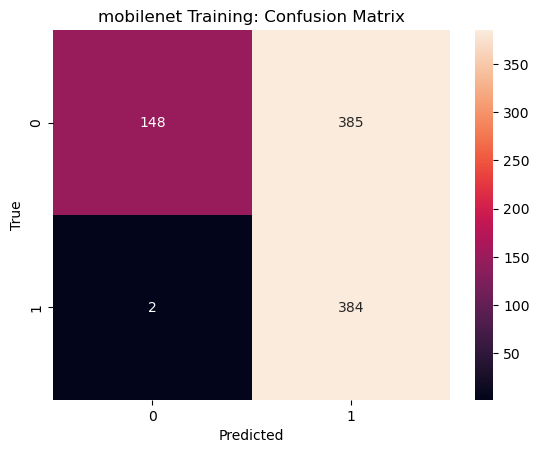

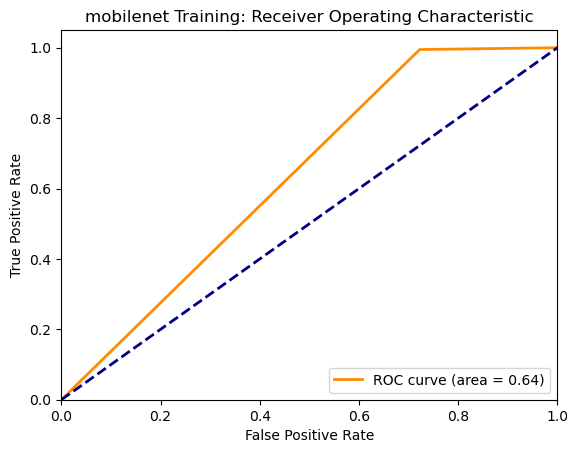

Testing data results:
Accuracy: 61.40%
Precision: 0.72
Recall: 0.61
F1 Score: 0.58


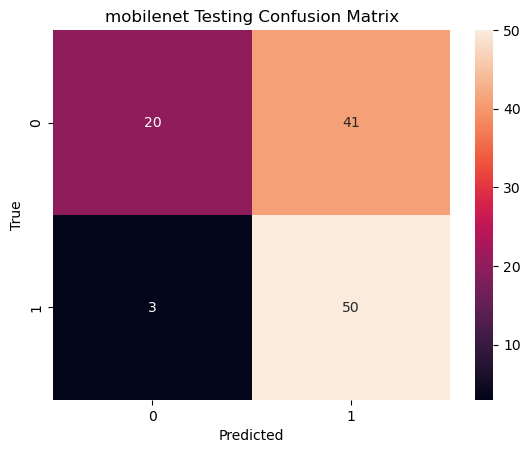

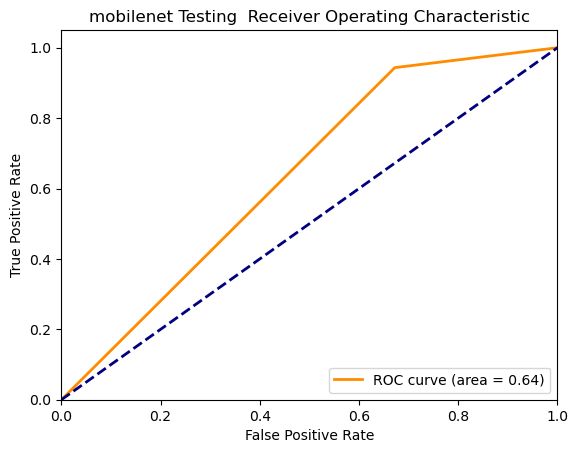

TRAINING and Testing data results:
{"{'lr': 0.001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.05, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.5788900979325353, 'train_precision': 0.7819829793696904, 'train_recall': 0.5788900979325353, 'train_f1': 0.5306394063337524, 'valid_accuracy': 0.6140350877192983, 'valid_precision': 0.7207399770328832, 'valid_recall': 0.6140350877192983, 'valid_f1': 0.5776594263436369}}


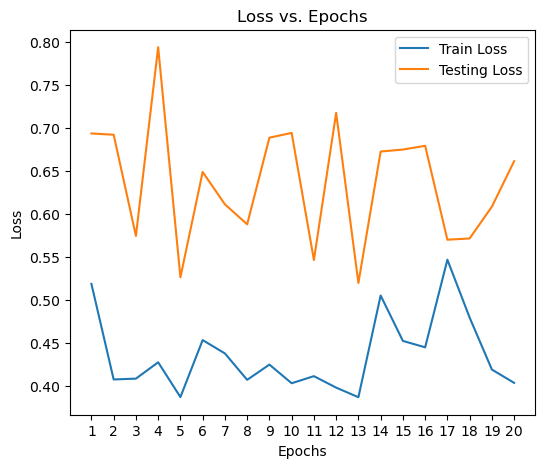

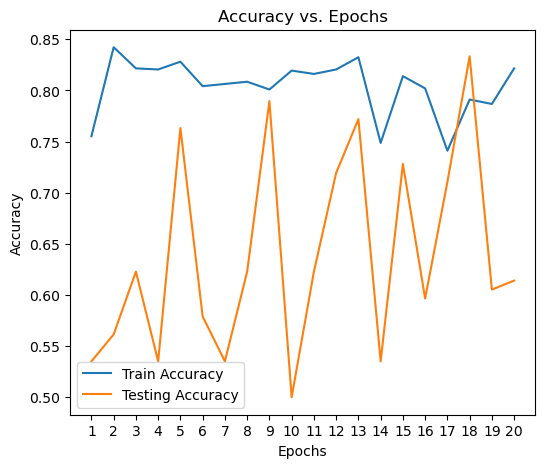

Best params:
  Model_Name                                    Hyperparameters  \
0  mobilenet  {'lr': 0.001, 'momentum': 0.9, 'epochs': 20, '...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0         0.57889         0.781983       0.57889  0.530639   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.614035               0.72074           0.614035       0.577659  
run time: 0:05:41.850401


In [368]:
#running now
#Baseline MobileNet
#1. Search: param_grid = {'lr': [.01, .001, .0001],'momentum': [.9], 'epochs': [20],'weight_decay[.0, .01, .05],
#                         'optimizer': ['Adam'],'batch_size': [16]}
#2. Best params: Model number: 4 current_params: {'lr': 0.001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0,
#                                                 'optimizer': 'Adam', 'batch_size': 16} 


model_name = 'mobilenet'
param_grid = {
        'lr': [.001],
        'momentum': [.9],
        'epochs': [20],
        'weight_decay': [.05],   
        'optimizer': ['Adam'],  
        'batch_size': [16]  
    }
    
accuracy=test_model_parameters(model_name, param_grid, train_dataset, test_dataset, device, valid_ds_name = 'Testing',
                               to_print=1, make_plots=1, write_csv=1)
                         

## Grid search for RESNET hyperparameters

In [10]:
# make_plots=0
# Looking at epochs for mobilenet
# use with plot as see when loss starts to level off
model_name = 'resnet18'
param_grid = {
        'lr': [.01, .001, .0001],
        'momentum': [.9],
        'epochs': [20],
        'weight_decay': [.0, .01, .05],  # Add weight_decay to the grid
        'optimizer': ['Adam'],  # Add optimizer to the grid
        'batch_size': [16]  
    }
    
#accuracy = build_model(lr=lr, momentum=momentum, weight_decay=weight_decay, batch_size=batch_size, epochs=epochs, 
#                      optimizer=optimizer_name, model_name=model_name)
params_resnet=test_model_parameters(model_name, param_grid, train_dataset, valid_dataset, device, 
                                    valid_ds_name = 'Validation',
                               to_print=1, make_plots=0, write_csv=1, return_type='results_df')

start time:  2024_04_02_2206
resnet18
Model number:  1  current_params:  {'lr': 0.01, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/20:
Train Loss: 1.1024, Train Accuracy: 0.5375
Validation Loss: 0.6837 Validation Accuracy: 0.5826
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.8026, Train Accuracy: 0.5539
Validation Loss: 0.6732 Validation Accuracy: 0.5652
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6919, Train Accuracy: 0.6126
Validation Loss: 0.7196 Validation Accuracy: 0.6000
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6627, Train Accuracy: 0.6104
Validation Loss: 0.6396 Validation Accuracy: 0.6174
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.6154, Train Accuracy: 0.6757
Validation Loss: 5.0840 Validation Accuracy: 0.5652
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.5560, Train Accuracy: 0.7051
Validation Loss: 0.6898 Validation Accuracy: 0.6261
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.5799, Train Accuracy: 0.7171
Validation Loss: 0.7268 

Epoch 9/20:
Train Loss: 0.6819, Train Accuracy: 0.5800
Validation Loss: 0.6776 Validation Accuracy: 0.5826
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.6817, Train Accuracy: 0.5800
Validation Loss: 0.6771 Validation Accuracy: 0.5826
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.6809, Train Accuracy: 0.5800
Validation Loss: 0.6774 Validation Accuracy: 0.5826
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.6816, Train Accuracy: 0.5800
Validation Loss: 0.6770 Validation Accuracy: 0.5826
Finished Epoch 12
Epoch 13/20:
Train Loss: 0.6809, Train Accuracy: 0.5800
Validation Loss: 0.6768 Validation Accuracy: 0.5826
Finished Epoch 13
Epoch 14/20:
Train Loss: 0.6801, Train Accuracy: 0.5800
Validation Loss: 0.6771 Validation Accuracy: 0.5826
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.6817, Train Accuracy: 0.5800
Validation Loss: 0.6769 Validation Accuracy: 0.5826
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.6842, Train Accuracy: 0.5800
Validation Loss: 0.6765 Validation Accuracy: 0.5826
Finished Epo

Epoch 5/20:
Train Loss: 0.4234, Train Accuracy: 0.8063
Validation Loss: 0.6381 Validation Accuracy: 0.6957
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.4388, Train Accuracy: 0.8041
Validation Loss: 0.7339 Validation Accuracy: 0.7652
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4612, Train Accuracy: 0.7900
Validation Loss: 0.5981 Validation Accuracy: 0.7304
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.4754, Train Accuracy: 0.7845
Validation Loss: 0.5484 Validation Accuracy: 0.7391
Finished Epoch 8
Epoch 9/20:
Train Loss: 0.5263, Train Accuracy: 0.7497
Validation Loss: 0.5474 Validation Accuracy: 0.6783
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.4135, Train Accuracy: 0.8150
Validation Loss: 0.6058 Validation Accuracy: 0.6348
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.4361, Train Accuracy: 0.8085
Validation Loss: 8.0534 Validation Accuracy: 0.4435
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.4041, Train Accuracy: 0.8259
Validation Loss: 0.5878 Validation Accuracy: 0.7304
Finished Epoch 12
Ep

Epoch 1/20:
Train Loss: 0.4510, Train Accuracy: 0.7769
Validation Loss: 0.4085 Validation Accuracy: 0.8261
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.1814, Train Accuracy: 0.9162
Validation Loss: 0.5099 Validation Accuracy: 0.8609
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.0867, Train Accuracy: 0.9706
Validation Loss: 0.4191 Validation Accuracy: 0.8087
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.0964, Train Accuracy: 0.9630
Validation Loss: 0.4657 Validation Accuracy: 0.8957
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.0598, Train Accuracy: 0.9793
Validation Loss: 0.5574 Validation Accuracy: 0.8522
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0392, Train Accuracy: 0.9869
Validation Loss: 0.4270 Validation Accuracy: 0.8957
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.0295, Train Accuracy: 0.9913
Validation Loss: 0.4105 Validation Accuracy: 0.8957
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.0359, Train Accuracy: 0.9859
Validation Loss: 0.4761 Validation Accuracy: 0.8783
Finished Epoch 8
Epoch 9/

Validation Loss: 0.3954 Validation Accuracy: 0.9043
Finished Epoch 20
Finished Training model number:  8
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 90.43%
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
TRAINING and Validation data results:
{"{'lr': 0.01, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'resnet18', 'train_accuracy': 0.8933623503808488, 'train_precision': 0.8994553927255389, 'train_recall': 0.8933623503808488, 'train_f1': 0.8939694016422773, 'valid_accuracy': 0.808695652173913, 'valid_precision': 0.812422360248447, 'valid_recall': 0.808695652173913, 'valid_f1': 0.8095785953177258}, "{'lr': 0.01, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.01, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'resnet18', 'train_accuracy': 0.6681175190424374, 'train_precision': 0.6994890177624756, 'train_recall': 0.6681175190424374, 'train_f1': 0.6

## Grid search for DENSENET hyperparameters

In [11]:
# make_plots=0
# Looking at epochs for mobilenet
# use with plot as see when loss starts to level off
model_name = 'densenet'
param_grid = {
        'lr': [.01, .001, .0001],
        'momentum': [.9],
        'epochs': [20],
        'weight_decay': [.0, .01, .05],  # Add weight_decay to the grid
        'optimizer': ['Adam'],  # Add optimizer to the grid
        'batch_size': [16]  
    }
    
#accuracy = build_model(lr=lr, momentum=momentum, weight_decay=weight_decay, batch_size=batch_size, epochs=epochs, 
#                      optimizer=optimizer_name, model_name=model_name)
params_densenet=test_model_parameters(model_name, param_grid, train_dataset, valid_dataset, device, 
                                      valid_ds_name = 'Validation',
                               to_print=1, make_plots=0, write_csv=1, return_type='results_df')

start time:  2024_04_02_2249
densenet
Model number:  1  current_params:  {'lr': 0.01, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/20:
Train Loss: 0.8994, Train Accuracy: 0.5669
Validation Loss: 18.4752 Validation Accuracy: 0.5826
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.7915, Train Accuracy: 0.5484
Validation Loss: 0.6309 Validation Accuracy: 0.6261
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.7516, Train Accuracy: 0.5822
Validation Loss: 0.8414 Validation Accuracy: 0.4957
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6706, Train Accuracy: 0.6355
Validation Loss: 0.8359 Validation Accuracy: 0.4522
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.5842, Train Accuracy: 0.6812
Validation Loss: 0.6349 Validation Accuracy: 0.6696
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.5485, Train Accuracy: 0.7236
Validation Loss: 0.7021 Validation Accuracy: 0.6609
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.5375, Train Accuracy: 0.7421
Validation Loss: 0.6194

Epoch 9/20:
Train Loss: 0.6811, Train Accuracy: 0.5800
Validation Loss: 0.6772 Validation Accuracy: 0.5826
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.6804, Train Accuracy: 0.5800
Validation Loss: 0.6773 Validation Accuracy: 0.5826
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.6819, Train Accuracy: 0.5800
Validation Loss: 0.6796 Validation Accuracy: 0.5826
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.6823, Train Accuracy: 0.5800
Validation Loss: 0.6777 Validation Accuracy: 0.5826
Finished Epoch 12
Epoch 13/20:
Train Loss: 0.6821, Train Accuracy: 0.5800
Validation Loss: 0.6769 Validation Accuracy: 0.5826
Finished Epoch 13
Epoch 14/20:
Train Loss: 0.6817, Train Accuracy: 0.5800
Validation Loss: 0.6773 Validation Accuracy: 0.5826
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.6806, Train Accuracy: 0.5800
Validation Loss: 0.6772 Validation Accuracy: 0.5826
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.6830, Train Accuracy: 0.5800
Validation Loss: 0.6768 Validation Accuracy: 0.5826
Finished Epo

Epoch 5/20:
Train Loss: 0.5222, Train Accuracy: 0.7563
Validation Loss: 0.5674 Validation Accuracy: 0.7478
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.5986, Train Accuracy: 0.6986
Validation Loss: 0.8747 Validation Accuracy: 0.5826
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4978, Train Accuracy: 0.7563
Validation Loss: 0.7270 Validation Accuracy: 0.6783
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.4801, Train Accuracy: 0.7791
Validation Loss: 0.6075 Validation Accuracy: 0.6522
Finished Epoch 8
Epoch 9/20:
Train Loss: 0.4469, Train Accuracy: 0.7900
Validation Loss: 0.5733 Validation Accuracy: 0.7043
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.4508, Train Accuracy: 0.7965
Validation Loss: 1.2509 Validation Accuracy: 0.4870
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.4594, Train Accuracy: 0.7791
Validation Loss: 1.0426 Validation Accuracy: 0.6000
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.4243, Train Accuracy: 0.7987
Validation Loss: 6.8939 Validation Accuracy: 0.4435
Finished Epoch 12
Ep

Epoch 1/20:
Train Loss: 0.4735, Train Accuracy: 0.7726
Validation Loss: 0.4453 Validation Accuracy: 0.8348
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.1915, Train Accuracy: 0.9304
Validation Loss: 0.3778 Validation Accuracy: 0.8957
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.1176, Train Accuracy: 0.9597
Validation Loss: 0.3612 Validation Accuracy: 0.9130
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.0833, Train Accuracy: 0.9793
Validation Loss: 0.2664 Validation Accuracy: 0.8783
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.0864, Train Accuracy: 0.9684
Validation Loss: 0.3716 Validation Accuracy: 0.8957
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0693, Train Accuracy: 0.9815
Validation Loss: 0.4024 Validation Accuracy: 0.8696
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.0363, Train Accuracy: 0.9891
Validation Loss: 0.4189 Validation Accuracy: 0.8870
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.0192, Train Accuracy: 0.9967
Validation Loss: 0.3153 Validation Accuracy: 0.8957
Finished Epoch 8
Epoch 9/

Validation Loss: 0.2987 Validation Accuracy: 0.9304
Finished Epoch 20
Finished Training model number:  8
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 93.04%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
TRAINING and Validation data results:
{"{'lr': 0.01, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'densenet', 'train_accuracy': 0.7236126224156693, 'train_precision': 0.7649245927843045, 'train_recall': 0.7236126224156693, 'train_f1': 0.695209808971629, 'valid_accuracy': 0.6608695652173913, 'valid_precision': 0.6937157471684325, 'valid_recall': 0.6608695652173913, 'valid_f1': 0.6118577075098814}, "{'lr': 0.01, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.01, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'densenet', 'train_accuracy': 0.5669205658324266, 'train_precision': 0.6058092355210138, 'train_recall': 0.5669205658324266, 'train_f1': 0

## Investigating additional hyperparameters for Mobilenet

In [58]:


model_name = 'mobilenet'
param_grid = {
        'lr': [.001, .0001],
        'momentum': [.8, .9,.95],
        'epochs': [20,75],
        'weight_decay': [.0, .0001],  
        'optimizer': ['SGD'],  
        'batch_size': [16,32]  
    }
    

params_mobilenet_SGD = test_model_parameters(model_name, param_grid, train_dataset, valid_dataset, device, 
                                            valid_ds_name = 'Validation',
                                            to_print=1, make_plots=0, write_csv=1, return_type='results_df')

start time:  2024_04_05_0153
mobilenet
Model number:  1  current_params:  {'lr': 0.001, 'momentum': 0.8, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}
Epoch 1/20:
Train Loss: 0.6618, Train Accuracy: 0.5887
Validation Loss: 0.6511 Validation Accuracy: 0.6696
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6178, Train Accuracy: 0.6594
Validation Loss: 0.6469 Validation Accuracy: 0.6000
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5886, Train Accuracy: 0.6877
Validation Loss: 0.6354 Validation Accuracy: 0.6522
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5577, Train Accuracy: 0.7193
Validation Loss: 0.6051 Validation Accuracy: 0.6870
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.5360, Train Accuracy: 0.7356
Validation Loss: 0.5884 Validation Accuracy: 0.7217
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.5055, Train Accuracy: 0.7628
Validation Loss: 0.5668 Validation Accuracy: 0.7304
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4763, Train Accuracy: 0.8139
Validation Loss: 0.6029

Validation Loss: 0.4929 Validation Accuracy: 0.7826
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.3603, Train Accuracy: 0.8520
Validation Loss: 0.4886 Validation Accuracy: 0.7826
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.3306, Train Accuracy: 0.8683
Validation Loss: 0.4771 Validation Accuracy: 0.7739
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.3121, Train Accuracy: 0.8803
Validation Loss: 0.4968 Validation Accuracy: 0.7478
Finished Epoch 12
Epoch 13/20:
Train Loss: 0.2712, Train Accuracy: 0.9140
Validation Loss: 0.4300 Validation Accuracy: 0.7826
Finished Epoch 13
Epoch 14/20:
Train Loss: 0.2527, Train Accuracy: 0.9097
Validation Loss: 0.4187 Validation Accuracy: 0.8000
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.2438, Train Accuracy: 0.9097
Validation Loss: 0.4911 Validation Accuracy: 0.8174
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.2057, Train Accuracy: 0.9358
Validation Loss: 0.4389 Validation Accuracy: 0.7913
Finished Epoch 16
Epoch 17/20:
Train Loss: 0.1779, Train Accuracy: 

Epoch 6/75:
Train Loss: 0.5288, Train Accuracy: 0.7421
Validation Loss: 0.6026 Validation Accuracy: 0.6957
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.4801, Train Accuracy: 0.7758
Validation Loss: 0.5847 Validation Accuracy: 0.7826
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.4541, Train Accuracy: 0.8030
Validation Loss: 0.5614 Validation Accuracy: 0.7391
Finished Epoch 8
Epoch 9/75:
Train Loss: 0.4142, Train Accuracy: 0.8270
Validation Loss: 0.5376 Validation Accuracy: 0.7652
Finished Epoch 9
Epoch 10/75:
Train Loss: 0.3898, Train Accuracy: 0.8357
Validation Loss: 0.5855 Validation Accuracy: 0.7391
Finished Epoch 10
Epoch 11/75:
Train Loss: 0.3616, Train Accuracy: 0.8694
Validation Loss: 0.5535 Validation Accuracy: 0.7130
Finished Epoch 11
Epoch 12/75:
Train Loss: 0.3414, Train Accuracy: 0.8629
Validation Loss: 0.5181 Validation Accuracy: 0.7652
Finished Epoch 12
Epoch 13/75:
Train Loss: 0.3277, Train Accuracy: 0.8694
Validation Loss: 0.4881 Validation Accuracy: 0.7913
Finished Epoch 13


Validation Loss: 0.5674 Validation Accuracy: 0.8522
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0265, Train Accuracy: 0.9924
Validation Loss: 0.6889 Validation Accuracy: 0.8174
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0108, Train Accuracy: 0.9989
Validation Loss: 0.6296 Validation Accuracy: 0.8261
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0084, Train Accuracy: 0.9989
Validation Loss: 0.7258 Validation Accuracy: 0.8348
Finished Epoch 74
Epoch 75/75:
Train Loss: 0.0082, Train Accuracy: 0.9989
Validation Loss: 0.7316 Validation Accuracy: 0.8348
Finished Epoch 75
Finished Training model number:  5
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 83.48%
Precision: 0.83
Recall: 0.83
F1 Score: 0.83
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.8, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.9934711643090316, 'train_p

Epoch 43/75:
Train Loss: 0.0334, Train Accuracy: 0.9989
Validation Loss: 0.4343 Validation Accuracy: 0.8261
Finished Epoch 43
Epoch 44/75:
Train Loss: 0.0436, Train Accuracy: 0.9913
Validation Loss: 0.4218 Validation Accuracy: 0.8174
Finished Epoch 44
Epoch 45/75:
Train Loss: 0.0298, Train Accuracy: 0.9989
Validation Loss: 0.4683 Validation Accuracy: 0.7826
Finished Epoch 45
Epoch 46/75:
Train Loss: 0.0305, Train Accuracy: 0.9978
Validation Loss: 0.4430 Validation Accuracy: 0.8174
Finished Epoch 46
Epoch 47/75:
Train Loss: 0.0338, Train Accuracy: 0.9967
Validation Loss: 0.4734 Validation Accuracy: 0.8087
Finished Epoch 47
Epoch 48/75:
Train Loss: 0.0339, Train Accuracy: 0.9978
Validation Loss: 0.4761 Validation Accuracy: 0.7826
Finished Epoch 48
Epoch 49/75:
Train Loss: 0.0249, Train Accuracy: 1.0000
Validation Loss: 0.4430 Validation Accuracy: 0.8174
Finished Epoch 49
Epoch 50/75:
Train Loss: 0.0233, Train Accuracy: 0.9978
Validation Loss: 0.4799 Validation Accuracy: 0.8000
Finished E

Validation Loss: 0.4606 Validation Accuracy: 0.8174
Finished Epoch 11
Epoch 12/75:
Train Loss: 0.2964, Train Accuracy: 0.8912
Validation Loss: 0.4252 Validation Accuracy: 0.8261
Finished Epoch 12
Epoch 13/75:
Train Loss: 0.2794, Train Accuracy: 0.8912
Validation Loss: 0.4289 Validation Accuracy: 0.7739
Finished Epoch 13
Epoch 14/75:
Train Loss: 0.2764, Train Accuracy: 0.8912
Validation Loss: 0.4423 Validation Accuracy: 0.8000
Finished Epoch 14
Epoch 15/75:
Train Loss: 0.2220, Train Accuracy: 0.9293
Validation Loss: 0.3985 Validation Accuracy: 0.8348
Finished Epoch 15
Epoch 16/75:
Train Loss: 0.2048, Train Accuracy: 0.9336
Validation Loss: 0.4699 Validation Accuracy: 0.8087
Finished Epoch 16
Epoch 17/75:
Train Loss: 0.1764, Train Accuracy: 0.9423
Validation Loss: 0.4782 Validation Accuracy: 0.8174
Finished Epoch 17
Epoch 18/75:
Train Loss: 0.1588, Train Accuracy: 0.9456
Validation Loss: 0.4072 Validation Accuracy: 0.8261
Finished Epoch 18
Epoch 19/75:
Train Loss: 0.1339, Train Accuracy:

Accuracy: 86.96%
Precision: 0.88
Recall: 0.87
F1 Score: 0.87
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.8, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.9934711643090316, 'train_precision': 0.9934761007664433, 'train_recall': 0.9934711643090316, 'train_f1': 0.9934687984436735, 'valid_accuracy': 0.8347826086956521, 'valid_precision': 0.8353714608372993, 'valid_recall': 0.8347826086956521, 'valid_f1': 0.835013126720881}, "{'lr': 0.001, 'momentum': 0.8, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 32}": {'model_name': 'mobilenet', 'train_accuracy': 0.9575625680087051, 'train_precision': 0.9578772599077822, 'train_recall': 0.9575625680087051, 'train_f1': 0.9576264156224226, 'valid_accuracy': 0.8, 'valid_precision': 0.8006802721088436, 'valid_recall': 0.8, 'valid_f1': 0.8002790481358036}, "{'lr': 0.001, 'momentum': 0.8, 'epochs': 20, 'weight_decay': 0.0001, 'optimize

Epoch 43/75:
Train Loss: 0.0265, Train Accuracy: 0.9989
Validation Loss: 0.4884 Validation Accuracy: 0.8435
Finished Epoch 43
Epoch 44/75:
Train Loss: 0.0346, Train Accuracy: 0.9935
Validation Loss: 0.5124 Validation Accuracy: 0.8609
Finished Epoch 44
Epoch 45/75:
Train Loss: 0.0241, Train Accuracy: 0.9978
Validation Loss: 0.4911 Validation Accuracy: 0.8435
Finished Epoch 45
Epoch 46/75:
Train Loss: 0.0238, Train Accuracy: 1.0000
Validation Loss: 0.4932 Validation Accuracy: 0.8348
Finished Epoch 46
Epoch 47/75:
Train Loss: 0.0301, Train Accuracy: 0.9978
Validation Loss: 0.4768 Validation Accuracy: 0.8435
Finished Epoch 47
Epoch 48/75:
Train Loss: 0.0243, Train Accuracy: 0.9989
Validation Loss: 0.4891 Validation Accuracy: 0.8261
Finished Epoch 48
Epoch 49/75:
Train Loss: 0.0224, Train Accuracy: 0.9978
Validation Loss: 0.5022 Validation Accuracy: 0.8174
Finished Epoch 49
Epoch 50/75:
Train Loss: 0.0209, Train Accuracy: 0.9989
Validation Loss: 0.5069 Validation Accuracy: 0.8435
Finished E

Epoch 6/20:
Train Loss: 0.3582, Train Accuracy: 0.8498
Validation Loss: 0.4735 Validation Accuracy: 0.7826
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.2998, Train Accuracy: 0.8836
Validation Loss: 0.5165 Validation Accuracy: 0.7913
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.2645, Train Accuracy: 0.8901
Validation Loss: 0.4525 Validation Accuracy: 0.8000
Finished Epoch 8
Epoch 9/20:
Train Loss: 0.2103, Train Accuracy: 0.9173
Validation Loss: 0.4156 Validation Accuracy: 0.8000
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.2325, Train Accuracy: 0.9010
Validation Loss: 0.5920 Validation Accuracy: 0.7565
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.1881, Train Accuracy: 0.9347
Validation Loss: 0.4740 Validation Accuracy: 0.8348
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.1414, Train Accuracy: 0.9499
Validation Loss: 0.4847 Validation Accuracy: 0.8522
Finished Epoch 12
Epoch 13/20:
Train Loss: 0.1178, Train Accuracy: 0.9619
Validation Loss: 0.3681 Validation Accuracy: 0.8609
Finished Epoch 13


Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 85.22%
Precision: 0.85
Recall: 0.85
F1 Score: 0.85
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.8, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.9934711643090316, 'train_precision': 0.9934761007664433, 'train_recall': 0.9934711643090316, 'train_f1': 0.9934687984436735, 'valid_accuracy': 0.8347826086956521, 'valid_precision': 0.8353714608372993, 'valid_recall': 0.8347826086956521, 'valid_f1': 0.835013126720881}, "{'lr': 0.001, 'momentum': 0.8, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 32}": {'model_name': 'mobilenet', 'train_accuracy': 0.9575625680087051, 'train_precision': 0.9578772599077822, 'train_recall': 0.9575625680087051, 'train_f1': 0.9576264156224226, 'valid_accuracy': 0.8, 'valid_precision': 0.8006802721088436, 'valid_recall': 0.8, 'valid_f1': 0.80027904813

Epoch 1/20:
Train Loss: 0.6695, Train Accuracy: 0.5593
Validation Loss: 0.6532 Validation Accuracy: 0.6609
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6114, Train Accuracy: 0.6561
Validation Loss: 0.6232 Validation Accuracy: 0.6783
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5735, Train Accuracy: 0.6986
Validation Loss: 0.6197 Validation Accuracy: 0.6261
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5273, Train Accuracy: 0.7443
Validation Loss: 0.5853 Validation Accuracy: 0.7043
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4965, Train Accuracy: 0.7878
Validation Loss: 0.5602 Validation Accuracy: 0.7217
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.4511, Train Accuracy: 0.8139
Validation Loss: 0.5326 Validation Accuracy: 0.7652
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4088, Train Accuracy: 0.8433
Validation Loss: 0.5333 Validation Accuracy: 0.7304
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.3729, Train Accuracy: 0.8607
Validation Loss: 0.5299 Validation Accuracy: 0.7391
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4508 Validation Accuracy: 0.7913
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.2532, Train Accuracy: 0.9010
Validation Loss: 0.4628 Validation Accuracy: 0.8000
Finished Epoch 8
Epoch 9/75:
Train Loss: 0.2041, Train Accuracy: 0.9282
Validation Loss: 0.3727 Validation Accuracy: 0.8522
Finished Epoch 9
Epoch 10/75:
Train Loss: 0.1499, Train Accuracy: 0.9532
Validation Loss: 0.3772 Validation Accuracy: 0.8261
Finished Epoch 10
Epoch 11/75:
Train Loss: 0.1075, Train Accuracy: 0.9695
Validation Loss: 0.4653 Validation Accuracy: 0.8522
Finished Epoch 11
Epoch 12/75:
Train Loss: 0.0841, Train Accuracy: 0.9761
Validation Loss: 0.3929 Validation Accuracy: 0.8435
Finished Epoch 12
Epoch 13/75:
Train Loss: 0.0649, Train Accuracy: 0.9837
Validation Loss: 0.4920 Validation Accuracy: 0.8174
Finished Epoch 13
Epoch 14/75:
Train Loss: 0.0965, Train Accuracy: 0.9663
Validation Loss: 0.4100 Validation Accuracy: 0.8609
Finished Epoch 14
Epoch 15/75:
Train Loss: 0.0653, Train Accuracy: 0.98

Epoch 73/75:
Train Loss: 0.0022, Train Accuracy: 1.0000
Validation Loss: 0.2746 Validation Accuracy: 0.9304
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0028, Train Accuracy: 1.0000
Validation Loss: 0.2923 Validation Accuracy: 0.9304
Finished Epoch 74
Epoch 75/75:
Train Loss: 0.0024, Train Accuracy: 0.9989
Validation Loss: 0.2700 Validation Accuracy: 0.9391
Finished Epoch 75
Finished Training model number:  13
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 93.91%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.8, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.9934711643090316, 'train_precision': 0.9934761007664433, 'train_recall': 0.9934711643090316, 'train_f1': 0.9934687984436735, 'valid_accuracy': 0.8347826086956521, 'valid_precision': 0.8353714608372993, 'valid_recall': 0.8

Validation Loss: 0.4806 Validation Accuracy: 0.8174
Finished Epoch 21
Epoch 22/75:
Train Loss: 0.0424, Train Accuracy: 0.9935
Validation Loss: 0.4121 Validation Accuracy: 0.8435
Finished Epoch 22
Epoch 23/75:
Train Loss: 0.0290, Train Accuracy: 0.9978
Validation Loss: 0.5246 Validation Accuracy: 0.8435
Finished Epoch 23
Epoch 24/75:
Train Loss: 0.0264, Train Accuracy: 0.9967
Validation Loss: 0.5070 Validation Accuracy: 0.8261
Finished Epoch 24
Epoch 25/75:
Train Loss: 0.0255, Train Accuracy: 0.9956
Validation Loss: 0.5107 Validation Accuracy: 0.8348
Finished Epoch 25
Epoch 26/75:
Train Loss: 0.0221, Train Accuracy: 1.0000
Validation Loss: 0.5082 Validation Accuracy: 0.8261
Finished Epoch 26
Epoch 27/75:
Train Loss: 0.0189, Train Accuracy: 1.0000
Validation Loss: 0.5254 Validation Accuracy: 0.8522
Finished Epoch 27
Epoch 28/75:
Train Loss: 0.0184, Train Accuracy: 1.0000
Validation Loss: 0.4602 Validation Accuracy: 0.8348
Finished Epoch 28
Epoch 29/75:
Train Loss: 0.0170, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6496, Train Accuracy: 0.5832
Validation Loss: 0.6462 Validation Accuracy: 0.6087
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5784, Train Accuracy: 0.6921
Validation Loss: 0.6382 Validation Accuracy: 0.6435
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5418, Train Accuracy: 0.7258
Validation Loss: 0.5453 Validation Accuracy: 0.7130
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.4775, Train Accuracy: 0.7639
Validation Loss: 0.5754 Validation Accuracy: 0.6870
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4321, Train Accuracy: 0.8248
Validation Loss: 0.5020 Validation Accuracy: 0.7304
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.3731, Train Accuracy: 0.8444
Validation Loss: 0.4517 Validation Accuracy: 0.8087
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.3194, Train Accuracy: 0.8640
Validation Loss: 0.4658 Validation Accuracy: 0.8087
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.2848, Train Accuracy: 0.8890
Validation Loss: 0.5278 Validation Accuracy: 0.7304
Finished Epoch 8
Epoch 9/

Validation Loss: 0.3726 Validation Accuracy: 0.9043
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0058, Train Accuracy: 1.0000
Validation Loss: 0.3930 Validation Accuracy: 0.8957
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0084, Train Accuracy: 0.9989
Validation Loss: 0.3954 Validation Accuracy: 0.8957
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0025, Train Accuracy: 1.0000
Validation Loss: 0.4169 Validation Accuracy: 0.9043
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0057, Train Accuracy: 1.0000
Validation Loss: 0.4357 Validation Accuracy: 0.8870
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0030, Train Accuracy: 1.0000
Validation Loss: 0.4019 Validation Accuracy: 0.9043
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0061, Train Accuracy: 0.9989
Validation Loss: 0.4009 Validation Accuracy: 0.9043
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0027, Train Accuracy: 1.0000
Validation Loss: 0.3962 Validation Accuracy: 0.8957
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0031, Train Accuracy:

Epoch 9/75:
Train Loss: 0.3381, Train Accuracy: 0.8651
Validation Loss: 0.5141 Validation Accuracy: 0.7826
Finished Epoch 9
Epoch 10/75:
Train Loss: 0.2960, Train Accuracy: 0.8988
Validation Loss: 0.4584 Validation Accuracy: 0.8174
Finished Epoch 10
Epoch 11/75:
Train Loss: 0.2610, Train Accuracy: 0.9086
Validation Loss: 0.4591 Validation Accuracy: 0.7913
Finished Epoch 11
Epoch 12/75:
Train Loss: 0.2149, Train Accuracy: 0.9336
Validation Loss: 0.4753 Validation Accuracy: 0.8087
Finished Epoch 12
Epoch 13/75:
Train Loss: 0.1883, Train Accuracy: 0.9434
Validation Loss: 0.5226 Validation Accuracy: 0.7913
Finished Epoch 13
Epoch 14/75:
Train Loss: 0.1648, Train Accuracy: 0.9554
Validation Loss: 0.4424 Validation Accuracy: 0.8087
Finished Epoch 14
Epoch 15/75:
Train Loss: 0.1384, Train Accuracy: 0.9728
Validation Loss: 0.4819 Validation Accuracy: 0.8087
Finished Epoch 15
Epoch 16/75:
Train Loss: 0.1134, Train Accuracy: 0.9771
Validation Loss: 0.4203 Validation Accuracy: 0.8261
Finished Epo

Validation Loss: 0.5834 Validation Accuracy: 0.8522
Finished Epoch 74
Epoch 75/75:
Train Loss: 0.0019, Train Accuracy: 1.0000
Validation Loss: 0.5561 Validation Accuracy: 0.8435
Finished Epoch 75
Finished Training model number:  16
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 84.35%
Precision: 0.84
Recall: 0.84
F1 Score: 0.84
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.8, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.9934711643090316, 'train_precision': 0.9934761007664433, 'train_recall': 0.9934711643090316, 'train_f1': 0.9934687984436735, 'valid_accuracy': 0.8347826086956521, 'valid_precision': 0.8353714608372993, 'valid_recall': 0.8347826086956521, 'valid_f1': 0.835013126720881}, "{'lr': 0.001, 'momentum': 0.8, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 32}": {'model_name': 'mobilenet'

Epoch 14/20:
Train Loss: 0.0610, Train Accuracy: 0.9837
Validation Loss: 0.6790 Validation Accuracy: 0.8696
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.0512, Train Accuracy: 0.9880
Validation Loss: 0.5781 Validation Accuracy: 0.8609
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.0430, Train Accuracy: 0.9869
Validation Loss: 0.6450 Validation Accuracy: 0.8435
Finished Epoch 16
Epoch 17/20:
Train Loss: 0.0481, Train Accuracy: 0.9826
Validation Loss: 0.5266 Validation Accuracy: 0.8783
Finished Epoch 17
Epoch 18/20:
Train Loss: 0.0555, Train Accuracy: 0.9826
Validation Loss: 0.4914 Validation Accuracy: 0.8609
Finished Epoch 18
Epoch 19/20:
Train Loss: 0.0281, Train Accuracy: 0.9935
Validation Loss: 0.4305 Validation Accuracy: 0.9217
Finished Epoch 19
Epoch 20/20:
Train Loss: 0.0130, Train Accuracy: 0.9978
Validation Loss: 0.4833 Validation Accuracy: 0.8957
Finished Epoch 20
Finished Training model number:  17
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.

Validation Loss: 0.5256 Validation Accuracy: 0.7217
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.3172, Train Accuracy: 0.8857
Validation Loss: 0.4411 Validation Accuracy: 0.8261
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.2357, Train Accuracy: 0.9184
Validation Loss: 0.4104 Validation Accuracy: 0.8522
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.1696, Train Accuracy: 0.9510
Validation Loss: 0.3847 Validation Accuracy: 0.8435
Finished Epoch 8
Epoch 9/20:
Train Loss: 0.1320, Train Accuracy: 0.9684
Validation Loss: 0.3640 Validation Accuracy: 0.8348
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.0965, Train Accuracy: 0.9804
Validation Loss: 0.3540 Validation Accuracy: 0.8696
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.0673, Train Accuracy: 0.9880
Validation Loss: 0.3736 Validation Accuracy: 0.8609
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.0422, Train Accuracy: 0.9978
Validation Loss: 0.3333 Validation Accuracy: 0.8435
Finished Epoch 12
Epoch 13/20:
Train Loss: 0.0292, Train Accuracy: 1.0000
V

Epoch 1/20:
Train Loss: 0.6441, Train Accuracy: 0.6115
Validation Loss: 0.6611 Validation Accuracy: 0.6435
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5465, Train Accuracy: 0.7214
Validation Loss: 0.6135 Validation Accuracy: 0.6609
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.4802, Train Accuracy: 0.7780
Validation Loss: 0.5708 Validation Accuracy: 0.7043
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.3643, Train Accuracy: 0.8618
Validation Loss: 0.4352 Validation Accuracy: 0.8348
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.2785, Train Accuracy: 0.8923
Validation Loss: 0.3945 Validation Accuracy: 0.8957
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.1965, Train Accuracy: 0.9206
Validation Loss: 0.3979 Validation Accuracy: 0.8348
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.1365, Train Accuracy: 0.9510
Validation Loss: 0.3873 Validation Accuracy: 0.8522
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.0951, Train Accuracy: 0.9728
Validation Loss: 0.3167 Validation Accuracy: 0.9043
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6648, Train Accuracy: 0.5615
Validation Loss: 0.6728 Validation Accuracy: 0.5826
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5763, Train Accuracy: 0.7008
Validation Loss: 0.6003 Validation Accuracy: 0.6348
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5606, Train Accuracy: 0.7323
Validation Loss: 0.6006 Validation Accuracy: 0.7043
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5021, Train Accuracy: 0.7573
Validation Loss: 0.5537 Validation Accuracy: 0.7391
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4334, Train Accuracy: 0.8074
Validation Loss: 0.5052 Validation Accuracy: 0.7739
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.3675, Train Accuracy: 0.8477
Validation Loss: 0.4357 Validation Accuracy: 0.8261
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.2880, Train Accuracy: 0.8857
Validation Loss: 0.4715 Validation Accuracy: 0.8000
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.2373, Train Accuracy: 0.9075
Validation Loss: 0.4569 Validation Accuracy: 0.8087
Finished Epoch 8
Epoch 9/

Epoch 1/75:
Train Loss: 0.6512, Train Accuracy: 0.5985
Validation Loss: 0.6212 Validation Accuracy: 0.7391
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5415, Train Accuracy: 0.7280
Validation Loss: 0.5980 Validation Accuracy: 0.7391
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.4549, Train Accuracy: 0.7802
Validation Loss: 0.4945 Validation Accuracy: 0.7565
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.3387, Train Accuracy: 0.8531
Validation Loss: 0.5168 Validation Accuracy: 0.8087
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.2726, Train Accuracy: 0.8890
Validation Loss: 0.4341 Validation Accuracy: 0.8609
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.1924, Train Accuracy: 0.9260
Validation Loss: 0.5369 Validation Accuracy: 0.8609
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.1615, Train Accuracy: 0.9391
Validation Loss: 0.4480 Validation Accuracy: 0.8609
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.1010, Train Accuracy: 0.9695
Validation Loss: 0.3924 Validation Accuracy: 0.8522
Finished Epoch 8
Epoch 9/

Validation Loss: 0.3388 Validation Accuracy: 0.9217
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0083, Train Accuracy: 0.9978
Validation Loss: 0.3464 Validation Accuracy: 0.9304
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0100, Train Accuracy: 0.9946
Validation Loss: 0.3651 Validation Accuracy: 0.9130
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0031, Train Accuracy: 1.0000
Validation Loss: 0.3602 Validation Accuracy: 0.9217
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0026, Train Accuracy: 1.0000
Validation Loss: 0.4494 Validation Accuracy: 0.9217
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0012, Train Accuracy: 1.0000
Validation Loss: 0.3713 Validation Accuracy: 0.9304
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0026, Train Accuracy: 0.9989
Validation Loss: 0.3970 Validation Accuracy: 0.9217
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0013, Train Accuracy: 1.0000
Validation Loss: 0.4426 Validation Accuracy: 0.9217
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0011, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6677, Train Accuracy: 0.5571
Validation Loss: 0.6620 Validation Accuracy: 0.6435
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5921, Train Accuracy: 0.6801
Validation Loss: 0.5759 Validation Accuracy: 0.7130
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5432, Train Accuracy: 0.7247
Validation Loss: 0.6099 Validation Accuracy: 0.6348
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.4763, Train Accuracy: 0.7889
Validation Loss: 0.5995 Validation Accuracy: 0.6609
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4117, Train Accuracy: 0.8205
Validation Loss: 0.4985 Validation Accuracy: 0.7565
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.3308, Train Accuracy: 0.8662
Validation Loss: 0.4714 Validation Accuracy: 0.7478
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.2646, Train Accuracy: 0.8923
Validation Loss: 0.4846 Validation Accuracy: 0.7565
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.2217, Train Accuracy: 0.9282
Validation Loss: 0.5191 Validation Accuracy: 0.8000
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4980 Validation Accuracy: 0.8783
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0009, Train Accuracy: 1.0000
Validation Loss: 0.4805 Validation Accuracy: 0.8783
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0014, Train Accuracy: 1.0000
Validation Loss: 0.4822 Validation Accuracy: 0.8957
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Validation Loss: 0.4887 Validation Accuracy: 0.8870
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0011, Train Accuracy: 1.0000
Validation Loss: 0.5180 Validation Accuracy: 0.8522
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Validation Loss: 0.5181 Validation Accuracy: 0.8609
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0010, Train Accuracy: 1.0000
Validation Loss: 0.4877 Validation Accuracy: 0.8783
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0006, Train Accuracy: 1.0000
Validation Loss: 0.5058 Validation Accuracy: 0.8696
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0008, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6483, Train Accuracy: 0.5909
Validation Loss: 0.6378 Validation Accuracy: 0.6174
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5565, Train Accuracy: 0.7280
Validation Loss: 0.5713 Validation Accuracy: 0.7304
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.4541, Train Accuracy: 0.7933
Validation Loss: 0.4634 Validation Accuracy: 0.7826
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.3116, Train Accuracy: 0.8814
Validation Loss: 0.4715 Validation Accuracy: 0.8000
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.2415, Train Accuracy: 0.9097
Validation Loss: 0.3643 Validation Accuracy: 0.8609
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.1492, Train Accuracy: 0.9521
Validation Loss: 0.4024 Validation Accuracy: 0.8696
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.0992, Train Accuracy: 0.9630
Validation Loss: 0.6656 Validation Accuracy: 0.8609
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0702, Train Accuracy: 0.9706
Validation Loss: 0.4278 Validation Accuracy: 0.8957
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4706 Validation Accuracy: 0.9304
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Validation Loss: 0.5198 Validation Accuracy: 0.9391
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0045, Train Accuracy: 0.9978
Validation Loss: 0.4792 Validation Accuracy: 0.9304
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Validation Loss: 0.4903 Validation Accuracy: 0.9217
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0101, Train Accuracy: 0.9989
Validation Loss: 0.5580 Validation Accuracy: 0.9304
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0065, Train Accuracy: 0.9978
Validation Loss: 0.5818 Validation Accuracy: 0.9043
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0037, Train Accuracy: 1.0000
Validation Loss: 0.5445 Validation Accuracy: 0.9130
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0025, Train Accuracy: 1.0000
Validation Loss: 0.5110 Validation Accuracy: 0.9043
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0018, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6711, Train Accuracy: 0.5582
Validation Loss: 0.6728 Validation Accuracy: 0.6261
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6021, Train Accuracy: 0.6844
Validation Loss: 0.6157 Validation Accuracy: 0.6522
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5335, Train Accuracy: 0.7236
Validation Loss: 0.5881 Validation Accuracy: 0.7043
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.4510, Train Accuracy: 0.8041
Validation Loss: 0.5137 Validation Accuracy: 0.7739
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.3867, Train Accuracy: 0.8487
Validation Loss: 0.4992 Validation Accuracy: 0.7565
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.3146, Train Accuracy: 0.8792
Validation Loss: 0.5171 Validation Accuracy: 0.7565
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.2522, Train Accuracy: 0.9053
Validation Loss: 0.4165 Validation Accuracy: 0.8435
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.2061, Train Accuracy: 0.9249
Validation Loss: 0.4023 Validation Accuracy: 0.8435
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5561 Validation Accuracy: 0.9043
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Validation Loss: 0.5637 Validation Accuracy: 0.9043
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0010, Train Accuracy: 1.0000
Validation Loss: 0.5608 Validation Accuracy: 0.9043
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0006, Train Accuracy: 1.0000
Validation Loss: 0.5596 Validation Accuracy: 0.9043
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Validation Loss: 0.5669 Validation Accuracy: 0.8957
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0011, Train Accuracy: 1.0000
Validation Loss: 0.5574 Validation Accuracy: 0.9043
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0009, Train Accuracy: 1.0000
Validation Loss: 0.5741 Validation Accuracy: 0.9043
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0006, Train Accuracy: 1.0000
Validation Loss: 0.5776 Validation Accuracy: 0.9043
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0007, Train Accuracy:

Epoch 1/20:
Train Loss: 0.6906, Train Accuracy: 0.5310
Validation Loss: 0.6814 Validation Accuracy: 0.5391
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6770, Train Accuracy: 0.5713
Validation Loss: 0.6776 Validation Accuracy: 0.5478
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6645, Train Accuracy: 0.6148
Validation Loss: 0.6729 Validation Accuracy: 0.5826
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6542, Train Accuracy: 0.6104
Validation Loss: 0.6727 Validation Accuracy: 0.5913
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.6446, Train Accuracy: 0.6409
Validation Loss: 0.6659 Validation Accuracy: 0.5739
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.6446, Train Accuracy: 0.6322
Validation Loss: 0.6615 Validation Accuracy: 0.5739
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.6309, Train Accuracy: 0.6431
Validation Loss: 0.6590 Validation Accuracy: 0.5826
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.6246, Train Accuracy: 0.6529
Validation Loss: 0.6577 Validation Accuracy: 0.5913
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6972, Train Accuracy: 0.5092
Validation Loss: 0.7012 Validation Accuracy: 0.5043
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6883, Train Accuracy: 0.5288
Validation Loss: 0.6934 Validation Accuracy: 0.5304
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6724, Train Accuracy: 0.6028
Validation Loss: 0.6849 Validation Accuracy: 0.5652
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6644, Train Accuracy: 0.6137
Validation Loss: 0.6807 Validation Accuracy: 0.5739
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.6613, Train Accuracy: 0.6257
Validation Loss: 0.6748 Validation Accuracy: 0.5739
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.6491, Train Accuracy: 0.6387
Validation Loss: 0.6715 Validation Accuracy: 0.5739
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.6475, Train Accuracy: 0.6181
Validation Loss: 0.6686 Validation Accuracy: 0.6000
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.6442, Train Accuracy: 0.6376
Validation Loss: 0.6665 Validation Accuracy: 0.5826
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6914, Train Accuracy: 0.5147
Validation Loss: 0.6923 Validation Accuracy: 0.5304
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6749, Train Accuracy: 0.5876
Validation Loss: 0.6862 Validation Accuracy: 0.5826
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6617, Train Accuracy: 0.6072
Validation Loss: 0.6730 Validation Accuracy: 0.5739
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6569, Train Accuracy: 0.5996
Validation Loss: 0.6721 Validation Accuracy: 0.6000
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.6455, Train Accuracy: 0.6213
Validation Loss: 0.6586 Validation Accuracy: 0.5739
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.6416, Train Accuracy: 0.6213
Validation Loss: 0.6657 Validation Accuracy: 0.6000
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.6294, Train Accuracy: 0.6344
Validation Loss: 0.6518 Validation Accuracy: 0.6174
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.6261, Train Accuracy: 0.6376
Validation Loss: 0.6471 Validation Accuracy: 0.6435
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6945, Train Accuracy: 0.5365
Validation Loss: 0.7022 Validation Accuracy: 0.4261
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6821, Train Accuracy: 0.5811
Validation Loss: 0.6845 Validation Accuracy: 0.5739
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6723, Train Accuracy: 0.6050
Validation Loss: 0.6822 Validation Accuracy: 0.5478
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6649, Train Accuracy: 0.6126
Validation Loss: 0.6743 Validation Accuracy: 0.5739
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.6606, Train Accuracy: 0.6115
Validation Loss: 0.6772 Validation Accuracy: 0.5652
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.6504, Train Accuracy: 0.6344
Validation Loss: 0.6746 Validation Accuracy: 0.5913
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.6475, Train Accuracy: 0.6181
Validation Loss: 0.6639 Validation Accuracy: 0.5913
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.6439, Train Accuracy: 0.6464
Validation Loss: 0.6685 Validation Accuracy: 0.5826
Finished Epoch 8
Epoch 9/

Epoch 1/75:
Train Loss: 0.6912, Train Accuracy: 0.5103
Validation Loss: 0.6882 Validation Accuracy: 0.5652
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6746, Train Accuracy: 0.5909
Validation Loss: 0.6905 Validation Accuracy: 0.5652
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6631, Train Accuracy: 0.6170
Validation Loss: 0.6766 Validation Accuracy: 0.5652
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6555, Train Accuracy: 0.5974
Validation Loss: 0.6721 Validation Accuracy: 0.5913
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.6459, Train Accuracy: 0.6268
Validation Loss: 0.6714 Validation Accuracy: 0.6000
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.6424, Train Accuracy: 0.6202
Validation Loss: 0.6616 Validation Accuracy: 0.5739
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.6286, Train Accuracy: 0.6398
Validation Loss: 0.6613 Validation Accuracy: 0.5739
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.6313, Train Accuracy: 0.6333
Validation Loss: 0.6572 Validation Accuracy: 0.5652
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5273 Validation Accuracy: 0.7652
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.3673, Train Accuracy: 0.8662
Validation Loss: 0.5290 Validation Accuracy: 0.7826
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.3734, Train Accuracy: 0.8640
Validation Loss: 0.5287 Validation Accuracy: 0.7913
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.3549, Train Accuracy: 0.8651
Validation Loss: 0.5157 Validation Accuracy: 0.7739
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.3616, Train Accuracy: 0.8531
Validation Loss: 0.5408 Validation Accuracy: 0.7391
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.3511, Train Accuracy: 0.8575
Validation Loss: 0.5118 Validation Accuracy: 0.7565
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.3535, Train Accuracy: 0.8640
Validation Loss: 0.5185 Validation Accuracy: 0.7739
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.3422, Train Accuracy: 0.8705
Validation Loss: 0.5267 Validation Accuracy: 0.7913
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.3312, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6955, Train Accuracy: 0.5267
Validation Loss: 0.7007 Validation Accuracy: 0.4609
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6830, Train Accuracy: 0.5734
Validation Loss: 0.6899 Validation Accuracy: 0.5304
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6718, Train Accuracy: 0.6104
Validation Loss: 0.6822 Validation Accuracy: 0.5739
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6645, Train Accuracy: 0.6094
Validation Loss: 0.6761 Validation Accuracy: 0.5739
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.6610, Train Accuracy: 0.6159
Validation Loss: 0.6727 Validation Accuracy: 0.6000
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.6488, Train Accuracy: 0.6366
Validation Loss: 0.6699 Validation Accuracy: 0.5826
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.6482, Train Accuracy: 0.6268
Validation Loss: 0.6654 Validation Accuracy: 0.6000
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.6437, Train Accuracy: 0.6420
Validation Loss: 0.6630 Validation Accuracy: 0.5826
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5890 Validation Accuracy: 0.7130
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.4808, Train Accuracy: 0.8096
Validation Loss: 0.5919 Validation Accuracy: 0.7304
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.4799, Train Accuracy: 0.8041
Validation Loss: 0.5854 Validation Accuracy: 0.7043
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.4694, Train Accuracy: 0.8128
Validation Loss: 0.5849 Validation Accuracy: 0.7217
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.4749, Train Accuracy: 0.8194
Validation Loss: 0.5858 Validation Accuracy: 0.6870
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.4633, Train Accuracy: 0.8303
Validation Loss: 0.5839 Validation Accuracy: 0.7391
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.4688, Train Accuracy: 0.8096
Validation Loss: 0.5839 Validation Accuracy: 0.7304
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.4675, Train Accuracy: 0.8118
Validation Loss: 0.5871 Validation Accuracy: 0.7217
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.4584, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6913, Train Accuracy: 0.5136
Validation Loss: 0.6824 Validation Accuracy: 0.5739
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6763, Train Accuracy: 0.5713
Validation Loss: 0.6693 Validation Accuracy: 0.5652
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6641, Train Accuracy: 0.6137
Validation Loss: 0.6696 Validation Accuracy: 0.5913
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6561, Train Accuracy: 0.6061
Validation Loss: 0.6658 Validation Accuracy: 0.6174
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.6472, Train Accuracy: 0.6224
Validation Loss: 0.6629 Validation Accuracy: 0.6000
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.6414, Train Accuracy: 0.6224
Validation Loss: 0.6600 Validation Accuracy: 0.5739
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.6315, Train Accuracy: 0.6344
Validation Loss: 0.6551 Validation Accuracy: 0.6087
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.6230, Train Accuracy: 0.6594
Validation Loss: 0.6513 Validation Accuracy: 0.6435
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5281 Validation Accuracy: 0.7913
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.3614, Train Accuracy: 0.8847
Validation Loss: 0.5120 Validation Accuracy: 0.7826
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.3773, Train Accuracy: 0.8662
Validation Loss: 0.5226 Validation Accuracy: 0.8000
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.3552, Train Accuracy: 0.8683
Validation Loss: 0.5089 Validation Accuracy: 0.7652
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.3573, Train Accuracy: 0.8716
Validation Loss: 0.5197 Validation Accuracy: 0.7739
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.3555, Train Accuracy: 0.8596
Validation Loss: 0.5099 Validation Accuracy: 0.7913
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.3612, Train Accuracy: 0.8716
Validation Loss: 0.5125 Validation Accuracy: 0.8087
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.3424, Train Accuracy: 0.8847
Validation Loss: 0.5145 Validation Accuracy: 0.8174
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.3306, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6948, Train Accuracy: 0.5343
Validation Loss: 0.7007 Validation Accuracy: 0.4609
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6818, Train Accuracy: 0.5789
Validation Loss: 0.6879 Validation Accuracy: 0.5478
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6722, Train Accuracy: 0.6083
Validation Loss: 0.6839 Validation Accuracy: 0.5652
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6648, Train Accuracy: 0.6104
Validation Loss: 0.6812 Validation Accuracy: 0.5913
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.6606, Train Accuracy: 0.6213
Validation Loss: 0.6744 Validation Accuracy: 0.5826
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.6488, Train Accuracy: 0.6366
Validation Loss: 0.6725 Validation Accuracy: 0.6000
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.6465, Train Accuracy: 0.6246
Validation Loss: 0.6676 Validation Accuracy: 0.5826
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.6435, Train Accuracy: 0.6344
Validation Loss: 0.6669 Validation Accuracy: 0.5652
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5897 Validation Accuracy: 0.7130
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.4832, Train Accuracy: 0.8063
Validation Loss: 0.5857 Validation Accuracy: 0.7130
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.4799, Train Accuracy: 0.8118
Validation Loss: 0.5873 Validation Accuracy: 0.7217
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.4723, Train Accuracy: 0.8161
Validation Loss: 0.5851 Validation Accuracy: 0.7043
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.4761, Train Accuracy: 0.8074
Validation Loss: 0.5857 Validation Accuracy: 0.7130
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.4653, Train Accuracy: 0.8183
Validation Loss: 0.5798 Validation Accuracy: 0.7304
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.4709, Train Accuracy: 0.8128
Validation Loss: 0.5850 Validation Accuracy: 0.7217
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.4679, Train Accuracy: 0.8139
Validation Loss: 0.5855 Validation Accuracy: 0.7217
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.4590, Train Accuracy:

Epoch 1/20:
Train Loss: 0.6888, Train Accuracy: 0.5365
Validation Loss: 0.6898 Validation Accuracy: 0.5565
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6630, Train Accuracy: 0.6028
Validation Loss: 0.6791 Validation Accuracy: 0.5826
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6472, Train Accuracy: 0.6344
Validation Loss: 0.6727 Validation Accuracy: 0.5652
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6387, Train Accuracy: 0.6202
Validation Loss: 0.6646 Validation Accuracy: 0.6435
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.6234, Train Accuracy: 0.6540
Validation Loss: 0.6561 Validation Accuracy: 0.6087
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.6165, Train Accuracy: 0.6692
Validation Loss: 0.6447 Validation Accuracy: 0.6348
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.6030, Train Accuracy: 0.6823
Validation Loss: 0.6390 Validation Accuracy: 0.6435
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.5916, Train Accuracy: 0.6986
Validation Loss: 0.6363 Validation Accuracy: 0.6174
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6916, Train Accuracy: 0.5419
Validation Loss: 0.6976 Validation Accuracy: 0.5130
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6733, Train Accuracy: 0.6007
Validation Loss: 0.6712 Validation Accuracy: 0.6087
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6604, Train Accuracy: 0.6279
Validation Loss: 0.6826 Validation Accuracy: 0.5826
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6491, Train Accuracy: 0.6322
Validation Loss: 0.6664 Validation Accuracy: 0.5826
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.6411, Train Accuracy: 0.6344
Validation Loss: 0.6624 Validation Accuracy: 0.5913
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.6270, Train Accuracy: 0.6518
Validation Loss: 0.6609 Validation Accuracy: 0.6174
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.6218, Train Accuracy: 0.6496
Validation Loss: 0.6551 Validation Accuracy: 0.6087
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.6157, Train Accuracy: 0.6736
Validation Loss: 0.6524 Validation Accuracy: 0.5913
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6865, Train Accuracy: 0.5528
Validation Loss: 0.6664 Validation Accuracy: 0.6000
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6631, Train Accuracy: 0.5941
Validation Loss: 0.6661 Validation Accuracy: 0.6174
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6583, Train Accuracy: 0.6104
Validation Loss: 0.6583 Validation Accuracy: 0.6000
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6381, Train Accuracy: 0.6202
Validation Loss: 0.6453 Validation Accuracy: 0.6435
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.6226, Train Accuracy: 0.6572
Validation Loss: 0.6360 Validation Accuracy: 0.6087
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.6133, Train Accuracy: 0.6551
Validation Loss: 0.6361 Validation Accuracy: 0.6261
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.5959, Train Accuracy: 0.6866
Validation Loss: 0.6363 Validation Accuracy: 0.6348
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.5905, Train Accuracy: 0.6953
Validation Loss: 0.6341 Validation Accuracy: 0.6609
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6910, Train Accuracy: 0.5593
Validation Loss: 0.6943 Validation Accuracy: 0.4957
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6716, Train Accuracy: 0.6104
Validation Loss: 0.6781 Validation Accuracy: 0.5913
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6589, Train Accuracy: 0.6311
Validation Loss: 0.6709 Validation Accuracy: 0.5565
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6488, Train Accuracy: 0.6246
Validation Loss: 0.6649 Validation Accuracy: 0.5739
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.6424, Train Accuracy: 0.6322
Validation Loss: 0.6658 Validation Accuracy: 0.5826
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.6265, Train Accuracy: 0.6464
Validation Loss: 0.6602 Validation Accuracy: 0.6087
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.6190, Train Accuracy: 0.6540
Validation Loss: 0.6567 Validation Accuracy: 0.5913
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.6140, Train Accuracy: 0.6725
Validation Loss: 0.6502 Validation Accuracy: 0.6174
Finished Epoch 8
Epoch 9/

Epoch 1/75:
Train Loss: 0.6881, Train Accuracy: 0.5462
Validation Loss: 0.6922 Validation Accuracy: 0.5913
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6616, Train Accuracy: 0.6028
Validation Loss: 0.6763 Validation Accuracy: 0.6000
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6501, Train Accuracy: 0.6202
Validation Loss: 0.6718 Validation Accuracy: 0.6435
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6420, Train Accuracy: 0.6202
Validation Loss: 0.6668 Validation Accuracy: 0.6261
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.6300, Train Accuracy: 0.6366
Validation Loss: 0.6584 Validation Accuracy: 0.6522
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.6250, Train Accuracy: 0.6616
Validation Loss: 0.6575 Validation Accuracy: 0.6261
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.6089, Train Accuracy: 0.6692
Validation Loss: 0.6537 Validation Accuracy: 0.6522
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.6019, Train Accuracy: 0.6714
Validation Loss: 0.6566 Validation Accuracy: 0.6174
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4206 Validation Accuracy: 0.8348
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.1710, Train Accuracy: 0.9543
Validation Loss: 0.4409 Validation Accuracy: 0.8174
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.1886, Train Accuracy: 0.9358
Validation Loss: 0.3989 Validation Accuracy: 0.8435
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.1564, Train Accuracy: 0.9695
Validation Loss: 0.3910 Validation Accuracy: 0.8348
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.1760, Train Accuracy: 0.9532
Validation Loss: 0.3990 Validation Accuracy: 0.8522
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.1664, Train Accuracy: 0.9532
Validation Loss: 0.4208 Validation Accuracy: 0.8261
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.1660, Train Accuracy: 0.9554
Validation Loss: 0.4109 Validation Accuracy: 0.8348
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.1465, Train Accuracy: 0.9597
Validation Loss: 0.4030 Validation Accuracy: 0.8174
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.1396, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6914, Train Accuracy: 0.5452
Validation Loss: 0.6979 Validation Accuracy: 0.5217
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6731, Train Accuracy: 0.6007
Validation Loss: 0.6813 Validation Accuracy: 0.5478
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6593, Train Accuracy: 0.6333
Validation Loss: 0.6792 Validation Accuracy: 0.5478
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6473, Train Accuracy: 0.6322
Validation Loss: 0.6735 Validation Accuracy: 0.5913
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.6426, Train Accuracy: 0.6246
Validation Loss: 0.6611 Validation Accuracy: 0.5739
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.6247, Train Accuracy: 0.6529
Validation Loss: 0.6555 Validation Accuracy: 0.6000
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.6207, Train Accuracy: 0.6616
Validation Loss: 0.6523 Validation Accuracy: 0.6000
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.6133, Train Accuracy: 0.6670
Validation Loss: 0.6503 Validation Accuracy: 0.6522
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5143 Validation Accuracy: 0.7652
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.3132, Train Accuracy: 0.9010
Validation Loss: 0.5012 Validation Accuracy: 0.7565
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.3162, Train Accuracy: 0.8923
Validation Loss: 0.4956 Validation Accuracy: 0.7652
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.3048, Train Accuracy: 0.9042
Validation Loss: 0.4995 Validation Accuracy: 0.7565
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.3021, Train Accuracy: 0.9042
Validation Loss: 0.5061 Validation Accuracy: 0.7739
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.2897, Train Accuracy: 0.9129
Validation Loss: 0.5022 Validation Accuracy: 0.7826
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.2899, Train Accuracy: 0.9206
Validation Loss: 0.5087 Validation Accuracy: 0.7652
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.2798, Train Accuracy: 0.9249
Validation Loss: 0.5065 Validation Accuracy: 0.7739
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.2759, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6869, Train Accuracy: 0.5484
Validation Loss: 0.6729 Validation Accuracy: 0.5565
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6615, Train Accuracy: 0.6126
Validation Loss: 0.6680 Validation Accuracy: 0.6174
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6463, Train Accuracy: 0.6268
Validation Loss: 0.6643 Validation Accuracy: 0.5913
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6408, Train Accuracy: 0.6235
Validation Loss: 0.6572 Validation Accuracy: 0.6174
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.6218, Train Accuracy: 0.6649
Validation Loss: 0.6497 Validation Accuracy: 0.6174
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.6117, Train Accuracy: 0.6627
Validation Loss: 0.6492 Validation Accuracy: 0.6261
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.5971, Train Accuracy: 0.6888
Validation Loss: 0.6421 Validation Accuracy: 0.6435
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.5881, Train Accuracy: 0.6975
Validation Loss: 0.6375 Validation Accuracy: 0.6435
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4723 Validation Accuracy: 0.8261
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.1371, Train Accuracy: 0.9761
Validation Loss: 0.4546 Validation Accuracy: 0.8261
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.1573, Train Accuracy: 0.9554
Validation Loss: 0.4758 Validation Accuracy: 0.8000
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.1421, Train Accuracy: 0.9684
Validation Loss: 0.4451 Validation Accuracy: 0.8609
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.1467, Train Accuracy: 0.9554
Validation Loss: 0.4959 Validation Accuracy: 0.8174
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.1400, Train Accuracy: 0.9576
Validation Loss: 0.4748 Validation Accuracy: 0.8174
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.1485, Train Accuracy: 0.9554
Validation Loss: 0.4625 Validation Accuracy: 0.7826
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.1226, Train Accuracy: 0.9706
Validation Loss: 0.4781 Validation Accuracy: 0.8261
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.1166, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6927, Train Accuracy: 0.5462
Validation Loss: 0.6927 Validation Accuracy: 0.4957
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6733, Train Accuracy: 0.6050
Validation Loss: 0.6794 Validation Accuracy: 0.5739
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6607, Train Accuracy: 0.6300
Validation Loss: 0.6830 Validation Accuracy: 0.5826
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6480, Train Accuracy: 0.6311
Validation Loss: 0.6696 Validation Accuracy: 0.5826
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.6426, Train Accuracy: 0.6246
Validation Loss: 0.6606 Validation Accuracy: 0.5652
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.6269, Train Accuracy: 0.6496
Validation Loss: 0.6597 Validation Accuracy: 0.5913
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.6191, Train Accuracy: 0.6583
Validation Loss: 0.6583 Validation Accuracy: 0.6261
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.6151, Train Accuracy: 0.6649
Validation Loss: 0.6487 Validation Accuracy: 0.6261
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5054 Validation Accuracy: 0.7652
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.3160, Train Accuracy: 0.9053
Validation Loss: 0.5057 Validation Accuracy: 0.7565
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.3183, Train Accuracy: 0.8955
Validation Loss: 0.4975 Validation Accuracy: 0.7739
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.3025, Train Accuracy: 0.9173
Validation Loss: 0.5020 Validation Accuracy: 0.7739
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.3021, Train Accuracy: 0.9108
Validation Loss: 0.5050 Validation Accuracy: 0.7565
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.2934, Train Accuracy: 0.9162
Validation Loss: 0.5099 Validation Accuracy: 0.7739
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.2948, Train Accuracy: 0.9184
Validation Loss: 0.4924 Validation Accuracy: 0.7739
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.2945, Train Accuracy: 0.9086
Validation Loss: 0.5107 Validation Accuracy: 0.7739
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.2806, Train Accuracy:

Epoch 1/20:
Train Loss: 0.6866, Train Accuracy: 0.5604
Validation Loss: 0.6796 Validation Accuracy: 0.5652
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6472, Train Accuracy: 0.6083
Validation Loss: 0.6721 Validation Accuracy: 0.5652
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6310, Train Accuracy: 0.6638
Validation Loss: 0.6534 Validation Accuracy: 0.6522
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6165, Train Accuracy: 0.6583
Validation Loss: 0.6477 Validation Accuracy: 0.6435
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.5976, Train Accuracy: 0.6746
Validation Loss: 0.6384 Validation Accuracy: 0.6522
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.5880, Train Accuracy: 0.6823
Validation Loss: 0.6261 Validation Accuracy: 0.6522
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.5669, Train Accuracy: 0.7193
Validation Loss: 0.6095 Validation Accuracy: 0.6957
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.5567, Train Accuracy: 0.7203
Validation Loss: 0.6168 Validation Accuracy: 0.6522
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6897, Train Accuracy: 0.5571
Validation Loss: 0.6896 Validation Accuracy: 0.5391
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6644, Train Accuracy: 0.5974
Validation Loss: 0.6691 Validation Accuracy: 0.5739
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6453, Train Accuracy: 0.6235
Validation Loss: 0.6680 Validation Accuracy: 0.5739
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6285, Train Accuracy: 0.6572
Validation Loss: 0.6582 Validation Accuracy: 0.6000
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.6122, Train Accuracy: 0.6779
Validation Loss: 0.6459 Validation Accuracy: 0.5913
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.5952, Train Accuracy: 0.6986
Validation Loss: 0.6347 Validation Accuracy: 0.6435
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.5861, Train Accuracy: 0.7127
Validation Loss: 0.6284 Validation Accuracy: 0.6261
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.5756, Train Accuracy: 0.7225
Validation Loss: 0.6278 Validation Accuracy: 0.6609
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6840, Train Accuracy: 0.5593
Validation Loss: 0.6637 Validation Accuracy: 0.5652
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6517, Train Accuracy: 0.5952
Validation Loss: 0.6499 Validation Accuracy: 0.6000
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6350, Train Accuracy: 0.6485
Validation Loss: 0.6476 Validation Accuracy: 0.6261
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6165, Train Accuracy: 0.6442
Validation Loss: 0.6492 Validation Accuracy: 0.6261
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.5954, Train Accuracy: 0.6877
Validation Loss: 0.6282 Validation Accuracy: 0.6870
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.5761, Train Accuracy: 0.7171
Validation Loss: 0.6224 Validation Accuracy: 0.6783
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.5559, Train Accuracy: 0.7323
Validation Loss: 0.6122 Validation Accuracy: 0.7130
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.5484, Train Accuracy: 0.7388
Validation Loss: 0.6138 Validation Accuracy: 0.7217
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6897, Train Accuracy: 0.5560
Validation Loss: 0.6821 Validation Accuracy: 0.5652
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6706, Train Accuracy: 0.5843
Validation Loss: 0.6652 Validation Accuracy: 0.5739
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.6529, Train Accuracy: 0.6039
Validation Loss: 0.6528 Validation Accuracy: 0.6000
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.6328, Train Accuracy: 0.6398
Validation Loss: 0.6545 Validation Accuracy: 0.6261
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.6174, Train Accuracy: 0.6507
Validation Loss: 0.6487 Validation Accuracy: 0.5826
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.6001, Train Accuracy: 0.6921
Validation Loss: 0.6445 Validation Accuracy: 0.6174
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.5887, Train Accuracy: 0.6964
Validation Loss: 0.6385 Validation Accuracy: 0.6435
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.5806, Train Accuracy: 0.6986
Validation Loss: 0.6381 Validation Accuracy: 0.6609
Finished Epoch 8
Epoch 9/

Epoch 1/75:
Train Loss: 0.6859, Train Accuracy: 0.5528
Validation Loss: 0.6624 Validation Accuracy: 0.5826
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6498, Train Accuracy: 0.6083
Validation Loss: 0.6658 Validation Accuracy: 0.5913
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6341, Train Accuracy: 0.6692
Validation Loss: 0.6590 Validation Accuracy: 0.6348
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6174, Train Accuracy: 0.6344
Validation Loss: 0.6391 Validation Accuracy: 0.6348
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.5977, Train Accuracy: 0.6888
Validation Loss: 0.6490 Validation Accuracy: 0.6522
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.5815, Train Accuracy: 0.7106
Validation Loss: 0.6290 Validation Accuracy: 0.6696
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.5613, Train Accuracy: 0.7301
Validation Loss: 0.6293 Validation Accuracy: 0.6870
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.5511, Train Accuracy: 0.7247
Validation Loss: 0.6186 Validation Accuracy: 0.6957
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5100 Validation Accuracy: 0.8174
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0339, Train Accuracy: 0.9946
Validation Loss: 0.4931 Validation Accuracy: 0.8522
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0414, Train Accuracy: 0.9924
Validation Loss: 0.5310 Validation Accuracy: 0.8348
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0299, Train Accuracy: 0.9967
Validation Loss: 0.5165 Validation Accuracy: 0.8348
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0433, Train Accuracy: 0.9913
Validation Loss: 0.5596 Validation Accuracy: 0.8174
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0361, Train Accuracy: 0.9956
Validation Loss: 0.5138 Validation Accuracy: 0.8435
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0470, Train Accuracy: 0.9913
Validation Loss: 0.5023 Validation Accuracy: 0.8435
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0312, Train Accuracy: 0.9946
Validation Loss: 0.5687 Validation Accuracy: 0.8261
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0320, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6892, Train Accuracy: 0.5517
Validation Loss: 0.6797 Validation Accuracy: 0.5826
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6749, Train Accuracy: 0.5789
Validation Loss: 0.6704 Validation Accuracy: 0.5826
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6591, Train Accuracy: 0.5963
Validation Loss: 0.6591 Validation Accuracy: 0.6174
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6349, Train Accuracy: 0.6268
Validation Loss: 0.6552 Validation Accuracy: 0.6261
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.6252, Train Accuracy: 0.6344
Validation Loss: 0.6469 Validation Accuracy: 0.6087
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.6066, Train Accuracy: 0.6888
Validation Loss: 0.6401 Validation Accuracy: 0.6087
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.5985, Train Accuracy: 0.6736
Validation Loss: 0.6408 Validation Accuracy: 0.6348
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.5866, Train Accuracy: 0.6997
Validation Loss: 0.6353 Validation Accuracy: 0.6087
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4631 Validation Accuracy: 0.8261
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0830, Train Accuracy: 0.9913
Validation Loss: 0.4657 Validation Accuracy: 0.8261
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0902, Train Accuracy: 0.9869
Validation Loss: 0.4713 Validation Accuracy: 0.8000
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0795, Train Accuracy: 0.9869
Validation Loss: 0.4835 Validation Accuracy: 0.8174
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0867, Train Accuracy: 0.9891
Validation Loss: 0.4609 Validation Accuracy: 0.8087
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0736, Train Accuracy: 0.9935
Validation Loss: 0.4946 Validation Accuracy: 0.8261
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0788, Train Accuracy: 0.9869
Validation Loss: 0.4754 Validation Accuracy: 0.8261
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0691, Train Accuracy: 0.9924
Validation Loss: 0.4675 Validation Accuracy: 0.8174
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0627, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6835, Train Accuracy: 0.5647
Validation Loss: 0.6765 Validation Accuracy: 0.6174
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6503, Train Accuracy: 0.5952
Validation Loss: 0.6617 Validation Accuracy: 0.5826
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6343, Train Accuracy: 0.6649
Validation Loss: 0.6642 Validation Accuracy: 0.5826
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6211, Train Accuracy: 0.6431
Validation Loss: 0.6379 Validation Accuracy: 0.6174
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.6038, Train Accuracy: 0.6823
Validation Loss: 0.6270 Validation Accuracy: 0.6696
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.5851, Train Accuracy: 0.6953
Validation Loss: 0.6124 Validation Accuracy: 0.7043
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.5619, Train Accuracy: 0.7323
Validation Loss: 0.6193 Validation Accuracy: 0.6522
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.5569, Train Accuracy: 0.7225
Validation Loss: 0.6062 Validation Accuracy: 0.7130
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5046 Validation Accuracy: 0.8435
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0346, Train Accuracy: 0.9913
Validation Loss: 0.5171 Validation Accuracy: 0.8348
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0366, Train Accuracy: 0.9891
Validation Loss: 0.5752 Validation Accuracy: 0.8522
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0203, Train Accuracy: 1.0000
Validation Loss: 0.5432 Validation Accuracy: 0.8435
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0287, Train Accuracy: 0.9956
Validation Loss: 0.6076 Validation Accuracy: 0.8609
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0273, Train Accuracy: 0.9946
Validation Loss: 0.5804 Validation Accuracy: 0.8261
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0306, Train Accuracy: 0.9902
Validation Loss: 0.5651 Validation Accuracy: 0.8087
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0234, Train Accuracy: 0.9967
Validation Loss: 0.5795 Validation Accuracy: 0.8174
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0222, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6894, Train Accuracy: 0.5495
Validation Loss: 0.6803 Validation Accuracy: 0.5739
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6735, Train Accuracy: 0.5876
Validation Loss: 0.6706 Validation Accuracy: 0.5652
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.6555, Train Accuracy: 0.5898
Validation Loss: 0.6631 Validation Accuracy: 0.6348
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.6307, Train Accuracy: 0.6344
Validation Loss: 0.6504 Validation Accuracy: 0.6087
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.6194, Train Accuracy: 0.6496
Validation Loss: 0.6505 Validation Accuracy: 0.5826
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.6025, Train Accuracy: 0.6910
Validation Loss: 0.6428 Validation Accuracy: 0.6174
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.5888, Train Accuracy: 0.6921
Validation Loss: 0.6403 Validation Accuracy: 0.6522
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.5818, Train Accuracy: 0.6997
Validation Loss: 0.6228 Validation Accuracy: 0.6696
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4657 Validation Accuracy: 0.8087
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0963, Train Accuracy: 0.9891
Validation Loss: 0.4657 Validation Accuracy: 0.8000
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0980, Train Accuracy: 0.9848
Validation Loss: 0.4643 Validation Accuracy: 0.7913
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0876, Train Accuracy: 0.9880
Validation Loss: 0.4606 Validation Accuracy: 0.8261
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0887, Train Accuracy: 0.9891
Validation Loss: 0.4751 Validation Accuracy: 0.8087
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0843, Train Accuracy: 0.9859
Validation Loss: 0.4823 Validation Accuracy: 0.8000
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0838, Train Accuracy: 0.9859
Validation Loss: 0.4700 Validation Accuracy: 0.8261
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0827, Train Accuracy: 0.9924
Validation Loss: 0.4951 Validation Accuracy: 0.8261
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0731, Train Accuracy:

# Exploring output of additional hyperparameters for Mobilenet

In [132]:
print(params_mobilenet_SGD)

   Model_Name                                    Hyperparameters  \
0   mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 20, '...   
1   mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 20, '...   
2   mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 20, '...   
3   mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 20, '...   
4   mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 75, '...   
5   mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 75, '...   
6   mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 75, '...   
7   mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 75, '...   
8   mobilenet  {'lr': 0.001, 'momentum': 0.9, 'epochs': 20, '...   
9   mobilenet  {'lr': 0.001, 'momentum': 0.9, 'epochs': 20, '...   
10  mobilenet  {'lr': 0.001, 'momentum': 0.9, 'epochs': 20, '...   
11  mobilenet  {'lr': 0.001, 'momentum': 0.9, 'epochs': 20, '...   
12  mobilenet  {'lr': 0.001, 'momentum': 0.9, 'epochs': 75, '...   
13  mobilenet  {'lr': 0.001, 'momentum': 0.9, 'e

In [201]:
# Looking at output of grid search 
print(params_mobilenet_SGD.head())


  Model_Name                                    Hyperparameters  \
0  mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 20, '...   
1  mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 20, '...   
2  mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 20, '...   
3  mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 20, '...   
4  mobilenet  {'lr': 0.001, 'momentum': 0.8, 'epochs': 75, '...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0        0.993471         0.993476      0.993471  0.993469   
1        0.957563         0.957877      0.957563  0.957626   
2        0.990207         0.990206      0.990207  0.990205   
3        0.936888         0.937323      0.936888  0.936993   
4        1.000000         1.000000      1.000000  1.000000   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.834783              0.835371           0.834783       0.835013  
1             0.800000              0.800680           0.80000

In [227]:
 
#convert dictinary string column to separate columns
df =params_mobilenet_SGD.drop(columns=['Model_Name' ])
df_h=pd.DataFrame()
df2=pd.DataFrame()
#initialize cols
df_h['Hyperparameters']= df['Hyperparameters'] 
df_h['lr'] = None
df_h['momentum'] = None
df_h['epochs'] = None
df_h['weight_decay'] = None
df_h['batch_size'] = None
df_h['Hyperparameters']= df['Hyperparameters'] 
i=0
for output in (df_h['Hyperparameters']):
    
    #print(i, df_h['Hyperparameters'][i])
    d= eval(df_h['Hyperparameters'][i])
    for k,v in d.items():
        #print(k,v)
        if k != 'optimizer':
            df_h[k][i]=v
    i=i+1

df_h['Validation_Accuracy'] = df['Validation_Accuracy'] 

df = df_h.drop(columns=['Hyperparameters' ])
print(df)

        lr momentum epochs weight_decay batch_size  Validation_Accuracy
0    0.001      0.8     20          0.0         16             0.834783
1    0.001      0.8     20          0.0         32             0.800000
2    0.001      0.8     20       0.0001         16             0.852174
3    0.001      0.8     20       0.0001         32             0.800000
4    0.001      0.8     75          0.0         16             0.834783
5    0.001      0.8     75          0.0         32             0.800000
6    0.001      0.8     75       0.0001         16             0.869565
7    0.001      0.8     75       0.0001         32             0.852174
8    0.001      0.9     20          0.0         16             0.860870
9    0.001      0.9     20          0.0         32             0.852174
10   0.001      0.9     20       0.0001         16             0.843478
11   0.001      0.9     20       0.0001         32             0.843478
12   0.001      0.9     75          0.0         16             0

## Correlation of hyperparameters with validation accuracy for Mobilenet

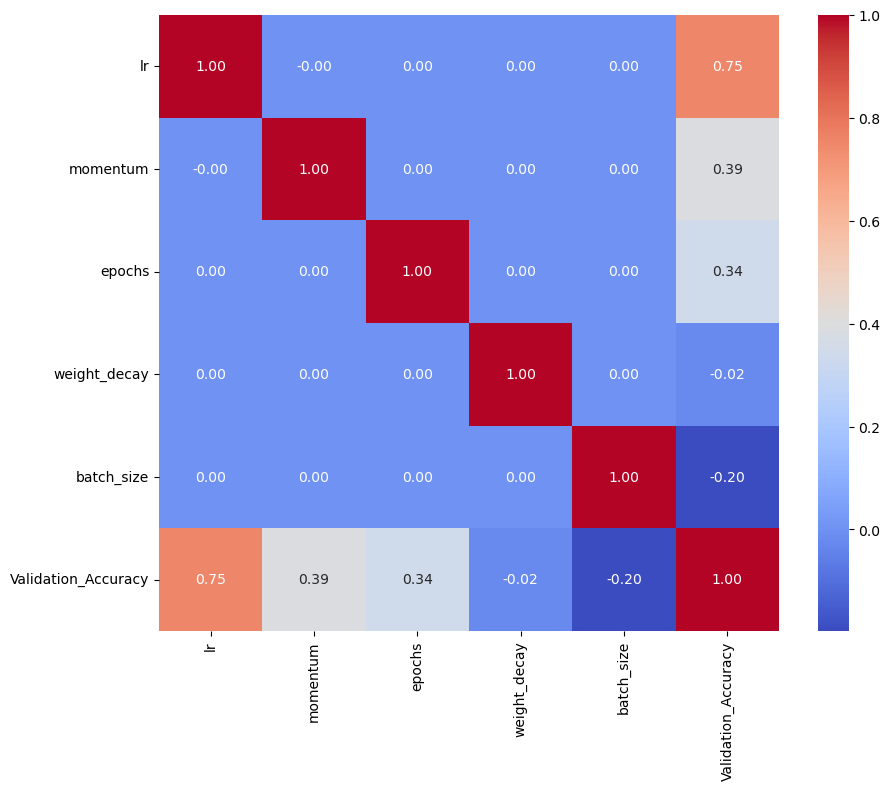

In [228]:
# Looking at output of grid search 

correlation_matrix = df.corr()

#  heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()


In [229]:
# drop weight_decay absoulte value of pearson corr with DV is only .02
df = df.drop(columns=['weight_decay'])

## Regression analysis of hyperparameters and validation accuracy for Mobilenet

In [232]:
import pandas as pd
import statsmodels.api as sm

# https://www.statsmodels.org/0.6.1/examples/notebooks/generated/interactions_anova.html
#https://www.pythonfordatascience.org/factorial-anova-python/


#df = pd.read_csv(csv_file_path)
print(df.head()) 
X = df.drop('Validation_Accuracy', axis=1)  # Independent variables
y = df['Validation_Accuracy']  # Dependent variable
X=X.astype(float)

      lr momentum epochs batch_size  Validation_Accuracy
0  0.001      0.8     20         16             0.834783
1  0.001      0.8     20         32             0.800000
2  0.001      0.8     20         16             0.852174
3  0.001      0.8     20         32             0.800000
4  0.001      0.8     75         16             0.834783


In [235]:

# https://www.statsmodels.org/0.6.1/examples/notebooks/generated/interactions_anova.html
#https://www.pythonfordatascience.org/factorial-anova-python/

X = df.drop('Validation_Accuracy', axis=1)  # Independent variables
y = df['Validation_Accuracy']  # Dependent variable
X=X.astype(float)
# Fit the regression model
#model = sm.OLS(y, X).fit()

# Get the summary of the regression
#print(model.summary())

# To get standardized coefficients, you can standardize your features before fitting the model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Note: Do not standardize the constant (intercept) term
X_scaled = sm.add_constant(X_scaled)

# Fit the regression model on the standardized features
model_standardized = sm.OLS(y, X_scaled).fit()

# Get the summary of the regression with standardized coefficients
print(model_standardized.summary())   

                             OLS Regression Results                            
Dep. Variable:     Validation_Accuracy   R-squared:                       0.876
Model:                             OLS   Adj. R-squared:                  0.865
Method:                  Least Squares   F-statistic:                     76.28
Date:                 Fri, 05 Apr 2024   Prob (F-statistic):           5.88e-19
Time:                         20:22:56   Log-Likelihood:                 104.47
No. Observations:                   48   AIC:                            -198.9
Df Residuals:                       43   BIC:                            -189.6
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8045      0.004    192.20

In [234]:
import pandas as pd
import statsmodels.api as sm

# https://www.statsmodels.org/0.6.1/examples/notebooks/generated/interactions_anova.html
#https://www.pythonfordatascience.org/factorial-anova-python/


#df = pd.read_csv(csv_file_path)
print(df.head())
# Separate the features (X) and the target (y)
# Assuming 'Validation_Accuracy' is the name of the column you want to predict
X = df.drop('Validation_Accuracy', axis=1)  # Independent variables
y = df['Validation_Accuracy']  # Dependent variable

# To get standardized coefficients, you can standardize your features before fitting the model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Note: Do not standardize the constant (intercept) term
X_scaled = sm.add_constant(X_scaled)

# Fit the regression model on the standardized features
model_standardized = sm.OLS(y, X_scaled).fit()

# Get the summary of the regression with standardized coefficients
print(model_standardized.summary())

      lr momentum epochs batch_size  Validation_Accuracy
0  0.001      0.8     20         16             0.834783
1  0.001      0.8     20         32             0.800000
2  0.001      0.8     20         16             0.852174
3  0.001      0.8     20         32             0.800000
4  0.001      0.8     75         16             0.834783
                             OLS Regression Results                            
Dep. Variable:     Validation_Accuracy   R-squared:                       0.876
Model:                             OLS   Adj. R-squared:                  0.865
Method:                  Least Squares   F-statistic:                     76.28
Date:                 Fri, 05 Apr 2024   Prob (F-statistic):           5.88e-19
Time:                         20:21:09   Log-Likelihood:                 104.47
No. Observations:                   48   AIC:                            -198.9
Df Residuals:                       43   BIC:                            -189.6
Df Model:         

## Factorial ANOVA analysis of hyperparameters and validation accuracy for Mobilenet

In [244]:
#https://www.pythonfordatascience.org/factorial-anova-python/
from statsmodels.formula.api import ols
print("Main effects using type 3 sum of squares to show effect with other IVs already accounted for.")
print("C(x, Sum) notation for type 3 SS") 
#model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum) +   C(weight_decay, Sum) + C(batch_size, Sum)", data=df).fit()
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum)  + C(batch_size, Sum)", data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
print(aov_table) 

Main effects using type 3 sum of squares to show effect with other IVs already accounted for.
C(x, Sum) notation for type 3 SS
                       sum_sq    df             F        PR(>F)
Intercept           31.068811   1.0  36603.809191  2.146311e-63
C(lr, Sum)           0.166391   1.0    196.034026  2.025857e-17
C(momentum, Sum)     0.045315   2.0     26.694034  3.302630e-08
C(epochs, Sum)       0.034041   1.0     40.105082  1.318172e-07
C(batch_size, Sum)   0.011382   1.0     13.409191  6.949601e-04
Residual             0.035649  42.0           NaN           NaN



## lr, momentum, epochs, and batch_size all significantly contribute to accuracy

In [246]:
from statsmodels.formula.api import ols

#model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum) +   C(weight_decay, Sum) + C(batch_size, Sum)", data=df).fit()
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum)  + C(batch_size, Sum)", data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
aov_table
#model = ols("Validation_Accuracy ~ lr +  momentum + epochs + (batch_size, Sum)", data=df).fit()
         #   C(weight_decay, Sum)*C(chemical, Sum)*C(method, Sum)", data=df).fit()
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum)  + C(batch_size, Sum)", data=df).fit()
         #   C(weight_decay, Sum)*C(chemical, Sum)*C(method, Sum)", data=df).fit()
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum)  + C(batch_size, Sum) + \
            C(lr, Sum) * C(epochs, Sum)  \
           + C(epochs, Sum) * C(batch_size, Sum) \
            ", data=df).fit()
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum)  + C(batch_size, Sum) + \
            C(lr, Sum) * C(epochs, Sum)  \
           + C(lr, Sum) * C(batch_size, Sum) \
            ", data=df).fit()
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum)  + C(batch_size, Sum) + \
            C(lr, Sum) * C(epochs, Sum)  \
           + C(lr, Sum) * C(momentum, Sum) ", data=df).fit()
# C(lr, Sum) * C(momentum, Sum) \ p=.0877            
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum)  + C(batch_size, Sum) + \
            C(lr, Sum) * C(epochs, Sum)  \
           + C(batch_size, Sum) * C(momentum, Sum)  ", data=df).fit()
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum)  + C(batch_size, Sum) + \
            C(lr, Sum) * C(epochs, Sum)  \
           + C(epochs, Sum) * C(momentum, Sum)  ", data=df).fit()
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum)  + C(batch_size, Sum) + \
            C(lr, Sum) * C(epochs, Sum)  \
            ", data=df).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

sum_sq    df             F        PR(>F)
Intercept                  31.068811   1.0  61161.918236  1.062379e-66
C(lr, Sum)                  0.166391   1.0    327.556539  3.681189e-21
C(momentum, Sum)            0.045315   2.0     44.603510  5.153045e-11
C(epochs, Sum)              0.034041   1.0     67.012253  3.685091e-10
C(batch_size, Sum)          0.011382   1.0     22.405643  2.632264e-05
C(lr, Sum):C(epochs, Sum)   0.014822   1.0     29.178504  3.055817e-06
Residual                    0.020827  41.0           NaN           NaN

## Only interaction found significant after main effects was learning rate with epochs

## Graphical display of interaction found for hyperparameters epochs and learning rate for validation accuracy of Mobilenet

# Learning rate of .0001 has a bigger increase in accuracy with more epochs, than learning rate .001

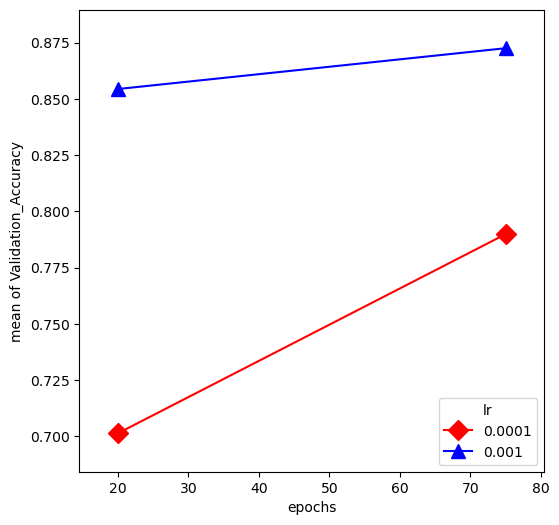

In [247]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/categorical_interaction_plot.html

from statsmodels.graphics.factorplots import interaction_plot

fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(
    x=df['epochs'],
    trace=df['lr'],
    response=df['Validation_Accuracy'],
    colors=["red", "blue"],
    markers=["D", "^"],
    ms=10,
    ax=ax,
)

In [1]:
##########################################################################

## Investigating additional hyperparameters for Resnet18

In [239]:
# make_plots=0
# Looking at epochs for mobilenet
# use with plot as see when loss starts to level off
model_name = 'resnet18'
param_grid = {
        'lr': [.001, .0001],
        'momentum': [.9,.95],
        'epochs': [20,75],
        'weight_decay': [.0, .0001],  
        'optimizer': ['SGD'],  
        'batch_size': [16,32]  
    }
# this is corrected to params_resnet18_SGD in the cell below.   
params_resnet18_SGD = test_model_parameters(model_name, param_grid, train_dataset, valid_dataset, device, 
                                            valid_ds_name = 'Validation',
                                            to_print=1, make_plots=0, write_csv=1, return_type='results_df')

start time:  2024_04_08_1242
resnet18
Model number:  1  current_params:  {'lr': 0.001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}
Epoch 1/20:
Train Loss: 0.5509, Train Accuracy: 0.6986
Validation Loss: 0.5181 Validation Accuracy: 0.7913
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.3710, Train Accuracy: 0.8357
Validation Loss: 0.6072 Validation Accuracy: 0.7739
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.1967, Train Accuracy: 0.9336
Validation Loss: 0.8723 Validation Accuracy: 0.6957
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.1538, Train Accuracy: 0.9336
Validation Loss: 0.5062 Validation Accuracy: 0.8783
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.0719, Train Accuracy: 0.9706
Validation Loss: 0.4055 Validation Accuracy: 0.9043
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0313, Train Accuracy: 0.9924
Validation Loss: 0.3976 Validation Accuracy: 0.8870
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.0445, Train Accuracy: 0.9848
Validation Loss: 0.5171 

Validation Loss: 0.5613 Validation Accuracy: 0.8696
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.0364, Train Accuracy: 0.9848
Validation Loss: 0.6267 Validation Accuracy: 0.8609
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.0318, Train Accuracy: 0.9902
Validation Loss: 0.7142 Validation Accuracy: 0.8609
Finished Epoch 12
Epoch 13/20:
Train Loss: 0.0211, Train Accuracy: 0.9913
Validation Loss: 0.6139 Validation Accuracy: 0.8696
Finished Epoch 13
Epoch 14/20:
Train Loss: 0.0161, Train Accuracy: 0.9935
Validation Loss: 0.6671 Validation Accuracy: 0.8435
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.0136, Train Accuracy: 0.9978
Validation Loss: 0.7589 Validation Accuracy: 0.8783
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.0289, Train Accuracy: 0.9913
Validation Loss: 0.6776 Validation Accuracy: 0.8609
Finished Epoch 16
Epoch 17/20:
Train Loss: 0.0120, Train Accuracy: 0.9956
Validation Loss: 0.6771 Validation Accuracy: 0.8696
Finished Epoch 17
Epoch 18/20:
Train Loss: 0.0094, Train Accuracy:

Validation Loss: 0.4650 Validation Accuracy: 0.9043
Finished Epoch 9
Epoch 10/75:
Train Loss: 0.0154, Train Accuracy: 0.9967
Validation Loss: 0.4146 Validation Accuracy: 0.9043
Finished Epoch 10
Epoch 11/75:
Train Loss: 0.0192, Train Accuracy: 0.9935
Validation Loss: 0.5300 Validation Accuracy: 0.8696
Finished Epoch 11
Epoch 12/75:
Train Loss: 0.0309, Train Accuracy: 0.9869
Validation Loss: 0.4779 Validation Accuracy: 0.8696
Finished Epoch 12
Epoch 13/75:
Train Loss: 0.0163, Train Accuracy: 0.9956
Validation Loss: 0.5404 Validation Accuracy: 0.8870
Finished Epoch 13
Epoch 14/75:
Train Loss: 0.0095, Train Accuracy: 0.9989
Validation Loss: 0.5220 Validation Accuracy: 0.9130
Finished Epoch 14
Epoch 15/75:
Train Loss: 0.0230, Train Accuracy: 0.9891
Validation Loss: 0.5387 Validation Accuracy: 0.8609
Finished Epoch 15
Epoch 16/75:
Train Loss: 0.0779, Train Accuracy: 0.9761
Validation Loss: 0.6454 Validation Accuracy: 0.8609
Finished Epoch 16
Epoch 17/75:
Train Loss: 0.0526, Train Accuracy: 

Epoch 75/75:
Train Loss: 0.0016, Train Accuracy: 0.9989
Validation Loss: 0.7351 Validation Accuracy: 0.8957
Finished Epoch 75
Finished Training model number:  5
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 89.57%
Precision: 0.90
Recall: 0.90
F1 Score: 0.89
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'resnet18', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8434782608695652, 'valid_precision': 0.8448160535117057, 'valid_recall': 0.8434782608695652, 'valid_f1': 0.843889650721949}, "{'lr': 0.001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 32}": {'model_name': 'resnet18', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8695652173913043, 'valid_p

Epoch 48/75:
Train Loss: 0.0043, Train Accuracy: 1.0000
Validation Loss: 0.5698 Validation Accuracy: 0.8870
Finished Epoch 48
Epoch 49/75:
Train Loss: 0.0009, Train Accuracy: 1.0000
Validation Loss: 0.5420 Validation Accuracy: 0.8783
Finished Epoch 49
Epoch 50/75:
Train Loss: 0.0027, Train Accuracy: 0.9989
Validation Loss: 0.5579 Validation Accuracy: 0.8783
Finished Epoch 50
Epoch 51/75:
Train Loss: 0.0024, Train Accuracy: 1.0000
Validation Loss: 0.5727 Validation Accuracy: 0.8783
Finished Epoch 51
Epoch 52/75:
Train Loss: 0.0011, Train Accuracy: 1.0000
Validation Loss: 0.6005 Validation Accuracy: 0.8870
Finished Epoch 52
Epoch 53/75:
Train Loss: 0.0009, Train Accuracy: 1.0000
Validation Loss: 0.5652 Validation Accuracy: 0.8870
Finished Epoch 53
Epoch 54/75:
Train Loss: 0.0016, Train Accuracy: 1.0000
Validation Loss: 0.6047 Validation Accuracy: 0.8957
Finished Epoch 54
Epoch 55/75:
Train Loss: 0.0012, Train Accuracy: 1.0000
Validation Loss: 0.6010 Validation Accuracy: 0.8870
Finished E

Epoch 18/75:
Train Loss: 0.0285, Train Accuracy: 0.9880
Validation Loss: 0.6422 Validation Accuracy: 0.8696
Finished Epoch 18
Epoch 19/75:
Train Loss: 0.0121, Train Accuracy: 0.9978
Validation Loss: 0.8388 Validation Accuracy: 0.8435
Finished Epoch 19
Epoch 20/75:
Train Loss: 0.0085, Train Accuracy: 0.9989
Validation Loss: 0.7027 Validation Accuracy: 0.8609
Finished Epoch 20
Epoch 21/75:
Train Loss: 0.0088, Train Accuracy: 0.9967
Validation Loss: 0.6824 Validation Accuracy: 0.8783
Finished Epoch 21
Epoch 22/75:
Train Loss: 0.0170, Train Accuracy: 0.9946
Validation Loss: 0.6217 Validation Accuracy: 0.8957
Finished Epoch 22
Epoch 23/75:
Train Loss: 0.0204, Train Accuracy: 0.9935
Validation Loss: 0.6815 Validation Accuracy: 0.8783
Finished Epoch 23
Epoch 24/75:
Train Loss: 0.0371, Train Accuracy: 0.9891
Validation Loss: 0.6645 Validation Accuracy: 0.8783
Finished Epoch 24
Epoch 25/75:
Train Loss: 0.0087, Train Accuracy: 0.9967
Validation Loss: 0.9279 Validation Accuracy: 0.8522
Finished E

Epoch 1/75:
Train Loss: 0.5955, Train Accuracy: 0.6801
Validation Loss: 0.5816 Validation Accuracy: 0.7217
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.3810, Train Accuracy: 0.8357
Validation Loss: 0.4317 Validation Accuracy: 0.8000
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.2659, Train Accuracy: 0.8977
Validation Loss: 0.4106 Validation Accuracy: 0.8261
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.1614, Train Accuracy: 0.9489
Validation Loss: 0.4425 Validation Accuracy: 0.8609
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.0951, Train Accuracy: 0.9815
Validation Loss: 0.4560 Validation Accuracy: 0.8609
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.0422, Train Accuracy: 0.9978
Validation Loss: 0.4509 Validation Accuracy: 0.8783
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.0270, Train Accuracy: 1.0000
Validation Loss: 0.4427 Validation Accuracy: 0.8696
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0257, Train Accuracy: 1.0000
Validation Loss: 0.4735 Validation Accuracy: 0.8696
Finished Epoch 8
Epoch 9/

Validation Loss: 0.6184 Validation Accuracy: 0.8870
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0005, Train Accuracy: 1.0000
Validation Loss: 0.6262 Validation Accuracy: 0.8870
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0005, Train Accuracy: 1.0000
Validation Loss: 0.6359 Validation Accuracy: 0.8870
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0004, Train Accuracy: 1.0000
Validation Loss: 0.6311 Validation Accuracy: 0.8870
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0004, Train Accuracy: 1.0000
Validation Loss: 0.6290 Validation Accuracy: 0.8870
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.6255 Validation Accuracy: 0.8870
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0004, Train Accuracy: 1.0000
Validation Loss: 0.6304 Validation Accuracy: 0.8870
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0005, Train Accuracy: 1.0000
Validation Loss: 0.6348 Validation Accuracy: 0.8870
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0003, Train Accuracy:

Epoch 1/20:
Train Loss: 0.5916, Train Accuracy: 0.6931
Validation Loss: 0.5794 Validation Accuracy: 0.7217
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.3673, Train Accuracy: 0.8303
Validation Loss: 0.5719 Validation Accuracy: 0.7391
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.2376, Train Accuracy: 0.9042
Validation Loss: 0.4365 Validation Accuracy: 0.8522
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.1403, Train Accuracy: 0.9412
Validation Loss: 0.5696 Validation Accuracy: 0.8000
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.0752, Train Accuracy: 0.9750
Validation Loss: 0.4970 Validation Accuracy: 0.8783
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0311, Train Accuracy: 0.9924
Validation Loss: 0.4772 Validation Accuracy: 0.9043
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.0201, Train Accuracy: 0.9967
Validation Loss: 0.4545 Validation Accuracy: 0.9043
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.0181, Train Accuracy: 0.9935
Validation Loss: 0.4571 Validation Accuracy: 0.8957
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5139 Validation Accuracy: 0.9043
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.0213, Train Accuracy: 0.9924
Validation Loss: 0.4358 Validation Accuracy: 0.9043
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.1091, Train Accuracy: 0.9717
Validation Loss: 0.5486 Validation Accuracy: 0.8696
Finished Epoch 16
Epoch 17/20:
Train Loss: 0.0798, Train Accuracy: 0.9706
Validation Loss: 0.7639 Validation Accuracy: 0.8696
Finished Epoch 17
Epoch 18/20:
Train Loss: 0.0276, Train Accuracy: 0.9891
Validation Loss: 0.5620 Validation Accuracy: 0.8609
Finished Epoch 18
Epoch 19/20:
Train Loss: 0.0283, Train Accuracy: 0.9902
Validation Loss: 0.5649 Validation Accuracy: 0.8609
Finished Epoch 19
Epoch 20/20:
Train Loss: 0.0327, Train Accuracy: 0.9837
Validation Loss: 0.5631 Validation Accuracy: 0.8435
Finished Epoch 20
Finished Training model number:  11
TRAINING data results:
Accuracy: 99.67%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 84.35%
Precision: 0

Epoch 1/75:
Train Loss: 0.5491, Train Accuracy: 0.6986
Validation Loss: 0.4895 Validation Accuracy: 0.7739
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.3871, Train Accuracy: 0.8281
Validation Loss: 0.4581 Validation Accuracy: 0.8000
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.2737, Train Accuracy: 0.9064
Validation Loss: 0.9651 Validation Accuracy: 0.7217
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.2582, Train Accuracy: 0.9053
Validation Loss: 0.5614 Validation Accuracy: 0.8261
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.1708, Train Accuracy: 0.9434
Validation Loss: 0.5666 Validation Accuracy: 0.8261
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.0845, Train Accuracy: 0.9608
Validation Loss: 0.4545 Validation Accuracy: 0.8783
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.0755, Train Accuracy: 0.9695
Validation Loss: 0.6134 Validation Accuracy: 0.8435
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0681, Train Accuracy: 0.9750
Validation Loss: 0.3466 Validation Accuracy: 0.9217
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4665 Validation Accuracy: 0.8957
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0030, Train Accuracy: 0.9989
Validation Loss: 0.5049 Validation Accuracy: 0.8609
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0070, Train Accuracy: 0.9956
Validation Loss: 0.4646 Validation Accuracy: 0.9130
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0028, Train Accuracy: 0.9989
Validation Loss: 0.4500 Validation Accuracy: 0.9217
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0010, Train Accuracy: 1.0000
Validation Loss: 0.4505 Validation Accuracy: 0.9130
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0006, Train Accuracy: 1.0000
Validation Loss: 0.4532 Validation Accuracy: 0.9043
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Validation Loss: 0.5510 Validation Accuracy: 0.9130
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0073, Train Accuracy: 0.9978
Validation Loss: 0.8067 Validation Accuracy: 0.8696
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0238, Train Accuracy:

Validation Loss: 0.4726 Validation Accuracy: 0.9043
Finished Epoch 15
Epoch 16/75:
Train Loss: 0.0032, Train Accuracy: 1.0000
Validation Loss: 0.5069 Validation Accuracy: 0.9043
Finished Epoch 16
Epoch 17/75:
Train Loss: 0.0012, Train Accuracy: 1.0000
Validation Loss: 0.5083 Validation Accuracy: 0.9130
Finished Epoch 17
Epoch 18/75:
Train Loss: 0.0013, Train Accuracy: 1.0000
Validation Loss: 0.5290 Validation Accuracy: 0.9130
Finished Epoch 18
Epoch 19/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Validation Loss: 0.5446 Validation Accuracy: 0.9043
Finished Epoch 19
Epoch 20/75:
Train Loss: 0.0015, Train Accuracy: 1.0000
Validation Loss: 0.5209 Validation Accuracy: 0.9043
Finished Epoch 20
Epoch 21/75:
Train Loss: 0.0014, Train Accuracy: 1.0000
Validation Loss: 0.5778 Validation Accuracy: 0.9043
Finished Epoch 21
Epoch 22/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Validation Loss: 0.5596 Validation Accuracy: 0.9043
Finished Epoch 22
Epoch 23/75:
Train Loss: 0.0009, Train Accuracy:

Epoch 1/75:
Train Loss: 0.5331, Train Accuracy: 0.7106
Validation Loss: 0.5268 Validation Accuracy: 0.7565
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.3773, Train Accuracy: 0.8313
Validation Loss: 0.6353 Validation Accuracy: 0.7304
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.2779, Train Accuracy: 0.8868
Validation Loss: 1.4353 Validation Accuracy: 0.6870
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.3289, Train Accuracy: 0.8879
Validation Loss: 0.8136 Validation Accuracy: 0.6870
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.1758, Train Accuracy: 0.9314
Validation Loss: 0.6078 Validation Accuracy: 0.8435
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.1216, Train Accuracy: 0.9576
Validation Loss: 0.5769 Validation Accuracy: 0.8522
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.1185, Train Accuracy: 0.9510
Validation Loss: 0.5932 Validation Accuracy: 0.8435
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0868, Train Accuracy: 0.9641
Validation Loss: 0.5576 Validation Accuracy: 0.8696
Finished Epoch 8
Epoch 9/

Validation Loss: 0.7177 Validation Accuracy: 0.8783
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0004, Train Accuracy: 1.0000
Validation Loss: 0.7061 Validation Accuracy: 0.8957
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0017, Train Accuracy: 1.0000
Validation Loss: 0.7738 Validation Accuracy: 0.8609
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0013, Train Accuracy: 0.9989
Validation Loss: 0.7269 Validation Accuracy: 0.8957
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.7113 Validation Accuracy: 0.8957
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0001, Train Accuracy: 1.0000
Validation Loss: 0.7301 Validation Accuracy: 0.8957
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.7474 Validation Accuracy: 0.8783
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0009, Train Accuracy: 1.0000
Validation Loss: 0.7525 Validation Accuracy: 0.9043
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0002, Train Accuracy:

Validation Loss: 0.4669 Validation Accuracy: 0.9130
Finished Epoch 9
Epoch 10/75:
Train Loss: 0.0037, Train Accuracy: 1.0000
Validation Loss: 0.4925 Validation Accuracy: 0.9130
Finished Epoch 10
Epoch 11/75:
Train Loss: 0.0049, Train Accuracy: 0.9989
Validation Loss: 0.4928 Validation Accuracy: 0.9217
Finished Epoch 11
Epoch 12/75:
Train Loss: 0.0057, Train Accuracy: 0.9989
Validation Loss: 0.6163 Validation Accuracy: 0.8783
Finished Epoch 12
Epoch 13/75:
Train Loss: 0.0027, Train Accuracy: 1.0000
Validation Loss: 0.5008 Validation Accuracy: 0.8957
Finished Epoch 13
Epoch 14/75:
Train Loss: 0.0019, Train Accuracy: 1.0000
Validation Loss: 0.5160 Validation Accuracy: 0.9130
Finished Epoch 14
Epoch 15/75:
Train Loss: 0.0013, Train Accuracy: 1.0000
Validation Loss: 0.4952 Validation Accuracy: 0.9043
Finished Epoch 15
Epoch 16/75:
Train Loss: 0.0033, Train Accuracy: 1.0000
Validation Loss: 0.5330 Validation Accuracy: 0.9043
Finished Epoch 16
Epoch 17/75:
Train Loss: 0.0011, Train Accuracy: 

Epoch 75/75:
Train Loss: 0.0020, Train Accuracy: 0.9989
Validation Loss: 0.7321 Validation Accuracy: 0.8783
Finished Epoch 75
Finished Training model number:  16
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 87.83%
Precision: 0.88
Recall: 0.88
F1 Score: 0.88
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'resnet18', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8434782608695652, 'valid_precision': 0.8448160535117057, 'valid_recall': 0.8434782608695652, 'valid_f1': 0.843889650721949}, "{'lr': 0.001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 32}": {'model_name': 'resnet18', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8695652173913043, 'valid_

Validation Loss: 0.4116 Validation Accuracy: 0.8696
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.1611, Train Accuracy: 0.9587
Validation Loss: 0.4089 Validation Accuracy: 0.8348
Finished Epoch 16
Epoch 17/20:
Train Loss: 0.1089, Train Accuracy: 0.9848
Validation Loss: 0.4086 Validation Accuracy: 0.8435
Finished Epoch 17
Epoch 18/20:
Train Loss: 0.1086, Train Accuracy: 0.9771
Validation Loss: 0.3896 Validation Accuracy: 0.8696
Finished Epoch 18
Epoch 19/20:
Train Loss: 0.0932, Train Accuracy: 0.9859
Validation Loss: 0.3890 Validation Accuracy: 0.8609
Finished Epoch 19
Epoch 20/20:
Train Loss: 0.0877, Train Accuracy: 0.9848
Validation Loss: 0.4236 Validation Accuracy: 0.8696
Finished Epoch 20
Finished Training model number:  17
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 86.96%
Precision: 0.87
Recall: 0.87
F1 Score: 0.87
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.9, 'epochs': 20, 'weight_

Epoch 8/20:
Train Loss: 0.3982, Train Accuracy: 0.8662
Validation Loss: 0.4822 Validation Accuracy: 0.7739
Finished Epoch 8
Epoch 9/20:
Train Loss: 0.3693, Train Accuracy: 0.8879
Validation Loss: 0.4722 Validation Accuracy: 0.7652
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.3428, Train Accuracy: 0.9042
Validation Loss: 0.4565 Validation Accuracy: 0.7913
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.3226, Train Accuracy: 0.9021
Validation Loss: 0.4518 Validation Accuracy: 0.7826
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.3114, Train Accuracy: 0.9097
Validation Loss: 0.4467 Validation Accuracy: 0.7913
Finished Epoch 12
Epoch 13/20:
Train Loss: 0.2869, Train Accuracy: 0.9227
Validation Loss: 0.4348 Validation Accuracy: 0.8174
Finished Epoch 13
Epoch 14/20:
Train Loss: 0.2744, Train Accuracy: 0.9217
Validation Loss: 0.4265 Validation Accuracy: 0.8261
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.2549, Train Accuracy: 0.9380
Validation Loss: 0.4200 Validation Accuracy: 0.8348
Finished Epoch

Epoch 1/20:
Train Loss: 0.6445, Train Accuracy: 0.6257
Validation Loss: 0.6199 Validation Accuracy: 0.6870
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5474, Train Accuracy: 0.7258
Validation Loss: 0.5959 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.4865, Train Accuracy: 0.7922
Validation Loss: 0.5466 Validation Accuracy: 0.7478
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.4626, Train Accuracy: 0.8107
Validation Loss: 0.5210 Validation Accuracy: 0.8000
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4021, Train Accuracy: 0.8487
Validation Loss: 0.4941 Validation Accuracy: 0.8000
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.3557, Train Accuracy: 0.8836
Validation Loss: 0.4639 Validation Accuracy: 0.8087
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.3365, Train Accuracy: 0.8738
Validation Loss: 0.4584 Validation Accuracy: 0.8087
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.3119, Train Accuracy: 0.9032
Validation Loss: 0.4493 Validation Accuracy: 0.8348
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6709, Train Accuracy: 0.6061
Validation Loss: 0.6542 Validation Accuracy: 0.6435
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5894, Train Accuracy: 0.6790
Validation Loss: 0.5927 Validation Accuracy: 0.7130
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5427, Train Accuracy: 0.7225
Validation Loss: 0.5667 Validation Accuracy: 0.6957
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5182, Train Accuracy: 0.7617
Validation Loss: 0.5437 Validation Accuracy: 0.7130
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4709, Train Accuracy: 0.8226
Validation Loss: 0.5275 Validation Accuracy: 0.7565
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.4415, Train Accuracy: 0.8455
Validation Loss: 0.5065 Validation Accuracy: 0.7652
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4186, Train Accuracy: 0.8607
Validation Loss: 0.4923 Validation Accuracy: 0.7826
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.3975, Train Accuracy: 0.8662
Validation Loss: 0.4850 Validation Accuracy: 0.7739
Finished Epoch 8
Epoch 9/

Epoch 1/75:
Train Loss: 0.6444, Train Accuracy: 0.6289
Validation Loss: 0.6235 Validation Accuracy: 0.6783
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5467, Train Accuracy: 0.7247
Validation Loss: 0.5932 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.4846, Train Accuracy: 0.7878
Validation Loss: 0.5469 Validation Accuracy: 0.7478
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.4611, Train Accuracy: 0.8161
Validation Loss: 0.5197 Validation Accuracy: 0.7913
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.3995, Train Accuracy: 0.8487
Validation Loss: 0.4944 Validation Accuracy: 0.7913
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.3551, Train Accuracy: 0.8857
Validation Loss: 0.4736 Validation Accuracy: 0.7913
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.3357, Train Accuracy: 0.8705
Validation Loss: 0.4529 Validation Accuracy: 0.8087
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.3112, Train Accuracy: 0.9042
Validation Loss: 0.4411 Validation Accuracy: 0.8261
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4429 Validation Accuracy: 0.8783
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0095, Train Accuracy: 1.0000
Validation Loss: 0.4345 Validation Accuracy: 0.8783
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0143, Train Accuracy: 0.9978
Validation Loss: 0.4585 Validation Accuracy: 0.8870
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0110, Train Accuracy: 0.9978
Validation Loss: 0.4397 Validation Accuracy: 0.8783
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0092, Train Accuracy: 1.0000
Validation Loss: 0.4403 Validation Accuracy: 0.8522
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0073, Train Accuracy: 1.0000
Validation Loss: 0.4722 Validation Accuracy: 0.8696
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0073, Train Accuracy: 1.0000
Validation Loss: 0.4564 Validation Accuracy: 0.8696
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0180, Train Accuracy: 0.9935
Validation Loss: 0.4311 Validation Accuracy: 0.8870
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0087, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6710, Train Accuracy: 0.6039
Validation Loss: 0.6543 Validation Accuracy: 0.6522
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5888, Train Accuracy: 0.6757
Validation Loss: 0.5970 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5426, Train Accuracy: 0.7225
Validation Loss: 0.5666 Validation Accuracy: 0.6957
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.5179, Train Accuracy: 0.7552
Validation Loss: 0.5449 Validation Accuracy: 0.7304
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4708, Train Accuracy: 0.8215
Validation Loss: 0.5295 Validation Accuracy: 0.7478
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.4420, Train Accuracy: 0.8433
Validation Loss: 0.5096 Validation Accuracy: 0.7652
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.4192, Train Accuracy: 0.8607
Validation Loss: 0.4926 Validation Accuracy: 0.7739
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.3978, Train Accuracy: 0.8640
Validation Loss: 0.4839 Validation Accuracy: 0.7739
Finished Epoch 8
Epoch 9/

Validation Loss: 0.3859 Validation Accuracy: 0.8957
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0192, Train Accuracy: 1.0000
Validation Loss: 0.3928 Validation Accuracy: 0.9043
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0194, Train Accuracy: 1.0000
Validation Loss: 0.3982 Validation Accuracy: 0.9043
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0184, Train Accuracy: 1.0000
Validation Loss: 0.3943 Validation Accuracy: 0.8870
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0174, Train Accuracy: 1.0000
Validation Loss: 0.3891 Validation Accuracy: 0.8870
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0156, Train Accuracy: 1.0000
Validation Loss: 0.3948 Validation Accuracy: 0.8870
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0159, Train Accuracy: 1.0000
Validation Loss: 0.3912 Validation Accuracy: 0.8870
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0170, Train Accuracy: 1.0000
Validation Loss: 0.4096 Validation Accuracy: 0.8957
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0148, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6438, Train Accuracy: 0.6268
Validation Loss: 0.6191 Validation Accuracy: 0.6696
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5473, Train Accuracy: 0.7203
Validation Loss: 0.6055 Validation Accuracy: 0.6957
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.4879, Train Accuracy: 0.7845
Validation Loss: 0.5496 Validation Accuracy: 0.7391
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.4641, Train Accuracy: 0.8052
Validation Loss: 0.5162 Validation Accuracy: 0.8087
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4015, Train Accuracy: 0.8531
Validation Loss: 0.4925 Validation Accuracy: 0.8000
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.3544, Train Accuracy: 0.8803
Validation Loss: 0.4641 Validation Accuracy: 0.7826
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.3370, Train Accuracy: 0.8749
Validation Loss: 0.4494 Validation Accuracy: 0.8174
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.3118, Train Accuracy: 0.9010
Validation Loss: 0.4450 Validation Accuracy: 0.8261
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4520 Validation Accuracy: 0.8870
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0093, Train Accuracy: 1.0000
Validation Loss: 0.4440 Validation Accuracy: 0.8957
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0143, Train Accuracy: 0.9978
Validation Loss: 0.4602 Validation Accuracy: 0.8957
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0113, Train Accuracy: 0.9978
Validation Loss: 0.4518 Validation Accuracy: 0.8870
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0095, Train Accuracy: 1.0000
Validation Loss: 0.4675 Validation Accuracy: 0.8783
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0071, Train Accuracy: 1.0000
Validation Loss: 0.4775 Validation Accuracy: 0.8696
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0075, Train Accuracy: 1.0000
Validation Loss: 0.4656 Validation Accuracy: 0.8870
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0172, Train Accuracy: 0.9935
Validation Loss: 0.4478 Validation Accuracy: 0.8957
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0082, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6709, Train Accuracy: 0.6039
Validation Loss: 0.6541 Validation Accuracy: 0.6522
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5892, Train Accuracy: 0.6779
Validation Loss: 0.5944 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5424, Train Accuracy: 0.7203
Validation Loss: 0.5674 Validation Accuracy: 0.6957
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.5182, Train Accuracy: 0.7584
Validation Loss: 0.5469 Validation Accuracy: 0.7304
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4711, Train Accuracy: 0.8194
Validation Loss: 0.5306 Validation Accuracy: 0.7391
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.4424, Train Accuracy: 0.8433
Validation Loss: 0.5096 Validation Accuracy: 0.7826
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.4193, Train Accuracy: 0.8618
Validation Loss: 0.4925 Validation Accuracy: 0.7739
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.3982, Train Accuracy: 0.8651
Validation Loss: 0.4811 Validation Accuracy: 0.7652
Finished Epoch 8
Epoch 9/

Validation Loss: 0.3904 Validation Accuracy: 0.8870
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0193, Train Accuracy: 1.0000
Validation Loss: 0.3968 Validation Accuracy: 0.9043
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0195, Train Accuracy: 1.0000
Validation Loss: 0.4052 Validation Accuracy: 0.8957
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0184, Train Accuracy: 1.0000
Validation Loss: 0.4010 Validation Accuracy: 0.8870
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0174, Train Accuracy: 1.0000
Validation Loss: 0.3935 Validation Accuracy: 0.8870
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0157, Train Accuracy: 1.0000
Validation Loss: 0.3991 Validation Accuracy: 0.8957
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0158, Train Accuracy: 1.0000
Validation Loss: 0.3981 Validation Accuracy: 0.8870
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0170, Train Accuracy: 1.0000
Validation Loss: 0.4159 Validation Accuracy: 0.8957
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0148, Train Accuracy:

Epoch 1/20:
Train Loss: 0.6315, Train Accuracy: 0.6442
Validation Loss: 0.6066 Validation Accuracy: 0.7217
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5019, Train Accuracy: 0.7639
Validation Loss: 0.5636 Validation Accuracy: 0.7826
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.4106, Train Accuracy: 0.8346
Validation Loss: 0.5053 Validation Accuracy: 0.7826
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.3789, Train Accuracy: 0.8444
Validation Loss: 0.4594 Validation Accuracy: 0.8348
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.2966, Train Accuracy: 0.8945
Validation Loss: 0.4502 Validation Accuracy: 0.8087
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.2331, Train Accuracy: 0.9391
Validation Loss: 0.4222 Validation Accuracy: 0.8174
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.2088, Train Accuracy: 0.9358
Validation Loss: 0.4060 Validation Accuracy: 0.8696
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.1782, Train Accuracy: 0.9532
Validation Loss: 0.4058 Validation Accuracy: 0.8522
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6643, Train Accuracy: 0.6061
Validation Loss: 0.6464 Validation Accuracy: 0.6522
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5624, Train Accuracy: 0.7051
Validation Loss: 0.5704 Validation Accuracy: 0.7130
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.4915, Train Accuracy: 0.7748
Validation Loss: 0.5342 Validation Accuracy: 0.7565
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.4516, Train Accuracy: 0.8096
Validation Loss: 0.4922 Validation Accuracy: 0.7652
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.3909, Train Accuracy: 0.8596
Validation Loss: 0.4768 Validation Accuracy: 0.7739
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.3447, Train Accuracy: 0.8923
Validation Loss: 0.4548 Validation Accuracy: 0.8000
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.3108, Train Accuracy: 0.9053
Validation Loss: 0.4359 Validation Accuracy: 0.8174
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.2847, Train Accuracy: 0.9151
Validation Loss: 0.4279 Validation Accuracy: 0.8174
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6321, Train Accuracy: 0.6431
Validation Loss: 0.6110 Validation Accuracy: 0.7043
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.4996, Train Accuracy: 0.7661
Validation Loss: 0.5881 Validation Accuracy: 0.7391
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.4089, Train Accuracy: 0.8368
Validation Loss: 0.5039 Validation Accuracy: 0.7826
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.3736, Train Accuracy: 0.8542
Validation Loss: 0.4758 Validation Accuracy: 0.8174
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.2916, Train Accuracy: 0.8999
Validation Loss: 0.4417 Validation Accuracy: 0.8261
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.2314, Train Accuracy: 0.9402
Validation Loss: 0.4301 Validation Accuracy: 0.8261
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.2056, Train Accuracy: 0.9412
Validation Loss: 0.4108 Validation Accuracy: 0.8435
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.1735, Train Accuracy: 0.9565
Validation Loss: 0.3995 Validation Accuracy: 0.8522
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6641, Train Accuracy: 0.6072
Validation Loss: 0.6461 Validation Accuracy: 0.6609
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5625, Train Accuracy: 0.7106
Validation Loss: 0.5711 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.4915, Train Accuracy: 0.7748
Validation Loss: 0.5330 Validation Accuracy: 0.7565
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.4515, Train Accuracy: 0.8139
Validation Loss: 0.4924 Validation Accuracy: 0.7826
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.3914, Train Accuracy: 0.8596
Validation Loss: 0.4777 Validation Accuracy: 0.7739
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.3452, Train Accuracy: 0.8901
Validation Loss: 0.4559 Validation Accuracy: 0.7913
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.3117, Train Accuracy: 0.9021
Validation Loss: 0.4360 Validation Accuracy: 0.8087
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.2844, Train Accuracy: 0.9162
Validation Loss: 0.4270 Validation Accuracy: 0.8174
Finished Epoch 8
Epoch 9/

Epoch 1/75:
Train Loss: 0.6318, Train Accuracy: 0.6431
Validation Loss: 0.6060 Validation Accuracy: 0.7043
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5004, Train Accuracy: 0.7639
Validation Loss: 0.5881 Validation Accuracy: 0.7565
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.4136, Train Accuracy: 0.8368
Validation Loss: 0.5005 Validation Accuracy: 0.7826
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.3749, Train Accuracy: 0.8585
Validation Loss: 0.4691 Validation Accuracy: 0.8348
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.2931, Train Accuracy: 0.8977
Validation Loss: 0.4330 Validation Accuracy: 0.8087
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.2304, Train Accuracy: 0.9347
Validation Loss: 0.4207 Validation Accuracy: 0.8435
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.2075, Train Accuracy: 0.9412
Validation Loss: 0.4094 Validation Accuracy: 0.8609
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.1754, Train Accuracy: 0.9576
Validation Loss: 0.4117 Validation Accuracy: 0.8522
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4709 Validation Accuracy: 0.8957
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0038, Train Accuracy: 1.0000
Validation Loss: 0.4733 Validation Accuracy: 0.8957
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0092, Train Accuracy: 0.9967
Validation Loss: 0.5117 Validation Accuracy: 0.8870
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0061, Train Accuracy: 0.9989
Validation Loss: 0.5277 Validation Accuracy: 0.8870
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0045, Train Accuracy: 1.0000
Validation Loss: 0.5253 Validation Accuracy: 0.8957
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0029, Train Accuracy: 1.0000
Validation Loss: 0.5509 Validation Accuracy: 0.8783
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0028, Train Accuracy: 1.0000
Validation Loss: 0.5267 Validation Accuracy: 0.8870
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0097, Train Accuracy: 0.9967
Validation Loss: 0.5261 Validation Accuracy: 0.8870
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0033, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6641, Train Accuracy: 0.6083
Validation Loss: 0.6461 Validation Accuracy: 0.6522
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5628, Train Accuracy: 0.7062
Validation Loss: 0.5696 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.4915, Train Accuracy: 0.7769
Validation Loss: 0.5367 Validation Accuracy: 0.7391
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.4512, Train Accuracy: 0.8096
Validation Loss: 0.4959 Validation Accuracy: 0.7739
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.3909, Train Accuracy: 0.8618
Validation Loss: 0.4781 Validation Accuracy: 0.7652
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.3442, Train Accuracy: 0.8890
Validation Loss: 0.4546 Validation Accuracy: 0.8087
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.3114, Train Accuracy: 0.9021
Validation Loss: 0.4372 Validation Accuracy: 0.8087
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.2838, Train Accuracy: 0.9151
Validation Loss: 0.4261 Validation Accuracy: 0.8174
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4222 Validation Accuracy: 0.8957
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0054, Train Accuracy: 1.0000
Validation Loss: 0.4321 Validation Accuracy: 0.8957
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0056, Train Accuracy: 1.0000
Validation Loss: 0.4453 Validation Accuracy: 0.9043
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0051, Train Accuracy: 1.0000
Validation Loss: 0.4351 Validation Accuracy: 0.8957
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0048, Train Accuracy: 1.0000
Validation Loss: 0.4282 Validation Accuracy: 0.8957
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0042, Train Accuracy: 1.0000
Validation Loss: 0.4387 Validation Accuracy: 0.8957
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0045, Train Accuracy: 1.0000
Validation Loss: 0.4369 Validation Accuracy: 0.8957
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0049, Train Accuracy: 1.0000
Validation Loss: 0.4572 Validation Accuracy: 0.8957
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0041, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6317, Train Accuracy: 0.6464
Validation Loss: 0.6062 Validation Accuracy: 0.7130
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.4996, Train Accuracy: 0.7671
Validation Loss: 0.5820 Validation Accuracy: 0.7304
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.4115, Train Accuracy: 0.8303
Validation Loss: 0.5053 Validation Accuracy: 0.7739
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.3767, Train Accuracy: 0.8542
Validation Loss: 0.4781 Validation Accuracy: 0.8174
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.2945, Train Accuracy: 0.8955
Validation Loss: 0.4459 Validation Accuracy: 0.7913
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.2340, Train Accuracy: 0.9391
Validation Loss: 0.4252 Validation Accuracy: 0.8435
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.2120, Train Accuracy: 0.9391
Validation Loss: 0.3977 Validation Accuracy: 0.8783
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.1768, Train Accuracy: 0.9565
Validation Loss: 0.4116 Validation Accuracy: 0.8609
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4553 Validation Accuracy: 0.9043
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0033, Train Accuracy: 1.0000
Validation Loss: 0.4592 Validation Accuracy: 0.9043
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0084, Train Accuracy: 0.9967
Validation Loss: 0.4976 Validation Accuracy: 0.8870
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0070, Train Accuracy: 0.9978
Validation Loss: 0.4854 Validation Accuracy: 0.8870
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0044, Train Accuracy: 1.0000
Validation Loss: 0.4906 Validation Accuracy: 0.8870
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0026, Train Accuracy: 1.0000
Validation Loss: 0.5157 Validation Accuracy: 0.8870
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0026, Train Accuracy: 1.0000
Validation Loss: 0.5002 Validation Accuracy: 0.8957
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0100, Train Accuracy: 0.9967
Validation Loss: 0.5030 Validation Accuracy: 0.8957
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0043, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6641, Train Accuracy: 0.6083
Validation Loss: 0.6463 Validation Accuracy: 0.6609
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5628, Train Accuracy: 0.7040
Validation Loss: 0.5719 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.4918, Train Accuracy: 0.7758
Validation Loss: 0.5363 Validation Accuracy: 0.7565
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.4522, Train Accuracy: 0.8041
Validation Loss: 0.4939 Validation Accuracy: 0.7739
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.3911, Train Accuracy: 0.8629
Validation Loss: 0.4770 Validation Accuracy: 0.7565
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.3449, Train Accuracy: 0.8901
Validation Loss: 0.4547 Validation Accuracy: 0.8087
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.3116, Train Accuracy: 0.9021
Validation Loss: 0.4332 Validation Accuracy: 0.8087
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.2847, Train Accuracy: 0.9151
Validation Loss: 0.4290 Validation Accuracy: 0.8000
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4251 Validation Accuracy: 0.8957
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0054, Train Accuracy: 1.0000
Validation Loss: 0.4352 Validation Accuracy: 0.8957
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0056, Train Accuracy: 1.0000
Validation Loss: 0.4450 Validation Accuracy: 0.9043
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0051, Train Accuracy: 1.0000
Validation Loss: 0.4349 Validation Accuracy: 0.8870
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0048, Train Accuracy: 1.0000
Validation Loss: 0.4290 Validation Accuracy: 0.8957
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0042, Train Accuracy: 1.0000
Validation Loss: 0.4397 Validation Accuracy: 0.8957
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0045, Train Accuracy: 1.0000
Validation Loss: 0.4371 Validation Accuracy: 0.8957
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0050, Train Accuracy: 1.0000
Validation Loss: 0.4581 Validation Accuracy: 0.8957
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0041, Train Accuracy:

# Exploring output of additional hyperparameters for Resnet

In [246]:
 
#convert dictinary string column to separate columns
df =params_resnet18_SGD.drop(columns=['Model_Name' ])
df_h=pd.DataFrame()
df2=pd.DataFrame()
#initialize cols
df_h['Hyperparameters']= df['Hyperparameters'] 
df_h['lr'] = None
df_h['momentum'] = None
df_h['epochs'] = None
df_h['weight_decay'] = None
df_h['batch_size'] = None
df_h['Hyperparameters']= df['Hyperparameters'] 
i=0
for output in (df_h['Hyperparameters']):
    
    #print(i, df_h['Hyperparameters'][i])
    d= eval(df_h['Hyperparameters'][i])
    for k,v in d.items():
        #print(k,v)
        if k != 'optimizer':
            df_h[k][i]=v
    i=i+1

df_h['Validation_Accuracy'] = df['Validation_Accuracy'] 
print("Resnet18")
df = df_h.drop(columns=['Hyperparameters' ])
print(df)

Resnet18
        lr momentum epochs weight_decay batch_size  Validation_Accuracy
0    0.001      0.9     20          0.0         16             0.843478
1    0.001      0.9     20          0.0         32             0.869565
2    0.001      0.9     20       0.0001         16             0.860870
3    0.001      0.9     20       0.0001         32             0.895652
4    0.001      0.9     75          0.0         16             0.895652
5    0.001      0.9     75          0.0         32             0.895652
6    0.001      0.9     75       0.0001         16             0.886957
7    0.001      0.9     75       0.0001         32             0.878261
8    0.001     0.95     20          0.0         16             0.895652
9    0.001     0.95     20          0.0         32             0.878261
10   0.001     0.95     20       0.0001         16             0.843478
11   0.001     0.95     20       0.0001         32             0.895652
12   0.001     0.95     75          0.0         16     

# Correlation of hyperparameters with validation accuracy for Resnet

Resnet18


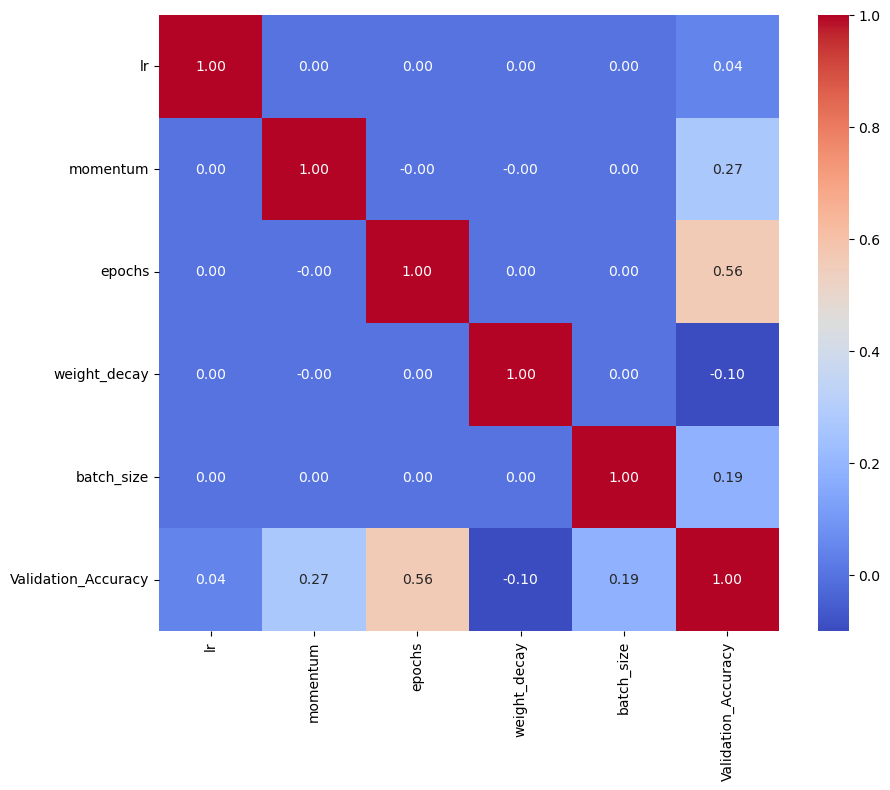

In [247]:
# Looking at output of grid search 
print("Resnet18")
correlation_matrix = df.corr()

#  heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

# Regression analysis of hyperparameters and validation accuracy for Resnet

In [282]:
print("Resnet18")

# https://www.statsmodels.org/0.6.1/examples/notebooks/generated/interactions_anova.html
#https://www.pythonfordatascience.org/factorial-anova-python/

X = df.drop('Validation_Accuracy', axis=1)  # Independent variables
y = df['Validation_Accuracy']  # Dependent variable
X=X.astype(float)
# Fit the regression model
#model = sm.OLS(y, X).fit()
x_names = X.columns
for i, var in enumerate(x_names):
    #print(i, var)
    var_table = 'x'+str(i+1)+' = ' + var
    print(var_table)
# Get the summary of the regression
#print(model.summary())

# To get standardized coefficients, you can standardize your features before fitting the model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Note: Do not standardize the constant (intercept) term
X_scaled = sm.add_constant(X_scaled)

# Fit the regression model on the standardized features
#model_standardized = sm.OLS(y, X_scaled).fit()
# https://github.com/statsmodels/statsmodels/issues/5492
model_standardized = sm.OLS(y, X_scaled).fit()
print(model_standardized.summary()) 

Resnet18
x1 = lr
x2 = momentum
x3 = epochs
x4 = weight_decay
x5 = batch_size
                             OLS Regression Results                            
Dep. Variable:     Validation_Accuracy   R-squared:                       0.434
Model:                             OLS   Adj. R-squared:                  0.325
Method:                  Least Squares   F-statistic:                     3.982
Date:                 Mon, 08 Apr 2024   Prob (F-statistic):            0.00816
Time:                         20:34:17   Log-Likelihood:                 90.602
No. Observations:                   32   AIC:                            -169.2
Df Residuals:                       26   BIC:                            -160.4
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

# Factorial ANOVA analysis of hyperparameters and validation accuracy for Resnet

In [283]:
print("Resnet18")
#https://www.pythonfordatascience.org/factorial-anova-python/
from statsmodels.formula.api import ols
print("Main effects using type 3 sum of squares to show effect with other IVs already accounted for.")
print("C(x, Sum) notation for type 3 SS") 
#model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum) +   C(weight_decay, Sum) + C(batch_size, Sum)", data=df).fit()
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum)  + C(batch_size, Sum)", data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
print(aov_table) 

Resnet18
Main effects using type 3 sum of squares to show effect with other IVs already accounted for.
C(x, Sum) notation for type 3 SS
                       sum_sq    df              F        PR(>F)
Intercept           24.912592   1.0  101555.919729  8.196399e-50
C(lr, Sum)           0.000021   1.0       0.086693  7.706763e-01
C(momentum, Sum)     0.000853   1.0       3.477346  7.311922e-02
C(epochs, Sum)       0.003594   1.0      14.651088  6.969548e-04
C(batch_size, Sum)   0.000399   1.0       1.627899  2.128615e-01
Residual             0.006623  27.0            NaN           NaN


# Only main effect found was for epochs
## lr, Momentum, and batch size are not adding value beyond variables already in the model

In [286]:
print("Resnet18")
#https://www.pythonfordatascience.org/factorial-anova-python/
from statsmodels.formula.api import ols
print("Main effects using type 3 sum of squares to show effect with other IVs already accounted for.")
print("C(x, Sum) notation for type 3 SS") 
#model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum) +   C(weight_decay, Sum) + C(batch_size, Sum)", data=df).fit()
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum) ", data=df).fit()
model = ols("Validation_Accuracy ~  C(epochs, Sum) ", data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
print(aov_table) 

Resnet18
Main effects using type 3 sum of squares to show effect with other IVs already accounted for.
C(x, Sum) notation for type 3 SS
                   sum_sq    df             F        PR(>F)
Intercept       24.912592   1.0  94641.014363  4.713992e-54
C(epochs, Sum)   0.003594   1.0     13.653501  8.761859e-04
Residual         0.007897  30.0           NaN           NaN


In [292]:
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum)  + C(batch_size, Sum)", data=df).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

sum_sq    df              F        PR(>F)
Intercept           24.912592   1.0  101555.919729  8.196399e-50
C(lr, Sum)           0.000021   1.0       0.086693  7.706763e-01
C(momentum, Sum)     0.000853   1.0       3.477346  7.311922e-02
C(epochs, Sum)       0.003594   1.0      14.651088  6.969548e-04
C(batch_size, Sum)   0.000399   1.0       1.627899  2.128615e-01
Residual             0.006623  27.0            NaN           NaN

# Graphs of all possible interactions for Resnet

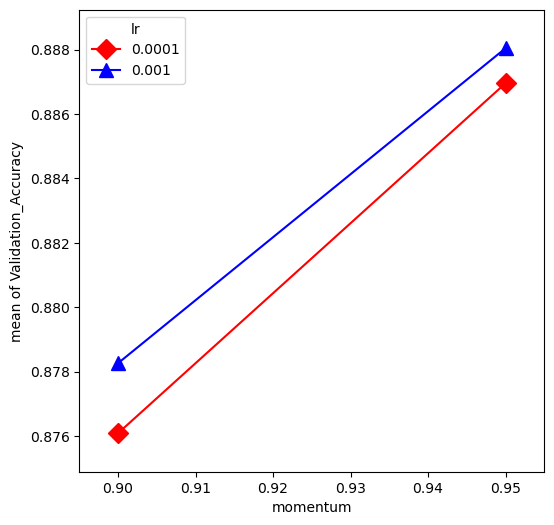

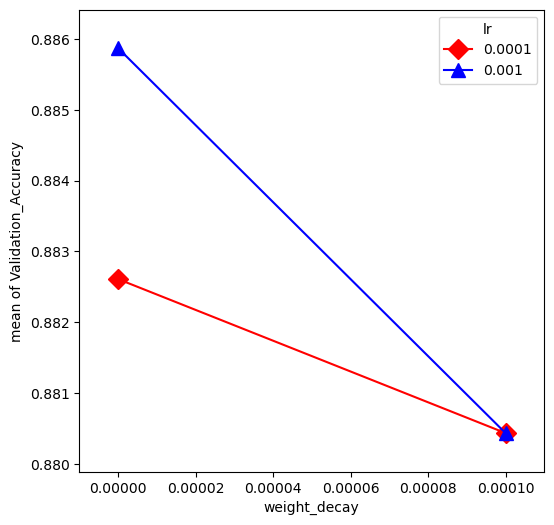

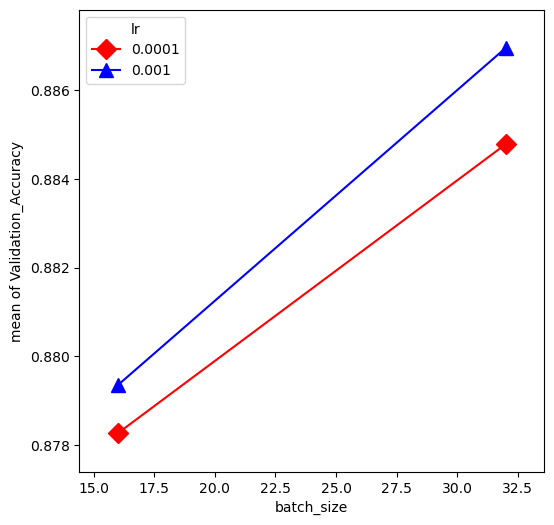

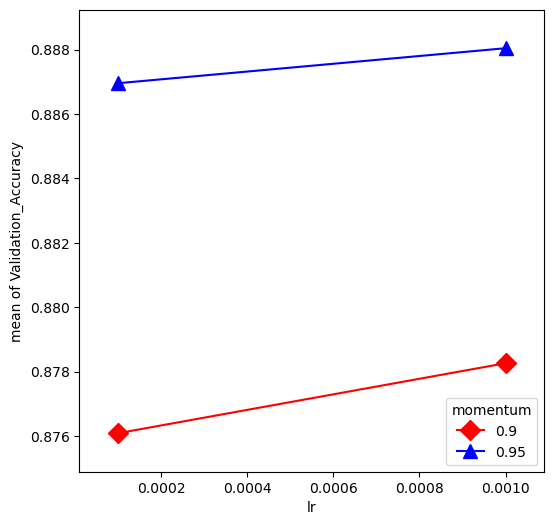

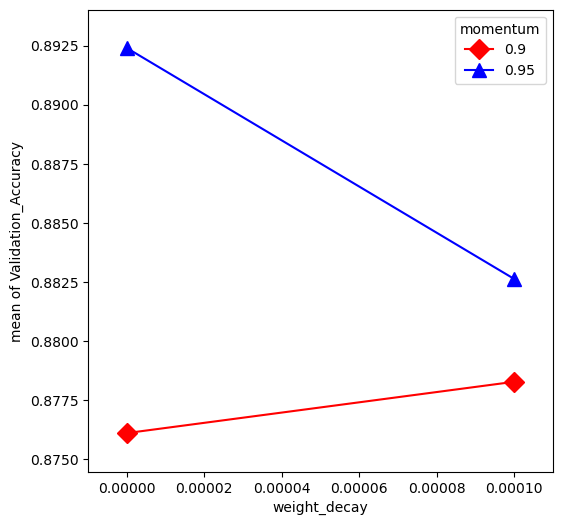

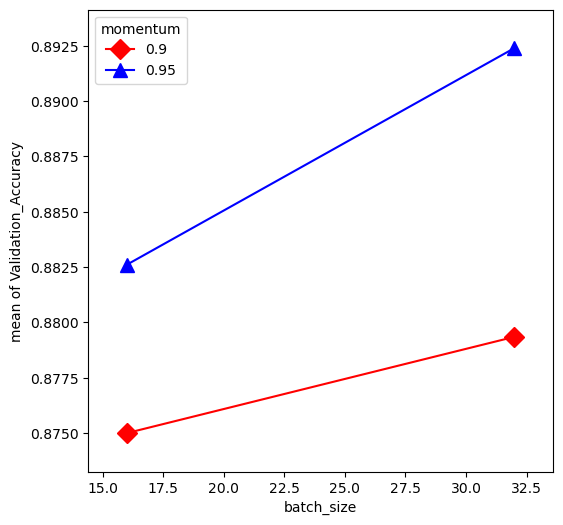

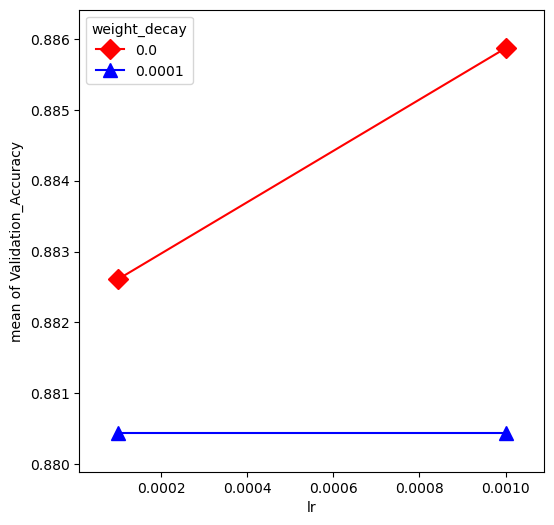

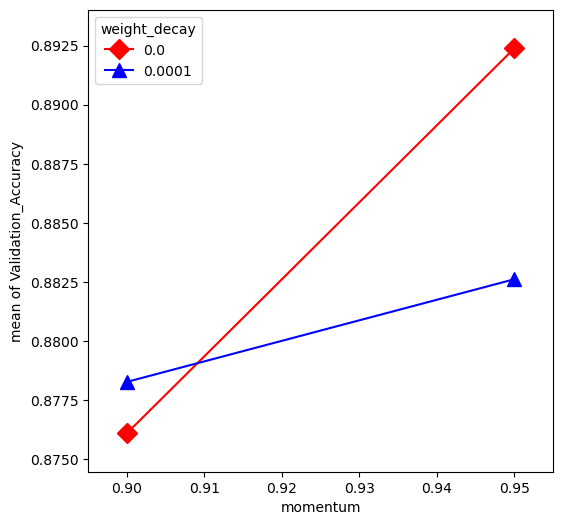

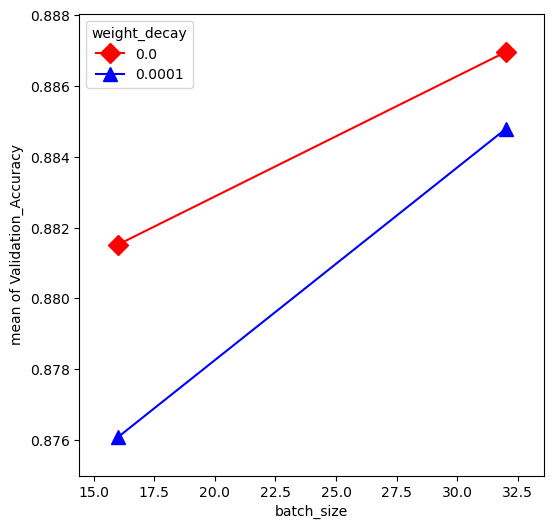

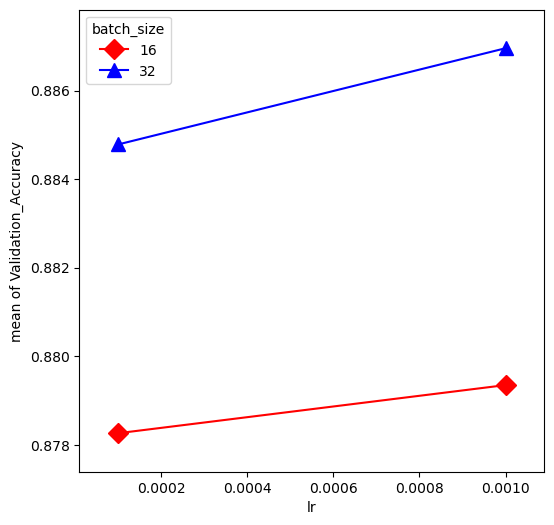

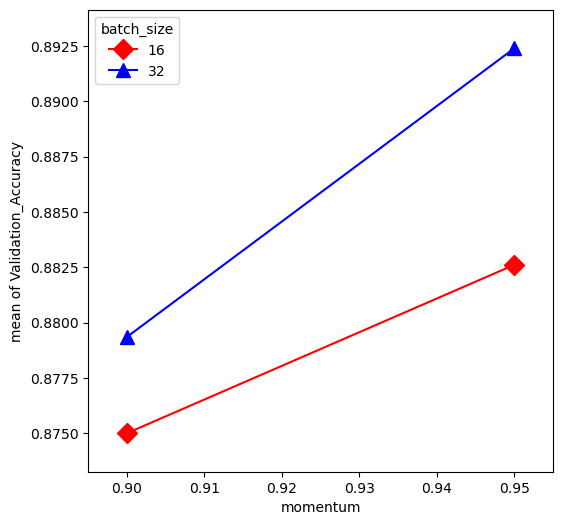

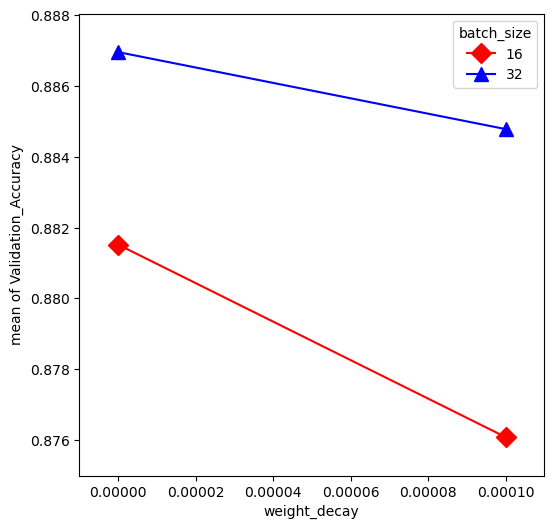

In [295]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/categorical_interaction_plot.html

from statsmodels.graphics.factorplots import interaction_plot

other_vars = ['lr', 'momentum', 'epochs', 'weight_decay', 'batch_size']  
for var in other_vars:
    for other in other_vars:
        if var != other:

            fig, ax = plt.subplots(figsize=(6, 6))
            fig = interaction_plot(
                x=df[other],
                trace=df[var],
                response=df['Validation_Accuracy'],
                colors=["red", "blue"],
                markers=["D", "^"],
                ms=10,
                ax=ax,
            )

## Investigated interactions from graphs but they added no value over epochs for Resnet18 models

In [299]:
#weight_decay * lr
#weight_decay *  momentum
#momentum * batch_size
#weight_decay * lr

print("Resnet18")
#https://www.pythonfordatascience.org/factorial-anova-python/
from statsmodels.formula.api import ols
print("Main effects using type 3 sum of squares to show effect with other IVs already accounted for.")
print("C(x, Sum) notation for type 3 SS") 
#model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum) +   C(weight_decay, Sum) + C(batch_size, Sum)", data=df).fit()
model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum) ", data=df).fit()
model = ols("Validation_Accuracy ~  C(epochs, Sum) +  C(lr, Sum) *  C(weight_decay, Sum)", data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
print(aov_table) 


print("Resnet18")
#https://www.pythonfordatascience.org/factorial-anova-python/
from statsmodels.formula.api import ols
print("Main effects using type 3 sum of squares to show effect with other IVs already accounted for.")
print("C(x, Sum) notation for type 3 SS") 
#model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum) +   C(weight_decay, Sum) + C(batch_size, Sum)", data=df).fit()
#model = ols("Validation_Accuracy ~ C(lr, Sum) + C(momentum, Sum) + C(epochs, Sum) ", data=df).fit()
model = ols("Validation_Accuracy ~  C(epochs, Sum) +  C(momentum, Sum) *  C(weight_decay, Sum)", data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
print(aov_table) 

model = ols("Validation_Accuracy ~  C(epochs, Sum) +  C(momentum, Sum) *  C(batch_size, Sum)", data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
print(aov_table) 



Resnet18
Main effects using type 3 sum of squares to show effect with other IVs already accounted for.
C(x, Sum) notation for type 3 SS
                                    sum_sq    df             F        PR(>F)
Intercept                        24.912592   1.0  86919.463511  6.695924e-49
C(epochs, Sum)                    0.003594   1.0     12.539542  1.469358e-03
C(lr, Sum)                        0.000021   1.0      0.074198  7.873915e-01
C(weight_decay, Sum)              0.000116   1.0      0.403969  5.303970e-01
C(lr, Sum):C(weight_decay, Sum)   0.000021   1.0      0.074198  7.873915e-01
Residual                          0.007739  27.0           NaN           NaN
Resnet18
Main effects using type 3 sum of squares to show effect with other IVs already accounted for.
C(x, Sum) notation for type 3 SS
                                          sum_sq    df              F  \
Intercept                              24.912592   1.0  101266.895411   
C(epochs, Sum)                          0.0

## Maybe did not have enough degrees of freedom to detect interactions that were viewed in graphs
##   Adding another momentum value to grid, to get same degrees of freedom used for earlier mobilenet
## Resnet18 getting more degrees of freedom

In [309]:
# make_plots=0
# Looking at epochs for mobilenet
# use with plot as see when loss starts to level off


model_name = 'resnet18'
param_grid = {
        'lr': [.001, .0001],
     #   'momentum': [.9,.95],
        'momentum': [.85],
        'epochs': [20,75],
        'weight_decay': [.0, .0001],  
        'optimizer': ['SGD'],  
        'batch_size': [16,32]  
    }
    
params_resnet18_SGD_add_degfreedom = test_model_parameters(model_name, param_grid, train_dataset, valid_dataset, device, 
                                            valid_ds_name = 'Validation',
                                            to_print=1, make_plots=0, write_csv=1, return_type='results_df')

start time:  2024_04_09_0841
resnet18
Model number:  1  current_params:  {'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}
Epoch 1/20:
Train Loss: 0.5564, Train Accuracy: 0.7018
Validation Loss: 0.4722 Validation Accuracy: 0.8174
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.3541, Train Accuracy: 0.8455
Validation Loss: 0.5114 Validation Accuracy: 0.7913
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.2092, Train Accuracy: 0.9282
Validation Loss: 0.6082 Validation Accuracy: 0.7478
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.1564, Train Accuracy: 0.9434
Validation Loss: 0.4834 Validation Accuracy: 0.8348
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.0935, Train Accuracy: 0.9739
Validation Loss: 0.4792 Validation Accuracy: 0.8435
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0486, Train Accuracy: 0.9913
Validation Loss: 0.4067 Validation Accuracy: 0.8522
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.0453, Train Accuracy: 0.9956
Validation Loss: 0.4631

Validation Loss: 0.4336 Validation Accuracy: 0.9130
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.0231, Train Accuracy: 0.9935
Validation Loss: 0.4482 Validation Accuracy: 0.9217
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.0325, Train Accuracy: 0.9913
Validation Loss: 0.4889 Validation Accuracy: 0.8696
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.0240, Train Accuracy: 0.9946
Validation Loss: 0.5326 Validation Accuracy: 0.8957
Finished Epoch 12
Epoch 13/20:
Train Loss: 0.0155, Train Accuracy: 0.9967
Validation Loss: 0.4620 Validation Accuracy: 0.9130
Finished Epoch 13
Epoch 14/20:
Train Loss: 0.0063, Train Accuracy: 1.0000
Validation Loss: 0.4991 Validation Accuracy: 0.9043
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.0079, Train Accuracy: 0.9989
Validation Loss: 0.4684 Validation Accuracy: 0.9043
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.0367, Train Accuracy: 0.9935
Validation Loss: 0.4731 Validation Accuracy: 0.8870
Finished Epoch 16
Epoch 17/20:
Train Loss: 0.0429, Train Accuracy: 

Validation Loss: 0.5326 Validation Accuracy: 0.8696
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0464, Train Accuracy: 0.9902
Validation Loss: 0.4380 Validation Accuracy: 0.8783
Finished Epoch 8
Epoch 9/75:
Train Loss: 0.0270, Train Accuracy: 0.9967
Validation Loss: 0.4940 Validation Accuracy: 0.8696
Finished Epoch 9
Epoch 10/75:
Train Loss: 0.0150, Train Accuracy: 0.9978
Validation Loss: 0.5463 Validation Accuracy: 0.8870
Finished Epoch 10
Epoch 11/75:
Train Loss: 0.0243, Train Accuracy: 0.9924
Validation Loss: 0.6169 Validation Accuracy: 0.8609
Finished Epoch 11
Epoch 12/75:
Train Loss: 0.0180, Train Accuracy: 0.9967
Validation Loss: 0.5115 Validation Accuracy: 0.8783
Finished Epoch 12
Epoch 13/75:
Train Loss: 0.0110, Train Accuracy: 1.0000
Validation Loss: 0.5829 Validation Accuracy: 0.8696
Finished Epoch 13
Epoch 14/75:
Train Loss: 0.0063, Train Accuracy: 1.0000
Validation Loss: 0.5583 Validation Accuracy: 0.8957
Finished Epoch 14
Epoch 15/75:
Train Loss: 0.0143, Train Accuracy: 0.99

Epoch 73/75:
Train Loss: 0.0179, Train Accuracy: 0.9935
Validation Loss: 0.7541 Validation Accuracy: 0.8522
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0092, Train Accuracy: 0.9956
Validation Loss: 0.6221 Validation Accuracy: 0.8957
Finished Epoch 74
Epoch 75/75:
Train Loss: 0.0029, Train Accuracy: 1.0000
Validation Loss: 0.6857 Validation Accuracy: 0.9043
Finished Epoch 75
Finished Training model number:  5
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 90.43%
Precision: 0.91
Recall: 0.90
F1 Score: 0.90
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'resnet18', 'train_accuracy': 0.998911860718172, 'train_precision': 0.9989146724475824, 'train_recall': 0.998911860718172, 'train_f1': 0.9989120536963682, 'valid_accuracy': 0.9043478260869565, 'valid_precision': 0.904753838294211, 'valid_recall': 0.90434

Validation Loss: 0.5681 Validation Accuracy: 0.8783
Finished Epoch 45
Epoch 46/75:
Train Loss: 0.0012, Train Accuracy: 1.0000
Validation Loss: 0.5579 Validation Accuracy: 0.8870
Finished Epoch 46
Epoch 47/75:
Train Loss: 0.0014, Train Accuracy: 1.0000
Validation Loss: 0.5682 Validation Accuracy: 0.8870
Finished Epoch 47
Epoch 48/75:
Train Loss: 0.0088, Train Accuracy: 1.0000
Validation Loss: 0.5747 Validation Accuracy: 0.8783
Finished Epoch 48
Epoch 49/75:
Train Loss: 0.0029, Train Accuracy: 1.0000
Validation Loss: 0.5012 Validation Accuracy: 0.8870
Finished Epoch 49
Epoch 50/75:
Train Loss: 0.0034, Train Accuracy: 1.0000
Validation Loss: 0.5258 Validation Accuracy: 0.8870
Finished Epoch 50
Epoch 51/75:
Train Loss: 0.0039, Train Accuracy: 1.0000
Validation Loss: 0.5451 Validation Accuracy: 0.8870
Finished Epoch 51
Epoch 52/75:
Train Loss: 0.0019, Train Accuracy: 1.0000
Validation Loss: 0.5570 Validation Accuracy: 0.8783
Finished Epoch 52
Epoch 53/75:
Train Loss: 0.0015, Train Accuracy:

Epoch 15/75:
Train Loss: 0.0091, Train Accuracy: 0.9989
Validation Loss: 0.4831 Validation Accuracy: 0.8957
Finished Epoch 15
Epoch 16/75:
Train Loss: 0.0268, Train Accuracy: 0.9935
Validation Loss: 0.5220 Validation Accuracy: 0.8696
Finished Epoch 16
Epoch 17/75:
Train Loss: 0.0292, Train Accuracy: 0.9924
Validation Loss: 0.4713 Validation Accuracy: 0.8957
Finished Epoch 17
Epoch 18/75:
Train Loss: 0.0097, Train Accuracy: 1.0000
Validation Loss: 0.4601 Validation Accuracy: 0.8783
Finished Epoch 18
Epoch 19/75:
Train Loss: 0.0067, Train Accuracy: 1.0000
Validation Loss: 0.4653 Validation Accuracy: 0.8783
Finished Epoch 19
Epoch 20/75:
Train Loss: 0.0064, Train Accuracy: 0.9989
Validation Loss: 0.5048 Validation Accuracy: 0.8957
Finished Epoch 20
Epoch 21/75:
Train Loss: 0.0305, Train Accuracy: 0.9891
Validation Loss: 0.5509 Validation Accuracy: 0.9130
Finished Epoch 21
Epoch 22/75:
Train Loss: 0.0194, Train Accuracy: 0.9946
Validation Loss: 0.5535 Validation Accuracy: 0.8696
Finished E

Epoch 1/75:
Train Loss: 0.6035, Train Accuracy: 0.6779
Validation Loss: 0.6003 Validation Accuracy: 0.7130
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.4228, Train Accuracy: 0.8259
Validation Loss: 0.4768 Validation Accuracy: 0.7739
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.3177, Train Accuracy: 0.8781
Validation Loss: 0.4414 Validation Accuracy: 0.8000
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.2342, Train Accuracy: 0.9206
Validation Loss: 0.4139 Validation Accuracy: 0.8087
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.1522, Train Accuracy: 0.9587
Validation Loss: 0.4080 Validation Accuracy: 0.8348
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.0983, Train Accuracy: 0.9848
Validation Loss: 0.3799 Validation Accuracy: 0.8609
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.0701, Train Accuracy: 0.9956
Validation Loss: 0.4158 Validation Accuracy: 0.8522
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0541, Train Accuracy: 0.9935
Validation Loss: 0.4153 Validation Accuracy: 0.8696
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5329 Validation Accuracy: 0.9043
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Validation Loss: 0.5404 Validation Accuracy: 0.9043
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Validation Loss: 0.5524 Validation Accuracy: 0.9043
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Validation Loss: 0.5381 Validation Accuracy: 0.9043
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Validation Loss: 0.5432 Validation Accuracy: 0.9043
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0006, Train Accuracy: 1.0000
Validation Loss: 0.5453 Validation Accuracy: 0.9043
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Validation Loss: 0.5512 Validation Accuracy: 0.9043
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Validation Loss: 0.5577 Validation Accuracy: 0.9130
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0006, Train Accuracy:

Epoch 1/20:
Train Loss: 0.6764, Train Accuracy: 0.5930
Validation Loss: 0.6592 Validation Accuracy: 0.6000
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6081, Train Accuracy: 0.6561
Validation Loss: 0.6065 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5714, Train Accuracy: 0.6942
Validation Loss: 0.5867 Validation Accuracy: 0.6957
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5534, Train Accuracy: 0.7225
Validation Loss: 0.5730 Validation Accuracy: 0.7043
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.5144, Train Accuracy: 0.7704
Validation Loss: 0.5554 Validation Accuracy: 0.7130
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.4924, Train Accuracy: 0.7933
Validation Loss: 0.5416 Validation Accuracy: 0.7304
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4745, Train Accuracy: 0.8052
Validation Loss: 0.5287 Validation Accuracy: 0.7478
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.4553, Train Accuracy: 0.8161
Validation Loss: 0.5198 Validation Accuracy: 0.7391
Finished Epoch 8
Epoch 9/

Epoch 13/20:
Train Loss: 0.2554, Train Accuracy: 0.9358
Validation Loss: 0.4352 Validation Accuracy: 0.8261
Finished Epoch 13
Epoch 14/20:
Train Loss: 0.2441, Train Accuracy: 0.9402
Validation Loss: 0.4324 Validation Accuracy: 0.8435
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.2345, Train Accuracy: 0.9380
Validation Loss: 0.4257 Validation Accuracy: 0.8435
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.2427, Train Accuracy: 0.9293
Validation Loss: 0.4275 Validation Accuracy: 0.8174
Finished Epoch 16
Epoch 17/20:
Train Loss: 0.1964, Train Accuracy: 0.9554
Validation Loss: 0.4165 Validation Accuracy: 0.8522
Finished Epoch 17
Epoch 18/20:
Train Loss: 0.1875, Train Accuracy: 0.9587
Validation Loss: 0.4083 Validation Accuracy: 0.8522
Finished Epoch 18
Epoch 19/20:
Train Loss: 0.1733, Train Accuracy: 0.9597
Validation Loss: 0.4127 Validation Accuracy: 0.8435
Finished Epoch 19
Epoch 20/20:
Train Loss: 0.1600, Train Accuracy: 0.9684
Validation Loss: 0.4227 Validation Accuracy: 0.8783
Finished E

Accuracy: 95.76%
Precision: 0.96
Recall: 0.96
F1 Score: 0.96
Validation data results:
Accuracy: 82.61%
Precision: 0.83
Recall: 0.83
F1 Score: 0.83
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'resnet18', 'train_accuracy': 0.998911860718172, 'train_precision': 0.9989146724475824, 'train_recall': 0.998911860718172, 'train_f1': 0.9989120536963682, 'valid_accuracy': 0.9043478260869565, 'valid_precision': 0.904753838294211, 'valid_recall': 0.9043478260869565, 'valid_f1': 0.9044812838910364}, "{'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 32}": {'model_name': 'resnet18', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8608695652173913, 'valid_precision': 0.8642458990285078, 'valid_recall': 0.8608695652173913, 'valid_f1': 0.8615117056856189}, "{'lr': 0.001, 'momentum'

Validation Loss: 0.4057 Validation Accuracy: 0.8783
Finished Epoch 26
Epoch 27/75:
Train Loss: 0.0983, Train Accuracy: 0.9902
Validation Loss: 0.4089 Validation Accuracy: 0.8522
Finished Epoch 27
Epoch 28/75:
Train Loss: 0.0969, Train Accuracy: 0.9880
Validation Loss: 0.4004 Validation Accuracy: 0.8696
Finished Epoch 28
Epoch 29/75:
Train Loss: 0.1012, Train Accuracy: 0.9815
Validation Loss: 0.4066 Validation Accuracy: 0.8783
Finished Epoch 29
Epoch 30/75:
Train Loss: 0.0890, Train Accuracy: 0.9804
Validation Loss: 0.3991 Validation Accuracy: 0.8783
Finished Epoch 30
Epoch 31/75:
Train Loss: 0.0793, Train Accuracy: 0.9935
Validation Loss: 0.4017 Validation Accuracy: 0.8783
Finished Epoch 31
Epoch 32/75:
Train Loss: 0.0844, Train Accuracy: 0.9837
Validation Loss: 0.3975 Validation Accuracy: 0.8696
Finished Epoch 32
Epoch 33/75:
Train Loss: 0.0737, Train Accuracy: 0.9935
Validation Loss: 0.4093 Validation Accuracy: 0.8609
Finished Epoch 33
Epoch 34/75:
Train Loss: 0.0832, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6765, Train Accuracy: 0.5941
Validation Loss: 0.6593 Validation Accuracy: 0.6000
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6080, Train Accuracy: 0.6583
Validation Loss: 0.6057 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5714, Train Accuracy: 0.6921
Validation Loss: 0.5861 Validation Accuracy: 0.6957
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.5534, Train Accuracy: 0.7247
Validation Loss: 0.5727 Validation Accuracy: 0.7043
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.5143, Train Accuracy: 0.7715
Validation Loss: 0.5566 Validation Accuracy: 0.7130
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.4925, Train Accuracy: 0.7954
Validation Loss: 0.5419 Validation Accuracy: 0.7304
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.4745, Train Accuracy: 0.8074
Validation Loss: 0.5286 Validation Accuracy: 0.7478
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.4553, Train Accuracy: 0.8194
Validation Loss: 0.5203 Validation Accuracy: 0.7478
Finished Epoch 8
Epoch 9/

Validation Loss: 0.3772 Validation Accuracy: 0.8870
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0440, Train Accuracy: 1.0000
Validation Loss: 0.3801 Validation Accuracy: 0.9043
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0429, Train Accuracy: 1.0000
Validation Loss: 0.3871 Validation Accuracy: 0.8957
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0416, Train Accuracy: 1.0000
Validation Loss: 0.3828 Validation Accuracy: 0.8783
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0394, Train Accuracy: 1.0000
Validation Loss: 0.3798 Validation Accuracy: 0.8870
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0365, Train Accuracy: 1.0000
Validation Loss: 0.3816 Validation Accuracy: 0.8957
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0358, Train Accuracy: 1.0000
Validation Loss: 0.3806 Validation Accuracy: 0.8783
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0377, Train Accuracy: 1.0000
Validation Loss: 0.3955 Validation Accuracy: 0.8870
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0335, Train Accuracy:

Validation Loss: 0.4604 Validation Accuracy: 0.8174
Finished Epoch 10
Epoch 11/75:
Train Loss: 0.3049, Train Accuracy: 0.9086
Validation Loss: 0.4686 Validation Accuracy: 0.8261
Finished Epoch 11
Epoch 12/75:
Train Loss: 0.2856, Train Accuracy: 0.9151
Validation Loss: 0.4591 Validation Accuracy: 0.8087
Finished Epoch 12
Epoch 13/75:
Train Loss: 0.2550, Train Accuracy: 0.9391
Validation Loss: 0.4400 Validation Accuracy: 0.8261
Finished Epoch 13
Epoch 14/75:
Train Loss: 0.2439, Train Accuracy: 0.9423
Validation Loss: 0.4363 Validation Accuracy: 0.8348
Finished Epoch 14
Epoch 15/75:
Train Loss: 0.2335, Train Accuracy: 0.9412
Validation Loss: 0.4342 Validation Accuracy: 0.8435
Finished Epoch 15
Epoch 16/75:
Train Loss: 0.2415, Train Accuracy: 0.9293
Validation Loss: 0.4327 Validation Accuracy: 0.8174
Finished Epoch 16
Epoch 17/75:
Train Loss: 0.1959, Train Accuracy: 0.9565
Validation Loss: 0.4235 Validation Accuracy: 0.8348
Finished Epoch 17
Epoch 18/75:
Train Loss: 0.1866, Train Accuracy:

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 89.57%
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'resnet18', 'train_accuracy': 0.998911860718172, 'train_precision': 0.9989146724475824, 'train_recall': 0.998911860718172, 'train_f1': 0.9989120536963682, 'valid_accuracy': 0.9043478260869565, 'valid_precision': 0.904753838294211, 'valid_recall': 0.9043478260869565, 'valid_f1': 0.9044812838910364}, "{'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 32}": {'model_name': 'resnet18', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8608695652173913, 'valid_precision': 0.8642458990285078, 'valid_recall': 0.8608695652173913, 'valid_f1': 0.8615117056856189}, "{'lr': 0.001, 'momentum

Validation Loss: 0.4468 Validation Accuracy: 0.8087
Finished Epoch 17
Epoch 18/75:
Train Loss: 0.2992, Train Accuracy: 0.9119
Validation Loss: 0.4443 Validation Accuracy: 0.8174
Finished Epoch 18
Epoch 19/75:
Train Loss: 0.2814, Train Accuracy: 0.9184
Validation Loss: 0.4400 Validation Accuracy: 0.8087
Finished Epoch 19
Epoch 20/75:
Train Loss: 0.2697, Train Accuracy: 0.9314
Validation Loss: 0.4359 Validation Accuracy: 0.8261
Finished Epoch 20
Epoch 21/75:
Train Loss: 0.2630, Train Accuracy: 0.9282
Validation Loss: 0.4348 Validation Accuracy: 0.7913
Finished Epoch 21
Epoch 22/75:
Train Loss: 0.2513, Train Accuracy: 0.9391
Validation Loss: 0.4261 Validation Accuracy: 0.8174
Finished Epoch 22
Epoch 23/75:
Train Loss: 0.2413, Train Accuracy: 0.9380
Validation Loss: 0.4213 Validation Accuracy: 0.8261
Finished Epoch 23
Epoch 24/75:
Train Loss: 0.2357, Train Accuracy: 0.9467
Validation Loss: 0.4172 Validation Accuracy: 0.8174
Finished Epoch 24
Epoch 25/75:
Train Loss: 0.2151, Train Accuracy:

In [343]:
df_resent18_48_obs = pd.concat([params_resnet18_SGD, params_resnet18_SGD_add_degfreedom], ignore_index=True)
#print(df_resent18_48_obs)
model_name='resnet18'
best_params=df_resent18_48_obs.sort_values(['Validation_Accuracy', 'Validation_Recall', 'Validation_Precision',
                                               'Validation_F1'], ascending=[False, False, False, False])
print(best_params)
#get top row
best=best_params.iloc[0] 
#get hyperparameters in top row
best_hyper_params=best['Hyperparameters']

# convert string of parameters to dictionary using eval()
#https://www.geeksforgeeks.org/python-program-to-create-a-dictionary-from-a-string/
# Create a new dictionary with the same keys and the values wrapped in a list
param_grid = {key: [value] for key, value in eval(best_hyper_params).items()}
print("Resnet18 best params after adding more momentum vlaues to grid search")
print(param_grid) 


   Model_Name                                    Hyperparameters  \
39   resnet18  {'lr': 0.001, 'momentum': 0.85, 'epochs': 75, ...   
12   resnet18  {'lr': 0.001, 'momentum': 0.95, 'epochs': 75, ...   
13   resnet18  {'lr': 0.001, 'momentum': 0.95, 'epochs': 75, ...   
36   resnet18  {'lr': 0.001, 'momentum': 0.85, 'epochs': 75, ...   
32   resnet18  {'lr': 0.001, 'momentum': 0.85, 'epochs': 20, ...   
21   resnet18  {'lr': 0.0001, 'momentum': 0.9, 'epochs': 75, ...   
28   resnet18  {'lr': 0.0001, 'momentum': 0.95, 'epochs': 75,...   
29   resnet18  {'lr': 0.0001, 'momentum': 0.95, 'epochs': 75,...   
31   resnet18  {'lr': 0.0001, 'momentum': 0.95, 'epochs': 75,...   
14   resnet18  {'lr': 0.001, 'momentum': 0.95, 'epochs': 75, ...   
4    resnet18  {'lr': 0.001, 'momentum': 0.9, 'epochs': 75, '...   
23   resnet18  {'lr': 0.0001, 'momentum': 0.9, 'epochs': 75, ...   
47   resnet18  {'lr': 0.0001, 'momentum': 0.85, 'epochs': 75,...   
8    resnet18  {'lr': 0.001, 'momentum': 0.95, '

start time:  2024_04_09_2208
resnet18
Model number:  1  current_params:  {'lr': 0.001, 'momentum': 0.85, 'epochs': 75, 'weight_decay': 0.0001, 'optimizer': 'SGD', 'batch_size': 32}
Epoch 1/75:
Train Loss: 0.6020, Train Accuracy: 0.6790
Testing Loss: 0.6215 Testing Accuracy: 0.7281
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.4208, Train Accuracy: 0.8270
Testing Loss: 0.4953 Testing Accuracy: 0.7544
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.3123, Train Accuracy: 0.8792
Testing Loss: 0.4984 Testing Accuracy: 0.7807
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.2331, Train Accuracy: 0.9227
Testing Loss: 0.4464 Testing Accuracy: 0.8070
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.1482, Train Accuracy: 0.9684
Testing Loss: 0.4901 Testing Accuracy: 0.7807
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.0945, Train Accuracy: 0.9859
Testing Loss: 0.4670 Testing Accuracy: 0.8421
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.0654, Train Accuracy: 0.9956
Testing Loss: 0.5192 Testing Accuracy: 0.8070
Finished E

Epoch 68/75:
Train Loss: 0.0009, Train Accuracy: 1.0000
Testing Loss: 0.6777 Testing Accuracy: 0.8070
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Testing Loss: 0.6486 Testing Accuracy: 0.7982
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Testing Loss: 0.6597 Testing Accuracy: 0.7982
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0006, Train Accuracy: 1.0000
Testing Loss: 0.6495 Testing Accuracy: 0.7982
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Testing Loss: 0.6617 Testing Accuracy: 0.8070
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Testing Loss: 0.6850 Testing Accuracy: 0.7982
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0006, Train Accuracy: 1.0000
Testing Loss: 0.6852 Testing Accuracy: 0.8070
Finished Epoch 74
Epoch 75/75:
Train Loss: 0.0013, Train Accuracy: 1.0000
Testing Loss: 0.7167 Testing Accuracy: 0.8070
Finished Epoch 75
Finished Training model number:  1
TRAIN

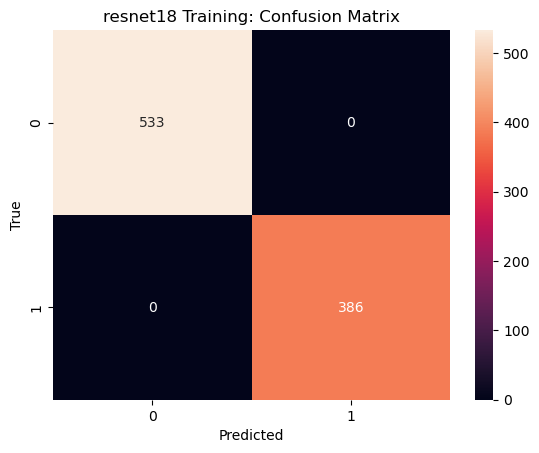

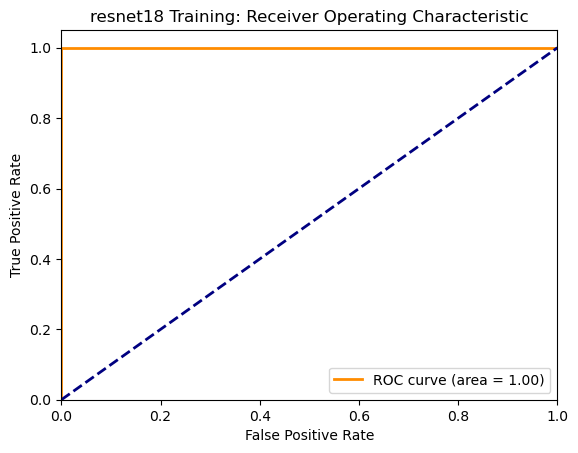

Testing data results:
Accuracy: 80.70%
Precision: 0.81
Recall: 0.81
F1 Score: 0.81


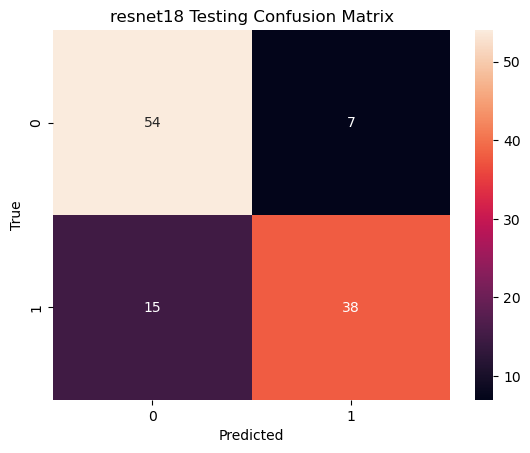

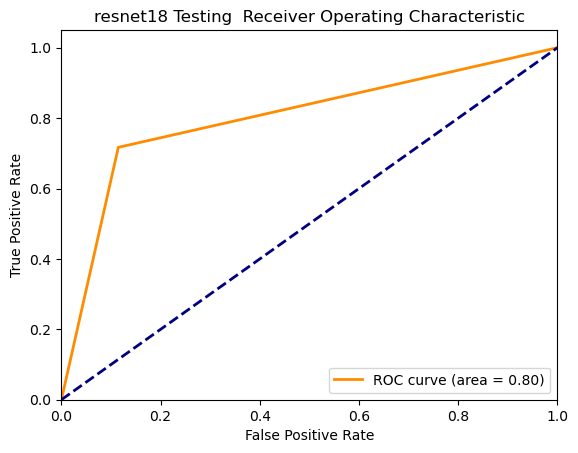

TRAINING and Testing data results:
{"{'lr': 0.001, 'momentum': 0.85, 'epochs': 75, 'weight_decay': 0.0001, 'optimizer': 'SGD', 'batch_size': 32}": {'model_name': 'resnet18', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8070175438596491, 'valid_precision': 0.811356894652089, 'valid_recall': 0.8070175438596491, 'valid_f1': 0.8050786306425405}}


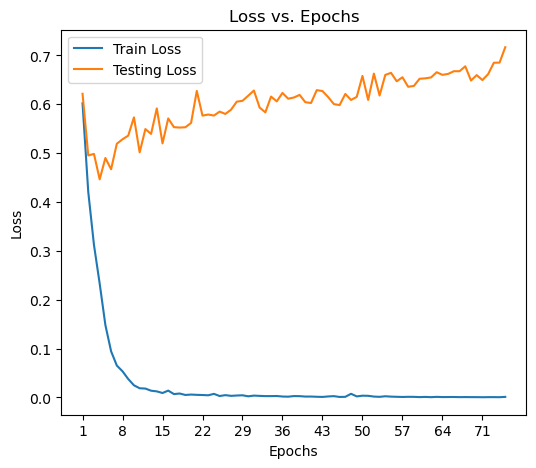

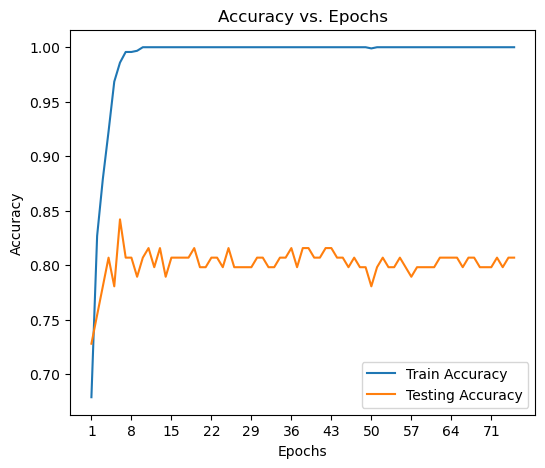

Best params:
  Model_Name                                    Hyperparameters  \
0   resnet18  {'lr': 0.001, 'momentum': 0.85, 'epochs': 75, ...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0             1.0              1.0           1.0       1.0   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.807018              0.811357           0.807018       0.805079  
run time: 0:17:25.287159


In [366]:
#running now
# resnet18 best params
model_name = 'resnet18'

#Best hyperparameters: {'lr': [0.001], 'momentum': [0.85], 'epochs': [75], 'weight_decay': [0.0001], 'optimizer': ['SGD'], 'batch_size': [32]}
param_grid = {'lr': [0.001], 'momentum': [0.85], 'epochs': [75], 
              'weight_decay': [0.0001], 'optimizer': ['SGD'], 'batch_size': [32]}

accuracy=test_model_parameters(model_name, param_grid, train_dataset, test_dataset, device, valid_ds_name = 'Testing',
                               to_print=1, make_plots=1, write_csv=1)    

In [330]:
#convert dictinary string column to separate columns
df =df_resent18_48_obs.drop(columns=['Model_Name' ])
df_h=pd.DataFrame()
df2=pd.DataFrame()
#initialize cols
df_h['Hyperparameters']= df['Hyperparameters'] 
df_h['lr'] = None
df_h['momentum'] = None
df_h['epochs'] = None
df_h['weight_decay'] = None
df_h['batch_size'] = None
df_h['Hyperparameters']= df['Hyperparameters'] 
i=0
for output in (df_h['Hyperparameters']):
    
    #print(i, df_h['Hyperparameters'][i])
    d= eval(df_h['Hyperparameters'][i])
    for k,v in d.items():
        #print(k,v)
        if k != 'optimizer':
            df_h[k][i]=v
    i=i+1

df_h['Validation_Accuracy'] = df['Validation_Accuracy'] 

df = df_h.drop(columns=['Hyperparameters' ])
#print(df)

# Correlation of hyperparameters with validation accuracy for Resnet with more degrees of freedom

Resent18


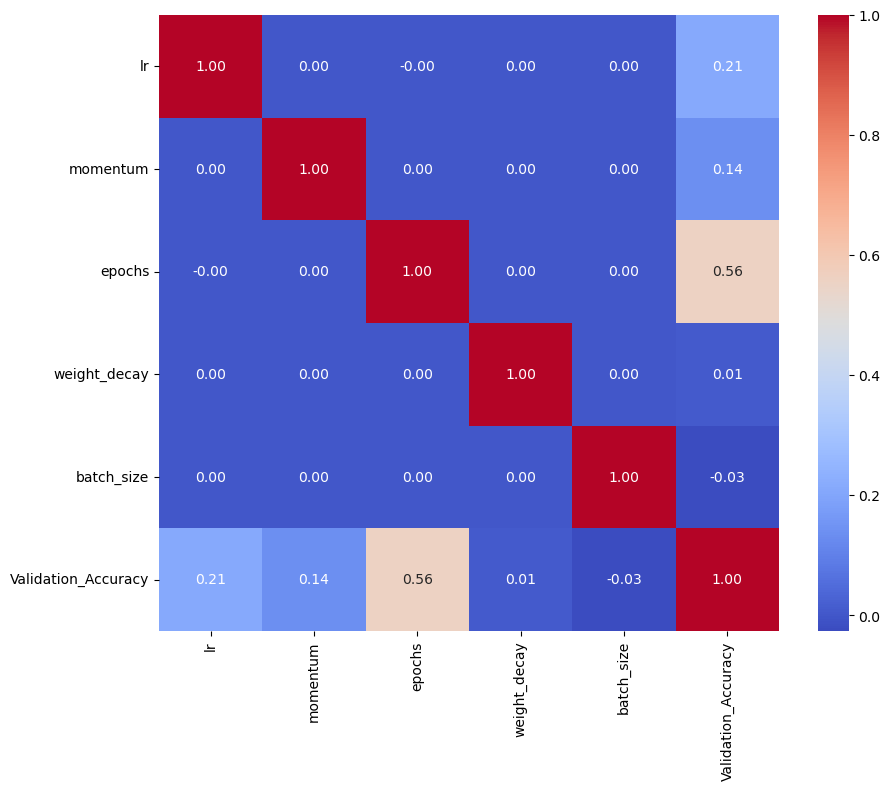

In [331]:
model_name = 'Resent18'
print(model_name)
correlation_matrix = df.corr()

#  heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

# Regression analysis of hyperparameters and validation accuracy for Resnet with more degrees of freedom

In [332]:
print(model_name)
# https://www.statsmodels.org/0.6.1/examples/notebooks/generated/interactions_anova.html
#https://www.pythonfordatascience.org/factorial-anova-python/

X = df.drop('Validation_Accuracy', axis=1)  # Independent variables
y = df['Validation_Accuracy']  # Dependent variable
X=X.astype(float)
# Fit the regression model
#model = sm.OLS(y, X).fit()
x_names = X.columns
for i, var in enumerate(x_names):
    #print(i, var)
    var_table = 'x'+str(i+1)+' = ' + var
    print(var_table)
# Get the summary of the regression
#print(model.summary())

# To get standardized coefficients, you can standardize your features before fitting the model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Note: Do not standardize the constant (intercept) term
X_scaled = sm.add_constant(X_scaled)

# Fit the regression model on the standardized features
#model_standardized = sm.OLS(y, X_scaled).fit()
# https://github.com/statsmodels/statsmodels/issues/5492
model_standardized = sm.OLS(y, X_scaled).fit()
print(model_standardized.summary()) 

Resent18
x1 = lr
x2 = momentum
x3 = epochs
x4 = weight_decay
x5 = batch_size
                             OLS Regression Results                            
Dep. Variable:     Validation_Accuracy   R-squared:                       0.376
Model:                             OLS   Adj. R-squared:                  0.301
Method:                  Least Squares   F-statistic:                     5.057
Date:                 Tue, 09 Apr 2024   Prob (F-statistic):            0.00102
Time:                         19:07:45   Log-Likelihood:                 128.34
No. Observations:                   48   AIC:                            -244.7
Df Residuals:                       42   BIC:                            -233.4
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

# Factorial ANOVA analysis of hyperparameters and validation accuracy for Resnet with more degrees of freedom

In [347]:
model = ols("Validation_Accuracy ~ C(lr,Sum) + C(momentum,Sum) + C(epochs,Sum) + C(weight_decay,Sum) + \
            C(batch_size,Sum) + C(lr, Sum) *  C(epochs, Sum) + C(lr, Sum) *  C(weight_decay, Sum) + \
            C(lr, Sum) *  C(batch_size, Sum) +  C(momentum, Sum) *  C(epochs, Sum) + \
            C(momentum, Sum) *  C(weight_decay, Sum) + C(momentum, Sum) *  C(batch_size, Sum) + \
            C(epochs, Sum) *  C(lr, Sum) + C(epochs, Sum) *  C(momentum, Sum) + C(epochs, Sum) *  C(weight_decay, Sum) + C(epochs, Sum) *  C(batch_size, Sum) + C(weight_decay, Sum) *  C(lr, Sum) + C(weight_decay, Sum) *  C(momentum, Sum) + C(weight_decay, Sum) *  C(epochs, Sum) + C(weight_decay, Sum) *  C(batch_size, Sum) + C(batch_size, Sum) *  C(lr, Sum) + C(batch_size, Sum) *  C(momentum, Sum) + C(batch_size, Sum) *  C(epochs, Sum) + C(batch_size, Sum) *  C(weight_decay, Sum)", data=df).fit()

#model = ols('"'+string+'"', data=df).fit()
print("Main effects and interactions:")
aov_table = sm.stats.anova_lm(model, typ=3)
print("aov_table")
#print(type(aov_table))
print(aov_table)
print()
print("Terms with p-value < .05:")
print(aov_table.loc[aov_table['PR(>F)'] < .05]) 

print()
print("Terms with p-value < .01:")
print(aov_table.loc[aov_table['PR(>F)'] < .01]) 
print("Main effects:")
model = ols("Validation_Accuracy ~ C(lr,Sum) + C(epochs,Sum) + C(momentum,Sum) + C(weight_decay,Sum) + C(batch_size,Sum) ", data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
print("aov_table")
#print(type(aov_table))
print(aov_table)
model = ols("Validation_Accuracy ~ C(lr,Sum) + C(epochs,Sum)  ", data=df).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
print("aov_table")
#print(type(aov_table))
print(aov_table)

print("Main effects:")
model = ols("Validation_Accuracy ~ C(lr,Sum) + C(epochs,Sum) + C(momentum,Sum) + C(weight_decay,Sum) + C(batch_size,Sum) ", data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
aov_table


Main effects and interactions:
aov_table
                                            sum_sq    df              F  \
Intercept                                37.315200   1.0  116096.498394   
C(lr, Sum)                                0.000985   1.0       3.063208   
C(momentum, Sum)                          0.000892   2.0       1.387020   
C(epochs, Sum)                            0.006656   1.0      20.707284   
C(weight_decay, Sum)                      0.000002   1.0       0.004901   
C(batch_size, Sum)                        0.000014   1.0       0.044110   
C(lr, Sum):C(epochs, Sum)                 0.000266   1.0       0.828291   
C(lr, Sum):C(weight_decay, Sum)           0.000039   1.0       0.122528   
C(lr, Sum):C(batch_size, Sum)             0.000014   1.0       0.044110   
C(momentum, Sum):C(epochs, Sum)           0.000192   2.0       0.298969   
C(momentum, Sum):C(weight_decay, Sum)     0.000703   2.0       1.092953   
C(momentum, Sum):C(batch_size, Sum)       0.001654   2.0   

sum_sq    df              F        PR(>F)
Intercept             37.315200   1.0  118713.512896  1.332641e-72
C(lr, Sum)             0.000985   1.0       3.132258  8.419419e-02
C(epochs, Sum)         0.006656   1.0      21.174062  4.000172e-05
C(momentum, Sum)       0.000892   2.0       1.418286  2.537575e-01
C(weight_decay, Sum)   0.000002   1.0       0.005012  9.439069e-01
C(batch_size, Sum)     0.000014   1.0       0.045105  8.328643e-01
Residual               0.012888  41.0            NaN           NaN

# For Resent 18, only the main effect of epochs was significant

In [3]:
###################################################################################################

# Investigating additional hyperparameters for Densenet

In [308]:
model_name = 'densenet'
param_grid = {
        'lr': [.001, .0001],
        'momentum': [.85, .9,.95],
        'epochs': [20,75],
        'weight_decay': [.0, .0001],  
        'optimizer': ['SGD'],  
        'batch_size': [16,32]  
    }
    
#accuracy = build_model(lr=lr, momentum=momentum, weight_decay=weight_decay, batch_size=batch_size, epochs=epochs, 
#                      optimizer=optimizer_name, model_name=model_name)
params_densenet_SGD = test_model_parameters(model_name, param_grid, train_dataset, valid_dataset, device, 
                                            valid_ds_name = 'Validation',
                                            to_print=1, make_plots=0, write_csv=1, return_type='results_df')

start time:  2024_04_08_2110
densenet
Model number:  1  current_params:  {'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}
Epoch 1/20:
Train Loss: 0.5850, Train Accuracy: 0.6714
Validation Loss: 0.5300 Validation Accuracy: 0.7652
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.3501, Train Accuracy: 0.8585
Validation Loss: 0.4117 Validation Accuracy: 0.8261
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.2493, Train Accuracy: 0.8988
Validation Loss: 0.4203 Validation Accuracy: 0.8522
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.1576, Train Accuracy: 0.9434
Validation Loss: 0.4181 Validation Accuracy: 0.8609
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.1117, Train Accuracy: 0.9587
Validation Loss: 0.7711 Validation Accuracy: 0.7913
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0930, Train Accuracy: 0.9663
Validation Loss: 0.5847 Validation Accuracy: 0.8261
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.0688, Train Accuracy: 0.9782
Validation Loss: 0.5915

Validation Loss: 0.4986 Validation Accuracy: 0.8609
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.0235, Train Accuracy: 0.9946
Validation Loss: 0.7006 Validation Accuracy: 0.8609
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.0272, Train Accuracy: 0.9913
Validation Loss: 0.6632 Validation Accuracy: 0.8348
Finished Epoch 12
Epoch 13/20:
Train Loss: 0.0551, Train Accuracy: 0.9815
Validation Loss: 0.7415 Validation Accuracy: 0.8261
Finished Epoch 13
Epoch 14/20:
Train Loss: 0.0635, Train Accuracy: 0.9739
Validation Loss: 0.5434 Validation Accuracy: 0.8522
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.0531, Train Accuracy: 0.9815
Validation Loss: 0.6467 Validation Accuracy: 0.8609
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.0370, Train Accuracy: 0.9935
Validation Loss: 0.6099 Validation Accuracy: 0.8783
Finished Epoch 16
Epoch 17/20:
Train Loss: 0.0501, Train Accuracy: 0.9804
Validation Loss: 0.6112 Validation Accuracy: 0.8522
Finished Epoch 17
Epoch 18/20:
Train Loss: 0.0217, Train Accuracy:

Validation Loss: 0.4788 Validation Accuracy: 0.8522
Finished Epoch 9
Epoch 10/75:
Train Loss: 0.0341, Train Accuracy: 0.9935
Validation Loss: 0.5384 Validation Accuracy: 0.8870
Finished Epoch 10
Epoch 11/75:
Train Loss: 0.0213, Train Accuracy: 0.9935
Validation Loss: 0.4618 Validation Accuracy: 0.8522
Finished Epoch 11
Epoch 12/75:
Train Loss: 0.0291, Train Accuracy: 0.9924
Validation Loss: 0.5190 Validation Accuracy: 0.8957
Finished Epoch 12
Epoch 13/75:
Train Loss: 0.0215, Train Accuracy: 0.9935
Validation Loss: 0.4902 Validation Accuracy: 0.8870
Finished Epoch 13
Epoch 14/75:
Train Loss: 0.0292, Train Accuracy: 0.9924
Validation Loss: 0.4589 Validation Accuracy: 0.8696
Finished Epoch 14
Epoch 15/75:
Train Loss: 0.0376, Train Accuracy: 0.9891
Validation Loss: 0.6321 Validation Accuracy: 0.8522
Finished Epoch 15
Epoch 16/75:
Train Loss: 0.0277, Train Accuracy: 0.9967
Validation Loss: 0.6211 Validation Accuracy: 0.8783
Finished Epoch 16
Epoch 17/75:
Train Loss: 0.0283, Train Accuracy: 

Epoch 75/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.4744 Validation Accuracy: 0.9304
Finished Epoch 75
Finished Training model number:  5
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 93.04%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'densenet', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8956521739130435, 'valid_precision': 0.8967491638795986, 'valid_recall': 0.8956521739130435, 'valid_f1': 0.8959264338146326}, "{'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 32}": {'model_name': 'densenet', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8608695652173913, 'vali

Epoch 48/75:
Train Loss: 0.0020, Train Accuracy: 1.0000
Validation Loss: 0.6529 Validation Accuracy: 0.8522
Finished Epoch 48
Epoch 49/75:
Train Loss: 0.0013, Train Accuracy: 1.0000
Validation Loss: 0.6760 Validation Accuracy: 0.8435
Finished Epoch 49
Epoch 50/75:
Train Loss: 0.0012, Train Accuracy: 1.0000
Validation Loss: 0.6970 Validation Accuracy: 0.8522
Finished Epoch 50
Epoch 51/75:
Train Loss: 0.0012, Train Accuracy: 1.0000
Validation Loss: 0.6926 Validation Accuracy: 0.8609
Finished Epoch 51
Epoch 52/75:
Train Loss: 0.0016, Train Accuracy: 1.0000
Validation Loss: 0.6834 Validation Accuracy: 0.8696
Finished Epoch 52
Epoch 53/75:
Train Loss: 0.0020, Train Accuracy: 1.0000
Validation Loss: 0.7142 Validation Accuracy: 0.8261
Finished Epoch 53
Epoch 54/75:
Train Loss: 0.0020, Train Accuracy: 1.0000
Validation Loss: 0.7108 Validation Accuracy: 0.8609
Finished Epoch 54
Epoch 55/75:
Train Loss: 0.0011, Train Accuracy: 1.0000
Validation Loss: 0.7346 Validation Accuracy: 0.8696
Finished E

Epoch 18/75:
Train Loss: 0.0168, Train Accuracy: 0.9967
Validation Loss: 0.4064 Validation Accuracy: 0.8870
Finished Epoch 18
Epoch 19/75:
Train Loss: 0.0081, Train Accuracy: 0.9989
Validation Loss: 0.4172 Validation Accuracy: 0.8783
Finished Epoch 19
Epoch 20/75:
Train Loss: 0.0141, Train Accuracy: 0.9967
Validation Loss: 0.4221 Validation Accuracy: 0.9043
Finished Epoch 20
Epoch 21/75:
Train Loss: 0.0387, Train Accuracy: 0.9891
Validation Loss: 0.4217 Validation Accuracy: 0.8870
Finished Epoch 21
Epoch 22/75:
Train Loss: 0.0593, Train Accuracy: 0.9782
Validation Loss: 0.2928 Validation Accuracy: 0.9130
Finished Epoch 22
Epoch 23/75:
Train Loss: 0.0138, Train Accuracy: 0.9967
Validation Loss: 0.2666 Validation Accuracy: 0.9130
Finished Epoch 23
Epoch 24/75:
Train Loss: 0.0221, Train Accuracy: 0.9935
Validation Loss: 0.3136 Validation Accuracy: 0.8783
Finished Epoch 24
Epoch 25/75:
Train Loss: 0.0115, Train Accuracy: 0.9967
Validation Loss: 0.3114 Validation Accuracy: 0.9043
Finished E

Epoch 1/75:
Train Loss: 0.6272, Train Accuracy: 0.6192
Validation Loss: 0.6067 Validation Accuracy: 0.6870
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.4404, Train Accuracy: 0.7965
Validation Loss: 0.5615 Validation Accuracy: 0.6870
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.3086, Train Accuracy: 0.8901
Validation Loss: 0.4672 Validation Accuracy: 0.8087
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.2006, Train Accuracy: 0.9445
Validation Loss: 0.4393 Validation Accuracy: 0.8348
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.1291, Train Accuracy: 0.9652
Validation Loss: 0.4455 Validation Accuracy: 0.8000
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.0853, Train Accuracy: 0.9837
Validation Loss: 0.4364 Validation Accuracy: 0.8348
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.0552, Train Accuracy: 0.9913
Validation Loss: 0.4588 Validation Accuracy: 0.8174
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0330, Train Accuracy: 0.9989
Validation Loss: 0.4773 Validation Accuracy: 0.8174
Finished Epoch 8
Epoch 9/

Validation Loss: 0.6393 Validation Accuracy: 0.8696
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0005, Train Accuracy: 1.0000
Validation Loss: 0.6465 Validation Accuracy: 0.8696
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Validation Loss: 0.6365 Validation Accuracy: 0.8783
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0013, Train Accuracy: 1.0000
Validation Loss: 0.6245 Validation Accuracy: 0.8609
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Validation Loss: 0.6305 Validation Accuracy: 0.8609
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0005, Train Accuracy: 1.0000
Validation Loss: 0.6245 Validation Accuracy: 0.8783
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0010, Train Accuracy: 1.0000
Validation Loss: 0.6266 Validation Accuracy: 0.8609
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0009, Train Accuracy: 1.0000
Validation Loss: 0.6287 Validation Accuracy: 0.8696
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0007, Train Accuracy:

Epoch 1/20:
Train Loss: 0.6273, Train Accuracy: 0.6235
Validation Loss: 0.6244 Validation Accuracy: 0.7217
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.4238, Train Accuracy: 0.7998
Validation Loss: 0.5153 Validation Accuracy: 0.7304
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.2701, Train Accuracy: 0.8868
Validation Loss: 0.4831 Validation Accuracy: 0.8087
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.1441, Train Accuracy: 0.9608
Validation Loss: 0.4260 Validation Accuracy: 0.8522
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.0766, Train Accuracy: 0.9859
Validation Loss: 0.4653 Validation Accuracy: 0.8174
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0472, Train Accuracy: 0.9946
Validation Loss: 0.4897 Validation Accuracy: 0.8348
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.0329, Train Accuracy: 0.9946
Validation Loss: 0.5089 Validation Accuracy: 0.8261
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.0200, Train Accuracy: 0.9978
Validation Loss: 0.5409 Validation Accuracy: 0.8522
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5179 Validation Accuracy: 0.8957
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.0420, Train Accuracy: 0.9869
Validation Loss: 0.5906 Validation Accuracy: 0.8696
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.0233, Train Accuracy: 0.9956
Validation Loss: 0.3734 Validation Accuracy: 0.8957
Finished Epoch 16
Epoch 17/20:
Train Loss: 0.0159, Train Accuracy: 0.9924
Validation Loss: 0.5156 Validation Accuracy: 0.8870
Finished Epoch 17
Epoch 18/20:
Train Loss: 0.0102, Train Accuracy: 0.9989
Validation Loss: 0.4977 Validation Accuracy: 0.9043
Finished Epoch 18
Epoch 19/20:
Train Loss: 0.0086, Train Accuracy: 0.9967
Validation Loss: 0.5071 Validation Accuracy: 0.9130
Finished Epoch 19
Epoch 20/20:
Train Loss: 0.0130, Train Accuracy: 0.9956
Validation Loss: 0.6664 Validation Accuracy: 0.8783
Finished Epoch 20
Finished Training model number:  11
TRAINING data results:
Accuracy: 99.89%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 87.83%
Precision: 0

Epoch 1/75:
Train Loss: 0.5920, Train Accuracy: 0.6670
Validation Loss: 0.5029 Validation Accuracy: 0.7826
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.3215, Train Accuracy: 0.8705
Validation Loss: 0.4762 Validation Accuracy: 0.8174
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.2363, Train Accuracy: 0.9108
Validation Loss: 0.4198 Validation Accuracy: 0.8435
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.1234, Train Accuracy: 0.9597
Validation Loss: 0.4434 Validation Accuracy: 0.8522
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.0923, Train Accuracy: 0.9674
Validation Loss: 0.6357 Validation Accuracy: 0.8087
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.1012, Train Accuracy: 0.9521
Validation Loss: 0.5848 Validation Accuracy: 0.8261
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.1081, Train Accuracy: 0.9663
Validation Loss: 0.6135 Validation Accuracy: 0.8348
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0802, Train Accuracy: 0.9674
Validation Loss: 0.3777 Validation Accuracy: 0.9130
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4955 Validation Accuracy: 0.9043
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0005, Train Accuracy: 1.0000
Validation Loss: 0.4770 Validation Accuracy: 0.9043
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.4731 Validation Accuracy: 0.9043
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0008, Train Accuracy: 1.0000
Validation Loss: 0.5205 Validation Accuracy: 0.8957
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.4721 Validation Accuracy: 0.9043
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.5092 Validation Accuracy: 0.8957
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0010, Train Accuracy: 1.0000
Validation Loss: 0.4353 Validation Accuracy: 0.9043
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0002, Train Accuracy: 1.0000
Validation Loss: 0.4359 Validation Accuracy: 0.9217
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0037, Train Accuracy:

Validation Loss: 0.5228 Validation Accuracy: 0.8609
Finished Epoch 15
Epoch 16/75:
Train Loss: 0.0033, Train Accuracy: 1.0000
Validation Loss: 0.5450 Validation Accuracy: 0.8522
Finished Epoch 16
Epoch 17/75:
Train Loss: 0.0028, Train Accuracy: 1.0000
Validation Loss: 0.5369 Validation Accuracy: 0.8609
Finished Epoch 17
Epoch 18/75:
Train Loss: 0.0031, Train Accuracy: 1.0000
Validation Loss: 0.5387 Validation Accuracy: 0.8783
Finished Epoch 18
Epoch 19/75:
Train Loss: 0.0017, Train Accuracy: 1.0000
Validation Loss: 0.5552 Validation Accuracy: 0.8522
Finished Epoch 19
Epoch 20/75:
Train Loss: 0.0023, Train Accuracy: 1.0000
Validation Loss: 0.5502 Validation Accuracy: 0.8609
Finished Epoch 20
Epoch 21/75:
Train Loss: 0.0039, Train Accuracy: 1.0000
Validation Loss: 0.5588 Validation Accuracy: 0.8522
Finished Epoch 21
Epoch 22/75:
Train Loss: 0.0020, Train Accuracy: 1.0000
Validation Loss: 0.5706 Validation Accuracy: 0.8522
Finished Epoch 22
Epoch 23/75:
Train Loss: 0.0016, Train Accuracy:

Epoch 1/75:
Train Loss: 0.5980, Train Accuracy: 0.6507
Validation Loss: 0.5676 Validation Accuracy: 0.7739
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.3262, Train Accuracy: 0.8487
Validation Loss: 0.5240 Validation Accuracy: 0.8000
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.2160, Train Accuracy: 0.9129
Validation Loss: 0.4439 Validation Accuracy: 0.7913
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.1265, Train Accuracy: 0.9554
Validation Loss: 0.4259 Validation Accuracy: 0.8348
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.0798, Train Accuracy: 0.9739
Validation Loss: 0.6230 Validation Accuracy: 0.8174
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.1260, Train Accuracy: 0.9597
Validation Loss: 0.5094 Validation Accuracy: 0.8696
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.0973, Train Accuracy: 0.9663
Validation Loss: 0.4480 Validation Accuracy: 0.8435
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0514, Train Accuracy: 0.9859
Validation Loss: 0.4561 Validation Accuracy: 0.8609
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4988 Validation Accuracy: 0.8870
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0004, Train Accuracy: 1.0000
Validation Loss: 0.5279 Validation Accuracy: 0.8783
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0004, Train Accuracy: 1.0000
Validation Loss: 0.5141 Validation Accuracy: 0.8783
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0004, Train Accuracy: 1.0000
Validation Loss: 0.5319 Validation Accuracy: 0.8783
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.4970 Validation Accuracy: 0.8783
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0002, Train Accuracy: 1.0000
Validation Loss: 0.5446 Validation Accuracy: 0.8870
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Validation Loss: 0.4812 Validation Accuracy: 0.8870
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0002, Train Accuracy: 1.0000
Validation Loss: 0.5043 Validation Accuracy: 0.8870
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0005, Train Accuracy:

Validation Loss: 0.5337 Validation Accuracy: 0.8435
Finished Epoch 9
Epoch 10/75:
Train Loss: 0.0072, Train Accuracy: 1.0000
Validation Loss: 0.5055 Validation Accuracy: 0.8435
Finished Epoch 10
Epoch 11/75:
Train Loss: 0.0091, Train Accuracy: 1.0000
Validation Loss: 0.5287 Validation Accuracy: 0.8348
Finished Epoch 11
Epoch 12/75:
Train Loss: 0.0074, Train Accuracy: 0.9989
Validation Loss: 0.5788 Validation Accuracy: 0.8348
Finished Epoch 12
Epoch 13/75:
Train Loss: 0.0063, Train Accuracy: 1.0000
Validation Loss: 0.5574 Validation Accuracy: 0.8261
Finished Epoch 13
Epoch 14/75:
Train Loss: 0.0058, Train Accuracy: 0.9989
Validation Loss: 0.6130 Validation Accuracy: 0.8609
Finished Epoch 14
Epoch 15/75:
Train Loss: 0.0031, Train Accuracy: 1.0000
Validation Loss: 0.6138 Validation Accuracy: 0.7913
Finished Epoch 15
Epoch 16/75:
Train Loss: 0.0033, Train Accuracy: 1.0000
Validation Loss: 0.5968 Validation Accuracy: 0.8348
Finished Epoch 16
Epoch 17/75:
Train Loss: 0.0027, Train Accuracy: 

Epoch 75/75:
Train Loss: 0.0006, Train Accuracy: 1.0000
Validation Loss: 0.7085 Validation Accuracy: 0.8522
Finished Epoch 75
Finished Training model number:  16
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 85.22%
Precision: 0.85
Recall: 0.85
F1 Score: 0.85
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 16}": {'model_name': 'densenet', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8956521739130435, 'valid_precision': 0.8967491638795986, 'valid_recall': 0.8956521739130435, 'valid_f1': 0.8959264338146326}, "{'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'SGD', 'batch_size': 32}": {'model_name': 'densenet', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8608695652173913, 'val

Validation Loss: 0.9147 Validation Accuracy: 0.8783
Finished Epoch 15
Epoch 16/20:
Train Loss: 0.0395, Train Accuracy: 0.9891
Validation Loss: 0.7198 Validation Accuracy: 0.8522
Finished Epoch 16
Epoch 17/20:
Train Loss: 0.0409, Train Accuracy: 0.9869
Validation Loss: 0.5692 Validation Accuracy: 0.8696
Finished Epoch 17
Epoch 18/20:
Train Loss: 0.0088, Train Accuracy: 0.9967
Validation Loss: 0.6367 Validation Accuracy: 0.8870
Finished Epoch 18
Epoch 19/20:
Train Loss: 0.0030, Train Accuracy: 1.0000
Validation Loss: 0.6007 Validation Accuracy: 0.9043
Finished Epoch 19
Epoch 20/20:
Train Loss: 0.0034, Train Accuracy: 1.0000
Validation Loss: 0.5959 Validation Accuracy: 0.9043
Finished Epoch 20
Finished Training model number:  17
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Validation data results:
Accuracy: 90.43%
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
TRAINING and Validation data results:
{"{'lr': 0.001, 'momentum': 0.85, 'epochs': 20, 'weight

Epoch 8/20:
Train Loss: 0.0236, Train Accuracy: 0.9924
Validation Loss: 0.5150 Validation Accuracy: 0.8435
Finished Epoch 8
Epoch 9/20:
Train Loss: 0.0163, Train Accuracy: 0.9956
Validation Loss: 0.5922 Validation Accuracy: 0.8696
Finished Epoch 9
Epoch 10/20:
Train Loss: 0.0089, Train Accuracy: 0.9967
Validation Loss: 0.5105 Validation Accuracy: 0.8522
Finished Epoch 10
Epoch 11/20:
Train Loss: 0.0249, Train Accuracy: 0.9946
Validation Loss: 0.6566 Validation Accuracy: 0.8522
Finished Epoch 11
Epoch 12/20:
Train Loss: 0.0189, Train Accuracy: 0.9956
Validation Loss: 0.6433 Validation Accuracy: 0.8870
Finished Epoch 12
Epoch 13/20:
Train Loss: 0.0174, Train Accuracy: 0.9967
Validation Loss: 0.4799 Validation Accuracy: 0.8783
Finished Epoch 13
Epoch 14/20:
Train Loss: 0.0085, Train Accuracy: 0.9978
Validation Loss: 1.1235 Validation Accuracy: 0.8174
Finished Epoch 14
Epoch 15/20:
Train Loss: 0.0057, Train Accuracy: 0.9978
Validation Loss: 0.5873 Validation Accuracy: 0.8609
Finished Epoch

Epoch 1/20:
Train Loss: 0.6289, Train Accuracy: 0.6496
Validation Loss: 0.5877 Validation Accuracy: 0.7739
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.3380, Train Accuracy: 0.8596
Validation Loss: 0.7007 Validation Accuracy: 0.8087
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.2818, Train Accuracy: 0.8890
Validation Loss: 0.4648 Validation Accuracy: 0.8435
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.1430, Train Accuracy: 0.9423
Validation Loss: 0.4947 Validation Accuracy: 0.8609
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.1052, Train Accuracy: 0.9532
Validation Loss: 1.4560 Validation Accuracy: 0.8087
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.1983, Train Accuracy: 0.9217
Validation Loss: 0.3843 Validation Accuracy: 0.8957
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.1235, Train Accuracy: 0.9565
Validation Loss: 0.5362 Validation Accuracy: 0.8261
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.0575, Train Accuracy: 0.9761
Validation Loss: 0.3903 Validation Accuracy: 0.8783
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6329, Train Accuracy: 0.6224
Validation Loss: 0.6616 Validation Accuracy: 0.6348
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.4228, Train Accuracy: 0.7943
Validation Loss: 0.6278 Validation Accuracy: 0.6870
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.2513, Train Accuracy: 0.8988
Validation Loss: 0.5452 Validation Accuracy: 0.8174
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.1236, Train Accuracy: 0.9521
Validation Loss: 0.6017 Validation Accuracy: 0.8087
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.0760, Train Accuracy: 0.9782
Validation Loss: 0.4207 Validation Accuracy: 0.8522
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0545, Train Accuracy: 0.9826
Validation Loss: 0.4690 Validation Accuracy: 0.8609
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.0555, Train Accuracy: 0.9793
Validation Loss: 0.5356 Validation Accuracy: 0.8261
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.0410, Train Accuracy: 0.9880
Validation Loss: 0.3980 Validation Accuracy: 0.9043
Finished Epoch 8
Epoch 9/

Epoch 1/75:
Train Loss: 0.6278, Train Accuracy: 0.6583
Validation Loss: 0.5466 Validation Accuracy: 0.8000
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.3391, Train Accuracy: 0.8466
Validation Loss: 0.5010 Validation Accuracy: 0.8522
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.2749, Train Accuracy: 0.8934
Validation Loss: 0.3854 Validation Accuracy: 0.8783
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.1632, Train Accuracy: 0.9391
Validation Loss: 0.4915 Validation Accuracy: 0.8174
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.2122, Train Accuracy: 0.9129
Validation Loss: 1.4481 Validation Accuracy: 0.7391
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.1791, Train Accuracy: 0.9336
Validation Loss: 0.3584 Validation Accuracy: 0.8783
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.1012, Train Accuracy: 0.9597
Validation Loss: 0.5116 Validation Accuracy: 0.8957
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0601, Train Accuracy: 0.9782
Validation Loss: 0.3577 Validation Accuracy: 0.9043
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4477 Validation Accuracy: 0.8783
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0001, Train Accuracy: 1.0000
Validation Loss: 0.4615 Validation Accuracy: 0.8783
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0001, Train Accuracy: 1.0000
Validation Loss: 0.4408 Validation Accuracy: 0.8783
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0001, Train Accuracy: 1.0000
Validation Loss: 0.4517 Validation Accuracy: 0.8957
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0001, Train Accuracy: 1.0000
Validation Loss: 0.4190 Validation Accuracy: 0.8783
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0001, Train Accuracy: 1.0000
Validation Loss: 0.4711 Validation Accuracy: 0.8870
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0002, Train Accuracy: 1.0000
Validation Loss: 0.4355 Validation Accuracy: 0.8870
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0001, Train Accuracy: 1.0000
Validation Loss: 0.4633 Validation Accuracy: 0.8783
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0003, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6372, Train Accuracy: 0.6148
Validation Loss: 0.6540 Validation Accuracy: 0.6174
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.4207, Train Accuracy: 0.7889
Validation Loss: 0.5293 Validation Accuracy: 0.7652
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.2487, Train Accuracy: 0.8912
Validation Loss: 0.6083 Validation Accuracy: 0.8174
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.1029, Train Accuracy: 0.9576
Validation Loss: 0.5124 Validation Accuracy: 0.8522
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.0447, Train Accuracy: 0.9935
Validation Loss: 0.6105 Validation Accuracy: 0.8435
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.0342, Train Accuracy: 0.9880
Validation Loss: 0.5244 Validation Accuracy: 0.8870
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.0192, Train Accuracy: 0.9946
Validation Loss: 0.6074 Validation Accuracy: 0.8609
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0135, Train Accuracy: 0.9967
Validation Loss: 0.5426 Validation Accuracy: 0.8783
Finished Epoch 8
Epoch 9/

Validation Loss: 0.6576 Validation Accuracy: 0.9043
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.6672 Validation Accuracy: 0.8957
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0004, Train Accuracy: 1.0000
Validation Loss: 0.6811 Validation Accuracy: 0.9043
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0005, Train Accuracy: 1.0000
Validation Loss: 0.7014 Validation Accuracy: 0.9043
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0005, Train Accuracy: 1.0000
Validation Loss: 0.6718 Validation Accuracy: 0.9043
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.6807 Validation Accuracy: 0.9043
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0004, Train Accuracy: 1.0000
Validation Loss: 0.6612 Validation Accuracy: 0.9043
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.6907 Validation Accuracy: 0.8957
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0002, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6349, Train Accuracy: 0.6398
Validation Loss: 0.6247 Validation Accuracy: 0.7739
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.3228, Train Accuracy: 0.8553
Validation Loss: 0.5924 Validation Accuracy: 0.7565
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.2580, Train Accuracy: 0.8890
Validation Loss: 0.8437 Validation Accuracy: 0.7652
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.1795, Train Accuracy: 0.9347
Validation Loss: 0.6438 Validation Accuracy: 0.7913
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.1858, Train Accuracy: 0.9325
Validation Loss: 1.1588 Validation Accuracy: 0.7652
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.1441, Train Accuracy: 0.9412
Validation Loss: 0.4572 Validation Accuracy: 0.8957
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.1275, Train Accuracy: 0.9521
Validation Loss: 0.6243 Validation Accuracy: 0.8609
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0744, Train Accuracy: 0.9761
Validation Loss: 0.4700 Validation Accuracy: 0.9217
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4225 Validation Accuracy: 0.9304
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0004, Train Accuracy: 1.0000
Validation Loss: 0.4508 Validation Accuracy: 0.9217
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0002, Train Accuracy: 1.0000
Validation Loss: 0.4586 Validation Accuracy: 0.9217
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.4441 Validation Accuracy: 0.9217
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0002, Train Accuracy: 1.0000
Validation Loss: 0.4164 Validation Accuracy: 0.9304
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0002, Train Accuracy: 1.0000
Validation Loss: 0.4454 Validation Accuracy: 0.9217
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.4074 Validation Accuracy: 0.9304
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0001, Train Accuracy: 1.0000
Validation Loss: 0.4342 Validation Accuracy: 0.9217
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0001, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6298, Train Accuracy: 0.6279
Validation Loss: 0.7042 Validation Accuracy: 0.5652
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.4064, Train Accuracy: 0.8052
Validation Loss: 0.6752 Validation Accuracy: 0.6870
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.2466, Train Accuracy: 0.8977
Validation Loss: 0.5289 Validation Accuracy: 0.8087
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.0999, Train Accuracy: 0.9663
Validation Loss: 0.5103 Validation Accuracy: 0.8522
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.0417, Train Accuracy: 0.9869
Validation Loss: 0.4530 Validation Accuracy: 0.8522
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.0416, Train Accuracy: 0.9902
Validation Loss: 0.5231 Validation Accuracy: 0.8261
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.0429, Train Accuracy: 0.9837
Validation Loss: 0.4578 Validation Accuracy: 0.8957
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.0601, Train Accuracy: 0.9793
Validation Loss: 0.6980 Validation Accuracy: 0.8087
Finished Epoch 8
Epoch 9/

Validation Loss: 0.6993 Validation Accuracy: 0.8609
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0002, Train Accuracy: 1.0000
Validation Loss: 0.7326 Validation Accuracy: 0.8522
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0007, Train Accuracy: 1.0000
Validation Loss: 0.7765 Validation Accuracy: 0.8609
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0003, Train Accuracy: 1.0000
Validation Loss: 0.7955 Validation Accuracy: 0.8696
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0037, Train Accuracy: 0.9989
Validation Loss: 0.5821 Validation Accuracy: 0.8783
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0006, Train Accuracy: 1.0000
Validation Loss: 0.5492 Validation Accuracy: 0.8870
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0012, Train Accuracy: 1.0000
Validation Loss: 0.4799 Validation Accuracy: 0.8783
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0005, Train Accuracy: 1.0000
Validation Loss: 0.5099 Validation Accuracy: 0.8696
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0003, Train Accuracy:

Epoch 1/20:
Train Loss: 0.6712, Train Accuracy: 0.5734
Validation Loss: 0.6516 Validation Accuracy: 0.6435
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5816, Train Accuracy: 0.6964
Validation Loss: 0.6274 Validation Accuracy: 0.6783
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5500, Train Accuracy: 0.7258
Validation Loss: 0.6105 Validation Accuracy: 0.7043
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5086, Train Accuracy: 0.7639
Validation Loss: 0.5758 Validation Accuracy: 0.7043
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4746, Train Accuracy: 0.8118
Validation Loss: 0.5571 Validation Accuracy: 0.7652
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.4528, Train Accuracy: 0.8226
Validation Loss: 0.5354 Validation Accuracy: 0.7826
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4106, Train Accuracy: 0.8455
Validation Loss: 0.5164 Validation Accuracy: 0.7652
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.3827, Train Accuracy: 0.8618
Validation Loss: 0.5040 Validation Accuracy: 0.7739
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.7024, Train Accuracy: 0.5277
Validation Loss: 0.7041 Validation Accuracy: 0.5826
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6135, Train Accuracy: 0.6551
Validation Loss: 0.6527 Validation Accuracy: 0.6522
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5819, Train Accuracy: 0.7018
Validation Loss: 0.6422 Validation Accuracy: 0.6696
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5504, Train Accuracy: 0.7378
Validation Loss: 0.6226 Validation Accuracy: 0.6696
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.5258, Train Accuracy: 0.7617
Validation Loss: 0.6065 Validation Accuracy: 0.7304
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.5081, Train Accuracy: 0.7856
Validation Loss: 0.5984 Validation Accuracy: 0.7217
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4840, Train Accuracy: 0.8139
Validation Loss: 0.5850 Validation Accuracy: 0.7217
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.4676, Train Accuracy: 0.8052
Validation Loss: 0.5735 Validation Accuracy: 0.7478
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6714, Train Accuracy: 0.5756
Validation Loss: 0.6511 Validation Accuracy: 0.6348
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5825, Train Accuracy: 0.6942
Validation Loss: 0.6274 Validation Accuracy: 0.6957
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5516, Train Accuracy: 0.7258
Validation Loss: 0.6123 Validation Accuracy: 0.7043
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5084, Train Accuracy: 0.7682
Validation Loss: 0.5746 Validation Accuracy: 0.7391
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4753, Train Accuracy: 0.8085
Validation Loss: 0.5608 Validation Accuracy: 0.7652
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.4525, Train Accuracy: 0.8259
Validation Loss: 0.5408 Validation Accuracy: 0.7739
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4132, Train Accuracy: 0.8498
Validation Loss: 0.5153 Validation Accuracy: 0.8000
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.3842, Train Accuracy: 0.8553
Validation Loss: 0.5058 Validation Accuracy: 0.8000
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.7022, Train Accuracy: 0.5299
Validation Loss: 0.7035 Validation Accuracy: 0.5826
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.6134, Train Accuracy: 0.6572
Validation Loss: 0.6523 Validation Accuracy: 0.6522
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5818, Train Accuracy: 0.7051
Validation Loss: 0.6426 Validation Accuracy: 0.6696
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5508, Train Accuracy: 0.7432
Validation Loss: 0.6249 Validation Accuracy: 0.6609
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.5258, Train Accuracy: 0.7617
Validation Loss: 0.6077 Validation Accuracy: 0.7391
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.5082, Train Accuracy: 0.7791
Validation Loss: 0.5974 Validation Accuracy: 0.7217
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4841, Train Accuracy: 0.8161
Validation Loss: 0.5822 Validation Accuracy: 0.7130
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.4681, Train Accuracy: 0.8041
Validation Loss: 0.5725 Validation Accuracy: 0.7304
Finished Epoch 8
Epoch 9/

Epoch 1/75:
Train Loss: 0.6712, Train Accuracy: 0.5724
Validation Loss: 0.6519 Validation Accuracy: 0.6522
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5817, Train Accuracy: 0.6910
Validation Loss: 0.6252 Validation Accuracy: 0.6783
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5508, Train Accuracy: 0.7269
Validation Loss: 0.6080 Validation Accuracy: 0.7130
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.5076, Train Accuracy: 0.7693
Validation Loss: 0.5709 Validation Accuracy: 0.7304
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4744, Train Accuracy: 0.8172
Validation Loss: 0.5547 Validation Accuracy: 0.7565
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.4514, Train Accuracy: 0.8237
Validation Loss: 0.5332 Validation Accuracy: 0.7826
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.4128, Train Accuracy: 0.8498
Validation Loss: 0.5149 Validation Accuracy: 0.7826
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.3836, Train Accuracy: 0.8575
Validation Loss: 0.5020 Validation Accuracy: 0.8087
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4373 Validation Accuracy: 0.8696
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0149, Train Accuracy: 1.0000
Validation Loss: 0.4220 Validation Accuracy: 0.8870
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0114, Train Accuracy: 1.0000
Validation Loss: 0.4176 Validation Accuracy: 0.8957
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0181, Train Accuracy: 1.0000
Validation Loss: 0.4125 Validation Accuracy: 0.8696
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0112, Train Accuracy: 1.0000
Validation Loss: 0.4423 Validation Accuracy: 0.8609
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0107, Train Accuracy: 1.0000
Validation Loss: 0.4143 Validation Accuracy: 0.8783
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0174, Train Accuracy: 0.9989
Validation Loss: 0.4930 Validation Accuracy: 0.8348
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0125, Train Accuracy: 0.9978
Validation Loss: 0.4469 Validation Accuracy: 0.8609
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0130, Train Accuracy:

Epoch 1/75:
Train Loss: 0.7025, Train Accuracy: 0.5277
Validation Loss: 0.7033 Validation Accuracy: 0.5826
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6135, Train Accuracy: 0.6529
Validation Loss: 0.6520 Validation Accuracy: 0.6522
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5819, Train Accuracy: 0.7029
Validation Loss: 0.6420 Validation Accuracy: 0.6609
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.5508, Train Accuracy: 0.7410
Validation Loss: 0.6243 Validation Accuracy: 0.6609
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.5261, Train Accuracy: 0.7661
Validation Loss: 0.6090 Validation Accuracy: 0.7217
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.5084, Train Accuracy: 0.7824
Validation Loss: 0.5988 Validation Accuracy: 0.7217
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.4845, Train Accuracy: 0.8172
Validation Loss: 0.5850 Validation Accuracy: 0.7217
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.4677, Train Accuracy: 0.8063
Validation Loss: 0.5741 Validation Accuracy: 0.7304
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4300 Validation Accuracy: 0.8435
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0288, Train Accuracy: 0.9989
Validation Loss: 0.4376 Validation Accuracy: 0.8435
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0305, Train Accuracy: 1.0000
Validation Loss: 0.4343 Validation Accuracy: 0.8783
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0329, Train Accuracy: 0.9978
Validation Loss: 0.4275 Validation Accuracy: 0.8696
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0284, Train Accuracy: 1.0000
Validation Loss: 0.4355 Validation Accuracy: 0.8609
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0264, Train Accuracy: 1.0000
Validation Loss: 0.4384 Validation Accuracy: 0.8609
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0305, Train Accuracy: 1.0000
Validation Loss: 0.4446 Validation Accuracy: 0.8435
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0282, Train Accuracy: 1.0000
Validation Loss: 0.4436 Validation Accuracy: 0.8783
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0252, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6719, Train Accuracy: 0.5745
Validation Loss: 0.6514 Validation Accuracy: 0.6261
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5821, Train Accuracy: 0.6888
Validation Loss: 0.6282 Validation Accuracy: 0.7130
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5494, Train Accuracy: 0.7334
Validation Loss: 0.6069 Validation Accuracy: 0.7130
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.5080, Train Accuracy: 0.7726
Validation Loss: 0.5739 Validation Accuracy: 0.7304
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4747, Train Accuracy: 0.8096
Validation Loss: 0.5560 Validation Accuracy: 0.7652
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.4512, Train Accuracy: 0.8226
Validation Loss: 0.5325 Validation Accuracy: 0.7913
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.4119, Train Accuracy: 0.8477
Validation Loss: 0.5160 Validation Accuracy: 0.7739
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.3832, Train Accuracy: 0.8618
Validation Loss: 0.5014 Validation Accuracy: 0.8000
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4400 Validation Accuracy: 0.8696
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0147, Train Accuracy: 0.9989
Validation Loss: 0.4316 Validation Accuracy: 0.8696
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0113, Train Accuracy: 1.0000
Validation Loss: 0.4319 Validation Accuracy: 0.8870
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0177, Train Accuracy: 0.9989
Validation Loss: 0.4071 Validation Accuracy: 0.8870
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0112, Train Accuracy: 1.0000
Validation Loss: 0.4345 Validation Accuracy: 0.8783
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0106, Train Accuracy: 1.0000
Validation Loss: 0.4031 Validation Accuracy: 0.8783
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0177, Train Accuracy: 0.9978
Validation Loss: 0.5105 Validation Accuracy: 0.8261
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0123, Train Accuracy: 0.9989
Validation Loss: 0.4514 Validation Accuracy: 0.8783
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0136, Train Accuracy:

Epoch 1/75:
Train Loss: 0.7022, Train Accuracy: 0.5299
Validation Loss: 0.7033 Validation Accuracy: 0.5826
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.6135, Train Accuracy: 0.6551
Validation Loss: 0.6530 Validation Accuracy: 0.6522
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5817, Train Accuracy: 0.7018
Validation Loss: 0.6429 Validation Accuracy: 0.6609
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.5510, Train Accuracy: 0.7410
Validation Loss: 0.6262 Validation Accuracy: 0.6522
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.5264, Train Accuracy: 0.7595
Validation Loss: 0.6100 Validation Accuracy: 0.7130
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.5085, Train Accuracy: 0.7835
Validation Loss: 0.5991 Validation Accuracy: 0.7217
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.4844, Train Accuracy: 0.8139
Validation Loss: 0.5858 Validation Accuracy: 0.7217
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.4681, Train Accuracy: 0.8030
Validation Loss: 0.5738 Validation Accuracy: 0.7304
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4331 Validation Accuracy: 0.8609
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0288, Train Accuracy: 0.9989
Validation Loss: 0.4384 Validation Accuracy: 0.8783
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0304, Train Accuracy: 1.0000
Validation Loss: 0.4364 Validation Accuracy: 0.8609
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0329, Train Accuracy: 0.9989
Validation Loss: 0.4313 Validation Accuracy: 0.8696
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0280, Train Accuracy: 1.0000
Validation Loss: 0.4374 Validation Accuracy: 0.8696
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0262, Train Accuracy: 1.0000
Validation Loss: 0.4393 Validation Accuracy: 0.8696
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0303, Train Accuracy: 1.0000
Validation Loss: 0.4450 Validation Accuracy: 0.8522
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0279, Train Accuracy: 1.0000
Validation Loss: 0.4453 Validation Accuracy: 0.8696
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0253, Train Accuracy:

Epoch 1/20:
Train Loss: 0.6622, Train Accuracy: 0.5919
Validation Loss: 0.6442 Validation Accuracy: 0.6522
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5574, Train Accuracy: 0.7203
Validation Loss: 0.6127 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5166, Train Accuracy: 0.7639
Validation Loss: 0.5748 Validation Accuracy: 0.7130
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.4618, Train Accuracy: 0.8128
Validation Loss: 0.5379 Validation Accuracy: 0.7652
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4151, Train Accuracy: 0.8498
Validation Loss: 0.5277 Validation Accuracy: 0.7913
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.3869, Train Accuracy: 0.8564
Validation Loss: 0.4920 Validation Accuracy: 0.8000
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.3346, Train Accuracy: 0.9129
Validation Loss: 0.4627 Validation Accuracy: 0.8087
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.3034, Train Accuracy: 0.9010
Validation Loss: 0.4622 Validation Accuracy: 0.8174
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6992, Train Accuracy: 0.5288
Validation Loss: 0.7026 Validation Accuracy: 0.5739
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5947, Train Accuracy: 0.6931
Validation Loss: 0.6402 Validation Accuracy: 0.6696
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5549, Train Accuracy: 0.7367
Validation Loss: 0.6234 Validation Accuracy: 0.7130
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5176, Train Accuracy: 0.7693
Validation Loss: 0.6055 Validation Accuracy: 0.6957
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4859, Train Accuracy: 0.8041
Validation Loss: 0.5835 Validation Accuracy: 0.7217
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.4636, Train Accuracy: 0.8215
Validation Loss: 0.5642 Validation Accuracy: 0.7478
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4304, Train Accuracy: 0.8487
Validation Loss: 0.5473 Validation Accuracy: 0.7652
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.4082, Train Accuracy: 0.8455
Validation Loss: 0.5378 Validation Accuracy: 0.7826
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6622, Train Accuracy: 0.5887
Validation Loss: 0.6468 Validation Accuracy: 0.6696
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5564, Train Accuracy: 0.7280
Validation Loss: 0.6120 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5159, Train Accuracy: 0.7541
Validation Loss: 0.5805 Validation Accuracy: 0.7391
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.4615, Train Accuracy: 0.8063
Validation Loss: 0.5400 Validation Accuracy: 0.7478
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4153, Train Accuracy: 0.8498
Validation Loss: 0.5199 Validation Accuracy: 0.7652
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.3876, Train Accuracy: 0.8596
Validation Loss: 0.4876 Validation Accuracy: 0.8174
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.3340, Train Accuracy: 0.9021
Validation Loss: 0.4685 Validation Accuracy: 0.8174
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.3004, Train Accuracy: 0.9042
Validation Loss: 0.4616 Validation Accuracy: 0.8174
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6991, Train Accuracy: 0.5299
Validation Loss: 0.7028 Validation Accuracy: 0.5739
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5946, Train Accuracy: 0.6899
Validation Loss: 0.6408 Validation Accuracy: 0.6783
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5550, Train Accuracy: 0.7388
Validation Loss: 0.6223 Validation Accuracy: 0.7217
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.5178, Train Accuracy: 0.7650
Validation Loss: 0.6039 Validation Accuracy: 0.6957
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4869, Train Accuracy: 0.8030
Validation Loss: 0.5818 Validation Accuracy: 0.7217
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.4637, Train Accuracy: 0.8183
Validation Loss: 0.5653 Validation Accuracy: 0.7565
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.4300, Train Accuracy: 0.8455
Validation Loss: 0.5504 Validation Accuracy: 0.7565
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.4087, Train Accuracy: 0.8498
Validation Loss: 0.5339 Validation Accuracy: 0.7739
Finished Epoch 8
Epoch 9/

Epoch 1/75:
Train Loss: 0.6620, Train Accuracy: 0.5941
Validation Loss: 0.6469 Validation Accuracy: 0.6435
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5573, Train Accuracy: 0.7247
Validation Loss: 0.6146 Validation Accuracy: 0.7043
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5177, Train Accuracy: 0.7595
Validation Loss: 0.5850 Validation Accuracy: 0.7130
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.4631, Train Accuracy: 0.8085
Validation Loss: 0.5392 Validation Accuracy: 0.7652
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4182, Train Accuracy: 0.8400
Validation Loss: 0.5139 Validation Accuracy: 0.7913
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.3890, Train Accuracy: 0.8607
Validation Loss: 0.5063 Validation Accuracy: 0.7913
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.3355, Train Accuracy: 0.9010
Validation Loss: 0.4635 Validation Accuracy: 0.8000
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.3031, Train Accuracy: 0.9010
Validation Loss: 0.4581 Validation Accuracy: 0.8174
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4660 Validation Accuracy: 0.8435
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0091, Train Accuracy: 1.0000
Validation Loss: 0.4558 Validation Accuracy: 0.8870
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0065, Train Accuracy: 1.0000
Validation Loss: 0.4383 Validation Accuracy: 0.9043
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0093, Train Accuracy: 1.0000
Validation Loss: 0.4411 Validation Accuracy: 0.8957
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0064, Train Accuracy: 1.0000
Validation Loss: 0.4841 Validation Accuracy: 0.8609
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0056, Train Accuracy: 1.0000
Validation Loss: 0.4478 Validation Accuracy: 0.8870
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0099, Train Accuracy: 0.9989
Validation Loss: 0.5870 Validation Accuracy: 0.8261
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0069, Train Accuracy: 1.0000
Validation Loss: 0.4817 Validation Accuracy: 0.8870
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0096, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6991, Train Accuracy: 0.5267
Validation Loss: 0.7020 Validation Accuracy: 0.5739
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5948, Train Accuracy: 0.6953
Validation Loss: 0.6393 Validation Accuracy: 0.6783
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5549, Train Accuracy: 0.7378
Validation Loss: 0.6246 Validation Accuracy: 0.6957
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.5187, Train Accuracy: 0.7693
Validation Loss: 0.6060 Validation Accuracy: 0.6957
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4869, Train Accuracy: 0.7976
Validation Loss: 0.5832 Validation Accuracy: 0.7217
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.4635, Train Accuracy: 0.8194
Validation Loss: 0.5648 Validation Accuracy: 0.7565
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.4307, Train Accuracy: 0.8477
Validation Loss: 0.5488 Validation Accuracy: 0.7652
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.4089, Train Accuracy: 0.8477
Validation Loss: 0.5344 Validation Accuracy: 0.7739
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4595 Validation Accuracy: 0.8522
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0119, Train Accuracy: 1.0000
Validation Loss: 0.4662 Validation Accuracy: 0.8609
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0130, Train Accuracy: 1.0000
Validation Loss: 0.4645 Validation Accuracy: 0.8870
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0149, Train Accuracy: 1.0000
Validation Loss: 0.4555 Validation Accuracy: 0.8870
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0127, Train Accuracy: 1.0000
Validation Loss: 0.4637 Validation Accuracy: 0.8609
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0110, Train Accuracy: 1.0000
Validation Loss: 0.4639 Validation Accuracy: 0.8609
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0142, Train Accuracy: 1.0000
Validation Loss: 0.4754 Validation Accuracy: 0.8609
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0128, Train Accuracy: 1.0000
Validation Loss: 0.4677 Validation Accuracy: 0.8783
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0110, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6621, Train Accuracy: 0.5887
Validation Loss: 0.6447 Validation Accuracy: 0.6609
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5576, Train Accuracy: 0.7236
Validation Loss: 0.6176 Validation Accuracy: 0.7304
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5179, Train Accuracy: 0.7563
Validation Loss: 0.5743 Validation Accuracy: 0.7217
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.4614, Train Accuracy: 0.8074
Validation Loss: 0.5318 Validation Accuracy: 0.7565
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4160, Train Accuracy: 0.8531
Validation Loss: 0.5159 Validation Accuracy: 0.7913
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.3884, Train Accuracy: 0.8618
Validation Loss: 0.4934 Validation Accuracy: 0.8087
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.3337, Train Accuracy: 0.9021
Validation Loss: 0.4581 Validation Accuracy: 0.8087
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.3017, Train Accuracy: 0.9010
Validation Loss: 0.4541 Validation Accuracy: 0.8174
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5007 Validation Accuracy: 0.8435
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0093, Train Accuracy: 0.9989
Validation Loss: 0.4806 Validation Accuracy: 0.8696
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0065, Train Accuracy: 1.0000
Validation Loss: 0.4774 Validation Accuracy: 0.8696
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0108, Train Accuracy: 1.0000
Validation Loss: 0.4733 Validation Accuracy: 0.8609
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0055, Train Accuracy: 1.0000
Validation Loss: 0.5019 Validation Accuracy: 0.8522
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0055, Train Accuracy: 1.0000
Validation Loss: 0.4714 Validation Accuracy: 0.8696
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0119, Train Accuracy: 0.9978
Validation Loss: 0.5950 Validation Accuracy: 0.8261
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0075, Train Accuracy: 0.9978
Validation Loss: 0.4841 Validation Accuracy: 0.8696
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0086, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6990, Train Accuracy: 0.5277
Validation Loss: 0.7030 Validation Accuracy: 0.5739
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5949, Train Accuracy: 0.6888
Validation Loss: 0.6407 Validation Accuracy: 0.6696
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5547, Train Accuracy: 0.7399
Validation Loss: 0.6228 Validation Accuracy: 0.7130
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.5172, Train Accuracy: 0.7737
Validation Loss: 0.6048 Validation Accuracy: 0.6957
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4870, Train Accuracy: 0.7976
Validation Loss: 0.5815 Validation Accuracy: 0.7043
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.4636, Train Accuracy: 0.8161
Validation Loss: 0.5626 Validation Accuracy: 0.7739
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.4305, Train Accuracy: 0.8477
Validation Loss: 0.5464 Validation Accuracy: 0.7652
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.4078, Train Accuracy: 0.8477
Validation Loss: 0.5328 Validation Accuracy: 0.7826
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4655 Validation Accuracy: 0.8696
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0117, Train Accuracy: 1.0000
Validation Loss: 0.4673 Validation Accuracy: 0.8696
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0131, Train Accuracy: 1.0000
Validation Loss: 0.4653 Validation Accuracy: 0.8870
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0151, Train Accuracy: 1.0000
Validation Loss: 0.4591 Validation Accuracy: 0.8783
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0128, Train Accuracy: 1.0000
Validation Loss: 0.4686 Validation Accuracy: 0.8783
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0108, Train Accuracy: 1.0000
Validation Loss: 0.4671 Validation Accuracy: 0.8696
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0140, Train Accuracy: 1.0000
Validation Loss: 0.4764 Validation Accuracy: 0.8696
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0126, Train Accuracy: 1.0000
Validation Loss: 0.4693 Validation Accuracy: 0.8870
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0109, Train Accuracy:

Epoch 1/20:
Train Loss: 0.6528, Train Accuracy: 0.6083
Validation Loss: 0.6433 Validation Accuracy: 0.6348
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5125, Train Accuracy: 0.7617
Validation Loss: 0.5647 Validation Accuracy: 0.7652
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.4413, Train Accuracy: 0.8183
Validation Loss: 0.5303 Validation Accuracy: 0.7565
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.3625, Train Accuracy: 0.8672
Validation Loss: 0.4743 Validation Accuracy: 0.7913
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.2979, Train Accuracy: 0.9075
Validation Loss: 0.4583 Validation Accuracy: 0.8261
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.2632, Train Accuracy: 0.9151
Validation Loss: 0.4006 Validation Accuracy: 0.8435
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.1937, Train Accuracy: 0.9478
Validation Loss: 0.4298 Validation Accuracy: 0.8348
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.1569, Train Accuracy: 0.9554
Validation Loss: 0.4330 Validation Accuracy: 0.8522
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.7017, Train Accuracy: 0.5310
Validation Loss: 0.7016 Validation Accuracy: 0.5739
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5710, Train Accuracy: 0.7040
Validation Loss: 0.6234 Validation Accuracy: 0.6870
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5110, Train Accuracy: 0.7606
Validation Loss: 0.5860 Validation Accuracy: 0.7043
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.4520, Train Accuracy: 0.8172
Validation Loss: 0.5597 Validation Accuracy: 0.7391
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4032, Train Accuracy: 0.8607
Validation Loss: 0.5338 Validation Accuracy: 0.7565
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.3658, Train Accuracy: 0.8781
Validation Loss: 0.5045 Validation Accuracy: 0.7913
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.3142, Train Accuracy: 0.8999
Validation Loss: 0.4901 Validation Accuracy: 0.7739
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.2809, Train Accuracy: 0.9271
Validation Loss: 0.4712 Validation Accuracy: 0.8000
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.6534, Train Accuracy: 0.6072
Validation Loss: 0.6444 Validation Accuracy: 0.6609
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5127, Train Accuracy: 0.7628
Validation Loss: 0.5622 Validation Accuracy: 0.7565
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.4494, Train Accuracy: 0.8150
Validation Loss: 0.5223 Validation Accuracy: 0.7304
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.3650, Train Accuracy: 0.8651
Validation Loss: 0.4844 Validation Accuracy: 0.7826
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.2941, Train Accuracy: 0.8988
Validation Loss: 0.4535 Validation Accuracy: 0.8435
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.2596, Train Accuracy: 0.9173
Validation Loss: 0.4094 Validation Accuracy: 0.8435
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.1925, Train Accuracy: 0.9565
Validation Loss: 0.4026 Validation Accuracy: 0.8435
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.1522, Train Accuracy: 0.9641
Validation Loss: 0.4011 Validation Accuracy: 0.8261
Finished Epoch 8
Epoch 9/

Epoch 1/20:
Train Loss: 0.7017, Train Accuracy: 0.5310
Validation Loss: 0.7007 Validation Accuracy: 0.5739
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.5714, Train Accuracy: 0.7051
Validation Loss: 0.6185 Validation Accuracy: 0.6870
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.5100, Train Accuracy: 0.7573
Validation Loss: 0.5841 Validation Accuracy: 0.7043
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.4528, Train Accuracy: 0.8172
Validation Loss: 0.5546 Validation Accuracy: 0.7304
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.4034, Train Accuracy: 0.8596
Validation Loss: 0.5337 Validation Accuracy: 0.7565
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.3675, Train Accuracy: 0.8803
Validation Loss: 0.5057 Validation Accuracy: 0.8087
Finished Epoch 6
Epoch 7/20:
Train Loss: 0.3164, Train Accuracy: 0.9032
Validation Loss: 0.4897 Validation Accuracy: 0.7652
Finished Epoch 7
Epoch 8/20:
Train Loss: 0.2822, Train Accuracy: 0.9227
Validation Loss: 0.4715 Validation Accuracy: 0.7826
Finished Epoch 8
Epoch 9/

Epoch 1/75:
Train Loss: 0.6525, Train Accuracy: 0.6094
Validation Loss: 0.6450 Validation Accuracy: 0.6696
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5139, Train Accuracy: 0.7530
Validation Loss: 0.5635 Validation Accuracy: 0.7391
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.4409, Train Accuracy: 0.8161
Validation Loss: 0.5201 Validation Accuracy: 0.7391
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.3669, Train Accuracy: 0.8662
Validation Loss: 0.4808 Validation Accuracy: 0.7913
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.2952, Train Accuracy: 0.9129
Validation Loss: 0.4713 Validation Accuracy: 0.8348
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.2610, Train Accuracy: 0.9129
Validation Loss: 0.4046 Validation Accuracy: 0.8522
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.1917, Train Accuracy: 0.9532
Validation Loss: 0.4307 Validation Accuracy: 0.8522
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.1527, Train Accuracy: 0.9608
Validation Loss: 0.4198 Validation Accuracy: 0.8348
Finished Epoch 8
Epoch 9/

Validation Loss: 0.6423 Validation Accuracy: 0.8261
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0098, Train Accuracy: 0.9956
Validation Loss: 0.5815 Validation Accuracy: 0.8696
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0058, Train Accuracy: 0.9989
Validation Loss: 0.5701 Validation Accuracy: 0.8696
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0071, Train Accuracy: 0.9989
Validation Loss: 0.6049 Validation Accuracy: 0.8696
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0034, Train Accuracy: 1.0000
Validation Loss: 0.5966 Validation Accuracy: 0.8435
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0028, Train Accuracy: 1.0000
Validation Loss: 0.5219 Validation Accuracy: 0.8696
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0065, Train Accuracy: 0.9989
Validation Loss: 0.6448 Validation Accuracy: 0.8435
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0074, Train Accuracy: 0.9978
Validation Loss: 0.5135 Validation Accuracy: 0.8609
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0089, Train Accuracy:

Epoch 1/75:
Train Loss: 0.7018, Train Accuracy: 0.5321
Validation Loss: 0.7013 Validation Accuracy: 0.5739
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5710, Train Accuracy: 0.7073
Validation Loss: 0.6225 Validation Accuracy: 0.6783
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5096, Train Accuracy: 0.7693
Validation Loss: 0.5861 Validation Accuracy: 0.6957
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.4523, Train Accuracy: 0.8215
Validation Loss: 0.5546 Validation Accuracy: 0.7130
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4041, Train Accuracy: 0.8542
Validation Loss: 0.5322 Validation Accuracy: 0.7565
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.3670, Train Accuracy: 0.8814
Validation Loss: 0.5093 Validation Accuracy: 0.7739
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.3143, Train Accuracy: 0.9032
Validation Loss: 0.4895 Validation Accuracy: 0.7913
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.2809, Train Accuracy: 0.9249
Validation Loss: 0.4744 Validation Accuracy: 0.8087
Finished Epoch 8
Epoch 9/

Validation Loss: 0.5323 Validation Accuracy: 0.8696
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0031, Train Accuracy: 1.0000
Validation Loss: 0.5386 Validation Accuracy: 0.8522
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0041, Train Accuracy: 1.0000
Validation Loss: 0.5390 Validation Accuracy: 0.8609
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0050, Train Accuracy: 1.0000
Validation Loss: 0.5287 Validation Accuracy: 0.8783
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0040, Train Accuracy: 1.0000
Validation Loss: 0.5291 Validation Accuracy: 0.8783
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0030, Train Accuracy: 1.0000
Validation Loss: 0.5238 Validation Accuracy: 0.8870
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0046, Train Accuracy: 1.0000
Validation Loss: 0.5445 Validation Accuracy: 0.8522
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0041, Train Accuracy: 1.0000
Validation Loss: 0.5331 Validation Accuracy: 0.8783
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0034, Train Accuracy:

Epoch 1/75:
Train Loss: 0.6528, Train Accuracy: 0.6083
Validation Loss: 0.6473 Validation Accuracy: 0.6783
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5131, Train Accuracy: 0.7584
Validation Loss: 0.5572 Validation Accuracy: 0.7478
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.4453, Train Accuracy: 0.8194
Validation Loss: 0.5374 Validation Accuracy: 0.7478
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.3634, Train Accuracy: 0.8672
Validation Loss: 0.4706 Validation Accuracy: 0.8174
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.2927, Train Accuracy: 0.9151
Validation Loss: 0.4577 Validation Accuracy: 0.8174
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.2599, Train Accuracy: 0.9129
Validation Loss: 0.4153 Validation Accuracy: 0.8435
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.1888, Train Accuracy: 0.9587
Validation Loss: 0.4301 Validation Accuracy: 0.8435
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.1516, Train Accuracy: 0.9630
Validation Loss: 0.4282 Validation Accuracy: 0.8174
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4862 Validation Accuracy: 0.8696
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0059, Train Accuracy: 0.9989
Validation Loss: 0.4649 Validation Accuracy: 0.8870
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0033, Train Accuracy: 1.0000
Validation Loss: 0.4424 Validation Accuracy: 0.8696
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0054, Train Accuracy: 1.0000
Validation Loss: 0.4580 Validation Accuracy: 0.9043
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0027, Train Accuracy: 1.0000
Validation Loss: 0.4554 Validation Accuracy: 0.8696
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0029, Train Accuracy: 0.9989
Validation Loss: 0.4278 Validation Accuracy: 0.8957
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0059, Train Accuracy: 0.9989
Validation Loss: 0.4717 Validation Accuracy: 0.8783
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0032, Train Accuracy: 1.0000
Validation Loss: 0.4348 Validation Accuracy: 0.8957
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0042, Train Accuracy:

Epoch 1/75:
Train Loss: 0.7017, Train Accuracy: 0.5321
Validation Loss: 0.7018 Validation Accuracy: 0.5739
Finished Epoch 1
Epoch 2/75:
Train Loss: 0.5711, Train Accuracy: 0.7084
Validation Loss: 0.6201 Validation Accuracy: 0.6957
Finished Epoch 2
Epoch 3/75:
Train Loss: 0.5101, Train Accuracy: 0.7639
Validation Loss: 0.5857 Validation Accuracy: 0.7043
Finished Epoch 3
Epoch 4/75:
Train Loss: 0.4523, Train Accuracy: 0.8194
Validation Loss: 0.5596 Validation Accuracy: 0.7304
Finished Epoch 4
Epoch 5/75:
Train Loss: 0.4042, Train Accuracy: 0.8564
Validation Loss: 0.5323 Validation Accuracy: 0.7565
Finished Epoch 5
Epoch 6/75:
Train Loss: 0.3674, Train Accuracy: 0.8825
Validation Loss: 0.5080 Validation Accuracy: 0.7826
Finished Epoch 6
Epoch 7/75:
Train Loss: 0.3151, Train Accuracy: 0.9053
Validation Loss: 0.4910 Validation Accuracy: 0.7826
Finished Epoch 7
Epoch 8/75:
Train Loss: 0.2818, Train Accuracy: 0.9217
Validation Loss: 0.4730 Validation Accuracy: 0.7913
Finished Epoch 8
Epoch 9/

Validation Loss: 0.4986 Validation Accuracy: 0.8870
Finished Epoch 66
Epoch 67/75:
Train Loss: 0.0032, Train Accuracy: 1.0000
Validation Loss: 0.5043 Validation Accuracy: 0.8696
Finished Epoch 67
Epoch 68/75:
Train Loss: 0.0040, Train Accuracy: 1.0000
Validation Loss: 0.5010 Validation Accuracy: 0.8783
Finished Epoch 68
Epoch 69/75:
Train Loss: 0.0050, Train Accuracy: 1.0000
Validation Loss: 0.4937 Validation Accuracy: 0.8870
Finished Epoch 69
Epoch 70/75:
Train Loss: 0.0040, Train Accuracy: 1.0000
Validation Loss: 0.5053 Validation Accuracy: 0.8783
Finished Epoch 70
Epoch 71/75:
Train Loss: 0.0030, Train Accuracy: 1.0000
Validation Loss: 0.5017 Validation Accuracy: 0.8870
Finished Epoch 71
Epoch 72/75:
Train Loss: 0.0044, Train Accuracy: 1.0000
Validation Loss: 0.5196 Validation Accuracy: 0.8609
Finished Epoch 72
Epoch 73/75:
Train Loss: 0.0040, Train Accuracy: 1.0000
Validation Loss: 0.5031 Validation Accuracy: 0.8783
Finished Epoch 73
Epoch 74/75:
Train Loss: 0.0033, Train Accuracy:

In [149]:
csv_file_path="C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data_output\\densenet_tuning_2024_04_08_2110.csv"

In [154]:

params_densenet_SGD = pd.read_csv(csv_file_path)

#df_h['Hyperparameters']= df['lr,momentum,epochs,weight_decay,optimizer,batch_size'] 
print(params_densenet_SGD.head())

   Model_Name Hyperparameters  \
0           1        densenet   
1           2        densenet   
2           3        densenet   
3           4        densenet   
4           5        densenet   

  lr,momentum,epochs,weight_decay,optimizer,batch_size  Train_Accuracy  \
0  {'lr': 0.001, 'momentum': 0.85, 'epochs': 20, ...               1.0   
1  {'lr': 0.001, 'momentum': 0.85, 'epochs': 20, ...               1.0   
2  {'lr': 0.001, 'momentum': 0.85, 'epochs': 20, ...               1.0   
3  {'lr': 0.001, 'momentum': 0.85, 'epochs': 20, ...               1.0   
4  {'lr': 0.001, 'momentum': 0.85, 'epochs': 75, ...               1.0   

   Train_Precision  Train_Recall  Train_F1  Validation_Accuracy  \
0              1.0           1.0       1.0             0.895652   
1              1.0           1.0       1.0             0.860870   
2              1.0           1.0       1.0             0.852174   
3              1.0           1.0       1.0             0.808696   
4              1.0   

# Exploring output of additional hyperparameters for Densenet

In [156]:
read_from_csv = 0
# if running later from an output file
if read_from_csv == 1:
    csv_file_path="C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data_output\\densenet_tuning_2024_04_08_2110.csv"
    params_densenet_SGD = pd.read_csv(csv_file_path)

#convert dictionary string column to separate columns
df =params_densenet_SGD.drop(columns=['Model_Name' ])
df_h=pd.DataFrame()
df2=pd.DataFrame()
#initialize cols
df_h['Hyperparameters']= df['Hyperparameters'] 
# a csv file had a header issue
if read_from_csv == 1:
    df_h['Hyperparameters']= df['lr,momentum,epochs,weight_decay,optimizer,batch_size'] 
df_h['lr'] = None
df_h['momentum'] = None
df_h['epochs'] = None
df_h['weight_decay'] = None
df_h['batch_size'] = None
i=0
for output in (df_h['Hyperparameters']):
    
    #print(i, df_h['Hyperparameters'][i])
    d= eval(df_h['Hyperparameters'][i])
    for k,v in d.items():
        #print(k,v)
        if k != 'optimizer':
            df_h[k][i]=v
    i=i+1

df_h['Validation_Accuracy'] = df['Validation_Accuracy'] 

df = df_h.drop(columns=['Hyperparameters' ])
print(df.head())

      lr momentum epochs weight_decay batch_size  Validation_Accuracy
0  0.001     0.85     20          0.0         16             0.895652
1  0.001     0.85     20          0.0         32             0.860870
2  0.001     0.85     20       0.0001         16             0.852174
3  0.001     0.85     20       0.0001         32             0.808696
4  0.001     0.85     75          0.0         16             0.930435


# Correlation of hyperparameters with validation accuracy for Densenet

Densenet


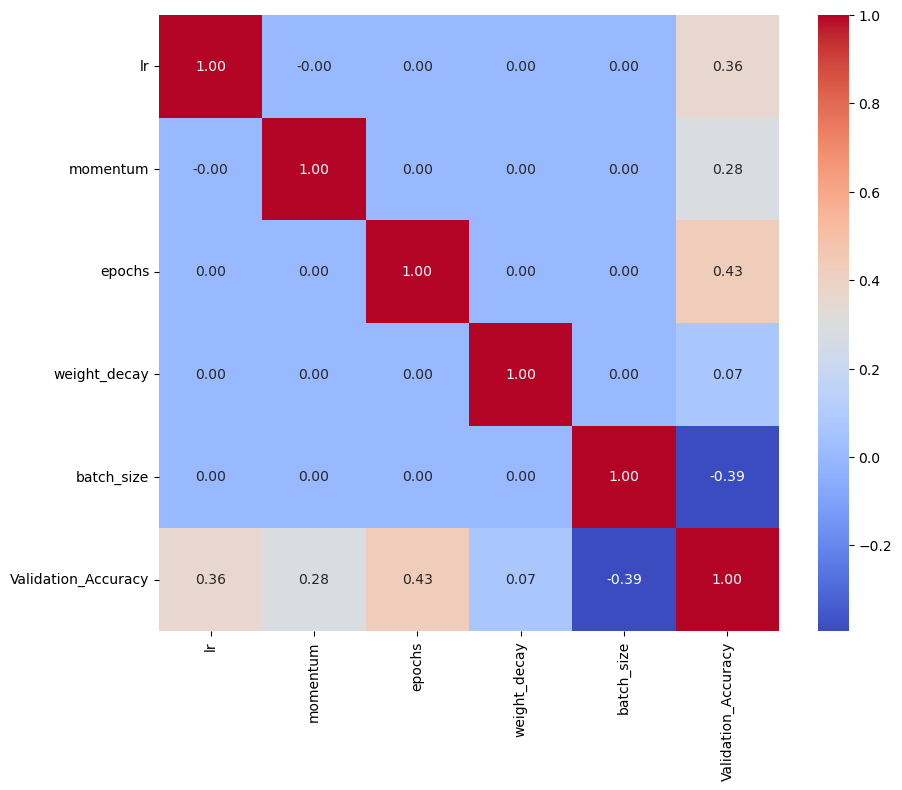

In [313]:
print("Densenet")
correlation_matrix = df.corr()

#  heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

# Regression analysis of hyperparameters and validation accuracy for Densenet

In [353]:
print("Densenet")
# https://www.statsmodels.org/0.6.1/examples/notebooks/generated/interactions_anova.html
#https://www.pythonfordatascience.org/factorial-anova-python/

X = df.drop('Validation_Accuracy', axis=1)  # Independent variables
y = df['Validation_Accuracy']  # Dependent variable
X=X.astype(float)
# Fit the regression model
#model = sm.OLS(y, X).fit()
x_names = X.columns
for i, var in enumerate(x_names):
    #print(i, var)
    var_table = 'x'+str(i+1)+' = ' + var
    print(var_table)
# Get the summary of the regression
#print(model.summary())

# To get standardized coefficients, you can standardize your features before fitting the model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Note: Do not standardize the constant (intercept) term
X_scaled = sm.add_constant(X_scaled)

# Fit the regression model on the standardized features
#model_standardized = sm.OLS(y, X_scaled).fit()
# https://github.com/statsmodels/statsmodels/issues/5492
model_standardized = sm.OLS(y, X_scaled).fit()
print(model_standardized.summary()) 

Densenet
x1 = lr
x2 = momentum
x3 = epochs
x4 = weight_decay
x5 = batch_size
                             OLS Regression Results                            
Dep. Variable:     Validation_Accuracy   R-squared:                       0.552
Model:                             OLS   Adj. R-squared:                  0.499
Method:                  Least Squares   F-statistic:                     10.36
Date:                 Tue, 09 Apr 2024   Prob (F-statistic):           1.60e-06
Time:                         21:13:27   Log-Likelihood:                 117.46
No. Observations:                   48   AIC:                            -222.9
Df Residuals:                       42   BIC:                            -211.7
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

## For Densenet weight_decay is not significant

# Factorial ANOVA analysis of hyperparameters and validation accuracy for Densenet

In [355]:
model = ols("Validation_Accuracy ~ C(lr,Sum) + C(momentum,Sum) + C(epochs,Sum) + C(weight_decay,Sum) + \
            C(batch_size,Sum) + C(lr, Sum) *  C(epochs, Sum) + C(lr, Sum) *  C(weight_decay, Sum) + \
            C(lr, Sum) *  C(batch_size, Sum) +  C(momentum, Sum) *  C(epochs, Sum) + \
            C(momentum, Sum) *  C(weight_decay, Sum) + C(momentum, Sum) *  C(batch_size, Sum) + \
            C(epochs, Sum) *  C(lr, Sum) + C(epochs, Sum) *  C(momentum, Sum) + C(epochs, Sum) *  C(weight_decay, Sum) + C(epochs, Sum) *  C(batch_size, Sum) + C(weight_decay, Sum) *  C(lr, Sum) + C(weight_decay, Sum) *  C(momentum, Sum) + C(weight_decay, Sum) *  C(epochs, Sum) + C(weight_decay, Sum) *  C(batch_size, Sum) + C(batch_size, Sum) *  C(lr, Sum) + C(batch_size, Sum) *  C(momentum, Sum) + C(batch_size, Sum) *  C(epochs, Sum) + C(batch_size, Sum) *  C(weight_decay, Sum)", data=df).fit()

#model = ols('"'+string+'"', data=df).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
print("aov_table")
#print(type(aov_table))
print(aov_table)
print()
print("Terms with p-value < .05:")
print(aov_table.loc[aov_table['PR(>F)'] < .05]) 

print()
print("Terms with p-value < .01:")
print(aov_table.loc[aov_table['PR(>F)'] < .01]) 
model = ols("Validation_Accuracy ~ C(lr,Sum) + C(momentum,Sum) + C(epochs,Sum) + C(weight_decay,Sum) + \
            C(batch_size,Sum) + C(lr, Sum) *  C(epochs, Sum) + C(lr, Sum) *  C(weight_decay, Sum) + \
            C(lr, Sum) *  C(batch_size, Sum) +  C(momentum, Sum) *  C(epochs, Sum) + \
            C(momentum, Sum) *  C(weight_decay, Sum) + C(momentum, Sum) *  C(batch_size, Sum) + \
            C(epochs, Sum) *  C(lr, Sum) + C(epochs, Sum) *  C(momentum, Sum) + C(epochs, Sum) *  C(weight_decay, Sum) + C(epochs, Sum) *  C(batch_size, Sum) + C(weight_decay, Sum) *  C(lr, Sum) + C(weight_decay, Sum) *  C(momentum, Sum) + C(weight_decay, Sum) *  C(epochs, Sum) + C(weight_decay, Sum) *  C(batch_size, Sum) + C(batch_size, Sum) *  C(lr, Sum) + C(batch_size, Sum) *  C(momentum, Sum) + C(batch_size, Sum) *  C(epochs, Sum) + C(batch_size, Sum) *  C(weight_decay, Sum)", data=df).fit()

#model = ols('"'+string+'"', data=df).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
aov_table
print("Main effects")
model = ols("Validation_Accuracy ~ C(lr,Sum) + C(momentum,Sum) + C(epochs,Sum) + C(weight_decay,Sum) + \
            C(batch_size,Sum)", data=df).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

aov_table
                                            sum_sq    df              F  \
Intercept                                36.325148   1.0  114978.837001   
C(lr, Sum)                                0.006055   1.0      19.167125   
C(momentum, Sum)                          0.003935   2.0       6.227820   
C(epochs, Sum)                            0.008626   1.0      27.304677   
C(weight_decay, Sum)                      0.000227   1.0       0.718019   
C(batch_size, Sum)                        0.007284   1.0      23.056396   
C(lr, Sum):C(epochs, Sum)                 0.002779   1.0       8.795736   
C(lr, Sum):C(weight_decay, Sum)           0.000101   1.0       0.319120   
C(lr, Sum):C(batch_size, Sum)             0.002042   1.0       6.462173   
C(momentum, Sum):C(epochs, Sum)           0.002423   2.0       3.834422   
C(momentum, Sum):C(weight_decay, Sum)     0.002580   2.0       4.083735   
C(momentum, Sum):C(batch_size, Sum)       0.001100   2.0       1.740199   
C(epochs, Sum):

sum_sq    df             F        PR(>F)
Intercept             36.325148   1.0  71266.950400  4.631913e-68
C(lr, Sum)             0.006055   1.0     11.880295  1.323788e-03
C(momentum, Sum)       0.003935   2.0      3.860169  2.910772e-02
C(epochs, Sum)         0.008626   1.0     16.924167  1.826824e-04
C(weight_decay, Sum)   0.000227   1.0      0.445047  5.084337e-01
C(batch_size, Sum)     0.007284   1.0     14.290969  5.000006e-04
Residual               0.020898  41.0           NaN           NaN

# Graphical display of interactions found for hyperparameters of Densenet

In [321]:
list_of_sets = []
#https://www.statsmodels.org/dev/examples/notebooks/generated/categorical_interaction_plot.html
# adapted into function

from statsmodels.graphics.factorplots import interaction_plot

def show_interaction(var, other, model_name):
    color_values = ["red", "blue", "black"]
    marker_values = ["D", "^", "s"]

    color_list = []
    marker_list = []

    list_of_sets = []
    color_list = []
    marker_list = []
    num_trace_values=len(pd.unique(df[var]))
    #print("num_trace_values=: ", num_trace_values)
    for i in range(num_trace_values):
        color_list.append(color_values[i])

        marker_list.append(marker_values[i])

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.title.set_text("Densenet")
    #plt.title('Densenet')
    fig = interaction_plot(
        x=df[other],
        trace=df[var],
        response=df['Validation_Accuracy'],

        colors=color_list,
        markers=marker_list,
        ms=10,
        ax=ax,
    )

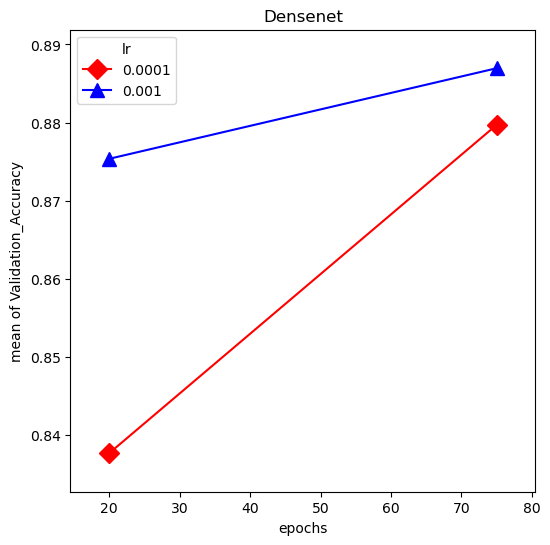

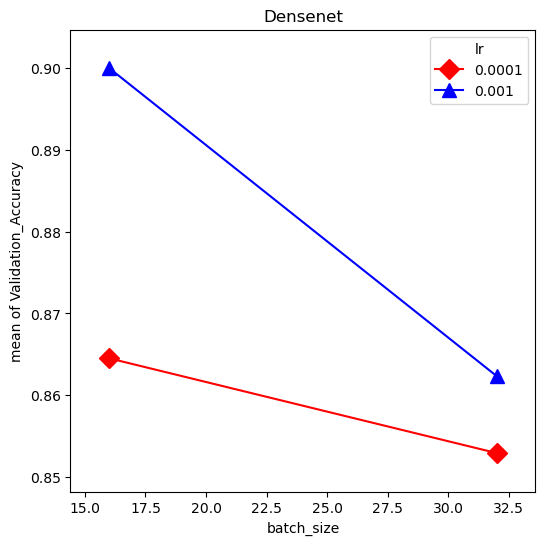

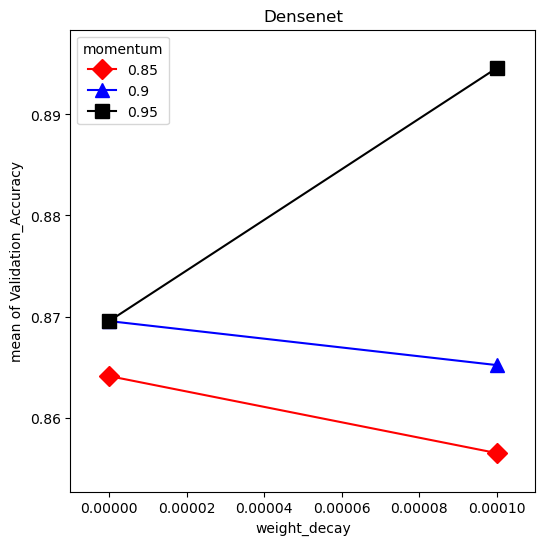

In [323]:
show_interaction('lr', 'epochs', "Densenet")
show_interaction('lr', 'batch_size', "Densenet")
show_interaction('momentum', 'weight_decay', "Densenet")

In [ ]:
#########################################################################################################

# Using grid search selected hyperparameters to train models.

## Using grid selected parameters to train a MOBILENET model

{'lr': [0.001], 'momentum': [0.9], 'epochs': [20], 'weight_decay': [0.0], 'optimizer': ['Adam'], 'batch_size': [16]}
start time:  2024_04_02_2335
mobilenet
Model number:  1  current_params:  {'lr': 0.001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/20:
Train Loss: 0.5227, Train Accuracy: 0.7367
Testing Loss: 0.4675 Testing Accuracy: 0.8421
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.3301, Train Accuracy: 0.8531
Testing Loss: 0.3834 Testing Accuracy: 0.8772
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.2997, Train Accuracy: 0.8792
Testing Loss: 0.5330 Testing Accuracy: 0.8246
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.1868, Train Accuracy: 0.9195
Testing Loss: 0.4251 Testing Accuracy: 0.8596
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.1528, Train Accuracy: 0.9456
Testing Loss: 0.6893 Testing Accuracy: 0.8246
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.1334, Train Accuracy: 0.9641
Testing Loss: 0.4315 Testing Accuracy: 0.8860
Finished Epoc

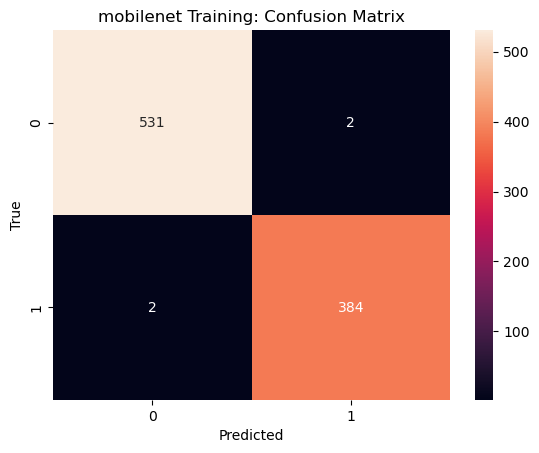

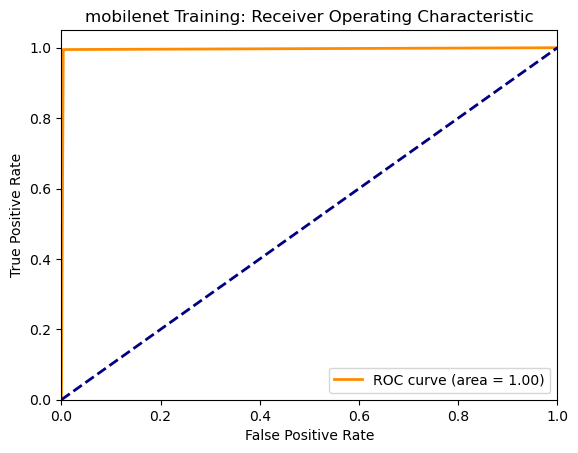

Testing data results:
Accuracy: 90.35%
Precision: 0.90
Recall: 0.90
F1 Score: 0.90


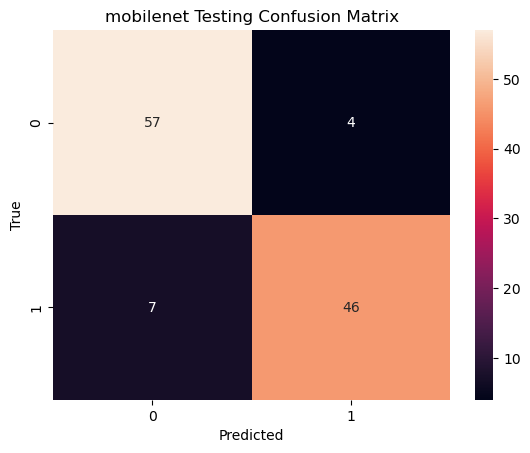

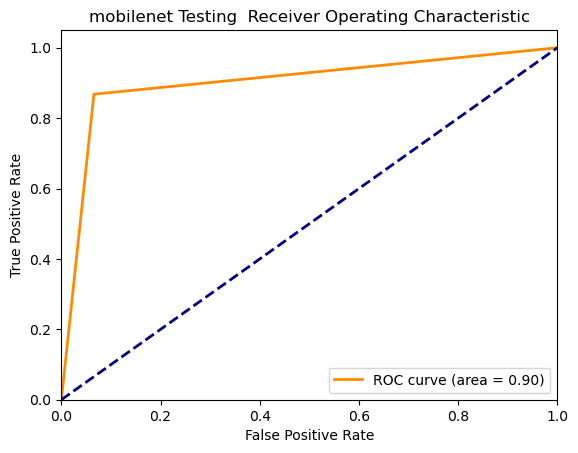

TRAINING and Testing data results:
{"{'lr': 0.001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.9956474428726877, 'train_precision': 0.9956474428726877, 'train_recall': 0.9956474428726877, 'train_f1': 0.9956474428726877, 'valid_accuracy': 0.9035087719298246, 'valid_precision': 0.904281798245614, 'valid_recall': 0.9035087719298246, 'valid_f1': 0.9032614546073925}}


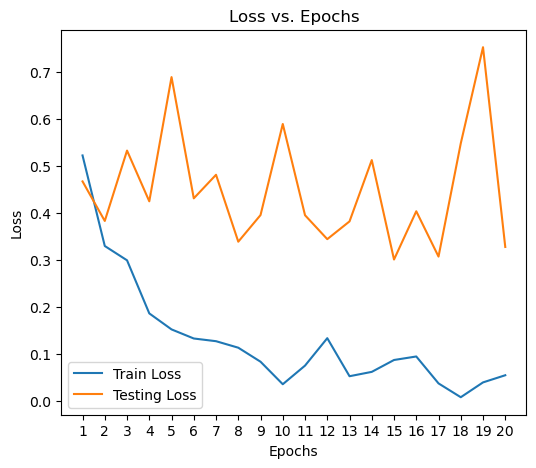

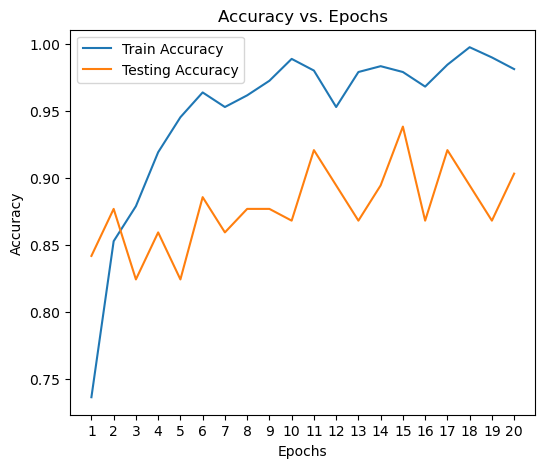

Best params:
  Model_Name                                    Hyperparameters  \
0  mobilenet  {'lr': 0.001, 'momentum': 0.9, 'epochs': 20, '...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0        0.995647         0.995647      0.995647  0.995647   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.903509              0.904282           0.903509       0.903261  
run time: 0:04:46.877255


In [13]:
#sort
model_name='mobilenet'
best_params=params_mobilenet.sort_values(['Validation_Accuracy', 'Validation_Recall', 'Validation_Precision',
                                               'Validation_F1'], ascending=[False, False, False, False])
#get top row
best=best_params.iloc[0] 
#get hyperparameters in top row
best_hyper_params=best['Hyperparameters']

# convert string of parameters to dictionary using eval()
#https://www.geeksforgeeks.org/python-program-to-create-a-dictionary-from-a-string/
# Create a new dictionary with the same keys and the values wrapped in a list
param_grid = {key: [value] for key, value in eval(best_hyper_params).items()}

print(param_grid) 

#Using best hyperparameters
# build model on training dataset and show results on testing dataset
mobilenet_class_model=test_model_parameters(model_name, param_grid, train_dataset, 
                                            test_dataset, device, 
                                            valid_ds_name = 'Testing',
                                           to_print=1, make_plots=1, write_csv=1, return_type='model')

## Using grid selected hyperparameters to train a RESNET model

{'lr': [0.0001], 'momentum': [0.9], 'epochs': [20], 'weight_decay': [0.0], 'optimizer': ['Adam'], 'batch_size': [16]}
start time:  2024_04_02_2340
resnet18
Model number:  1  current_params:  {'lr': 0.0001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/20:
Train Loss: 0.4504, Train Accuracy: 0.7758
Testing Loss: 0.4486 Testing Accuracy: 0.7807
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.1804, Train Accuracy: 0.9271
Testing Loss: 0.4414 Testing Accuracy: 0.8070
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.0915, Train Accuracy: 0.9684
Testing Loss: 0.5306 Testing Accuracy: 0.8158
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.0897, Train Accuracy: 0.9674
Testing Loss: 0.5847 Testing Accuracy: 0.8772
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.0829, Train Accuracy: 0.9717
Testing Loss: 0.2741 Testing Accuracy: 0.8860
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0550, Train Accuracy: 0.9815
Testing Loss: 0.3824 Testing Accuracy: 0.8860
Finished Epo

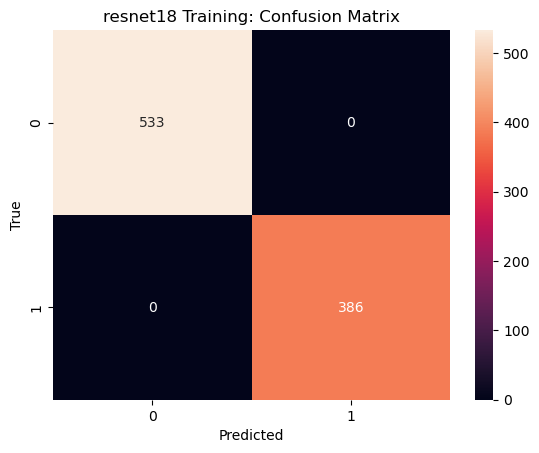

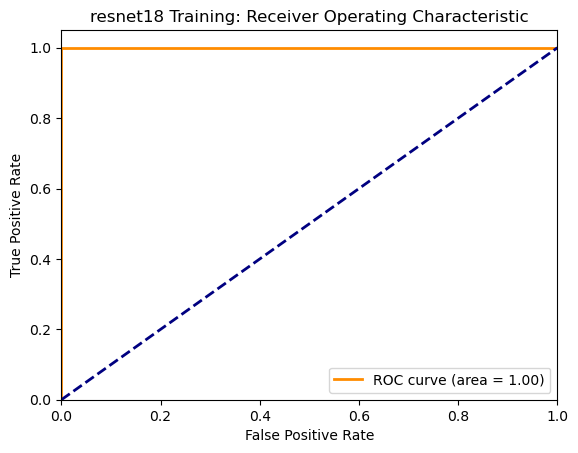

Testing data results:
Accuracy: 92.98%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93


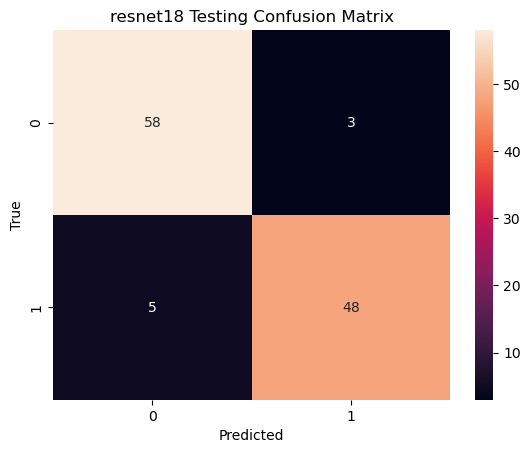

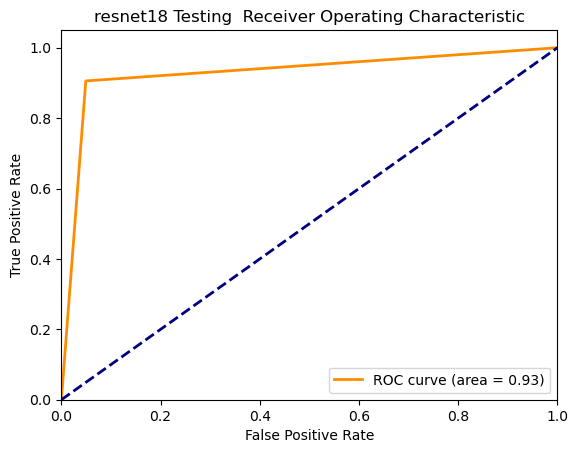

TRAINING and Testing data results:
{"{'lr': 0.0001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'resnet18', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.9298245614035088, 'valid_precision': 0.9301849394728652, 'valid_recall': 0.9298245614035088, 'valid_f1': 0.9297157285272734}}


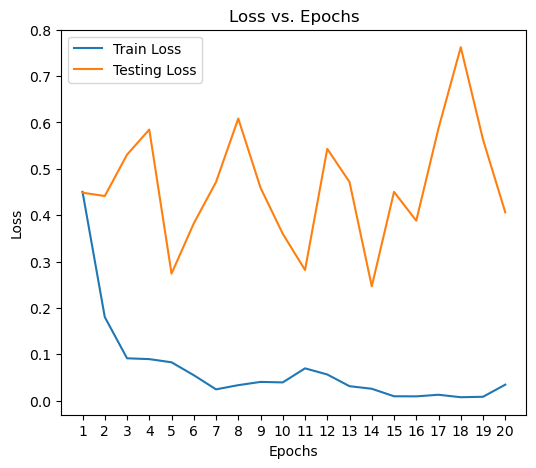

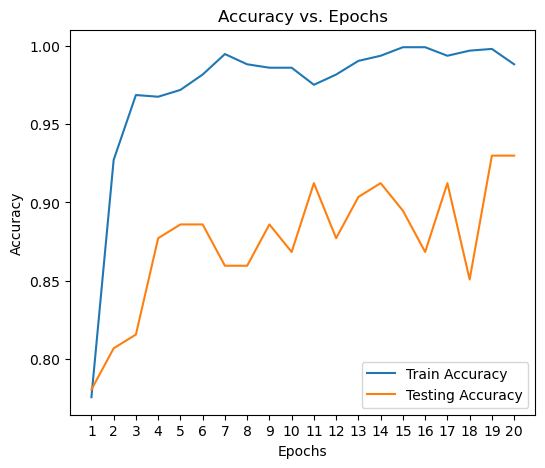

Best params:
  Model_Name                                    Hyperparameters  \
0   resnet18  {'lr': 0.0001, 'momentum': 0.9, 'epochs': 20, ...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0             1.0              1.0           1.0       1.0   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.929825              0.930185           0.929825       0.929716  
run time: 0:04:47.388168


In [14]:
#sort
model_name = 'resnet18'
best_params=params_resnet.sort_values(['Validation_Accuracy', 'Validation_Recall', 'Validation_Precision',
                                               'Validation_F1'], ascending=[False, False, False, False])
#get top row
best=best_params.iloc[0] 
#get hyperparameters in top row
best_hyper_params=best['Hyperparameters']

# convert string of parameters to dictionary using eval()
#https://www.geeksforgeeks.org/python-program-to-create-a-dictionary-from-a-string/
# Create a new dictionary with the same keys and the values wrapped in a list
param_grid = {key: [value] for key, value in eval(best_hyper_params).items()}


print(param_grid) 

#Using best hyperparameters
# build model on training dataset and show results on testing dataset
resnet_class_model=test_model_parameters(model_name, param_grid, train_dataset, 
                                            test_dataset, device, 
                                            valid_ds_name = 'Testing',
                                           to_print=1, make_plots=1, write_csv=1, return_type='model')

## Using grid selected hyperparameters to train a DENSENET model.

{'lr': [0.0001], 'momentum': [0.9], 'epochs': [20], 'weight_decay': [0.0], 'optimizer': ['Adam'], 'batch_size': [16]}
start time:  2024_04_02_2344
densenet
Model number:  1  current_params:  {'lr': 0.0001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/20:
Train Loss: 0.4675, Train Accuracy: 0.7682
Testing Loss: 0.4976 Testing Accuracy: 0.7456
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.1880, Train Accuracy: 0.9347
Testing Loss: 0.4500 Testing Accuracy: 0.8596
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.1276, Train Accuracy: 0.9597
Testing Loss: 0.3454 Testing Accuracy: 0.8947
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.0696, Train Accuracy: 0.9837
Testing Loss: 0.2756 Testing Accuracy: 0.9298
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.0808, Train Accuracy: 0.9739
Testing Loss: 0.5494 Testing Accuracy: 0.8596
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0749, Train Accuracy: 0.9804
Testing Loss: 0.4386 Testing Accuracy: 0.8421
Finished Epo

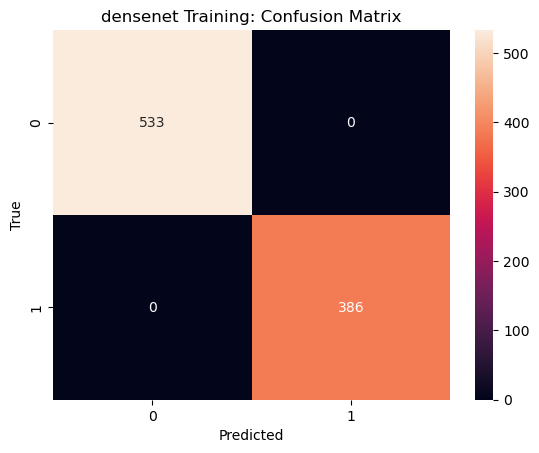

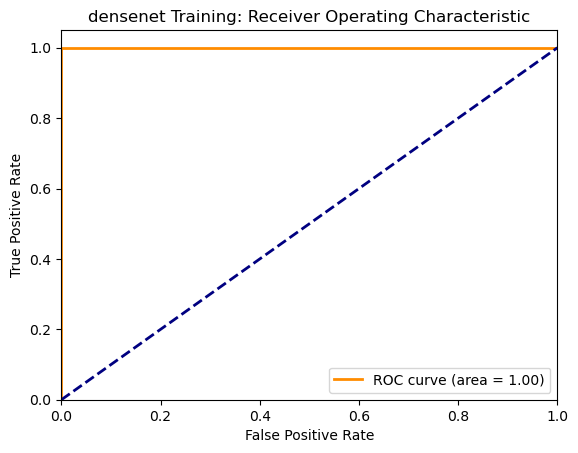

Testing data results:
Accuracy: 85.96%
Precision: 0.87
Recall: 0.86
F1 Score: 0.86


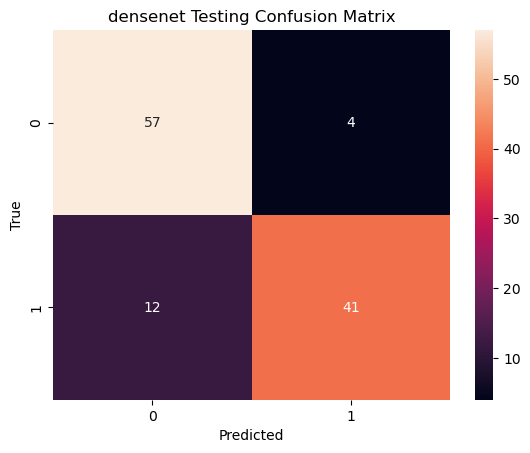

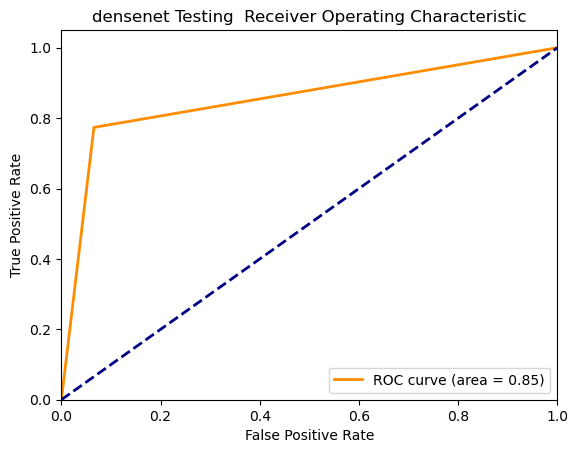

TRAINING and Testing data results:
{"{'lr': 0.0001, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'densenet', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8596491228070176, 'valid_precision': 0.8656157301466226, 'valid_recall': 0.8596491228070176, 'valid_f1': 0.8582390041036658}}


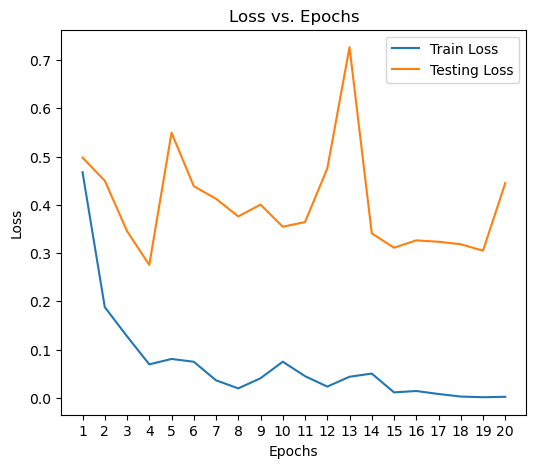

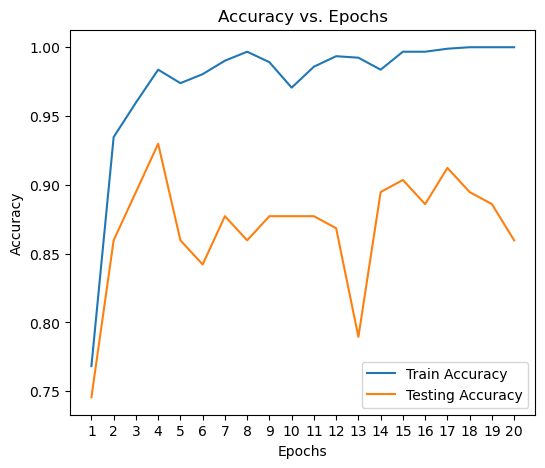

Best params:
  Model_Name                                    Hyperparameters  \
0   densenet  {'lr': 0.0001, 'momentum': 0.9, 'epochs': 20, ...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0             1.0              1.0           1.0       1.0   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.859649              0.865616           0.859649       0.858239  
run time: 0:05:04.732295


In [15]:
#sort
model_name = 'densenet'
best_params=params_resnet.sort_values(['Validation_Accuracy', 'Validation_Recall', 'Validation_Precision',
                                               'Validation_F1'], ascending=[False, False, False, False])
#get top row
best=best_params.iloc[0] 
#get hyperparameters in top row
best_hyper_params=best['Hyperparameters']

# convert string of parameters to dictionary using eval()
#https://www.geeksforgeeks.org/python-program-to-create-a-dictionary-from-a-string/
# Create a new dictionary with the same keys and the values wrapped in a list
param_grid = {key: [value] for key, value in eval(best_hyper_params).items()}

print(param_grid) 

#Using best hyperparameters
# build model on training dataset and show results on testing dataset
densenet_class_model=test_model_parameters(model_name, param_grid, train_dataset, 
                                            test_dataset, device, 
                                            valid_ds_name = 'Testing',
                                           to_print=1, make_plots=1, write_csv=1, return_type='model')

In [ ]:
model_name = 'densenet'
param_grid = {
        'lr': [.001, .0001],
        'momentum': [.9,.95],
        'epochs': [20,75],
        'weight_decay': [.0, .0001],  
        'optimizer': ['SGD'],  
        'batch_size': [16,32]  
    }
    
params_densenet_SGD = test_model_parameters(model_name, param_grid, train_dataset, valid_dataset, device, 
                                            valid_ds_name = 'Validation',
                                            to_print=1, make_plots=0, write_csv=1, return_type='results_df')

# Using grid selected parameters to train MODELS model RUNNING 100 EPOCHS

## Using grid selected parameters to train a MOBILENET model RUNNING 100 EPOCHS

{'lr': [0.001], 'momentum': [0.9], 'epochs': [100], 'weight_decay': [0.0], 'optimizer': ['Adam'], 'batch_size': [16]}
start time:  2024_04_03_0436
mobilenet
Model number:  1  current_params:  {'lr': 0.001, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/100:
Train Loss: 0.5122, Train Accuracy: 0.7443
Testing Loss: 0.4334 Testing Accuracy: 0.7719
Finished Epoch 1
Epoch 2/100:
Train Loss: 0.3358, Train Accuracy: 0.8640
Testing Loss: 0.4920 Testing Accuracy: 0.7982
Finished Epoch 2
Epoch 3/100:
Train Loss: 0.2601, Train Accuracy: 0.9053
Testing Loss: 0.5528 Testing Accuracy: 0.8860
Finished Epoch 3
Epoch 4/100:
Train Loss: 0.1657, Train Accuracy: 0.9423
Testing Loss: 0.3574 Testing Accuracy: 0.8596
Finished Epoch 4
Epoch 5/100:
Train Loss: 0.1436, Train Accuracy: 0.9336
Testing Loss: 0.5574 Testing Accuracy: 0.8772
Finished Epoch 5
Epoch 6/100:
Train Loss: 0.1197, Train Accuracy: 0.9597
Testing Loss: 0.5031 Testing Accuracy: 0.8246
Finis

Testing Loss: 0.6313 Testing Accuracy: 0.8772
Finished Epoch 66
Epoch 67/100:
Train Loss: 0.0199, Train Accuracy: 0.9946
Testing Loss: 0.3583 Testing Accuracy: 0.8772
Finished Epoch 67
Epoch 68/100:
Train Loss: 0.0060, Train Accuracy: 1.0000
Testing Loss: 0.4038 Testing Accuracy: 0.9035
Finished Epoch 68
Epoch 69/100:
Train Loss: 0.0012, Train Accuracy: 1.0000
Testing Loss: 0.4506 Testing Accuracy: 0.8860
Finished Epoch 69
Epoch 70/100:
Train Loss: 0.0005, Train Accuracy: 1.0000
Testing Loss: 0.4675 Testing Accuracy: 0.8860
Finished Epoch 70
Epoch 71/100:
Train Loss: 0.0006, Train Accuracy: 1.0000
Testing Loss: 0.4584 Testing Accuracy: 0.8860
Finished Epoch 71
Epoch 72/100:
Train Loss: 0.0003, Train Accuracy: 1.0000
Testing Loss: 0.4845 Testing Accuracy: 0.8772
Finished Epoch 72
Epoch 73/100:
Train Loss: 0.0002, Train Accuracy: 1.0000
Testing Loss: 0.4542 Testing Accuracy: 0.8860
Finished Epoch 73
Epoch 74/100:
Train Loss: 0.0002, Train Accuracy: 1.0000
Testing Loss: 0.4903 Testing Acc

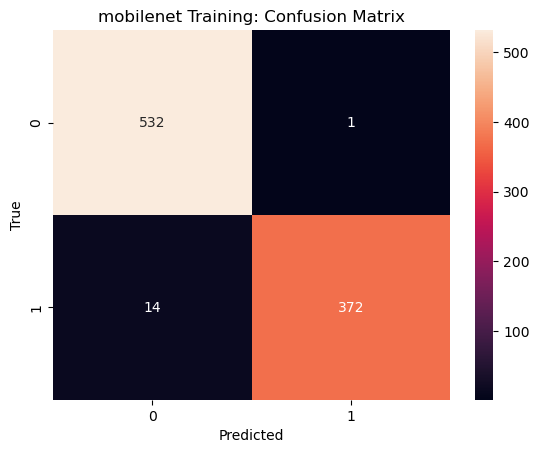

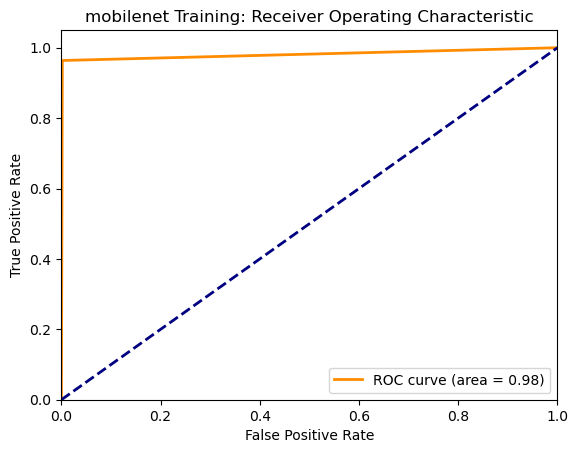

Testing data results:
Accuracy: 85.09%
Precision: 0.86
Recall: 0.85
F1 Score: 0.85


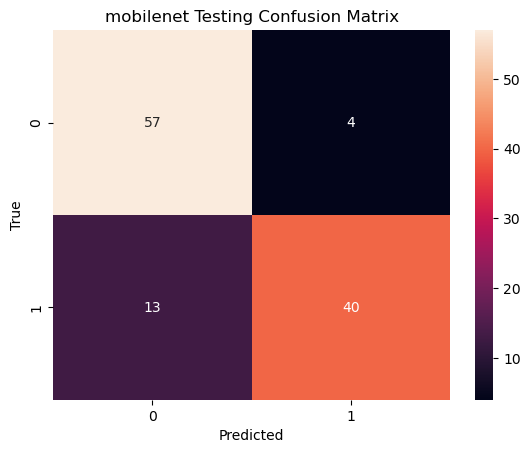

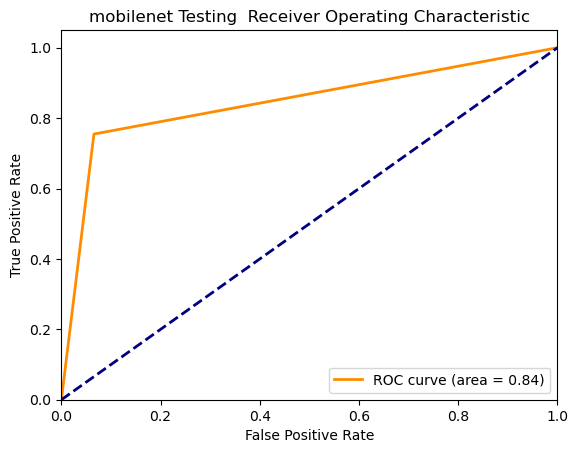

TRAINING and Testing data results:
{"{'lr': 0.001, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.9836779107725789, 'train_precision': 0.9840026994411496, 'train_recall': 0.9836779107725789, 'train_f1': 0.9836364558735139, 'valid_accuracy': 0.8508771929824561, 'valid_precision': 0.8583618136249715, 'valid_recall': 0.8508771929824561, 'valid_f1': 0.8490816637880213}}


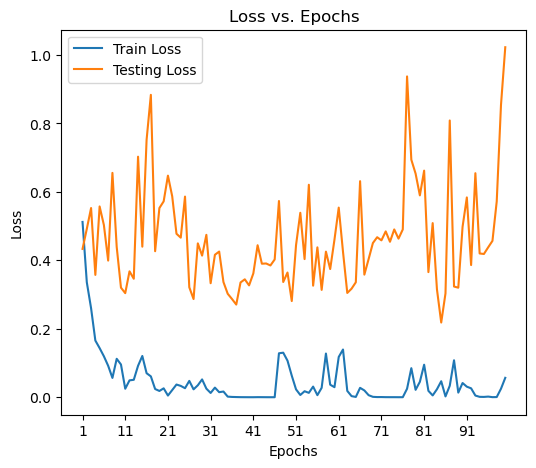

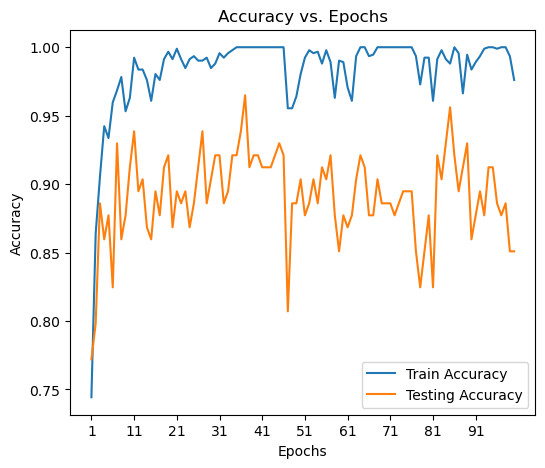

Best params:
  Model_Name                                    Hyperparameters  \
0  mobilenet  {'lr': 0.001, 'momentum': 0.9, 'epochs': 100, ...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0        0.983678         0.984003      0.983678  0.983636   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.850877              0.858362           0.850877       0.849082  
run time: 0:23:08.151211


In [38]:
#sort
model_name='mobilenet'
best_params=params_mobilenet.sort_values(['Validation_Accuracy', 'Validation_Recall', 'Validation_Precision',
                                               'Validation_F1'], ascending=[False, False, False, False])
#get top row
best=best_params.iloc[0] 
#get hyperparameters in top row
best_hyper_params=best['Hyperparameters']

# convert string of parameters to dictionary using eval()
#https://www.geeksforgeeks.org/python-program-to-create-a-dictionary-from-a-string/
# Create a new dictionary with the same keys and the values wrapped in a list
param_grid = {key: [value] for key, value in eval(best_hyper_params).items()}

#trying with 100 epochs
param_grid.update(epochs=[100])
print(param_grid) 

#Using best hyperparameters
# build model on training dataset and show results on testing dataset
mobilenet_class_model_100=test_model_parameters(model_name, param_grid, train_dataset, 
                                            test_dataset, device, 
                                            valid_ds_name = 'Testing',
                                           to_print=1, make_plots=1, write_csv=1, return_type='model')

## Using grid selected parameters to train a RESNET model RUNNING 100 EPOCHS

{'lr': [0.0001], 'momentum': [0.9], 'epochs': [100], 'weight_decay': [0.0], 'optimizer': ['Adam'], 'batch_size': [16]}
start time:  2024_04_03_0413
resnet18
Model number:  1  current_params:  {'lr': 0.0001, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/100:
Train Loss: 0.4523, Train Accuracy: 0.7748
Testing Loss: 0.4297 Testing Accuracy: 0.7982
Finished Epoch 1
Epoch 2/100:
Train Loss: 0.1808, Train Accuracy: 0.9227
Testing Loss: 0.4910 Testing Accuracy: 0.8158
Finished Epoch 2
Epoch 3/100:
Train Loss: 0.0941, Train Accuracy: 0.9684
Testing Loss: 0.6815 Testing Accuracy: 0.8158
Finished Epoch 3
Epoch 4/100:
Train Loss: 0.0884, Train Accuracy: 0.9717
Testing Loss: 0.5915 Testing Accuracy: 0.8070
Finished Epoch 4
Epoch 5/100:
Train Loss: 0.0954, Train Accuracy: 0.9717
Testing Loss: 0.8222 Testing Accuracy: 0.8509
Finished Epoch 5
Epoch 6/100:
Train Loss: 0.0462, Train Accuracy: 0.9837
Testing Loss: 0.3562 Testing Accuracy: 0.8860
Fini

Testing Loss: 0.2742 Testing Accuracy: 0.9298
Finished Epoch 66
Epoch 67/100:
Train Loss: 0.0005, Train Accuracy: 1.0000
Testing Loss: 0.3048 Testing Accuracy: 0.9123
Finished Epoch 67
Epoch 68/100:
Train Loss: 0.0007, Train Accuracy: 1.0000
Testing Loss: 0.2519 Testing Accuracy: 0.9298
Finished Epoch 68
Epoch 69/100:
Train Loss: 0.0003, Train Accuracy: 1.0000
Testing Loss: 0.2377 Testing Accuracy: 0.9298
Finished Epoch 69
Epoch 70/100:
Train Loss: 0.0003, Train Accuracy: 1.0000
Testing Loss: 0.2581 Testing Accuracy: 0.9298
Finished Epoch 70
Epoch 71/100:
Train Loss: 0.0002, Train Accuracy: 1.0000
Testing Loss: 0.2452 Testing Accuracy: 0.9298
Finished Epoch 71
Epoch 72/100:
Train Loss: 0.0003, Train Accuracy: 1.0000
Testing Loss: 0.2435 Testing Accuracy: 0.9386
Finished Epoch 72
Epoch 73/100:
Train Loss: 0.0005, Train Accuracy: 1.0000
Testing Loss: 0.2369 Testing Accuracy: 0.9386
Finished Epoch 73
Epoch 74/100:
Train Loss: 0.0002, Train Accuracy: 1.0000
Testing Loss: 0.2355 Testing Acc

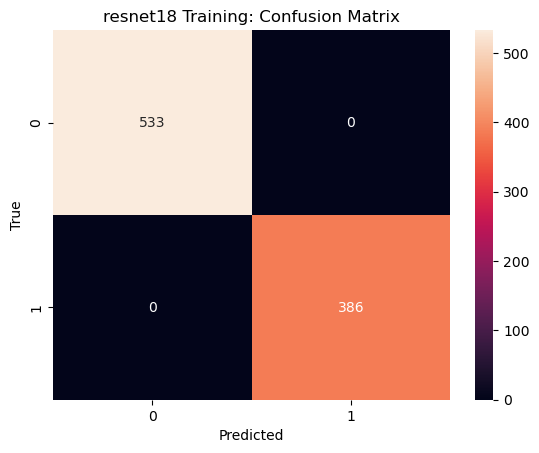

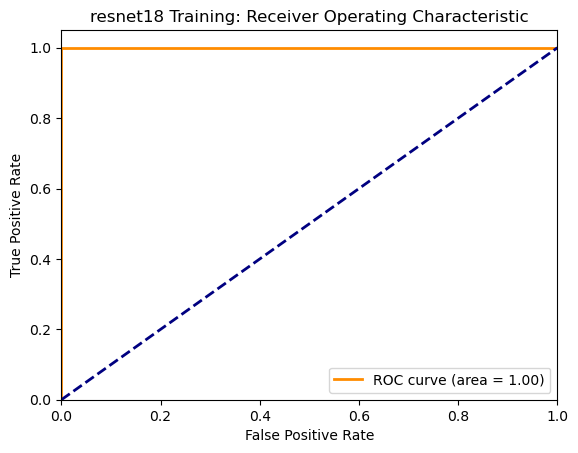

Testing data results:
Accuracy: 93.86%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


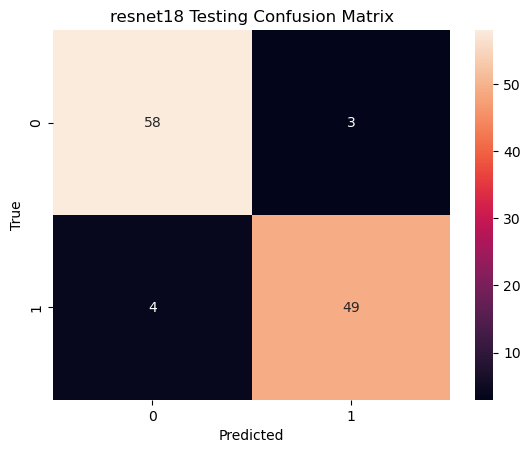

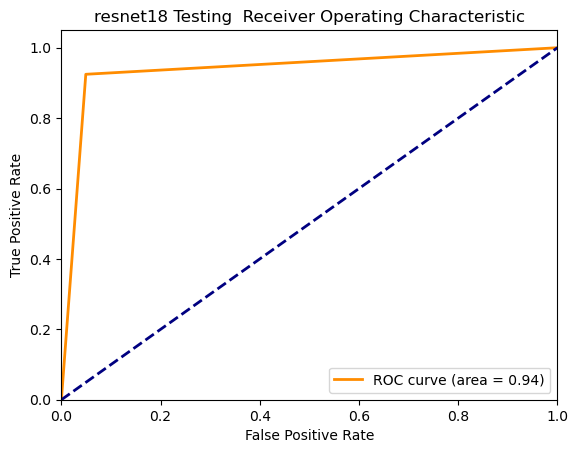

TRAINING and Testing data results:
{"{'lr': 0.0001, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'resnet18', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.9385964912280702, 'valid_precision': 0.9386563493099995, 'valid_recall': 0.9385964912280702, 'valid_f1': 0.938553701326487}}


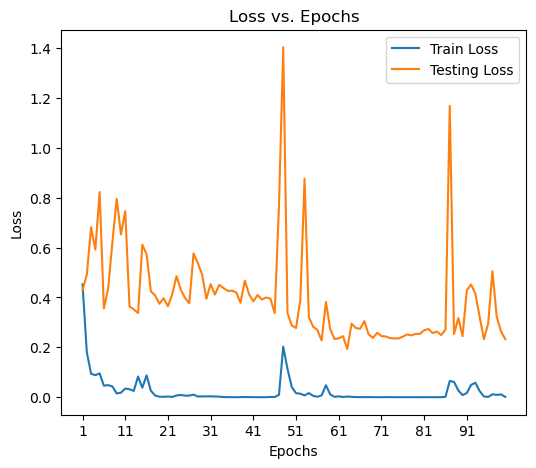

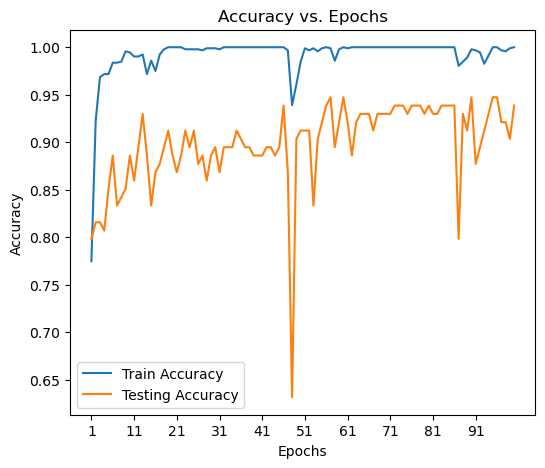

Best params:
  Model_Name                                    Hyperparameters  \
0   resnet18  {'lr': 0.0001, 'momentum': 0.9, 'epochs': 100,...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0             1.0              1.0           1.0       1.0   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.938596              0.938656           0.938596       0.938554  
run time: 0:23:00.119905


In [37]:
#sort
model_name = 'resnet18'
best_params=params_resnet.sort_values(['Validation_Accuracy', 'Validation_Recall', 'Validation_Precision',
                                               'Validation_F1'], ascending=[False, False, False, False])
#get top row
best=best_params.iloc[0] 
#get hyperparameters in top row
best_hyper_params=best['Hyperparameters']

# convert string of parameters to dictionary using eval()
#https://www.geeksforgeeks.org/python-program-to-create-a-dictionary-from-a-string/
# Create a new dictionary with the same keys and the values wrapped in a list
param_grid = {key: [value] for key, value in eval(best_hyper_params).items()}

#trying with 100 epochs
param_grid.update(epochs=[100])

print(param_grid) 

#Using best hyperparameters
# build model on training dataset and show results on testing dataset
resnet_class_model=test_model_parameters(model_name, param_grid, train_dataset, 
                                            test_dataset, device, 
                                            valid_ds_name = 'Testing',
                                           to_print=1, make_plots=1, write_csv=1, return_type='model')

## Using grid selected parameters to train a DENSENET model RUNNING 100 EPOCHS

{'lr': [0.0001], 'momentum': [0.9], 'epochs': [100], 'weight_decay': [0.0], 'optimizer': ['Adam'], 'batch_size': [16]}
start time:  2024_04_03_0250
densenet
Model number:  1  current_params:  {'lr': 0.0001, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/100:
Train Loss: 0.4675, Train Accuracy: 0.7671
Testing Loss: 0.5009 Testing Accuracy: 0.7456
Finished Epoch 1
Epoch 2/100:
Train Loss: 0.1935, Train Accuracy: 0.9380
Testing Loss: 0.3647 Testing Accuracy: 0.8421
Finished Epoch 2
Epoch 3/100:
Train Loss: 0.1195, Train Accuracy: 0.9608
Testing Loss: 0.3448 Testing Accuracy: 0.8596
Finished Epoch 3
Epoch 4/100:
Train Loss: 0.1030, Train Accuracy: 0.9663
Testing Loss: 0.4478 Testing Accuracy: 0.8509
Finished Epoch 4
Epoch 5/100:
Train Loss: 0.0905, Train Accuracy: 0.9674
Testing Loss: 0.2899 Testing Accuracy: 0.8772
Finished Epoch 5
Epoch 6/100:
Train Loss: 0.0679, Train Accuracy: 0.9804
Testing Loss: 0.3658 Testing Accuracy: 0.8772
Fini

Testing Loss: 0.3967 Testing Accuracy: 0.8860
Finished Epoch 66
Epoch 67/100:
Train Loss: 0.0001, Train Accuracy: 1.0000
Testing Loss: 0.4115 Testing Accuracy: 0.8860
Finished Epoch 67
Epoch 68/100:
Train Loss: 0.0001, Train Accuracy: 1.0000
Testing Loss: 0.4011 Testing Accuracy: 0.9123
Finished Epoch 68
Epoch 69/100:
Train Loss: 0.0002, Train Accuracy: 1.0000
Testing Loss: 0.4149 Testing Accuracy: 0.8860
Finished Epoch 69
Epoch 70/100:
Train Loss: 0.0001, Train Accuracy: 1.0000
Testing Loss: 0.4075 Testing Accuracy: 0.8860
Finished Epoch 70
Epoch 71/100:
Train Loss: 0.0001, Train Accuracy: 1.0000
Testing Loss: 0.4159 Testing Accuracy: 0.8947
Finished Epoch 71
Epoch 72/100:
Train Loss: 0.0004, Train Accuracy: 1.0000
Testing Loss: 0.3696 Testing Accuracy: 0.8947
Finished Epoch 72
Epoch 73/100:
Train Loss: 0.0001, Train Accuracy: 1.0000
Testing Loss: 0.3805 Testing Accuracy: 0.8947
Finished Epoch 73
Epoch 74/100:
Train Loss: 0.0002, Train Accuracy: 1.0000
Testing Loss: 0.3832 Testing Acc

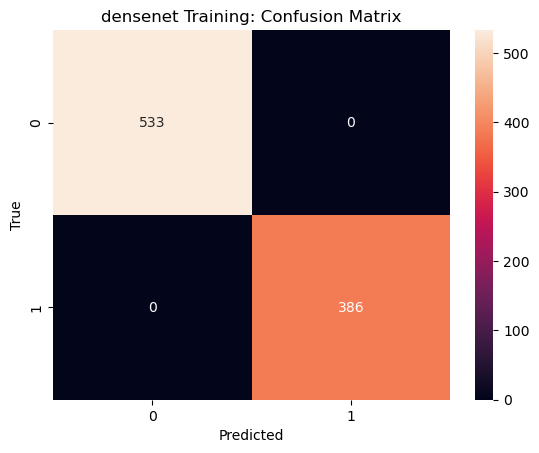

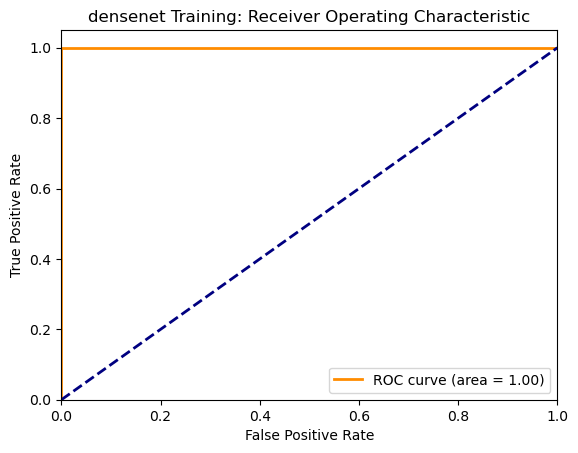

Testing data results:
Accuracy: 87.72%
Precision: 0.88
Recall: 0.88
F1 Score: 0.88


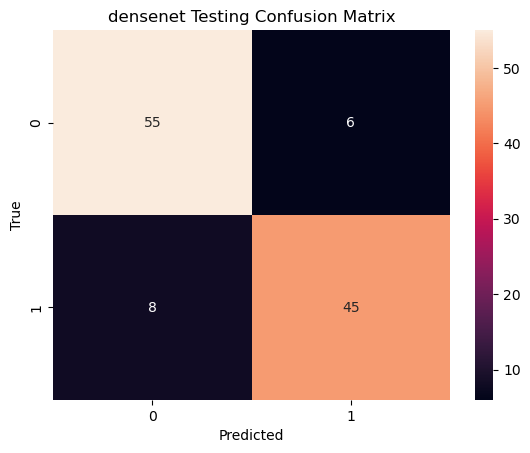

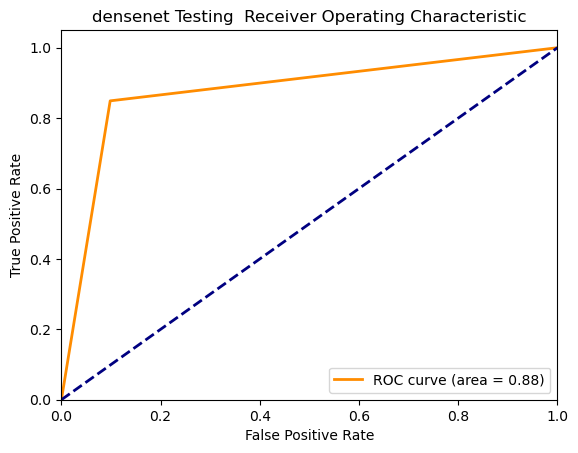

TRAINING and Testing data results:
{"{'lr': 0.0001, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'densenet', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8771929824561403, 'valid_precision': 0.8773567906694841, 'valid_recall': 0.8771929824561403, 'valid_f1': 0.8770025249227288}}


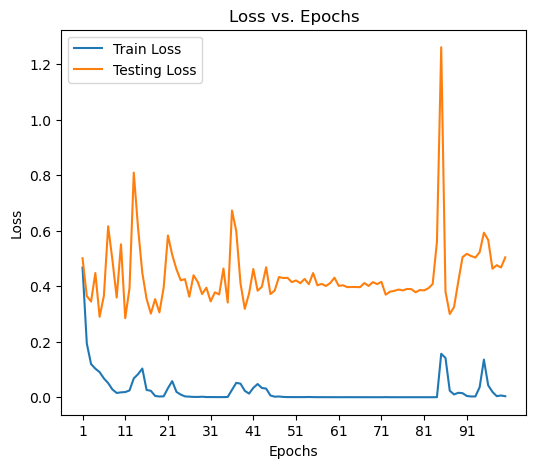

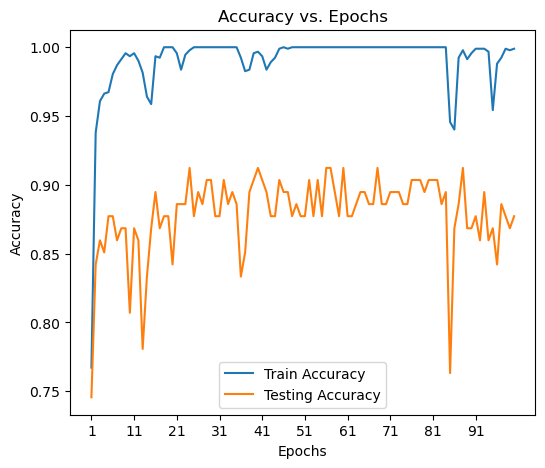

Best params:
  Model_Name                                    Hyperparameters  \
0   densenet  {'lr': 0.0001, 'momentum': 0.9, 'epochs': 100,...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0             1.0              1.0           1.0       1.0   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.877193              0.877357           0.877193       0.877003  
run time: 0:26:12.818667


In [35]:
#sort
model_name = 'densenet'
best_params=params_resnet.sort_values(['Validation_Accuracy', 'Validation_Recall', 'Validation_Precision',
                                               'Validation_F1'], ascending=[False, False, False, False])
#get top row
best=best_params.iloc[0] 
#get hyperparameters in top row
best_hyper_params=best['Hyperparameters']

# convert string of parameters to dictionary using eval()
#https://www.geeksforgeeks.org/python-program-to-create-a-dictionary-from-a-string/
# Create a new dictionary with the same keys and the values wrapped in a list
param_grid = {key: [value] for key, value in eval(best_hyper_params).items()}

#trying with 100 epochs
param_grid.update(epochs=[100])

print(param_grid) 

#Using best hyperparameters
# build model on training dataset and show results on testing dataset
densenet_class_model_100=test_model_parameters(model_name, param_grid, train_dataset, 
                                            test_dataset, device, 
                                            valid_ds_name = 'Testing',
                                           to_print=1, make_plots=1, write_csv=1, return_type='model')

In [ ]:
##########################################################################################################

# Bayesian Optimization

## A limitation of the package obtained by "from bayes_opt import BayesianOptimization" is that, 
#### "There is no principled way of dealing with discrete parameters using this package."
#### "Unfortunately, the nature of bayesian optimization with gaussian processes doesn’t allow 
####    for an easy/intuitive way of dealing with discrete parameters..."
#### They do suggest possibly converting parameters to integers within the function to be optimized, 
####   but the Bayesian pbounds are still passing non-integers, the non-interger values between the integers.

#### source: https://bayesian-optimization.github.io/BayesianOptimization/advanced-tour.html

### Citation for bayes_opt package as per https://github.com/bayesian-optimization/BayesianOptimization?tab=readme-ov-file
@Misc{,
    author = {Fernando Nogueira},
    title = {{Bayesian Optimization}: Open source constrained global optimization tool for {Python}},
    year = {2014--},
    url = " https://github.com/bayesian-optimization/BayesianOptimization"
}

## Objective function that Bayes Optimization uses to maximize

In [7]:
# Define the objective function for Bayesian optimization

# using TEST_PARAMS
# Define the objective function for Bayesian optimization
def objective(lr, weight_decay, momentum=.9):
    param_grid = {
        'lr': [lr],
        'momentum': [momentum],
        'epochs': [epochs],
        'weight_decay': [weight_decay],  # Add weight_decay to the grid
        'optimizer': [optimizer_name],  # Add optimizer to the grid
        'batch_size': [batch_size]  
    }
    
    #accuracy = build_model(lr=lr, momentum=momentum, weight_decay=weight_decay, batch_size=batch_size, epochs=epochs, 
    #                      optimizer=optimizer_name, model_name=model_name)
    accuracy=test_model_parameters(model_name, param_grid, train_dataset, valid_dataset, device, 
                                   to_print=0, make_plots=0, write_csv=0,
                                   return_type='valid_accuracy')
    return accuracy

# Bayesian optimizaton on MOBILENET model
### for lr and weight decay

In [18]:

# Set the random seed for reproducibility
seed = 12345678
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

start_opt = datetime.datetime.now()
print("start time: ", start_opt.strftime("%Y_%m_%d_%H%M"))

epochs=20
batch_size=16

#pbounds does not take strings.
# 'resnet18', 'densenet','mobilenet'
model_name = 'mobilenet'
# optimizer' ='SGD'
optimizer_name = 'Adam'
#lr, momentum, weight_decay, batch_size, epochs,
# Define the parameter bounds, pbounds does not take strings.
# batch, epochs size needs to be a positive integer so does not work here
    
#Adam does not use momentum

pbounds = {
    'lr': (0.0001, 0.01),
    'weight_decay': (0.0001, 0.05),
    # Add other hyperparameters if needed
}
print("epochs: ", epochs)
print("batch_size: ", batch_size)
print("model_name: ", model_name)
print("optimizer_name: ", optimizer_name)
print("pbounds:", pbounds)


# Initialize Bayesian optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=seed
)

#grid search used 9 searches, i.e. models, 
# opt_init_points + opt_n_iter are the number of total searches for bayesian opt
opt_init_points=3
opt_n_iter=6

print("init_points: ", opt_init_points)
print("n_iter: ", opt_n_iter)
# Run optimization
optimizer.maximize(
    init_points=opt_init_points,  # Number of random initial points
    n_iter=opt_n_iter,      # Number of iterations
)

# Extract the best parameters
mobilenet_bayesian_best_params = optimizer.max['params']
print("mobilenet_bayesian_best_params:")
print(mobilenet_bayesian_best_params)

run_time = datetime.datetime.now() - start_opt
print("run time:", run_time)

start time:  2024_04_02_2350
epochs:  20
batch_size:  16
model_name:  mobilenet
optimizer_name:  Adam
pbounds: {'lr': (0.0001, 0.01), 'weight_decay': (0.0001, 0.05)}
init_points:  3
n_iter:  6
|   iter    |  target   |    lr     | weight... |
-------------------------------------------------
Best params:
  Model_Name                                    Hyperparameters  \
0  mobilenet  {'lr': 0.0025334619148665357, 'momentum': 0.9,...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0        0.661589         0.691985      0.661589  0.662238   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.565217               0.60937           0.565217       0.561265  
| 1         | 0.5652    | 0.002533  | 0.02986   |
Best params:
  Model_Name                                    Hyperparameters  \
0  mobilenet  {'lr': 0.0036520371213771643, 'momentum': 0.9,...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0        0.4

# Model trained (on training data) using Bayesian selected parameters for lr and weight decay
#  Results show on TESTING data.

{'lr': [0.00010159905511352873], 'momentum': [0.9], 'epochs': [20], 'weight_decay': [0.010498097548524966], 'optimizer': ['Adam'], 'batch_size': [16]}
start time:  2024_04_03_0032
mobilenet
Model number:  1  current_params:  {'lr': 0.00010159905511352873, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.010498097548524966, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/20:
Train Loss: 0.6167, Train Accuracy: 0.6333
Testing Loss: 0.5897 Testing Accuracy: 0.7807
Finished Epoch 1
Epoch 2/20:
Train Loss: 0.4834, Train Accuracy: 0.7943
Testing Loss: 0.4676 Testing Accuracy: 0.8070
Finished Epoch 2
Epoch 3/20:
Train Loss: 0.3534, Train Accuracy: 0.8564
Testing Loss: 0.3576 Testing Accuracy: 0.8421
Finished Epoch 3
Epoch 4/20:
Train Loss: 0.2257, Train Accuracy: 0.9129
Testing Loss: 0.3310 Testing Accuracy: 0.8596
Finished Epoch 4
Epoch 5/20:
Train Loss: 0.1473, Train Accuracy: 0.9543
Testing Loss: 0.3445 Testing Accuracy: 0.8596
Finished Epoch 5
Epoch 6/20:
Train Loss: 0.0751, Train Accuracy

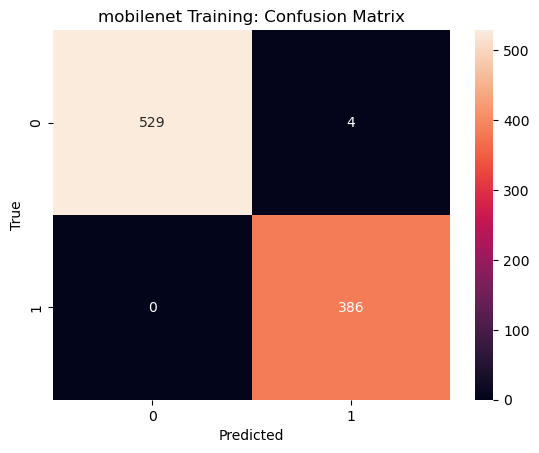

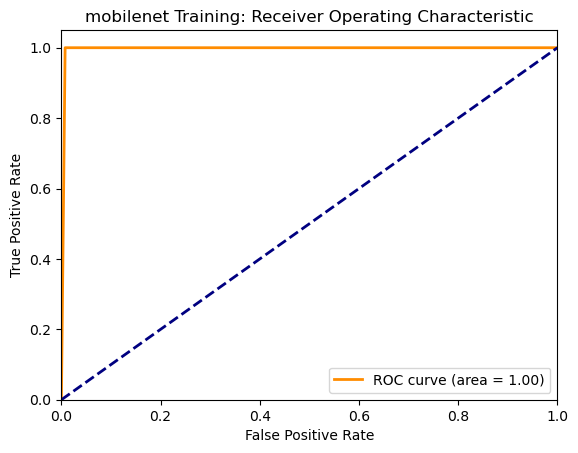

Testing data results:
Accuracy: 86.84%
Precision: 0.87
Recall: 0.87
F1 Score: 0.87


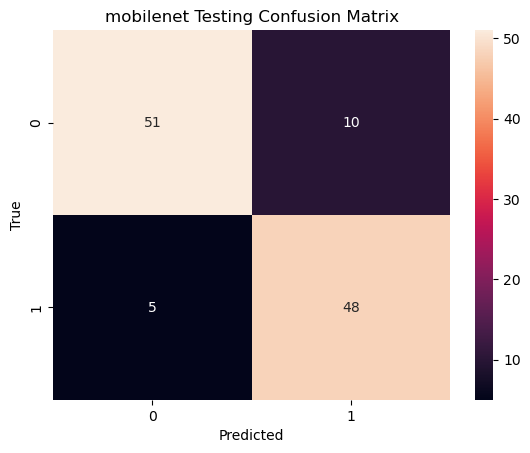

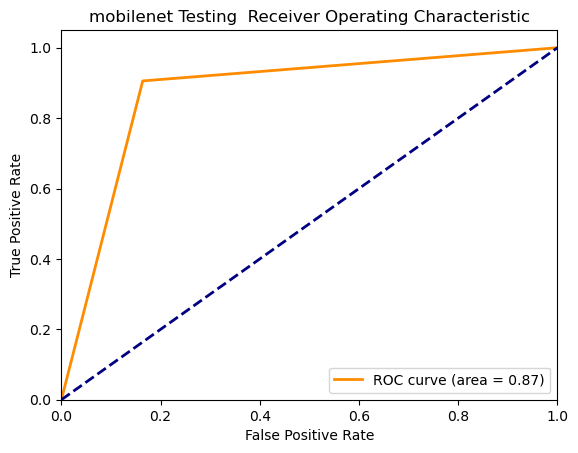

TRAINING and Testing data results:
{"{'lr': 0.00010159905511352873, 'momentum': 0.9, 'epochs': 20, 'weight_decay': 0.010498097548524966, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.9956474428726877, 'train_precision': 0.99569208448425, 'train_recall': 0.9956474428726877, 'train_f1': 0.9956504638973503, 'valid_accuracy': 0.868421052631579, 'valid_precision': 0.8720670210007778, 'valid_recall': 0.868421052631579, 'valid_f1': 0.8685730264677632}}


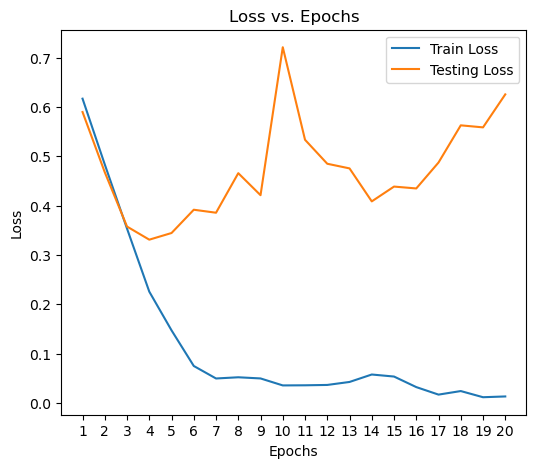

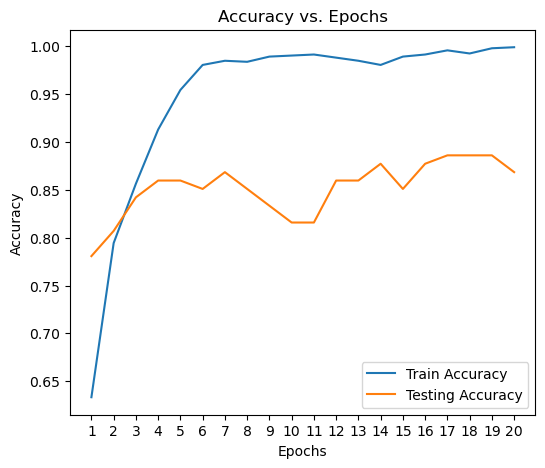

Best params:
  Model_Name                                    Hyperparameters  \
0  mobilenet  {'lr': 0.00010159905511352873, 'momentum': 0.9...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0        0.995647         0.995692      0.995647   0.99565   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.868421              0.872067           0.868421       0.868573  
run time: 0:04:44.661190


In [19]:
model_name = 'mobilenet'
# Use parameters selected by Bayesian Optimization
best_params = mobilenet_bayesian_best_params

#note: momentum not used by Adam optimizer
# epochs increased to 100
param_grid = {
        'lr': [best_params['lr']],
        'momentum': [.9],
        'epochs': [20],
        'weight_decay': [best_params['weight_decay']],  # Add weight_decay to the grid
        'optimizer': ['Adam'],  # Add optimizer to the grid
        'batch_size': [16]  
    }
print(param_grid)


#Using best hyperparameters
# build model on training dataset and show results on testing dataset
mobile_bayes_class_model=test_model_parameters(model_name, param_grid, train_dataset, 
                                            test_dataset, device, 
                                            valid_ds_name = 'Testing',
                                           to_print=1, make_plots=1, write_csv=1, return_type='model')

## Using Bayesian Optimization selected hyperparameters to train a MOBILENET model RUNNING 100 EPOCHS

{'lr': [0.00010159905511352873], 'momentum': [0.9], 'epochs': [100], 'weight_decay': [0.010498097548524966], 'optimizer': ['Adam'], 'batch_size': [16]}
start time:  2024_04_09_2324
mobilenet
Model number:  1  current_params:  {'lr': 0.00010159905511352873, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.010498097548524966, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/100:
Train Loss: 0.6167, Train Accuracy: 0.6268
Testing Loss: 0.5919 Testing Accuracy: 0.7719
Finished Epoch 1
Epoch 2/100:
Train Loss: 0.4824, Train Accuracy: 0.8041
Testing Loss: 0.4625 Testing Accuracy: 0.8070
Finished Epoch 2
Epoch 3/100:
Train Loss: 0.3546, Train Accuracy: 0.8487
Testing Loss: 0.3776 Testing Accuracy: 0.8596
Finished Epoch 3
Epoch 4/100:
Train Loss: 0.2120, Train Accuracy: 0.9195
Testing Loss: 0.3483 Testing Accuracy: 0.8070
Finished Epoch 4
Epoch 5/100:
Train Loss: 0.1515, Train Accuracy: 0.9489
Testing Loss: 0.3685 Testing Accuracy: 0.8684
Finished Epoch 5
Epoch 6/100:
Train Loss: 0.0709, Train 

Epoch 66/100:
Train Loss: 0.0114, Train Accuracy: 0.9978
Testing Loss: 0.4220 Testing Accuracy: 0.9035
Finished Epoch 66
Epoch 67/100:
Train Loss: 0.0080, Train Accuracy: 0.9978
Testing Loss: 0.4263 Testing Accuracy: 0.8772
Finished Epoch 67
Epoch 68/100:
Train Loss: 0.0019, Train Accuracy: 1.0000
Testing Loss: 0.3508 Testing Accuracy: 0.8860
Finished Epoch 68
Epoch 69/100:
Train Loss: 0.0016, Train Accuracy: 1.0000
Testing Loss: 0.3913 Testing Accuracy: 0.8947
Finished Epoch 69
Epoch 70/100:
Train Loss: 0.0018, Train Accuracy: 1.0000
Testing Loss: 0.3765 Testing Accuracy: 0.9035
Finished Epoch 70
Epoch 71/100:
Train Loss: 0.0009, Train Accuracy: 1.0000
Testing Loss: 0.3209 Testing Accuracy: 0.9035
Finished Epoch 71
Epoch 72/100:
Train Loss: 0.0011, Train Accuracy: 1.0000
Testing Loss: 0.4432 Testing Accuracy: 0.8596
Finished Epoch 72
Epoch 73/100:
Train Loss: 0.0234, Train Accuracy: 0.9924
Testing Loss: 0.5489 Testing Accuracy: 0.8947
Finished Epoch 73
Epoch 74/100:
Train Loss: 0.0121

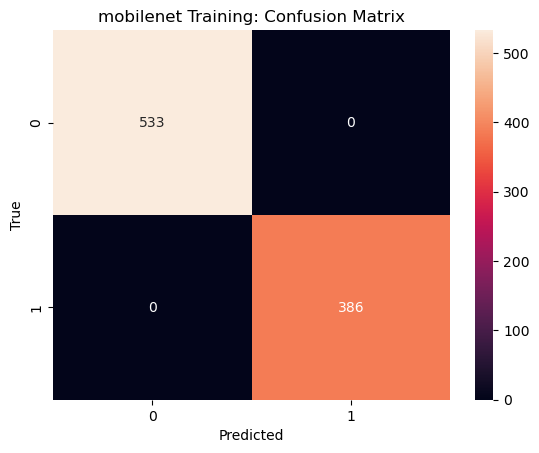

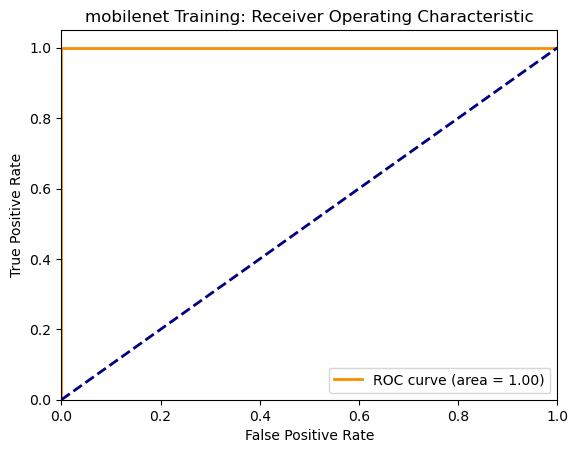

Testing data results:
Accuracy: 89.47%
Precision: 0.89
Recall: 0.89
F1 Score: 0.89


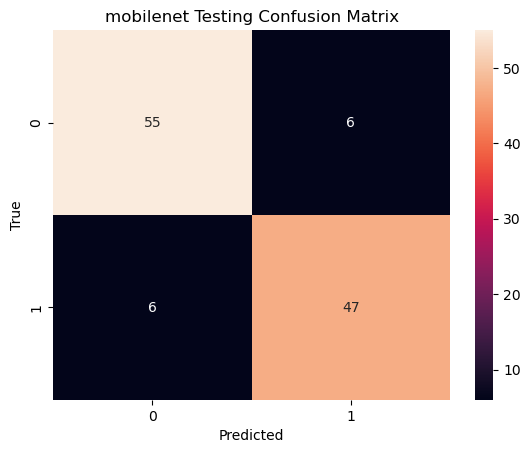

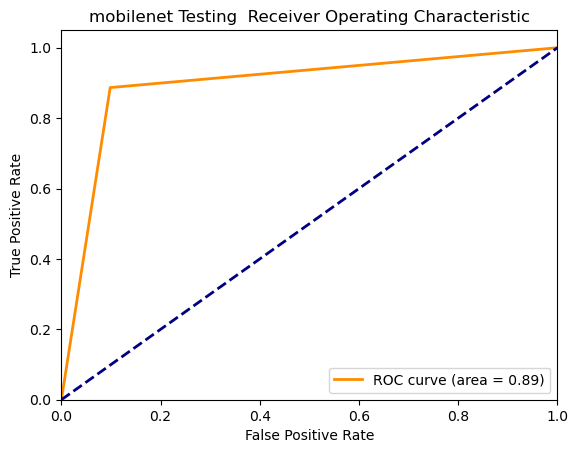

TRAINING and Testing data results:
{"{'lr': 0.00010159905511352873, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.010498097548524966, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8947368421052632, 'valid_precision': 0.8947368421052632, 'valid_recall': 0.8947368421052632, 'valid_f1': 0.8947368421052632}}


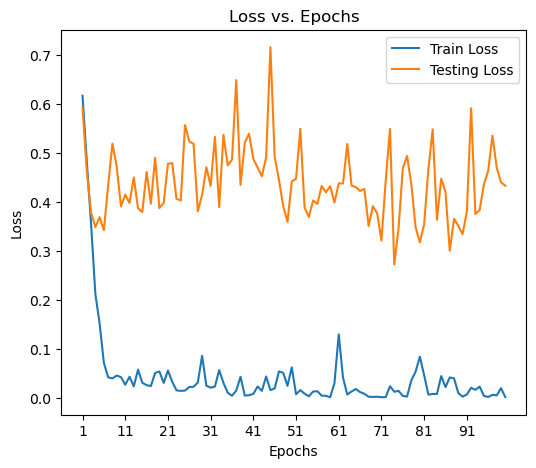

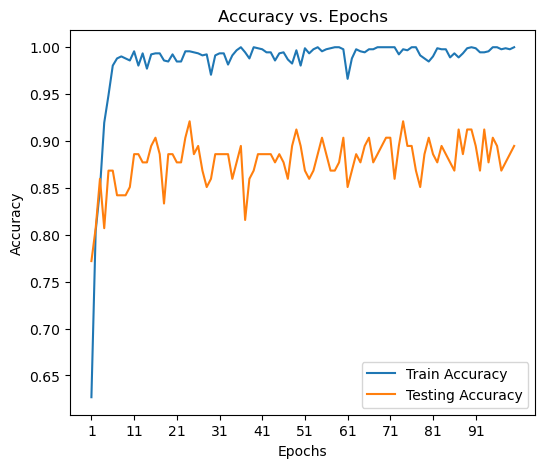

Best params:
  Model_Name                                    Hyperparameters  \
0  mobilenet  {'lr': 0.00010159905511352873, 'momentum': 0.9...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0             1.0              1.0           1.0       1.0   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.894737              0.894737           0.894737       0.894737  
run time: 0:26:51.392396


In [372]:
#running now
model_name = 'mobilenet'
# Use parameters selected by Bayesian Optimization
mobilenet_bayesian_best_params={'lr': 0.00010159905511352873, 'weight_decay': 0.010498097548524966}
best_params = mobilenet_bayesian_best_params

#note: momentum not used by Adam optimizer
# epochs increased to 100
param_grid = {
        'lr': [best_params['lr']],
        'momentum': [.9],
        'epochs': [100],
        'weight_decay': [best_params['weight_decay']],  # Add weight_decay to the grid
        'optimizer': ['Adam'],  # Add optimizer to the grid
        'batch_size': [16]  
    }
print(param_grid)


#Using best hyperparameters
# build model on training dataset and show results on testing dataset
mobile_bayes_class_model=test_model_parameters(model_name, param_grid, train_dataset, 
                                            test_dataset, device, 
                                            valid_ds_name = 'Testing',
                                            to_print=1, make_plots=1, write_csv=1, return_type='model')

# Bayesian optimizaton on RESNET model

In [20]:

# Set the random seed for reproducibility
seed = 12345678
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

start_opt = datetime.datetime.now()
print("start time: ", start_opt.strftime("%Y_%m_%d_%H%M"))

epochs=20
batch_size=16

#pbounds does not take strings.
# 'resnet18', 'densenet','mobilenet'


model_name = 'resnet18'
# optimizer' ='SGD'
optimizer_name = 'Adam'
#lr, momentum, weight_decay, batch_size, epochs,
# Define the parameter bounds, pbounds does not take strings.
# batch, epochs size needs to be a positive integer so does not work here
    
#Adam does not use momentum

pbounds = {
    'lr': (0.0001, 0.01),
    'weight_decay': (0.0001, 0.05),
    # Add other hyperparameters if needed
}
print("epochs: ", epochs)
print("batch_size: ", batch_size)
print("model_name: ", model_name)
print("optimizer_name: ", optimizer_name)
print("pbounds:", pbounds)


# Initialize Bayesian optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=seed
)

#grid search used 9 searches, i.e. models, 
# opt_init_points + opt_n_iter are the number of total searches for bayesian opt
opt_init_points=3
opt_n_iter=6

print("init_points: ", opt_init_points)
print("n_iter: ", opt_n_iter)
# Run optimization
optimizer.maximize(
    init_points=opt_init_points,  # Number of random initial points
    n_iter=opt_n_iter,      # Number of iterations
)

# Extract the best parameters
resnet_bayesian_best_params = optimizer.max['params']
print("resnet_bayesian_best_params:")
print(resnet_bayesian_best_params)

run_time = datetime.datetime.now() - start_opt
print("run time:", run_time)

start time:  2024_04_03_0037
epochs:  20
batch_size:  16
model_name:  resnet18
optimizer_name:  Adam
pbounds: {'lr': (0.0001, 0.01), 'weight_decay': (0.0001, 0.05)}
init_points:  3
n_iter:  6
|   iter    |  target   |    lr     | weight... |
-------------------------------------------------
Best params:
  Model_Name                                    Hyperparameters  \
0   resnet18  {'lr': 0.0025334619148665357, 'momentum': 0.9,...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0        0.751904         0.759675      0.751904  0.741885   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.713043              0.715646           0.713043       0.700918  
| 1         | 0.713     | 0.002533  | 0.02986   |
Best params:
  Model_Name                                    Hyperparameters  \
0   resnet18  {'lr': 0.0036520371213771643, 'momentum': 0.9,...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0        0.73

## Using Bayesian Optimization selected hyperparameters to train a RESNET model RUNNING 100 EPOCHS


{'lr': [0.00012355895331956176], 'momentum': [0.9], 'epochs': [100], 'weight_decay': [0.013242332160592462], 'optimizer': ['Adam'], 'batch_size': [16]}
start time:  2024_04_03_2245
resnet18
Model number:  1  current_params:  {'lr': 0.00012355895331956176, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.013242332160592462, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/100:
Train Loss: 0.4575, Train Accuracy: 0.7682
Testing Loss: 0.3636 Testing Accuracy: 0.8333
Finished Epoch 1
Epoch 2/100:
Train Loss: 0.2147, Train Accuracy: 0.9173
Testing Loss: 0.4326 Testing Accuracy: 0.8596
Finished Epoch 2
Epoch 3/100:
Train Loss: 0.1377, Train Accuracy: 0.9456
Testing Loss: 0.3826 Testing Accuracy: 0.8596
Finished Epoch 3
Epoch 4/100:
Train Loss: 0.1024, Train Accuracy: 0.9695
Testing Loss: 0.4343 Testing Accuracy: 0.8596
Finished Epoch 4
Epoch 5/100:
Train Loss: 0.2336, Train Accuracy: 0.9129
Testing Loss: 0.3565 Testing Accuracy: 0.8860
Finished Epoch 5
Epoch 6/100:
Train Loss: 0.0584, Train A

Epoch 66/100:
Train Loss: 0.0013, Train Accuracy: 1.0000
Testing Loss: 0.3317 Testing Accuracy: 0.9123
Finished Epoch 66
Epoch 67/100:
Train Loss: 0.0013, Train Accuracy: 1.0000
Testing Loss: 0.3739 Testing Accuracy: 0.9211
Finished Epoch 67
Epoch 68/100:
Train Loss: 0.0017, Train Accuracy: 1.0000
Testing Loss: 0.3983 Testing Accuracy: 0.9211
Finished Epoch 68
Epoch 69/100:
Train Loss: 0.0011, Train Accuracy: 1.0000
Testing Loss: 0.3408 Testing Accuracy: 0.9035
Finished Epoch 69
Epoch 70/100:
Train Loss: 0.0008, Train Accuracy: 1.0000
Testing Loss: 0.4133 Testing Accuracy: 0.9035
Finished Epoch 70
Epoch 71/100:
Train Loss: 0.0008, Train Accuracy: 1.0000
Testing Loss: 0.4051 Testing Accuracy: 0.9035
Finished Epoch 71
Epoch 72/100:
Train Loss: 0.0006, Train Accuracy: 1.0000
Testing Loss: 0.4241 Testing Accuracy: 0.9035
Finished Epoch 72
Epoch 73/100:
Train Loss: 0.0014, Train Accuracy: 1.0000
Testing Loss: 0.3540 Testing Accuracy: 0.9211
Finished Epoch 73
Epoch 74/100:
Train Loss: 0.0012

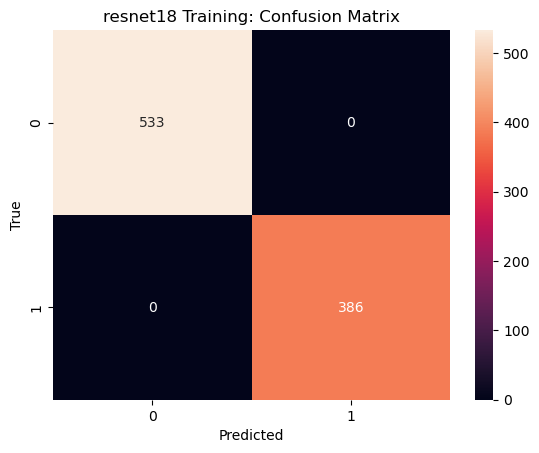

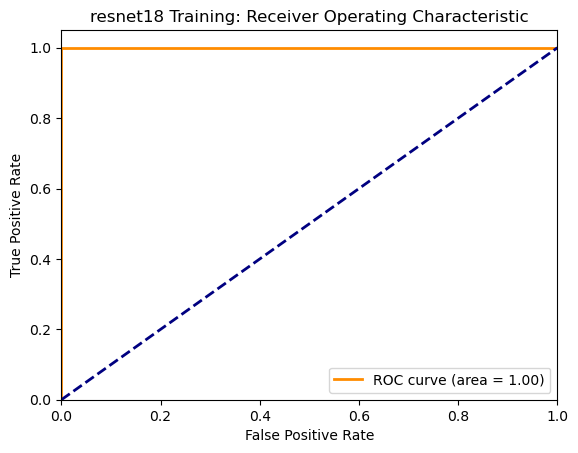

Testing data results:
Accuracy: 94.74%
Precision: 0.95
Recall: 0.95
F1 Score: 0.95


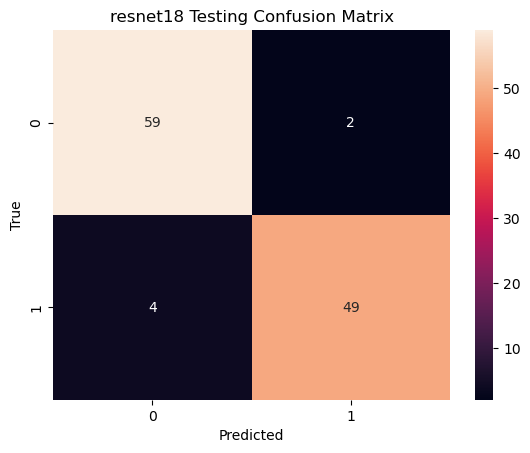

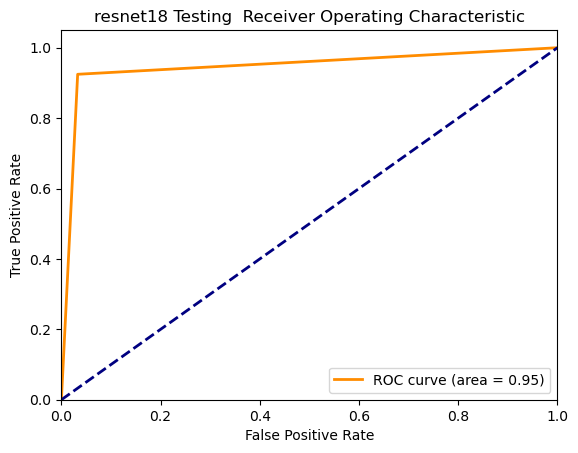

TRAINING and Testing data results:
{"{'lr': 0.00012355895331956176, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.013242332160592462, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'resnet18', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.9473684210526315, 'valid_precision': 0.9477943224073255, 'valid_recall': 0.9473684210526315, 'valid_f1': 0.9472867963954551}}


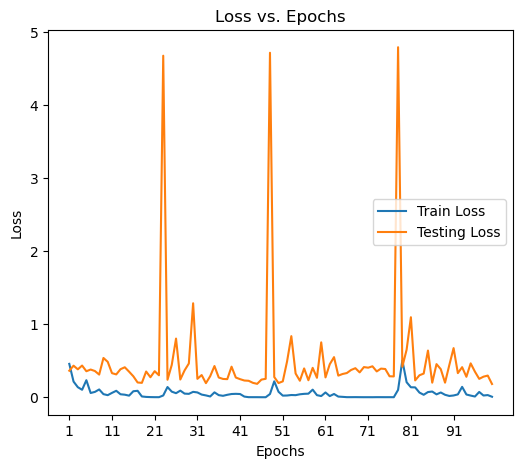

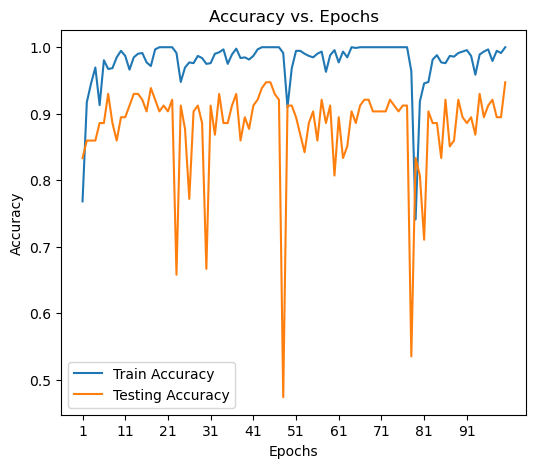

Best params:
  Model_Name                                    Hyperparameters  \
0   resnet18  {'lr': 0.00012355895331956176, 'momentum': 0.9...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0             1.0              1.0           1.0       1.0   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.947368              0.947794           0.947368       0.947287  
run time: 0:23:03.860209


In [50]:
model_name = 'resnet18'
# Use parameters selected by Bayesian Optimization
best_params = resnet_bayesian_best_params

#note: momentum not used by Adam optimizer
param_grid = {
        'lr': [best_params['lr']],
        'momentum': [.9],
        'epochs': [100],
        'weight_decay': [best_params['weight_decay']],  # Add weight_decay to the grid
        'optimizer': ['Adam'],  # Add optimizer to the grid
        'batch_size': [16]  
    }
print(param_grid)


#Using best hyperparameters
# build model on training dataset and show results on testing dataset
mobile_bayes_class_model=test_model_parameters(model_name, param_grid, train_dataset, 
                                            test_dataset, device, 
                                            valid_ds_name = 'Testing',
                                           to_print=1, make_plots=1, write_csv=1, return_type='model')

# Bayesian optimization for DENSENET model

In [21]:

# Set the random seed for reproducibility
seed = 12345678
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

start_opt = datetime.datetime.now()
print("start time: ", start_opt.strftime("%Y_%m_%d_%H%M"))

epochs=20
batch_size=16

#pbounds does not take strings.
# 'resnet18', 'densenet','mobilenet'
model_name = 'densenet'
# optimizer' ='SGD'
optimizer_name = 'Adam'
#lr, momentum, weight_decay, batch_size, epochs,
# Define the parameter bounds, pbounds does not take strings.
# batch, epochs size needs to be a positive integer so does not work here
    
#Adam does not use momentum

pbounds = {
    'lr': (0.0001, 0.01),
    'weight_decay': (0.0001, 0.05),
    # Add other hyperparameters if needed
}
print("epochs: ", epochs)
print("batch_size: ", batch_size)
print("model_name: ", model_name)
print("optimizer_name: ", optimizer_name)
print("pbounds:", pbounds)


# Initialize Bayesian optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=seed
)

#grid search used 9 searches, i.e. models, 
# opt_init_points + opt_n_iter are the number of total searches for bayesian opt

# trying with fewer runs
opt_init_points=1
opt_n_iter=3

print("init_points: ", opt_init_points)
print("n_iter: ", opt_n_iter)
# Run optimization
optimizer.maximize(
    init_points=opt_init_points,  # Number of random initial points
    n_iter=opt_n_iter,      # Number of iterations
)

# Extract the best parameters
densenet_bayesian_best_params = optimizer.max['params']
print("densenet_bayesian_best_params:")
print(densenet_bayesian_best_params)

run_time = datetime.datetime.now() - start_opt
print("run time:", run_time)

start time:  2024_04_03_0120
epochs:  20
batch_size:  16
model_name:  densenet
optimizer_name:  Adam
pbounds: {'lr': (0.0001, 0.01), 'weight_decay': (0.0001, 0.05)}
init_points:  1
n_iter:  3
|   iter    |  target   |    lr     | weight... |
-------------------------------------------------
Best params:
  Model_Name                                    Hyperparameters  \
0   densenet  {'lr': 0.0025334619148665357, 'momentum': 0.9,...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0        0.782372         0.811848      0.782372  0.783159   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.721739              0.752089           0.721739        0.72275  
| 1         | 0.7217    | 0.002533  | 0.02986   |
Best params:
  Model_Name                                    Hyperparameters  \
0   densenet  {'lr': 0.01, 'momentum': 0.9, 'epochs': 20, 'w...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0        0.55

## Using Bayesian Optimization selected hyperparameters to train a DENSENET model RUNNING 100 EPOCHS

{'lr': [0.00012355895331956176], 'momentum': [0.9], 'epochs': [100], 'weight_decay': [0.013242332160592462], 'optimizer': ['Adam'], 'batch_size': [16]}
start time:  2024_04_03_2334
densenet
Model number:  1  current_params:  {'lr': 0.00012355895331956176, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.013242332160592462, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/100:
Train Loss: 0.4586, Train Accuracy: 0.7758
Testing Loss: 0.3932 Testing Accuracy: 0.7982
Finished Epoch 1
Epoch 2/100:
Train Loss: 0.1913, Train Accuracy: 0.9260
Testing Loss: 0.3721 Testing Accuracy: 0.8596
Finished Epoch 2
Epoch 3/100:
Train Loss: 0.1455, Train Accuracy: 0.9445
Testing Loss: 0.2284 Testing Accuracy: 0.9035
Finished Epoch 3
Epoch 4/100:
Train Loss: 0.0779, Train Accuracy: 0.9728
Testing Loss: 0.3284 Testing Accuracy: 0.8684
Finished Epoch 4
Epoch 5/100:
Train Loss: 0.0896, Train Accuracy: 0.9695
Testing Loss: 0.2889 Testing Accuracy: 0.9123
Finished Epoch 5
Epoch 6/100:
Train Loss: 0.1084, Train A

Epoch 66/100:
Train Loss: 0.0732, Train Accuracy: 0.9771
Testing Loss: 0.7606 Testing Accuracy: 0.8596
Finished Epoch 66
Epoch 67/100:
Train Loss: 0.0312, Train Accuracy: 0.9902
Testing Loss: 0.7814 Testing Accuracy: 0.8421
Finished Epoch 67
Epoch 68/100:
Train Loss: 0.0354, Train Accuracy: 0.9859
Testing Loss: 0.4103 Testing Accuracy: 0.9123
Finished Epoch 68
Epoch 69/100:
Train Loss: 0.0485, Train Accuracy: 0.9848
Testing Loss: 0.2133 Testing Accuracy: 0.9298
Finished Epoch 69
Epoch 70/100:
Train Loss: 0.0188, Train Accuracy: 0.9935
Testing Loss: 0.2812 Testing Accuracy: 0.9298
Finished Epoch 70
Epoch 71/100:
Train Loss: 0.0031, Train Accuracy: 1.0000
Testing Loss: 0.2994 Testing Accuracy: 0.8860
Finished Epoch 71
Epoch 72/100:
Train Loss: 0.0090, Train Accuracy: 0.9967
Testing Loss: 0.3664 Testing Accuracy: 0.8860
Finished Epoch 72
Epoch 73/100:
Train Loss: 0.0094, Train Accuracy: 0.9978
Testing Loss: 0.4186 Testing Accuracy: 0.8684
Finished Epoch 73
Epoch 74/100:
Train Loss: 0.0042

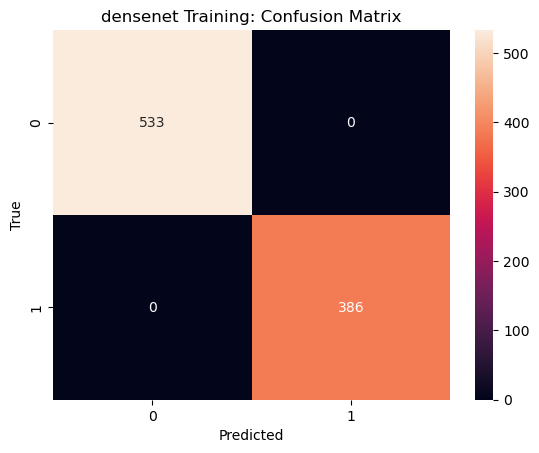

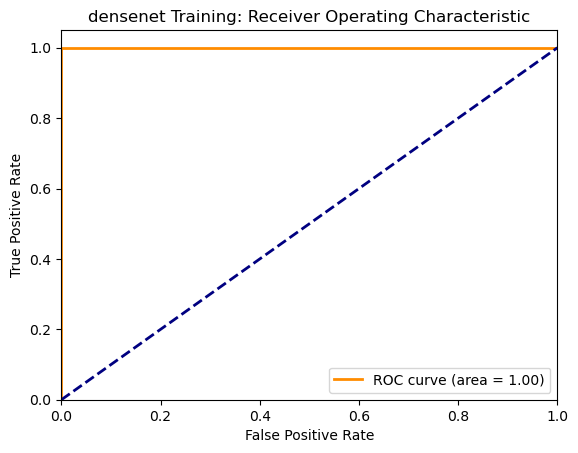

Testing data results:
Accuracy: 90.35%
Precision: 0.91
Recall: 0.90
F1 Score: 0.90


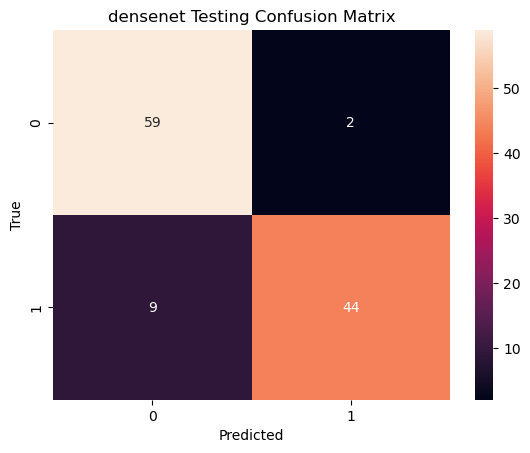

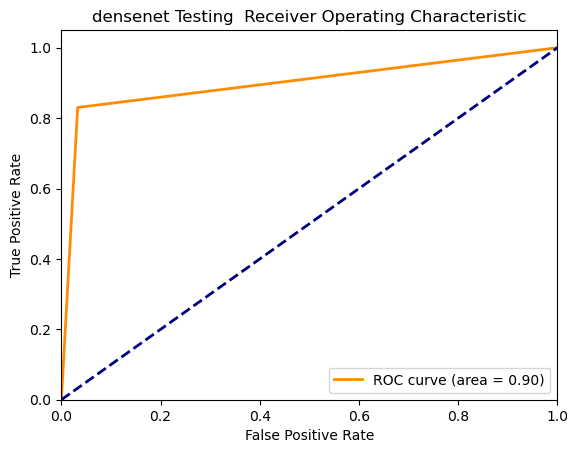

TRAINING and Testing data results:
{"{'lr': 0.00012355895331956176, 'momentum': 0.9, 'epochs': 100, 'weight_decay': 0.013242332160592462, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'densenet', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.9035087719298246, 'valid_precision': 0.908965989141652, 'valid_recall': 0.9035087719298246, 'valid_f1': 0.9027154449431071}}


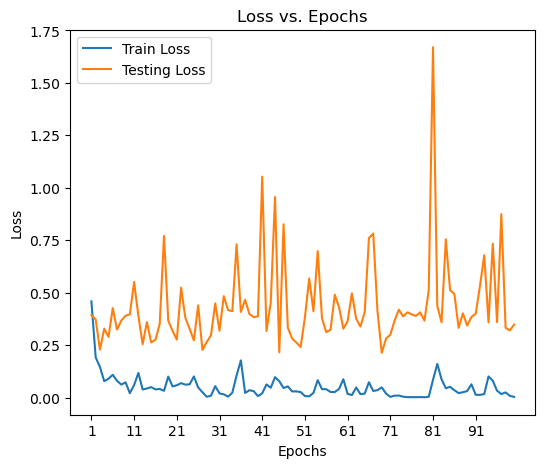

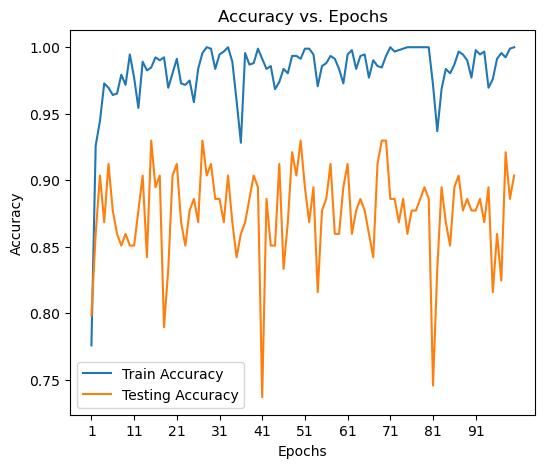

Best params:
  Model_Name                                    Hyperparameters  \
0   densenet  {'lr': 0.00012355895331956176, 'momentum': 0.9...   

   Train_Accuracy  Train_Precision  Train_Recall  Train_F1  \
0             1.0              1.0           1.0       1.0   

   Validation_Accuracy  Validation_Precision  Validation_Recall  Validation_F1  
0             0.903509              0.908966           0.903509       0.902715  
run time: 0:29:06.934717


In [54]:
model_name = 'densenet'
# Use parameters selected by Bayesian Optimization
best_params = resnet_bayesian_best_params

#note: momentum not used by Adam optimizer
param_grid = {
        'lr': [best_params['lr']],
        'momentum': [.9],
        'epochs': [100],
        'weight_decay': [best_params['weight_decay']],  # Add weight_decay to the grid
        'optimizer': ['Adam'],  # Add optimizer to the grid
        'batch_size': [16]  
    }
print(param_grid)


#Using best hyperparameters
# build model on training dataset and show results on testing dataset
densenet_bayes_class_model=test_model_parameters(model_name, param_grid, train_dataset, 
                                            test_dataset, device, 
                                            valid_ds_name = 'Testing',
                                           to_print=1, make_plots=1, write_csv=1, return_type='model')


In [4]:
#######################################################################################################

# YOLO version 8

## YOLO models predict both:
##    The bounding boxes of the tumor's location 
##    The classification of the tumor as benign or malignant.

In [22]:
# YOLO Version 8
from ultralytics import settings

from ultralytics import YOLO

# View all settings
print(settings)

{'settings_version': '0.0.4', 'datasets_dir': 'C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\Python\\datasets', 'weights_dir': 'weights', 'runs_dir': 'runs', 'uuid': 'c925578fab388c39a66c7caba2a264faebc452c919dfaa6db035bdc3108a077b', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': False, 'tensorboard': True, 'wandb': True}


# Function to run make a YOLO file (i.e. ".txt" files with {class_index} {x_center} {y_center} {bbox_width} {bbox_height}) from the json file and the benign/malignant label within the original folder structure


In [ ]:
class_mapping = {
    'benign': 0,
    'malignant': 1
}
# function to write the .txt files yolov5 expects
def convert_json_to_yolo_format(json_file, class_mapping):
        # parameters: 
        #   json_file: json path with filename
        #   image_file: image path with filename
        #   tumor_true_label
    if 'benign' in json_file:
        tumor_true_label = 'benign'
    elif 'malignant' in json_file:
        tumor_true_label = 'malignant'
        
    image_path = json_file.replace('.json', '.jpg')
    yolo_file_path = json_file.replace('.json', '.txt')
        
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    for entry in data['shapes']:
        # Assume 'tumor_type' is a key in your JSON that specifies the tumor class
        #tumor_type = entry.get('tumor_type', 'benign')  # Default to 'benign' if not specified
        tumor_type = tumor_true_label
        class_index = class_mapping[tumor_true_label]
        
        x1, y1 = entry['points'][0]
        x2, y2 = entry['points'][1]
        image = Image.open(image_path)
        width, height = image.size
        x_center = ((x1 + x2) / 2) / width
        y_center = ((y1 + y2) / 2) / height
        bbox_width = (x2 - x1) / width
        bbox_height = (y2 - y1) / height
        
        #label_path = os.path.join(label_dir, os.path.splitext(data['imagePath'])[0] + '.txt')
        with open(yolo_file_path, 'w') as label_file:
            label_file.write(f'{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n')


# Function to apply conversion from json to yolo format within original folder structure

In [ ]:
# Function to run convert_json_to_yolo_format in a directory and its subdirectories
def create_yolo_file_in_directory(root_dir):
    for subdir, dirs, files in os.walk(root_dir):
        for file_name in files:
            if file_name.endswith('.jpg'):
                image_path = os.path.join(subdir, file_name)
                json_path = image_path.replace('.jpg', '.json')
                if os.path.exists(json_path):
                    convert_json_to_yolo_format(json_path, class_mapping)

# Call the function with the path to your root directory containing subfolders with images and JSON files
#create_yolo_file_in_directory(benign_path)
#create_yolo_file_in_directoryy(malignant_path)

In [ ]:
create_yolo_file_in_directory(benign_path)
create_yolo_file_in_directory(malignant_path)

# Copy the image .jpg files and the the YOLO .txt files to the folder structure expected by YOLO

# Originally tried YOLO v5 but YOLOv5 is setup to run from the command line, not from within Python programming.
# Not having the flexibility of a programming lamnguage made running and tracking runs with different parameters difficult.
# Therefore, converted to YOLOv8

In [ ]:

# copy the image .jpg files and the the yolo needed .txt files to the folder structure expected by yolov5
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the base paths for malignant and benign images
base_malignant_path = malignant_path
base_benign_path = benign_path

# Define the new base path for YOLOv5 dataset
#yolo_base_path = "C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv5"

yolo_base_path = "C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\datasets"

# Create new directories for YOLOv5 dataset structure
#os.makedirs(os.path.join(yolo_base_path, 'images', 'train'), exist_ok=True)
#os.makedirs(os.path.join(yolo_base_path, 'images', 'val'), exist_ok=True)
#os.makedirs(os.path.join(yolo_base_path, 'images', 'test'), exist_ok=True)
#os.makedirs(os.path.join(yolo_base_path, 'labels', 'train'), exist_ok=True)
#os.makedirs(os.path.join(yolo_base_path, 'labels', 'val'), exist_ok=True)
#os.makedirs(os.path.join(yolo_base_path, 'labels', 'test'), exist_ok=True)


# Create new directories for YOLOv8 dataset structure
os.makedirs(os.path.join(yolo_base_path, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_path, 'val',   'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_path, 'test',  'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_path, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_path, 'val',   'labels'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_path, 'test',  'labels'), exist_ok=True)


# Function to copy files to the new structure
def copy_files_to_yolo_structure(base_path, class_label, image_paths, label_paths, split):
    for img_path, lbl_path in zip(image_paths, label_paths):
        # Extract the filename without extension
        filename = os.path.splitext(os.path.basename(img_path))[0]
        
        # Construct the new image and label paths
        new_img_path = os.path.join(yolo_base_path, split, 'images', filename + '.jpg')
        new_lbl_path = os.path.join(yolo_base_path, split, 'labels', filename + '.txt')
        
        # Copy the image and label files to the new structure
        shutil.copyfile(img_path, new_img_path)
        shutil.copyfile(lbl_path, new_lbl_path)

# Function to process each class and split the data
def process_class(base_path, class_label):
    # List to store image and label paths
    image_paths = []
    label_paths = []
    
    # Walk through the patient number directories
    for patient_num in os.listdir(base_path):
        patient_path = os.path.join(base_path, patient_num)
        
        # Add image and label paths to the lists
        for file in os.listdir(patient_path):
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(patient_path, file))
            elif file.endswith('.txt'):
                label_paths.append(os.path.join(patient_path, file))
    
    # Split the data into training, validation, and testing sets
    img_train, img_temp, lbl_train, lbl_temp = train_test_split(image_paths, label_paths, test_size=0.2, random_state=42)
    img_val, img_test, lbl_val, lbl_test = train_test_split(img_temp, lbl_temp, test_size=0.5, random_state=42)
    
    # Copy files to the new YOLOv5 structure
    copy_files_to_yolo_structure(base_path, class_label, img_train, lbl_train, 'train')
    copy_files_to_yolo_structure(base_path, class_label, img_val, lbl_val, 'val')
    copy_files_to_yolo_structure(base_path, class_label, img_test, lbl_test, 'test')

# Process malignant and benign classes
process_class(base_malignant_path, 'malignant')
process_class(base_benign_path, 'benign')

print("Dataset reorganization complete.")

In [31]:
# cd to path you wish yolo results fuolder structure to start at
#%cd "C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\results\\yolov8" 

C:\Users\dan_c\Documents\GA_tech\PRACTICUM\results\yolov8


# yaml file needed for YOLO v8:

In [ ]:
# yaml file needed for YOLO v8:
''' 
---
#yaml
# YOLOv8 custom dataset configuration

# Define the number of classes
nc: 2

# Define the class names
names: ['benign', 'malignant']

# Define the path to the datasets
Path: 'C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\dataset'


# Define the path to the training dataset, starting at path
#   Define the directory where the YOLO format label files are located
#   labels subfolder and imagessubfolder are assumes if labels not also in images folder
train: 'C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\dataset\\train'

# Define the path to the validation dataset
val: 'C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\dataset\\val'

# Define the path to the test dataset (optional)
test: 'C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\dataset\\test'
''' 

### YOLO version 8 settings

In [32]:
# YOLO Version 8
from ultralytics import settings

# View all settings
print(settings)

#change an ultralytics setting
settings.update({'raytune': False})
# received error messages from Ray Tune. Even without calling Ray Tune. Earlier version of Ultralytics code,
#  when running YOLO would used a discontinued method to check if Ray Tune was running.

print(settings)

{'settings_version': '0.0.4', 'datasets_dir': 'C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\Python\\datasets', 'weights_dir': 'weights', 'runs_dir': 'runs', 'uuid': 'c925578fab388c39a66c7caba2a264faebc452c919dfaa6db035bdc3108a077b', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': False, 'tensorboard': True, 'wandb': True}
{'settings_version': '0.0.4', 'datasets_dir': 'C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\Python\\datasets', 'weights_dir': 'weights', 'runs_dir': 'runs', 'uuid': 'c925578fab388c39a66c7caba2a264faebc452c919dfaa6db035bdc3108a077b', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': False, 'tensorboard': True, 'wandb': True}


# YOLOv8 model train settings:
# If batch size is set to negative, then YOLO "dynamically adjusts the batch size based on GPU memory availability."
# If optimizer is set to auto, then for the optimizer, YOLO performs "automatic selection based on model configuration". 
# Optimizer= 'auto' is the default.
## YOLOv8 ran quickly and provided good results with auto optimizer and batch size -1.
### Source: https://docs.ultralytics.com/modes/train/#train-settings

# Build YOLOv8 model, with 50 epochs

In [84]:
#### 
import datetime
start_opt = datetime.datetime.now()
print("start time: ", start_opt.strftime("%Y_%m_%d_%H%M"))

from ultralytics import YOLO
model = YOLO('yolov8n.pt') 
num_epochs=50
results = model.train(data='C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\data\\config_yolov8.yaml',
                      epochs=num_epochs, imgsz=640, batch=-1)

run_time = datetime.datetime.now() - start_opt
print("run time: ", run_time)

start time:  2024_04_10_1343
New https://pypi.org/project/ultralytics/8.1.46 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.37 🚀 Python-3.11.5 torch-2.2.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\data\config_yolov8.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train25, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False,

train: Scanning C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\train\labels.cache... 917 ima
val: Scanning C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\val\labels.cache... 115 images,


Plotting labels to runs\detect\train25\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00059375), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train25
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.47G      1.671      3.258       1.65         10        640: 100%|██████████| 25/25 [00:07<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115    0.00272      0.828      0.234      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.22G      1.422      2.077      1.421          8        640: 100%|██████████| 25/25 [00:06<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.542      0.157      0.253      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.22G      1.472       1.88      1.462          8        640: 100%|██████████| 25/25 [00:06<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115     0.0338     0.0662     0.0225    0.00813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.05G      1.445      1.637      1.464         12        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.518      0.334      0.407      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.04G      1.415      1.441      1.425         12        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.668      0.728      0.706       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.05G      1.414      1.387      1.428          9        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.736      0.726      0.746      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.04G      1.384      1.268      1.395         10        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.771      0.814      0.832      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.05G      1.361      1.149      1.358          8        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.691      0.779      0.781      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.04G      1.383      1.139      1.386         13        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.796      0.738      0.786      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.05G      1.337      1.072      1.353         10        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.636       0.64      0.627      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.04G      1.311      1.017      1.343          9        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.672      0.761      0.735      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.05G      1.332      1.011      1.352         12        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.817      0.819      0.881      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.04G      1.305     0.9932      1.342         12        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115       0.85      0.735       0.85      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.05G      1.294     0.9518      1.321         12        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.883      0.888      0.931      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.04G      1.296     0.9479      1.336         10        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.843      0.861      0.917      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.05G      1.292     0.8792      1.316         10        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.642      0.878      0.829      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.04G      1.279     0.9106      1.303         15        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.928      0.895      0.953      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.05G      1.273     0.8768      1.302          9        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.934      0.798      0.911      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.04G      1.256      0.865      1.302         10        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.904      0.879      0.955       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.05G      1.232     0.8251      1.276         12        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115       0.85      0.796      0.885        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.04G       1.23     0.8208      1.291          9        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.938      0.893      0.966      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.05G      1.206      0.773      1.282         11        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.856       0.85      0.915      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.04G      1.222     0.7968       1.28         15        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115       0.86      0.908      0.914      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.05G      1.214     0.7861       1.29          9        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.889      0.894      0.936      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.04G      1.195     0.7467      1.265         11        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.934      0.842      0.927      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.05G      1.186     0.7472      1.252          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115       0.85      0.879       0.91       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.04G      1.177     0.7032      1.248         11        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115       0.91      0.922      0.933      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.05G      1.148      0.717      1.242          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.914        0.9      0.963      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.04G      1.148     0.7205      1.243         14        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.871      0.942      0.955      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.05G      1.153     0.7002       1.23          6        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.878      0.889       0.96      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.04G      1.135     0.6991       1.22         10        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.913      0.939      0.973      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.05G      1.119     0.6527      1.209         14        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.928      0.906      0.968      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.04G        1.1     0.6813      1.225          8        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.932      0.893      0.967      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.05G      1.094      0.669      1.205          7        640: 100%|██████████| 25/25 [00:06<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.949      0.977      0.971      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.04G      1.122     0.6762      1.219          7        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.956      0.967      0.978      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.05G      1.079      0.633      1.196         11        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.942      0.948      0.978      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.04G      1.109     0.6222      1.212         11        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.942      0.965      0.975      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.05G      1.058     0.6153      1.183         11        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.933      0.961      0.969      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.04G      1.041     0.5983      1.174          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.905      0.923      0.958      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.05G      1.029     0.6004      1.176          6        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.952       0.93      0.963      0.664


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.04G       1.03      0.488      1.184          5        640: 100%|██████████| 25/25 [00:06<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.884      0.927      0.962      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.05G     0.9751     0.4707      1.139          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.939      0.924      0.972       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.04G     0.9869      0.456      1.145          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.948      0.921      0.978      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.05G     0.9547     0.4492      1.124          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.965      0.923      0.981       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.04G     0.9274     0.4387      1.107          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.954      0.952      0.974      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.05G     0.9203     0.4276      1.091          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.951      0.968      0.976      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.04G     0.9104     0.4235       1.08          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.963      0.959       0.98      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.05G     0.8983     0.4081      1.081          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.969      0.949      0.976      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.04G     0.8843     0.4041      1.085          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.966      0.975      0.979      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.05G     0.8838     0.3952      1.085          5        640: 100%|██████████| 25/25 [00:05<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.964      0.964      0.979      0.681



50 epochs completed in 0.106 hours.
Optimizer stripped from runs\detect\train25\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train25\weights\best.pt, 6.2MB

Validating runs\detect\train25\weights\best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.11.5 torch-2.2.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all        115        115      0.965      0.975      0.979      0.683
                benign        115         66      0.951      0.955      0.967      0.677
             malignant        115         49       0.98      0.996      0.991      0.688
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\train25
run time:  0:07:10.729047


### Path of model just built in above Jupyter Notebook window using 50 epochs

In [7]:
path_of_model_y50 ='C:\\Users\\dan_c\\Documents\\GA_tech\PRACTICUM\\Python\\runs\\detect\\train25\\weights\\best.pt'

# Show object detection validation data metrics of YOLO v8 model built with 50 epochs

In [138]:
#try recent model
# show metrics on TEST data
model = YOLO(path_of_model_y50)  # load a custom model

#Using test data
metrics= model.val(split='test', plots=True)

metrics.box.map    # map50-95
map50=metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Precision = metrics.box.p
Recall = metrics.box.r
F1 = 2 * (Precision * Recall) /  (Precision + Recall) 
#accuracy, precision, recall, and F1
#print(map50, F1, Precision, Recall)
#print(" map50 is Mean Average Precision, the mean of the average precision for each class")
#print( "'Offers a comprehensive assessment of object detection performance, considering precision and recall trade-offs.'")
#print("Source: https://github.com/ultralytics/ultralytics/issues/5217")
print("Results on validation data, scored with YOLO model that was trained on 50 epochs:" )
print("map50: ", map50)
print("F1: ", F1, " Precision: ", Precision, "Recall: ", Recall)



Ultralytics YOLOv8.1.37 🚀 Python-3.11.5 torch-2.2.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\labels.cache... 116 images
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<0


                   all        116        116      0.917      0.955      0.972      0.636
                benign        116         67       0.97       0.95      0.986      0.663
             malignant        116         49      0.864      0.959      0.958      0.609
Speed: 0.5ms preprocess, 4.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\val15
Results on validation data, scored with YOLO model that was trained on 50 epochs:
map50:  0.9722668586111659
F1:  [    0.95963     0.90908]  Precision:  [    0.96953     0.86395] Recall:  [    0.94994     0.95918]


# Show object detection TEST data metrics of YOLO v8 model built with 50 epochs

In [11]:
# show metrics on TEST data

model = YOLO(path_of_model_y50)  # load a custom model

#Using test data
metrics= model.val(split='test', plots=True)

metrics.box.map    # map50-95
map50=metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Precision = metrics.box.p
Recall = metrics.box.r
# F1: https://github.com/ultralytics/ultralytics/issues/3875   
F1 = 2 * (Precision * Recall) /  (Precision + Recall) 
#accuracy, precision, recall, and F1
#print(map50, F1, Precision, Recall)
#print(" map50 is Mean Average Precision, the mean of the average precision for each class")
#print( "'Offers a comprehensive assessment of object detection performance, considering precision and recall trade-offs.'")
#print("Source: https://github.com/ultralytics/ultralytics/issues/5217")
print("Test data scored with YOLO 50 epochs trained model.")
print("map50: ", map50)
print("F1: ", F1, " Precision: ", Precision, "Recall: ", Recall)

Ultralytics YOLOv8.1.37 🚀 Python-3.11.5 torch-2.2.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\labels.cache... 116 images
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<0


                   all        116        116      0.917      0.955      0.972      0.636
                benign        116         67       0.97       0.95      0.986      0.663
             malignant        116         49      0.864      0.959      0.958      0.609
Speed: 0.8ms preprocess, 6.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\val17
Test data scored with YOLO 50 epochs trained model.
map50:  0.9722668586111659
F1:  [    0.95963     0.90908]  Precision:  [    0.96953     0.86395] Recall:  [    0.94994     0.95918]


In [ ]:
## Function to use a trained YOLO model to score a test folder of images and YOLO .txt files 
## A custom function was needed.
## https://github.com/ultralytics/ultralytics/issues/3875

## Function to evaluate YOLO model. The evaluate function for yolo does not need a dataloader.  Separate metrics function needed for evaluation of classification.
## YOLO model is predicting both classification and object detection.

###    The metrics returned by model.val() are more appropriate for evaluating the object location.
####    source: https://docs.ultralytics.com/guides/yolo-performance-metrics/

###    A custom scoring function and sklearn.metrics are recommended for evaluation of classification.
####   source: https://github.com/ultralytics/ultralytics/issues/3875 , Issue on wegpage:"I want to get F1 score in classification model #3875 "

In [139]:
test_images_folder = "C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\dataset\\test\\images"
#test_labels_folder = "C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\dataset\\test\\labels"

#val_images_folder = "C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\dataset\\val\images"
#val_labels_folder = "C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\dataset\\val\\labels"

#the_model = YOLO('C:\\Users\\dan_c\\Documents\\GA_tech\PRACTICUM\\results\\yolov8\\runs\\detect\\train\\weights\\best.pt') 

def score_folder(folder_path, path_trained_model):
    
    #folder_path determines type of data
    filenames = []
    path_and_filename_list = []
    model_results = []
    predict_class_list = []
    true_state_list = []
    
    model = YOLO(path_trained_model)
    
    # Iterate over each subdirectory in the benign and malignant folders

    for file in os.listdir(folder_path):
        if file.endswith('.jpg'):
            filenames.append(file)  # Store the filename
            #print("File: ", file)
            path_and_filename = os.path.join(folder_path, file)
            label_file = file.replace('.jpg', '.txt')
            label_path_and_file = os.path.join(os.path.join(folder_path.replace('images', 'labels'), label_file))
            with open(label_path_and_file) as f:
                true_state = f.read(1)
            true_state_list.append(int(true_state))
            #print("path_and_filename: ", path_and_filename)
            path_and_filename_list.append(os.path.join(folder_path, file))
            #print("path_and_filename_list: ", path_and_filename_list)
            
            # predict to get classification value with highest prob
            results = model.predict(path_and_filename, save=True)
        #https://stackoverflow.com/questions/63479765/whats-the-best-way-of-checking-whether-a-torchtensor-is-empty
        #https://stackoverflow.com/questions/75277492/yolov8-get-predicted-class-name                   
        #https://stackoverflow.com/questions/76898029/ultralytics-yolov8-probs-attribute-returning-none-for-object-detection
        # if detect does not return classificafion, assign background
        # 0=benign, 1=malignant, 2 = background
            if len(results[0].boxes) == 0:
                predicted_class = 2                
            else:
                predicted_class= int(results[0].boxes[0].cls[0].cpu().numpy())
            
            predict_class_list.append(predicted_class)
        #https://stackoverflow.com/questions/75277492/yolov8-get-predicted-class-name                   
         #https://stackoverflow.com/questions/76898029/ultralytics-yolov8-probs-attribute-returning-none-for-object-detection
            model_results.append(results)
         #https://stackoverflow.com/questions/76898029/ultralytics-yolov8-probs-attribute-returning-none-for-object-detection
         # detect does not return classificafion
    return  path_and_filename_list, predict_class_list, true_state_list

# score TEST data with YOLO model
#path_and_filename_list, predict_class_list, true_state_list = score_folder(folder_path=test_images_folder, model=the_model)

# Function to evaluate YOLO models (does not use dataloader)

In [140]:
# accuracy, precision, recall, f1, from all_labels, all_predictions 
def evaluate_model_yolo(all_labels, all_predictions, to_print=1):

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    # note: get same results if zero_division is set to 1 or 0
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    if to_print == 1:
        print(f'Accuracy: {accuracy * 100:.2f}%')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')

    return accuracy, precision, recall, f1, all_labels, all_predictions


In [141]:
# score TEST data with YOLO model
print("Results on test data, scored with YOLO model that was trained on 50 epochs:" )
path_and_filename_list, predict_class_list, true_state_list = score_folder(folder_path=test_images_folder, 
                                                                           path_trained_model=path_of_model_y50)

Results on test data, scored with YOLO model that was trained on 50 epochs:

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\04A195C7193647B599073C0FD2EF4D7D_2620171 (2).jpg: 480x640 1 malignant, 21.2ms
Speed: 4.0ms preprocess, 21.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\051D402B1CE1483B9D6519C3CFE6CFAF_8277284.jpg: 480x640 1 malignant, 17.1ms
Speed: 4.0ms preprocess, 17.1ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\1.2.826.0.1.3680043.2.461.10894137.1382588789.jpg: 448x640 1 benign, 16.7ms
Speed: 3.0ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict


image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190128095756.jpg: 480x640 1 benign, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190129081911.jpg: 480x640 1 benign, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190131102022.jpg: 480x640 1 malignant, 10.0ms
Speed: 7.5ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190210104214.jpg: 480x640 1 malignant, 10.2ms
Speed: 2.0ms prepr

Speed: 3.0ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190628101519.jpg: 480x640 1 malignant, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190701133846.jpg: 480x640 1 benign, 10.3ms
Speed: 8.6ms preprocess, 10.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190710113741.jpg: 480x640 1 benign, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Do

Speed: 5.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20201124102610.jpg: 480x640 1 benign, 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20201125093502.jpg: 480x640 1 benign, 10.5ms
Speed: 4.7ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20201203083049.jpg: 480x640 1 benign, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Docum


image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\I0163627.jpg: 480x640 1 malignant, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\I0283661.jpg: 480x640 1 benign, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict85


# YOLO 50 epoch model classification results on TEST data

In [142]:
print("Results on test data, scored with YOLO model that was trained on 50 epochs:" )
accuracy, precision, recall, f1, all_labels, all_predictions = evaluate_model_yolo(true_state_list, predict_class_list)

Results on test data, scored with YOLO model that was trained on 50 epochs:
Accuracy: 95.69%
Precision: 0.96
Recall: 0.96
F1 Score: 0.96


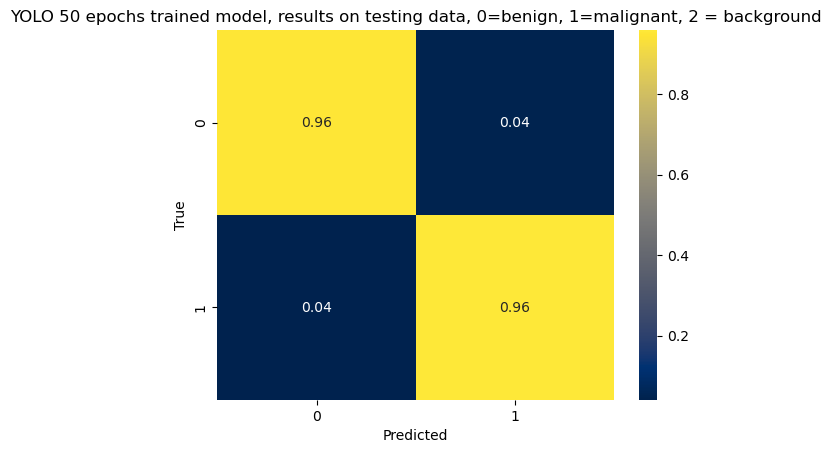

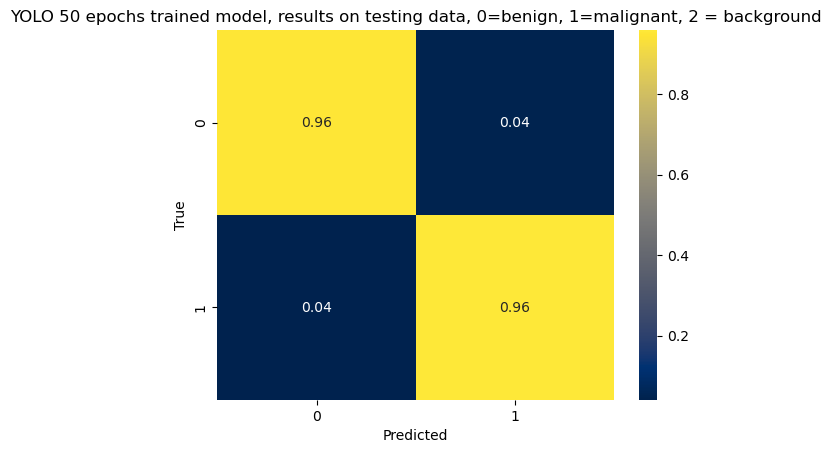

In [114]:

plot_confusion_matrix(true_state_list, predict_class_list, normalize='true',
                      title="YOLO 50 epochs trained model, results on testing data, 0=benign, 1=malignant, 2 = background",
                      color_in='cividis')

plot_confusion_matrix(true_state_list, predict_class_list, normalize='true',
                      title="YOLO 50 epochs trained model, results on testing data, 0=benign, 1=malignant, 2 = background",
                      color_in='cividis')

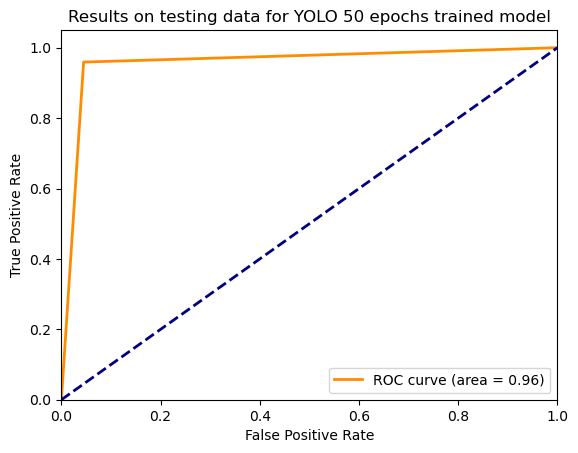

In [146]:
 
plot_roc_curve(true_state_list, predict_class_list, 
                      title="Results on testing data for YOLO 50 epochs trained model")
                     

# Build YOLO v8 model with 100 epochs

In [39]:

import datetime
start_opt = datetime.datetime.now()
print("start time: ", start_opt.strftime("%Y_%m_%d_%H%M"))

from ultralytics import YOLO
model = YOLO('yolov8n.pt') 
num_epochs=100
results = model.train(data='C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\data\\config_yolov8.yaml',
                      epochs=num_epochs, imgsz=640, batch=-1)

run_time = datetime.datetime.now() - start_opt
print("run time: ", run_time)

start time:  2024_04_03_1237
New https://pypi.org/project/ultralytics/8.1.42 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.37 🚀 Python-3.11.5 torch-2.2.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\data\config_yolov8.yaml, epochs=100, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False,

train: Scanning C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\train\labels.cache... 917 ima
val: Scanning C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\val\labels.cache... 115 images,


Plotting labels to runs\detect\train8\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00039843750000000003), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train8
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.28G      1.803      3.627      1.717         93        640: 100%|██████████| 18/18 [00:12<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all        115        115    0.00285      0.853      0.136     0.0628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.26G      1.415      2.172      1.398        102        640: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115          1     0.0179      0.414      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.25G      1.385      1.851      1.368         97        640: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.658      0.203      0.424      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.25G      1.411      1.735      1.397        101        640: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.392      0.251       0.22      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.25G      1.436       1.61      1.414         90        640: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.297       0.15      0.183      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.25G      1.445      1.498      1.408         95        640: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.497      0.463      0.448      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.25G       1.44      1.374      1.426         96        640: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.356      0.129      0.151     0.0817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.25G      1.409      1.252      1.401         99        640: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.515      0.599      0.527      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.25G      1.398      1.204      1.398        100        640: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115       0.46      0.348      0.281      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.25G      1.409      1.165      1.399        109        640: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.651      0.532      0.625      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.25G      1.351       1.09      1.363         90        640: 100%|██████████| 18/18 [00:11<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.784      0.754      0.808      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.25G      1.361      1.055      1.352        101        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.788      0.561      0.657      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.25G      1.356       1.02      1.356        119        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115        0.8      0.715      0.791      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.25G      1.337     0.9791      1.346         88        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.561      0.732      0.639      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.25G      1.326     0.9717      1.332        106        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.725      0.813      0.848      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.25G      1.322     0.9345      1.318         97        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.645      0.799      0.799      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.25G      1.315     0.9179       1.31         91        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.736      0.665      0.726      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.25G      1.295     0.9063       1.31        107        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.771      0.819      0.858      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.25G      1.329     0.9251      1.319        114        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.865      0.707      0.837      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.25G      1.289     0.8891      1.299         94        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.906      0.842      0.924      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.25G      1.268     0.8725      1.294        109        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.882        0.9      0.939      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.25G      1.265     0.7939      1.283        100        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.726      0.785      0.844      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.25G      1.282     0.8538      1.304         93        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.743      0.704      0.774      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.25G      1.262     0.8532      1.284         83        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.816      0.885      0.906      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.25G      1.238     0.7934      1.282         98        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.768      0.796      0.859      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.25G      1.248     0.7798      1.284        114        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.762      0.902      0.888      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.25G      1.241     0.8091      1.268         97        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.893      0.913      0.945        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.25G      1.205     0.7633      1.251        102        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.905      0.827      0.922      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.25G      1.282     0.8109      1.295        106        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.806      0.776      0.822      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.25G      1.205     0.7465      1.243        113        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.847      0.882      0.915      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.25G      1.202     0.7516       1.25        102        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.829      0.783      0.903      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.25G      1.225     0.7455      1.269        121        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.924      0.895      0.948      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.25G      1.199     0.7463      1.261         97        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.834      0.883      0.907      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.25G      1.187     0.7431      1.238         96        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.915      0.928      0.966      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.25G       1.16     0.7216      1.224        111        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.873       0.87       0.95       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.25G      1.195     0.7355      1.243         97        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.868       0.92      0.961      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.25G      1.183     0.7233      1.248         89        640: 100%|██████████| 18/18 [00:10<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.882      0.901      0.957      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.25G      1.141     0.7111      1.223         99        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.852      0.899      0.951      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.25G      1.144     0.6865      1.217         99        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.876      0.852      0.939      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.25G      1.139     0.6766      1.225        109        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.841       0.86      0.908      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.25G      1.153      0.682       1.22         97        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.869      0.869       0.94      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.25G      1.134     0.6669      1.214         96        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115       0.81      0.893      0.913      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.25G      1.112     0.6611      1.214        105        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.884      0.934      0.933      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.25G      1.154     0.6703      1.223         91        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.892      0.924      0.951      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.25G      1.126     0.6737        1.2        111        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.945      0.909      0.956      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.25G      1.116     0.6529      1.205         85        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.912      0.901      0.947      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.25G      1.073     0.6213      1.183        107        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.894       0.89      0.947      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.25G      1.109     0.6231       1.21        101        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115        0.9      0.907      0.932      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.25G      1.099     0.6396      1.193         96        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.856      0.902      0.935      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.25G       1.11     0.6514      1.201        105        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.883      0.924       0.95      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.25G      1.096     0.6166      1.199         99        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115       0.93      0.814      0.914      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.25G      1.077     0.6252      1.187        127        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.913      0.919      0.966      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.25G      1.058     0.6027      1.182        116        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.844      0.908      0.923      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.25G      1.086     0.6367      1.185         90        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.879      0.893      0.942      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.25G      1.031      0.597      1.161         85        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.929      0.934      0.952       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.25G      1.043     0.5928       1.16        106        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.919      0.932      0.955      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.25G       1.03     0.5823      1.153         98        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.886      0.947      0.966      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.25G      1.001     0.5649      1.143         98        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.909      0.939      0.953      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.25G     0.9993     0.5791      1.133        102        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.912      0.912      0.952      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.25G     0.9912     0.5611      1.122         97        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.895      0.949      0.956      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.25G      1.009     0.5893      1.142        107        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.936      0.949      0.965      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.25G      1.004     0.5664      1.139        101        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.942      0.921      0.961      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.25G     0.9854     0.5509      1.124        101        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.864       0.93      0.945      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.25G     0.9839     0.5644      1.132        112        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.916      0.862      0.941      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.25G     0.9808     0.5563       1.14         96        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.896      0.943      0.958      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.25G     0.9442     0.5384      1.116         89        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.957      0.958      0.973      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.25G     0.9515     0.5471      1.109        102        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.968      0.941       0.98      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.25G     0.9581     0.5267      1.113        105        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.936      0.918      0.964      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.25G     0.9432     0.5131      1.105         90        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.918      0.936      0.964      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.25G      0.926     0.5248        1.1         90        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.929      0.962       0.98       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.25G     0.9546     0.5343      1.104        103        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.946      0.957      0.966      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.25G      0.941     0.5145      1.111        106        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.933      0.939      0.979      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.25G     0.9194     0.5078       1.09         98        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.977      0.958      0.984       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.25G      0.928     0.5076      1.102         92        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115       0.94      0.957       0.97      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.25G     0.9063     0.4872      1.084         97        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.944      0.932      0.973       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.25G     0.9131     0.5022      1.098         95        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.932      0.957       0.98       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.25G     0.8925     0.5037       1.08         93        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.932      0.922      0.961      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.25G     0.9078     0.5029      1.083        100        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.915      0.873      0.946      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.25G     0.8726     0.4948      1.078         97        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.912      0.932      0.949      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.25G     0.8751     0.4866      1.078         93        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.913      0.954      0.966      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.25G     0.8489     0.4749      1.059        111        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.933      0.919      0.968      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.25G     0.8594     0.4729      1.061        101        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.963      0.949      0.969      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.25G     0.8489     0.4734      1.051        106        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.924      0.946      0.965      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.25G     0.8515     0.4837      1.066        108        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.907      0.936      0.959      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.25G     0.8266      0.453      1.043         95        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.921      0.909      0.967      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.25G     0.8227     0.4486      1.047         90        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.941      0.949      0.971      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.25G     0.8415     0.4649      1.057         98        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.958      0.932      0.967      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.25G     0.8394     0.4618      1.048        118        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.902      0.906      0.968      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.25G      0.803     0.4505      1.037         96        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.963      0.944      0.978      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.25G     0.8039     0.4378      1.037        102        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.924      0.967      0.974      0.674


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.25G     0.7643     0.3602     0.9995         50        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<0

                   all        115        115       0.95      0.955      0.972      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.25G     0.7231     0.3316     0.9791         50        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.959      0.949      0.967      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.25G     0.7062       0.33     0.9763         50        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.935       0.95      0.973      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.25G      0.686     0.3232     0.9622         50        640: 100%|██████████| 18/18 [00:06<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.965      0.947      0.979      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.25G     0.6828     0.3183      0.959         50        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.965      0.971      0.981      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.25G     0.6757     0.3136     0.9507         50        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.938       0.96      0.971      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.25G     0.6735     0.3118     0.9489         50        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.931      0.949      0.975      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.25G     0.6642      0.307     0.9482         50        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.959      0.964      0.981      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.25G     0.6413     0.3037      0.946         50        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.943      0.966      0.975      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.25G     0.6557     0.3075     0.9374         50        640: 100%|██████████| 18/18 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all        115        115      0.949      0.954      0.974      0.664



100 epochs completed in 0.283 hours.
Optimizer stripped from runs\detect\train8\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train8\weights\best.pt, 6.3MB

Validating runs\detect\train8\weights\best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.11.5 torch-2.2.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all        115        115      0.963      0.944      0.978      0.677
                benign        115         66      0.955       0.97      0.978      0.661
             malignant        115         49      0.971      0.918      0.978      0.693
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\train8
run time:  0:18:27.479461


### Path of model just built in above Jupyter Notebook window using 100 epochs

In [115]:

path_of_model_y100 ='C:\\Users\\dan_c\\Documents\\GA_tech\PRACTICUM\\results\\yolov8\\runs\\detect\\train8\\\\weights\\best.pt'

# Show object detection validation data metrics of YOLO v8 model built with 100 epochs

In [117]:
# metrics on validation data
model = YOLO(path_of_model_y100)  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
map50=metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category


Precision = metrics.box.p
Recall = metrics.box.r
# F1: https://github.com/ultralytics/ultralytics/issues/3875
F1 = 2 * (Precision * Recall) /  (Precision + Recall) 

print("Results on validation data, for YOLO 100 epochs trained model:" )

print("F1: ", F1, " Precision: ", Precision, "Recall: ", Recall)
print("map50: ", map50)

Ultralytics YOLOv8.1.37 🚀 Python-3.11.5 torch-2.2.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\val\labels.cache... 115 images,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<0


                   all        115        115      0.963      0.944      0.978      0.678
                benign        115         66      0.955       0.97      0.978      0.664
             malignant        115         49      0.971      0.918      0.977      0.692
Speed: 0.6ms preprocess, 3.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\val14
Results on validation data, for YOLO 100 epochs trained model:
F1:  [    0.96216     0.94373]  Precision:  [    0.95475     0.97054] Recall:  [     0.9697     0.91837]
map50:  0.9776157838989907


# Show object detection TEST data metrics of YOLO v8 model built with 100 epochs

In [111]:
# show metrics on TEST data

model = YOLO(path_of_model_y100)  # load a custom model

#Using test data
metrics= model.val(split='test', plots=True)

metrics.box.map    # map50-95
map50=metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Precision = metrics.box.p
Recall = metrics.box.r
# F1: https://github.com/ultralytics/ultralytics/issues/3875   
F1 = 2 * (Precision * Recall) /  (Precision + Recall) 
#accuracy, precision, recall, and F1
#print(map50, F1, Precision, Recall)
#print(" map50 is Mean Average Precision, the mean of the average precision for each class")
#print( "'Offers a comprehensive assessment of object detection performance, considering precision and recall trade-offs.'")
#print("Source: https://github.com/ultralytics/ultralytics/issues/5217")
print("Test data scored with YOLO 100 epochs trained model.")
print("map50: ", map50)
print("F1: ", F1, " Precision: ", Precision, "Recall: ", Recall)


Ultralytics YOLOv8.1.37 🚀 Python-3.11.5 torch-2.2.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\labels.cache... 116 images
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<0


                   all        116        116      0.956       0.95      0.972      0.635
                benign        116         67      0.985      0.962      0.987      0.665
             malignant        116         49      0.926      0.939      0.958      0.605
Speed: 0.7ms preprocess, 3.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\val12
Test data scored with YOLO 100 epochs trained model.
map50:  0.9721316279570953
F1:  [    0.97301     0.93253]  Precision:  [    0.98471     0.92636] Recall:  [    0.96157     0.93878]


In [118]:
# score TEST data with YOLO model that was trained on 100 epochs
print("Results on test data, scored with YOLO model that was trained on 50 epochs:" )
path_and_filename_list, predict_class_list, true_state_list = score_folder(folder_path=test_images_folder, 
                                                                           path_trained_model=path_of_model_y100)

Results on test data, scored with YOLO model that was trained on 50 epochs:

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\04A195C7193647B599073C0FD2EF4D7D_2620171 (2).jpg: 480x640 1 malignant, 21.8ms
Speed: 4.1ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\051D402B1CE1483B9D6519C3CFE6CFAF_8277284.jpg: 480x640 1 malignant, 20.5ms
Speed: 3.8ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\1.2.826.0.1.3680043.2.461.10894137.1382588789.jpg: 448x640 1 benign, 20.7ms
Speed: 4.0ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict


image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190128095756.jpg: 480x640 1 benign, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190129081911.jpg: 480x640 1 benign, 10.3ms
Speed: 2.4ms preprocess, 10.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190131102022.jpg: 480x640 1 malignant, 11.4ms
Speed: 6.3ms preprocess, 11.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190210104214.jpg: 480x640 2 malignants, 11.3ms
Speed: 1.0ms prepro

Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190628101519.jpg: 480x640 1 malignant, 9.5ms
Speed: 6.0ms preprocess, 9.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190701133846.jpg: 480x640 1 benign, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190710113741.jpg: 480x640 1 benign, 9.5ms
Speed: 4.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20190719111638.jpg: 480x640 1 m

Speed: 9.9ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20201124102610.jpg: 480x640 1 benign, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20201125093502.jpg: 480x640 1 benign, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\20201203083049.jpg: 480x640 1 benign, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documen


image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\I0163627.jpg: 480x640 1 malignant, 11.5ms
Speed: 2.6ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80

image 1/1 C:\Users\dan_c\Documents\GA_tech\PRACTICUM\data\Ultrasound-YOLOv8\dataset\test\images\I0283661.jpg: 480x640 1 benign, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict80


# Show TEST data classification results for YOLO model trained on 100 epochs

In [119]:

print("Test data scored with YOLO 100 epochs trained model.")
accuracy, precision, recall, f1, all_labels, all_predictions = evaluate_model_yolo(true_state_list, predict_class_list)

Test data scored with YOLO 100 epochs trained model.
Accuracy: 96.55%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


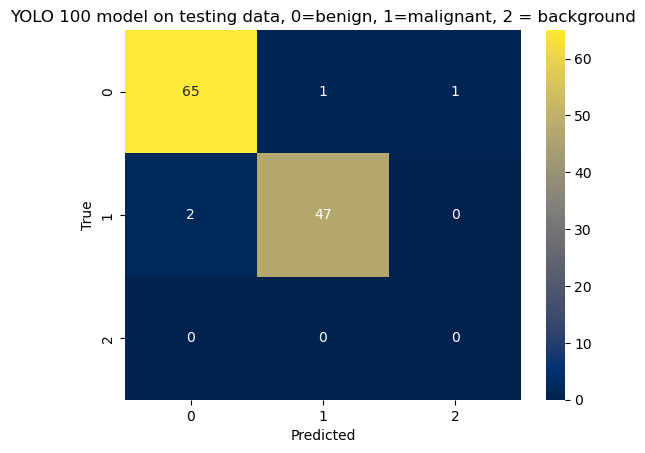

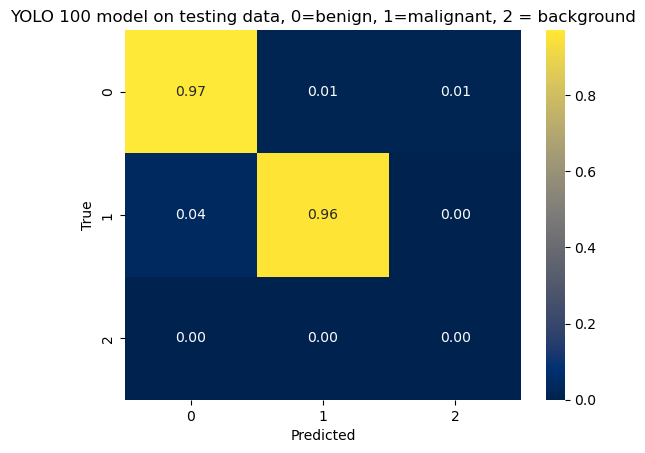

In [123]:
plot_confusion_matrix(true_state_list, predict_class_list, normalize=None,
                      title="YOLO 100 model on testing data, 0=benign, 1=malignant, 2 = background",
                     color_in='cividis')
plot_confusion_matrix(true_state_list, predict_class_list, normalize='true',
                      title="YOLO 100 model on testing data, 0=benign, 1=malignant, 2 = background",
                     color_in='cividis')

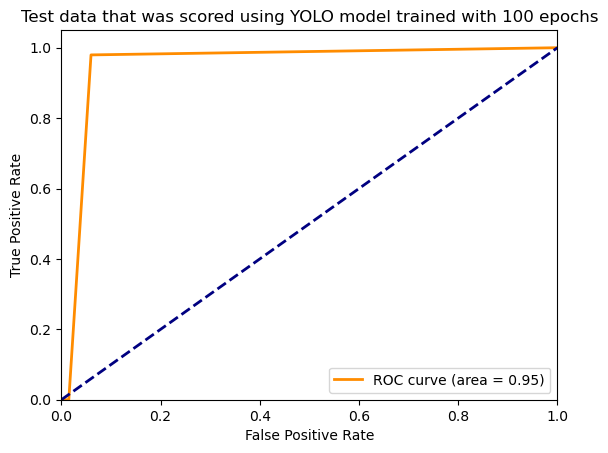

In [83]:
plot_roc_curve(true_state_list, predict_class_list, title="Test data that was scored using YOLO model trained with 100 epochs")

In [5]:
# Function not used but written to try Bayesian optimization on YOLO

In [ ]:
# Define the objective function for Bayesian optimization

# using TEST_PARAMS
# Define the objective function for Bayesian optimization
def objective_yolov8(lr0=.01, weight_decay=.01, momentum=.9, epochs=2,batch_size=-1 ):
    #param_grid = {'lr': [lr0],'momentum': [momentum], 'epochs': [epochs],'weight_decay': [weight_decay], 'batch_size': [32] }
    
    #accuracy = build_model(lr=lr, momentum=momentum, weight_decay=weight_decay, batch_size=batch_size, epochs=epochs, 
    #                      optimizer=optimizer_name, model_name=model_name)
    #accuracy=test_model_parameters(model_name, param_grid, train_dataset, valid_dataset, device, 
    #                               to_print=0, make_plots=0, write_csv=0)
    
    model = YOLO('yolov8n.pt')
    # Define your dataset
    yaml_file='C:\\Users\\dan_c\\Documents\\GA_tech\\PRACTICUM\\data\\Ultrasound-YOLOv8\\data\\config_yolov8.yaml'

    # Train the model and evaluate it on a validation set
    # The train method is a placeholder for the actual YOLOv8 training function
    # You will need to replace it with the actual training code that uses the config parameters
    # and returns evaluation metrics including mAP
    
    # Configure the model for training with hyperparameters
    #results = model.train(data=yaml_file,imgsz=640, batch=param_grid['batch_size'], epochs=param_grid['epochs'],
    #                      lr0=param_grid['lr'], momentum=param_grid['momentum'])
    results = model.train(data=yaml_file,imgsz=640, batch=batch_size, epochs=epochs, lr0=lr0, momentum=momentum, weight_decay=weight_decay)
    
    # metrics on VALIDATION
    print("Validation results:")
    metrics= model.val()
    metrics.box.map    # map50-95
    print("metrics.box.map50: ", metrics.box.map50)  # map50
    metrics.box.map75  # map75
    metrics.box.maps   # a list contains map50-95 of each category
    # metrics on TEST
    
    print("TEST results:")
    metrics= model.val(split='test', plots=True)
    metrics.box.map    # map50-95
    print("metrics.box.map50: ", metrics.box.map50)  # map50
    metrics.box.map75  # map75
    metrics.box.maps   # a list contains map50-95 of each category
    #val_map = results['val/mAP'] if 'val/mAP' in results else 0
    path_and_filename_list, predict_class_list, true_state_list = score_folder(folder_path=val_images_folder, model=the_model)
    
    accuracy, precision, recall, f1, all_labels, all_predictions=evaluate_model_yolo(true_state_list, predict_class_list)

    return accuracy
test=objective_yolov8()

In [158]:
########################################################################################################

# FasterRCNN

# We developed Faster_RCNN models but decided against including them because they did not preforrm well.
# Faster-RCNN was used with a Resnet18 backbone to try to use Resent to predict object location.
# We tried using 3 classes, benign, malignant, and background, which would allow both detecing and classifying a tumor.
#   And we tried using two classes, tumor and background, which would only find the tumor location.
# Neither approach produced good results.

In [157]:
########################################################################################################

# Approach trying both classificaiton and object detection in one Faster-RCNN model with a resnet18 backbone.
# Using labels 1 ='benign', 2= 'malignant', 0 is left for backgroud.

In [96]:
# Add boxes to Custom dataset
class UltrasoundDatasetBoxes(Dataset):
    def __init__(self, benign_path, malignant_path, transform=None):
        self.benign_path = benign_path
        self.malignant_path = malignant_path
        self.transform = transform
        self.data = []
        self.labels = []
        self.patient_numbers = []
        self.filenames = []

        # Iterate over each subdirectory in the benign and malignant folders
        for label, path in enumerate([benign_path, malignant_path]):
            # change from 0 for bengin, 1 for malignant 
            # to 1 for bengin, 2 for malignant, leaving 0 for background
            label = label +1
            
            for subdir in [f.path for f in os.scandir(path) if f.is_dir()]:
                patient_number = os.path.basename(subdir)  # Extract patient number from subdir path
                for file in os.listdir(subdir):
                    if file.endswith('.jpg'):
                        self.data.append(os.path.join(subdir, file))
                        self.labels.append(label)
                        self.patient_numbers.append(patient_number)
                        self.filenames.append(file)  # Store the filename

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Load the image and JSON file
        img_path = self.data[idx]       
        json_path = img_path.replace('.jpg', '.json')
        label = self.labels[idx]
        patient_number = self.patient_numbers[idx]
        filename = self.filenames[idx]  # Get the filename
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        # Because of more complex model structure, convert the images to pseudo RGB,
        #   instead of changing the first model layer to expect gray scale,
        #   this might even better leverage the pre-training of the model.
         # Convert grayscale image to pseudo-RGB by replicating the single channel across three channels
        image = image.convert("RGB")
        
        with open(json_path) as f:
            anns = json.load(f)

        boxes = []
        # all images contain tumors
        for ann in anns['shapes']:
            xmin, ymin = ann['points'][0]
            xmax, ymax = ann['points'][1]
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # use the label determined by the image's source path
        # all images contain tumors
        #label = 1
        # use labels 2 and 3
        labels = torch.full((len(boxes),), label, dtype=torch.int64)  # Correctly assigns benign (0) or malignant (1)
        
        # Resize the image to the desired size (e.g., 640x640)
        image = F.resize(image, size=(640, 640))

        # Convert image to tensor
        #image is converted to tensor in dataloader call
        #image = F.to_tensor(image)
        
        # create identifier for image
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target = {}
        target["boxes"] = boxes
        # here label is 1 for tumor and 0 for no tumor, always 1 because always a tumor, either bengin or malignant
        # This label is for object detection, not classification
        #target["labels"] = torch.ones((len(boxes),), dtype=torch.int64)  # Assuming only one class (tumor)
        target["labels"] = labels # here label is 1 for tumor and 0 for no tumor
        
       
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, target

In [97]:
#RuntimeError: CUDA error: out of memory
#CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
#For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
#Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

if torch.cuda.is_available():
    torch.cuda.empty_cache()  # Clear unused memory


In [103]:
full_dataset = UltrasoundDatasetBoxes(benign_path, malignant_path, transform=transforms.ToTensor())
print("length full dataset: ", len(full_dataset))

print("Distributions of labels in the full data set:")
# Convert the labels list to a Pandas Series
labels_series = pd.Series(full_dataset.labels)

# Get the frequency of each label
label_freq = labels_series.value_counts()

# If you want the frequencies sorted by the label value instead of the count, you can do:
label_freq_sorted = labels_series.value_counts().sort_index()

#print(label_freq)
print(label_freq_sorted)

# Set the random seed for reproducibility
seed = 12345678
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
# Set the random seed for reproducibility
seed = 12345678
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
generator1 = torch.Generator().manual_seed(seed)

# Create train and test datasets
#train_dataset, test_dataset, holdout_dataset = random_split(full_dataset, [.3, .2, .5], generator=generator1)
train_box_dataset, valid_box_dataset, test_box_dataset = random_split(full_dataset, [.8, .1, .1], generator=generator1)
# Create dataloaders

#data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

from torch.utils.data.dataloader import default_collate
# instead of returning dictionary of target, in loader return a (batch) list of dictionaries
def custom_collate(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    #images = default_collate(images) 
    images = torch.stack(images, dim=0)  # Stack images into a single tensor
    # No need to collate targets as we expect a list of dictionaries
    return images, targets

# Use the custom collate function in your DataLoader
train_box_dataloader = DataLoader(train_box_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)
valid_box_dataloader = DataLoader(valid_box_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)
test_box_dataloader  = DataLoader(test_box_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)

#train_dataloader  = DataLoader(train_dataset, batch_size=2, shuffle=True)
data_iter = iter(train_box_dataloader)
images, targets = next(data_iter)
images, targets = next(data_iter)
print("type check of structure")
print(type(targets))  # Should be <class 'list'> if batch_size > 1
if isinstance(targets, list):
    print(type(targets[0]))  # Should be <class 'dict'>
else:
    print("Targets is not a list. Check the dataset class implementation.")

print(type(targets))  # Should be <class 'list'>
#print(type(targets[0]))  # Should be <class 'dict'>

length full dataset:  1148
Distributions of labels in the full data set:
1    661
2    487
Name: count, dtype: int64
type check of structure
<class 'list'>
<class 'dict'>
<class 'list'>


In [104]:
#show dataloaders shapes
dataiter = iter(train_box_dataloader)
images, targets = next(dataiter)
# second value should be 3 for pseudo RGB
print(images.shape)
print(targets)

dataiter = iter(valid_box_dataloader)
images, targets = next(dataiter)
# second value should be 3 for pseudo RGB
print(images.shape)

dataiter = iter(test_box_dataloader)
images, targets = next(dataiter)
# second value should be 3 for pseudo RGB
print(images.shape)

torch.Size([16, 3, 640, 640])
[{'boxes': tensor([[103.4534, 147.1862, 558.9190, 351.2348]]), 'labels': tensor([1]), 'image_id': tensor([433]), 'area': tensor([92937.1094]), 'iscrowd': tensor([0])}, {'boxes': tensor([[272.2794, 177.9555, 371.4696, 222.8947]]), 'labels': tensor([1]), 'image_id': tensor([412]), 'area': tensor([4457.5386]), 'iscrowd': tensor([0])}, {'boxes': tensor([[335.4373, 181.1943, 550.0121, 395.7692]]), 'labels': tensor([2]), 'image_id': tensor([1124]), 'area': tensor([46042.3828]), 'iscrowd': tensor([0])}, {'boxes': tensor([[320.8623, 160.1417, 592.9271, 316.0121]]), 'labels': tensor([1]), 'image_id': tensor([174]), 'area': tensor([42406.8633]), 'iscrowd': tensor([0])}, {'boxes': tensor([[196.5708, 105.0810, 496.1660, 298.1984]]), 'labels': tensor([1]), 'image_id': tensor([29]), 'area': tensor([57857.0469]), 'iscrowd': tensor([0])}, {'boxes': tensor([[153.2510, 262.9757, 244.3441, 325.7288]]), 'labels': tensor([1]), 'image_id': tensor([593]), 'area': tensor([5716.37

In [106]:
def get_model(num_classes):
    # Load a pre-trained model for classification and return only the features
    backbone = resnet_fpn_backbone('resnet18', pretrained=True)
    model = FasterRCNN(backbone, num_classes=num_classes)
    return model

In [107]:
#Adding mAP plots
# Training loop

def run_with_backbone():
    
    start_opt = datetime.datetime.now()
    print("start time: ", start_opt.strftime("%Y_%m_%d_%H%M"))

    # FasterRCNN with resnet18 backbone, 
    # This model is object detection (tumor) not classification (benign vs malignamt)
    # Total number of classes is 2
    # 2 = 1 classes for tumors (benign or malignant here are 1 class tumor) + 1 for background
    model = get_model(num_classes=3) 

    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    num_epochs = 20
    
    #train_losses = [] 
    # model is predicting object detection, i.e. boxes, not classificaiton, i.e. labels
    # For measuring success at predicting boxes, mAP is considered a better measure than loss.
    
    # Before training loop, intitalize train_map_metric and val_map_metric
    # This funciton expects a list
    #train_map_metric = torchmetrics.detection.mean_ap.MeanAveragePrecision(box_format='xyxy', 
    #                                                                    iou_thresholds=torch.linspace(0.5, 0.95, 10).tolist())
    train_losses =[] 
    val_map_50_values = []
    
    val_map_values = []
    
    val_map_metric = torchmetrics.detection.mean_ap.MeanAveragePrecision(box_format='xyxy', 
                                                                        iou_thresholds=torch.linspace(0.5, 0.95, 10).tolist())

    
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0)   
    for epoch in range(num_epochs):
        # Reset metrics at the start of each epoch
        #train_map_metric.reset()
        val_map_metric.reset()
        model.train()
        
        running_loss = 0.0
        num_loaded = 0
        for images, targets in train_box_dataloader:

            #print("starting to load a batch")
            images = list(img.to(device) for img in images)
            # Ensure that targets are not None and are moved to the correct device
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets if t is not None]
            num_loaded = num_loaded  + 1
            # model is running slowly
            if num_loaded % 20 == 0:
                print("num_loaded: ", num_loaded)
                current_run_time = datetime.datetime.now() - start_opt
                print("Current running time:", current_run_time)
                
            optimizer.zero_grad()
            #cannot get predictin in training mode to get training mAP
            #outputs = model(images)  # Get model predictions

            # Pass both images and targets to the model to compute the loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            running_loss += losses.item()
            
        # Calculate training loss for the epoch
        epoch_loss = running_loss / len(train_box_dataloader)
        train_losses.append(epoch_loss)
            
            #cannot get predictin in training mode to get training mAP
            # Convert model outputs and targets to the format expected by torchmetrics
            # This step depends on your model's output format
            #preds = [{'boxes': output['boxes'], 'labels': output['labels'], 'scores': output['scores']} for output in outputs]
            #target = [{'boxes': target['boxes'], 'labels': target['labels']} for target in targets]

            # Update training mAP
            #train_map_metric.update(preds, target)
        
        # Compute training mAP for the epoch
        #train_epoch_map = train_map_metric.compute()
        
            # Convert bounding boxes from (x1, y1, x2, y2) to (x, y, w, h)
            #preds = [{k: v.detach() for k, v in t.items()} for t in model(images)]
            #for pred, target in zip(preds, targets):
            #    pred_boxes = box_convert(pred['boxes'], in_fmt='xyxy', out_fmt='xywh')
            #    target_boxes = box_convert(target['boxes'], in_fmt='xyxy', out_fmt='xywh')

                # Update metric
            #    map_metric.update(pred_boxes, pred['labels'], pred['scores'], target_boxes, target['labels'])
        # Validation phase
        model.eval()
        with torch.no_grad():
            for images, targets in valid_box_dataloader:
                # Forward pass to get model predictions
                # ...
                images = list(img.to(device) for img in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Forward pass to get the model's predictions
                outputs = model(images)
                
            # Update mAP metric
            for i, output in enumerate(outputs):
                # Convert model outputs and targets to the format expected by torchmetrics 
                preds = [{'boxes': output['boxes'], 'labels': output['labels'], 'scores': output['scores']} for output in outputs]
                target = [{'boxes': target['boxes'], 'labels': target['labels']} for target in targets]

                # Update validation mAP
                val_map_metric.update(preds, target)
        print(f'Epoch {epoch+1}/{num_epochs}' )
        print("num_loaded: ", num_loaded)
        # Compute validation mAP for the epoch
        val_epoch_map = val_map_metric.compute()
        #print('val_epoch_map: ')
        #for key, value in val_epoch_map.items():
        #    print("key: " , key," value: ", value)
        #print("val_epoch_map['map'].item(): ",val_epoch_map['map'].item())
        
        val_epoch_map_value =val_epoch_map['map'].item()       
        #print("val_epoch_map_value: ", val_epoch_map_value)
        val_map_values.append(val_epoch_map_value)        
        #print("val_map_values: ", val_map_values)      
        #print("len(val_map_values): ", len(val_map_values))
        
        
        val_epoch_map_50_value =val_epoch_map['map_50'].item()       
        #print("val_epoch_map_50_value: ", val_epoch_map_50_value)
        val_map_50_values.append(val_epoch_map_50_value)        
        #print("val_map_50_values: ", val_map_50_values)      
        #print("len(val_map_50_values): ", len(val_map_50_values))       
        
        # Log or print mAP values
        print(f'Epoch {epoch+1}/{num_epochs}: Training Loss: {epoch_loss:.4f}, Validation mAP: {val_epoch_map}')
         
        # After processing each batch, delete the tensors that are no longer needed
        #del images, targets, preds, loss_dict, losses
        del images, targets, target, preds
        torch.cuda.empty_cache()  # Optionally clear unused memory


    # Epoch numbers
    epochs = range(1, num_epochs + 1)
 
    # lists `train_map_values` and `val_map_values` with mAP values for each epoch
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_losses, label='Training Loss') 
    plt.xlabel('Epoch') 
    plt.title('Training Loss')
    plt.legend()
    plt.show()
    
    # lists `train_map_values` and `val_map_values` with mAP values for each epoch
  
    plt.plot(epochs, val_map_values, label='Validation mAP')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('Validation mAP')
    plt.legend()
    plt.show()
    
    # lists `train_map_values` and `val_map_values` with mAP values for each epoch
  
    plt.plot(epochs, val_map_50_values, label='Validation mAP 50')
    plt.xlabel('Epoch')
    plt.ylabel('mAP 50')
    plt.title('Validation mAP 50')
    plt.legend()
    plt.show()

    run_time = datetime.datetime.now() - start_opt
    print("run time:", run_time)
    return model


start time:  2024_04_06_1530


C:\Users\dan_c\anaconda3\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\dan_c\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dan_c\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


num_loaded:  20
Current running time: 0:01:24.663859
num_loaded:  40
Current running time: 0:02:46.341032
Epoch 1/20
num_loaded:  58
Epoch 1/20: Training Loss: 0.6057, Validation mAP: {'map': tensor(0.0505), 'map_50': tensor(0.1262), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(0.), 'map_large': tensor(0.1010), 'mar_1': tensor(0.1000), 'mar_10': tensor(0.1000), 'mar_100': tensor(0.1000), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.2000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2], dtype=torch.int32)}
num_loaded:  20
Current running time: 0:05:27.158548
num_loaded:  40
Current running time: 0:06:58.409912
Epoch 2/20
num_loaded:  58
Epoch 2/20: Training Loss: 0.2018, Validation mAP: {'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'm

num_loaded:  20
Current running time: 1:09:51.795994
num_loaded:  40
Current running time: 1:11:27.045666
Epoch 15/20
num_loaded:  58
Epoch 15/20: Training Loss: 0.1458, Validation mAP: {'map': tensor(0.3712), 'map_50': tensor(1.), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.3712), 'mar_1': tensor(0.3500), 'mar_10': tensor(0.4250), 'mar_100': tensor(0.4250), 'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.4250), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2], dtype=torch.int32)}
num_loaded:  20
Current running time: 1:14:23.195515
num_loaded:  40
Current running time: 1:15:54.828237
Epoch 16/20
num_loaded:  58
Epoch 16/20: Training Loss: 0.1502, Validation mAP: {'map': tensor(0.1219), 'map_50': tensor(0.6667), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.1219), 'mar_1': tensor(0.1250), 'mar_10': tensor(0.2750), 'ma

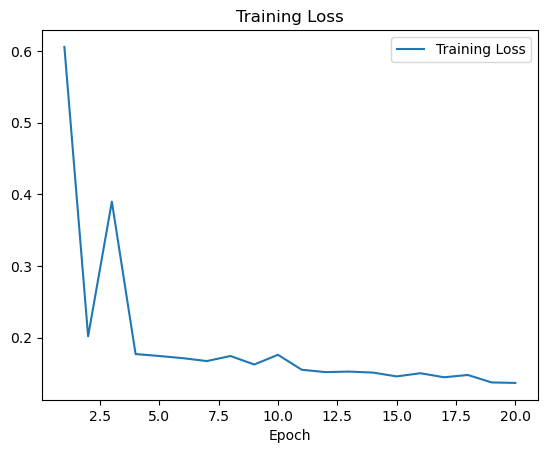

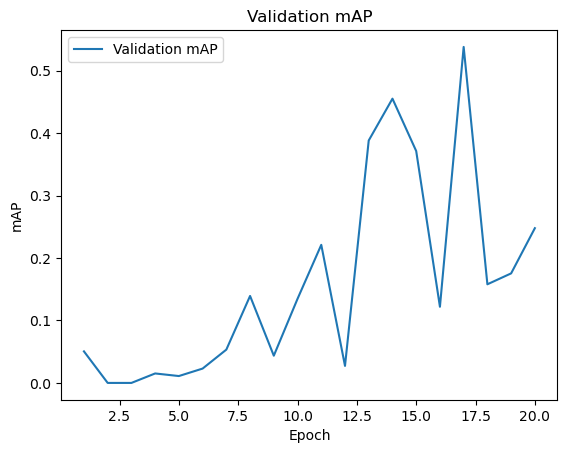

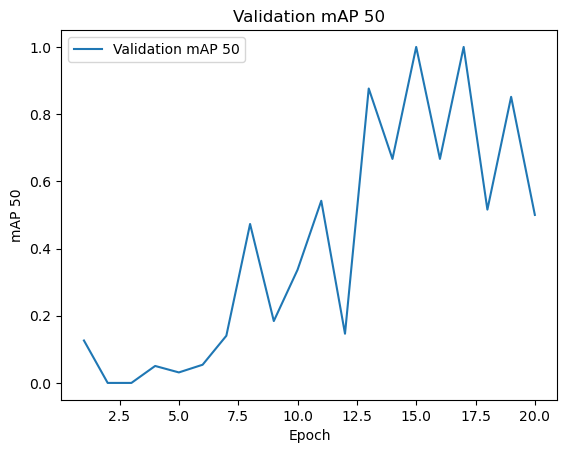

run time: 1:36:38.636873


In [108]:
backbone_model_class_object_02 = run_with_backbone()

In [109]:
# Assuming backbone_model is your trained model
#model_out_path = Path(FasterRCNN_path).joinpath('backbone_model_class_object_02.pth')

#torch.save(backbone_model_class_object_02.state_dict(), model_out_path)

In [217]:
import torch
import torchmetrics
from torchvision.ops import box_convert

def validate_model(model, dataloader, device, title=None):
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0.0

    all_predictions = []
    all_labels = []
    
    pred_labels = []
    true_labels = []

    # Initialize metrics
    map_metric = torchmetrics.detection.mean_ap.MeanAveragePrecision(box_format='xyxy', iou_thresholds=[0.50])

    with torch.no_grad():  # No need to track gradients
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(images)  # This should return a list of dictionaries with predictions

        
        # Process output dictionaries in list

            for i, output in enumerate(outputs):
                # Initialize empty tensors if there are no predictions
                if output['scores'].nelement() == 0:
                    predicted_box = torch.empty((0, 4), device=device)
                    predicted_label_tensor = torch.empty((0,), dtype=torch.int64, device=device)                    
                    predicted_score = torch.empty((0,), device=device)
                    # Handle case with no predictions
                    all_predictions.append(int(-1))  # Placeholder for no detection
                else:
                    # Get the prediction with the highest score
                    max_score, max_score_idx = torch.max(output['scores'], dim=0)
                    predicted_label_tensor = output['labels'][max_score_idx].unsqueeze(0)  # Ensure it's a 1D tensor
                    predicted_label_scalar = output['labels'][max_score_idx].item()  # Convert to Python scalar
                    predicted_label_numpy = output['labels'][max_score_idx].cpu().numpy()  # Convert to numpy
                    predicted_box = output['boxes'][max_score_idx].unsqueeze(0)  # Ensure it's a 2D tensor
                    predicted_score = output['scores'][max_score_idx].unsqueeze(0)  # Ensure it's a 1D tensor
                    # Append the label with the highest score
                    all_predictions.append(predicted_label_scalar) 
                    #all_predictions.append(predicted_label.item())
                    #print("type(predicted_label_tensor: ", type(predicted_label_tensor))
                    #print("type(predicted_label_scalar: ", type(predicted_label_scalar))
                    #print("type(predicted_label_numpy: ", type(predicted_label_numpy))
                # Assuming each image has exactly one ground truth label
                true_label = targets[i]['labels'][0].item()  # Convert to Python scalar
                #print("type(true_label)): " , type(true_label))
                all_labels.append(true_label)

            # Get the prediction with the highest score
                #max_score, max_score_idx = torch.max(output['scores'], dim=0)
                #predicted_label = output['labels'][max_score_idx]
                #predicted_box = output['boxes'][max_score_idx]

                #target_true_label_cpu = targets[i]['labels'][0].cpu().numpy()
                #pred_label_cpu = preds['labels'].cpu().numpy()
                #true_labels.append(target_true_label_cpu)
                #pred_labels.append(pred_label_cpu)

                # Convert to torchmetrics format 
                # predicitons have scores, true labels do not
                preds = {
                    'boxes': predicted_box,
                    'scores': predicted_score,
                    'labels': predicted_label_tensor
                }

                target = {
                    'boxes': targets[i]['boxes'],
                    'labels': targets[i]['labels']
                }

                debug = 0
                if debug == 1:

                    for k,v in preds.items():          
                        print("pred k: ", k)
                        print("pred v:", v)
                        print("pred v.shape(): ", v.shape)

                    for k,v in target.items():          
                        print("target k: ", k)
                        print("target v:", v)
                        print("target v.shape(): ", v.shape)
                
                # Update the metric
                map_metric.update([preds], [target])
            
    # Convert lists to NumPy arrays for metric calculation
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=1)
    #recall = recall_score(all_labels, all_predictions, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Compute final metric values
    final_map = map_metric.compute() 
    print(f'mAP at IoU=0.50: {final_map["map_50"]}')
    
    print(f'mAP: {final_map}') 
    plot_confusion_matrix(all_labels, all_predictions, title=title, save_path=None, normalize=None, color='coolwarm')
    # rows of true add up to 100% to see where true went
    plot_confusion_matrix(all_labels, all_predictions, title=title, save_path=None, normalize='true', color='coolwarm')
    # all cells together add up to 100%
    #plot_confusion_matrix(all_labels, all_predictions, title=None, save_path=None, normalize='all')

    #plot_roc_curve(all_labels, all_predictions, title=None, save_path=None)
        
    return all_labels, all_predictions, final_map


Accuracy: 79.65%
Precision: 0.82
Recall: 0.80
F1 Score: 0.80
mAP at IoU=0.50: 0.4521760046482086
mAP: {'map': tensor(0.4522), 'map_50': tensor(0.4522), 'map_75': tensor(-1.), 'map_small': tensor(-1.), 'map_medium': tensor(0.4948), 'map_large': tensor(0.4155), 'mar_1': tensor(0.5680), 'mar_10': tensor(0.5680), 'mar_100': tensor(0.5680), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.6405), 'mar_large': tensor(0.5164), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2], dtype=torch.int32)}


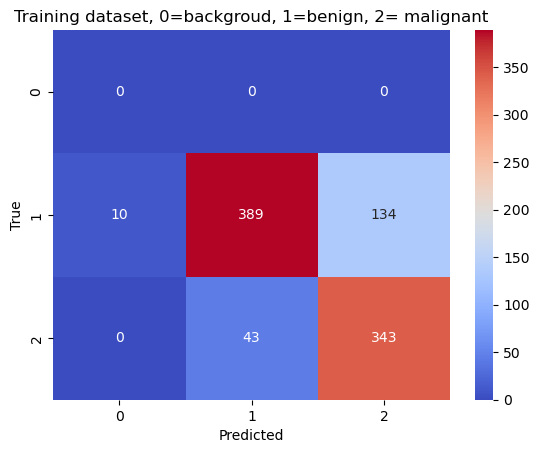

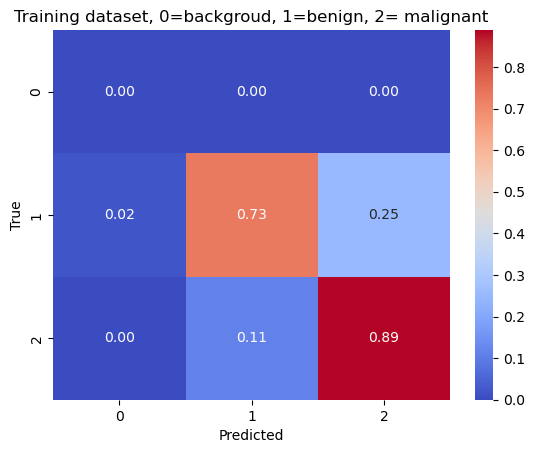

In [220]:
all_labels, all_predictions, final_map= validate_model(backbone_model_class_object_02, train_box_dataloader, device,
                                                      title='Training dataset, 0=backgroud, 1=benign, 2= malignant')

Accuracy: 77.19%
Precision: 0.79
Recall: 0.77
F1 Score: 0.78
mAP at IoU=0.50: 0.3787791132926941
mAP: {'map': tensor(0.3788), 'map_50': tensor(0.3788), 'map_75': tensor(-1.), 'map_small': tensor(-1.), 'map_medium': tensor(0.2650), 'map_large': tensor(0.3741), 'mar_1': tensor(0.4740), 'mar_10': tensor(0.4740), 'mar_100': tensor(0.4740), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.4118), 'mar_large': tensor(0.4610), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2], dtype=torch.int32)}


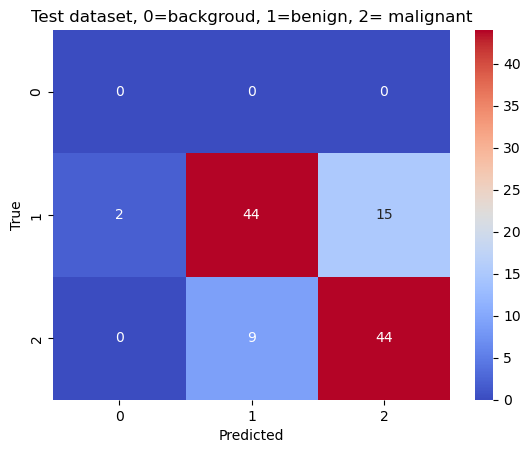

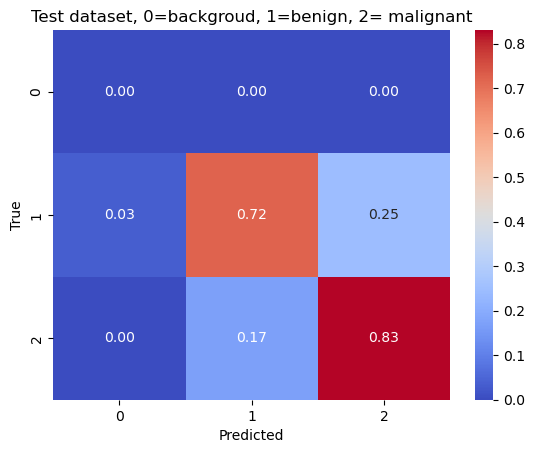

In [219]:
all_labels, all_predictions, final_map= validate_model(backbone_model_class_object_02, test_box_dataloader, device, 
                                                       title='Test dataset, 0=backgroud, 1=benign, 2= malignant')

In [159]:
#############################################################################################################

# Object Detection
# Predicting boxes showing tumor location without classification of benign vs malignant
# by using Resnet18 as a backbone to FasterRCNN

## Class for custom dataset with boxes and label of 1 for tumor
## Only two classes, tumor and background
## Does detection, but not clasification

### Custom class with label of 1 because all images have tumors

In [4]:
# Add boxes to Custom dataset
class UltrasoundDatasetBoxes(Dataset):
    def __init__(self, benign_path, malignant_path, transform=None):
        self.benign_path = benign_path
        self.malignant_path = malignant_path
        self.transform = transform
        self.data = []
        self.labels = []
        self.patient_numbers = []
        self.filenames = []

        # Iterate over each subdirectory in the benign and malignant folders
        for label, path in enumerate([benign_path, malignant_path]):
            for subdir in [f.path for f in os.scandir(path) if f.is_dir()]:
                patient_number = os.path.basename(subdir)  # Extract patient number from subdir path
                for file in os.listdir(subdir):
                    if file.endswith('.jpg'):
                        self.data.append(os.path.join(subdir, file))
                        self.labels.append(label)
                        self.patient_numbers.append(patient_number)
                        self.filenames.append(file)  # Store the filename

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Load the image and JSON file
        img_path = self.data[idx]       
        json_path = img_path.replace('.jpg', '.json')
        label = self.labels[idx]
        patient_number = self.patient_numbers[idx]
        filename = self.filenames[idx]  # Get the filename
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        # Because of more complex model structure, convert the images to pseudo RGB,
        #   instead of changing the first model layer to expect gray scale,
        #   this might even better leverage the pre-training of the model.
         # Convert grayscale image to pseudo-RGB by replicating the single channel across three channels
        image = image.convert("RGB")
        
        with open(json_path) as f:
            anns = json.load(f)

        boxes = []
        # all images contain tumors
        for ann in anns['shapes']:
            xmin, ymin = ann['points'][0]
            xmax, ymax = ann['points'][1]
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # use the label determined by the image's source path
        # all images contain tumors
        label = 1
        labels = torch.full((len(boxes),), label, dtype=torch.int64)  # Correctly assigns benign (0) or malignant (1)
        
        # Resize the image to the desired size (e.g., 640x640)
        image = F.resize(image, size=(640, 640))

        # Convert image to tensor
        #image is converted to tensor in dataloader call
        #image = F.to_tensor(image)
        
        # create identifier for image
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target = {}
        target["boxes"] = boxes
        # here label is 1 for tumor and 0 for no tumor, always 1 because always a tumor, either bengin or malignant
        # This label is for object detection, not classification
        #target["labels"] = torch.ones((len(boxes),), dtype=torch.int64)  # Assuming only one class (tumor)
        target["labels"] = labels # here label is 1 for tumor and 0 for no tumor
        
       
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, target

In [5]:
#RuntimeError: CUDA error: out of memory
#CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
#For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
#Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

if torch.cuda.is_available():
    torch.cuda.empty_cache()  # Clear unused memory


## Using dataloaders that include boxes and labels
### note: using same seed as original data partition

In [6]:
full_dataset = UltrasoundDatasetBoxes(benign_path, malignant_path, transform=transforms.ToTensor())
print("length full dataset: ", len(full_dataset))

# Set the random seed for reproducibility
seed = 12345678
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
# Set the random seed for reproducibility
seed = 12345678
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
generator1 = torch.Generator().manual_seed(seed)

# Create train and test datasets
#train_dataset, test_dataset, holdout_dataset = random_split(full_dataset, [.3, .2, .5], generator=generator1)
train_box_dataset, valid_box_dataset, test_box_dataset = random_split(full_dataset, [.8, .1, .1], generator=generator1)
# Create dataloaders

#data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

from torch.utils.data.dataloader import default_collate
# instead of returning dictionary of target, in loader return a (batch) list of dictionaries
def custom_collate(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    #images = default_collate(images) 
    images = torch.stack(images, dim=0)  # Stack images into a single tensor
    # No need to collate targets as we expect a list of dictionaries
    return images, targets

# Use the custom collate function in your DataLoader
train_box_dataloader = DataLoader(train_box_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)
valid_box_dataloader = DataLoader(valid_box_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)
test_box_dataloader  = DataLoader(test_box_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)

#train_dataloader  = DataLoader(train_dataset, batch_size=2, shuffle=True)
data_iter = iter(train_box_dataloader)
images, targets = next(data_iter)
images, targets = next(data_iter)
print(type(targets))  # Should be <class 'list'> if batch_size > 1
if isinstance(targets, list):
    print(type(targets[0]))  # Should be <class 'dict'>
else:
    print("Targets is not a list. Check the dataset class implementation.")

print(type(targets))  # Should be <class 'list'>
#print(type(targets[0]))  # Should be <class 'dict'>

length full dataset:  1148
<class 'list'>
<class 'dict'>
<class 'list'>


# A look at shape of output from box/label dataloaders
## including a look at a target

In [7]:
#show dataloaders shapes
dataiter = iter(train_box_dataloader)
images, targets = next(dataiter)
# second value should be 3 for pseudo RGB
print(images.shape)
print(targets)

dataiter = iter(valid_box_dataloader)
images, targets = next(dataiter)
# second value should be 3 for pseudo RGB
print(images.shape)

dataiter = iter(test_box_dataloader)
images, targets = next(dataiter)
# second value should be 3 for pseudo RGB
print(images.shape)

torch.Size([16, 3, 640, 640])
[{'boxes': tensor([[103.4534, 147.1862, 558.9190, 351.2348]]), 'labels': tensor([1]), 'image_id': tensor([433]), 'area': tensor([92937.1094]), 'iscrowd': tensor([0])}, {'boxes': tensor([[272.2794, 177.9555, 371.4696, 222.8947]]), 'labels': tensor([1]), 'image_id': tensor([412]), 'area': tensor([4457.5386]), 'iscrowd': tensor([0])}, {'boxes': tensor([[335.4373, 181.1943, 550.0121, 395.7692]]), 'labels': tensor([1]), 'image_id': tensor([1124]), 'area': tensor([46042.3828]), 'iscrowd': tensor([0])}, {'boxes': tensor([[320.8623, 160.1417, 592.9271, 316.0121]]), 'labels': tensor([1]), 'image_id': tensor([174]), 'area': tensor([42406.8633]), 'iscrowd': tensor([0])}, {'boxes': tensor([[196.5708, 105.0810, 496.1660, 298.1984]]), 'labels': tensor([1]), 'image_id': tensor([29]), 'area': tensor([57857.0469]), 'iscrowd': tensor([0])}, {'boxes': tensor([[153.2510, 262.9757, 244.3441, 325.7288]]), 'labels': tensor([1]), 'image_id': tensor([593]), 'area': tensor([5716.37

## Function to assign a resnet18 backbone to a FasterRCNN model, called with number of classes

In [8]:
def get_model(num_classes):
    # Load a pre-trained model for classification and return only the features
    backbone = resnet_fpn_backbone('resnet18', pretrained=True)
    model = FasterRCNN(backbone, num_classes=num_classes)
    return model

# Function to train a model that has both lables and boxes

In [113]:
#Adding mAP plots
# Training loop

def run_with_backbone():
    
    start_opt = datetime.datetime.now()
    print("start time: ", start_opt.strftime("%Y_%m_%d_%H%M"))

    # FasterRCNN with resnet18 backbone, 
    # This model is object detection (tumor) not classification (benign vs malignamt)
    # Total number of classes is 2
    # 2 = 1 classes for tumors (benign or malignant here are 1 class tumor) + 1 for background
    model = get_model(num_classes=2) 

    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    num_epochs = 20
    
    #train_losses = [] 
    # model is predicting object detection, i.e. boxes, not classificaiton, i.e. labels
    # For measuring success at predicting boxes, mAP is considered a better measure than loss.
    
    # Before training loop, intitalize train_map_metric and val_map_metric
    # This funciton expects a list
    #train_map_metric = torchmetrics.detection.mean_ap.MeanAveragePrecision(box_format='xyxy', 
    #                                                                    iou_thresholds=torch.linspace(0.5, 0.95, 10).tolist())
    train_losses =[] 
    val_map_50_values = []
    
    val_map_values = []
    
    val_map_metric = torchmetrics.detection.mean_ap.MeanAveragePrecision(box_format='xyxy', 
                                                                        iou_thresholds=torch.linspace(0.5, 0.95, 10).tolist())

    
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0)   
    for epoch in range(num_epochs):
        # Reset metrics at the start of each epoch
        #train_map_metric.reset()
        val_map_metric.reset()
        model.train()
        
        running_loss = 0.0
        num_loaded = 0
        for images, targets in train_box_dataloader:

            #print("starting to load a batch")
            images = list(img.to(device) for img in images)
            # Ensure that targets are not None and are moved to the correct device
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets if t is not None]
            num_loaded = num_loaded  + 1
            # model is running slowly
            if num_loaded % 20 == 0:
                print("num_loaded: ", num_loaded)
                current_run_time = datetime.datetime.now() - start_opt
                print("Current running time:", current_run_time)
                
            optimizer.zero_grad()
            #cannot get predictin in training mode to get training mAP
            #outputs = model(images)  # Get model predictions

            # Pass both images and targets to the model to compute the loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            running_loss += losses.item()
            
        # Calculate training loss for the epoch
        epoch_loss = running_loss / len(train_box_dataloader)
        train_losses.append(epoch_loss)
            
            #cannot get predictin in training mode to get training mAP
            # Convert model outputs and targets to the format expected by torchmetrics
            # This step depends on your model's output format
            #preds = [{'boxes': output['boxes'], 'labels': output['labels'], 'scores': output['scores']} for output in outputs]
            #target = [{'boxes': target['boxes'], 'labels': target['labels']} for target in targets]

            # Update training mAP
            #train_map_metric.update(preds, target)
        
        # Compute training mAP for the epoch
        #train_epoch_map = train_map_metric.compute()
        
            # Convert bounding boxes from (x1, y1, x2, y2) to (x, y, w, h)
            #preds = [{k: v.detach() for k, v in t.items()} for t in model(images)]
            #for pred, target in zip(preds, targets):
            #    pred_boxes = box_convert(pred['boxes'], in_fmt='xyxy', out_fmt='xywh')
            #    target_boxes = box_convert(target['boxes'], in_fmt='xyxy', out_fmt='xywh')

                # Update metric
            #    map_metric.update(pred_boxes, pred['labels'], pred['scores'], target_boxes, target['labels'])
        # Validation phase
        model.eval()
        with torch.no_grad():
            for images, targets in valid_box_dataloader:
                # Forward pass to get model predictions
                # ...
                images = list(img.to(device) for img in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Forward pass to get the model's predictions
                outputs = model(images)
                
            # Update mAP metric
            for i, output in enumerate(outputs):
                # Convert model outputs and targets to the format expected by torchmetrics 
                preds = [{'boxes': output['boxes'], 'labels': output['labels'], 'scores': output['scores']} for output in outputs]
                target = [{'boxes': target['boxes'], 'labels': target['labels']} for target in targets]

                # Update validation mAP
                val_map_metric.update(preds, target)
        print(f'Epoch {epoch+1}/{num_epochs}' )
        print("num_loaded: ", num_loaded)
        # Compute validation mAP for the epoch
        val_epoch_map = val_map_metric.compute()
        #print('val_epoch_map: ')
        #for key, value in val_epoch_map.items():
        #    print("key: " , key," value: ", value)
        #print("val_epoch_map['map'].item(): ",val_epoch_map['map'].item())
        
        val_epoch_map_value =val_epoch_map['map'].item()       
        #print("val_epoch_map_value: ", val_epoch_map_value)
        val_map_values.append(val_epoch_map_value)        
        #print("val_map_values: ", val_map_values)      
        #print("len(val_map_values): ", len(val_map_values))
        
        
        val_epoch_map_50_value =val_epoch_map['map_50'].item()       
        #print("val_epoch_map_50_value: ", val_epoch_map_50_value)
        val_map_50_values.append(val_epoch_map_50_value)        
        #print("val_map_50_values: ", val_map_50_values)      
        #print("len(val_map_50_values): ", len(val_map_50_values))       
        
        # Log or print mAP values
        print(f'Epoch {epoch+1}/{num_epochs}: Training Loss: {epoch_loss:.4f}, Validation mAP: {val_epoch_map}')
         
        # After processing each batch, delete the tensors that are no longer needed
        #del images, targets, preds, loss_dict, losses
        del images, targets, target, preds
        torch.cuda.empty_cache()  # Optionally clear unused memory


    # Epoch numbers
    epochs = range(1, num_epochs + 1)
 
    # lists `train_map_values` and `val_map_values` with mAP values for each epoch
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_losses, label='Training Loss') 
    plt.xlabel('Epoch') 
    plt.title('Training Loss')
    plt.legend()
    plt.show()
    
    # lists `train_map_values` and `val_map_values` with mAP values for each epoch
  
    plt.plot(epochs, val_map_values, label='Validation mAP')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('Validation mAP')
    plt.legend()
    plt.show()
    
    # lists `train_map_values` and `val_map_values` with mAP values for each epoch
  
    plt.plot(epochs, val_map_50_values, label='Validation mAP 50')
    plt.xlabel('Epoch')
    plt.ylabel('mAP 50')
    plt.title('Validation mAP 50')
    plt.legend()
    plt.show()

    run_time = datetime.datetime.now() - start_opt
    print("run time:", run_time)
    return model


start time:  2024_04_06_0135
num_loaded:  20
Current running time: 0:01:20.343616
num_loaded:  40
Current running time: 0:02:43.939730
Epoch 1/20
num_loaded:  58
Epoch 1/20: Training Loss: 0.4027, Validation mAP: {'map': tensor(0.0006), 'map_50': tensor(0.0062), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.0006), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.0333), 'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.0333), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(1, dtype=torch.int32)}
num_loaded:  20
Current running time: 0:05:10.801556
num_loaded:  40
Current running time: 0:06:18.124366
Epoch 2/20
num_loaded:  58
Epoch 2/20: Training Loss: 0.1745, Validation mAP: {'map': tensor(0.0337), 'map_50': tensor(0.1122), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.0505), 'mar_1': tensor(0.), 'mar_10': tensor(

num_loaded:  20
Current running time: 1:11:06.050830
num_loaded:  40
Current running time: 1:12:26.722676
Epoch 15/20
num_loaded:  58
Epoch 15/20: Training Loss: 0.1120, Validation mAP: {'map': tensor(0.1000), 'map_50': tensor(0.3317), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.1000), 'mar_1': tensor(0.0667), 'mar_10': tensor(0.2000), 'mar_100': tensor(0.2000), 'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.2000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(1, dtype=torch.int32)}
num_loaded:  20
Current running time: 1:15:39.630495
num_loaded:  40
Current running time: 1:17:46.317032
Epoch 16/20
num_loaded:  58
Epoch 16/20: Training Loss: 0.1161, Validation mAP: {'map': tensor(0.4423), 'map_50': tensor(1.), 'map_75': tensor(0.1122), 'map_small': tensor(-1.), 'map_medium': tensor(0.3500), 'map_large': tensor(0.5252), 'mar_1': tensor(0.4667), 'mar_10': tensor(0.5000), '

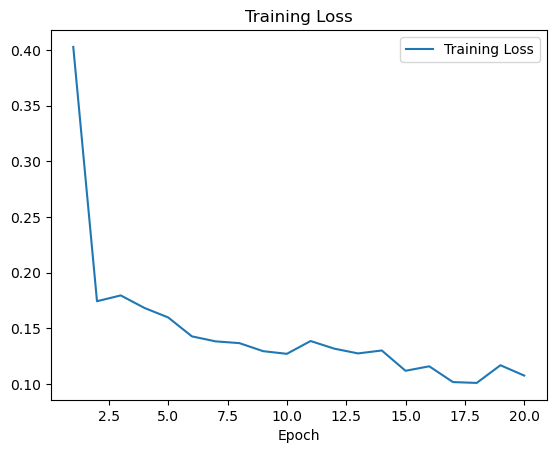

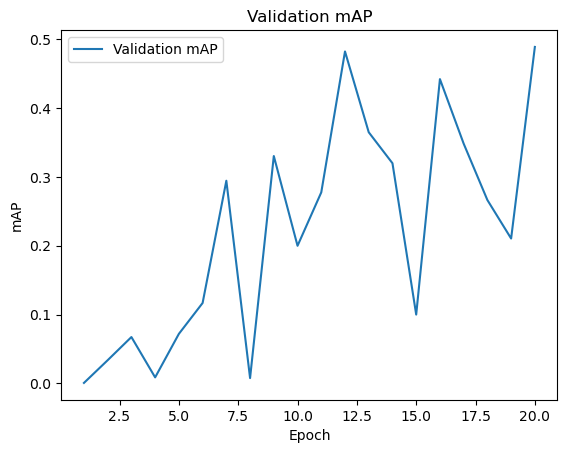

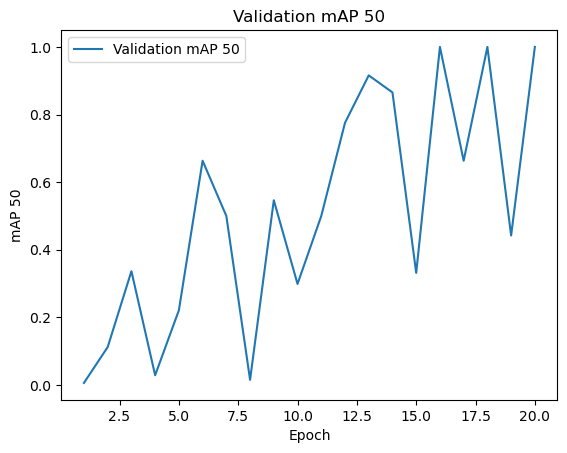

run time: 1:38:47.660184


In [12]:
backbone_model_03 = run_with_backbone()

start time:  2024_04_04_2303
num_loaded:  20
Current running time: 0:02:00.696764
num_loaded:  40
Current running time: 0:04:08.327266
Epoch 1/20
num_loaded:  58
Epoch 1/20: Training Loss: 1.2358, Validation mAP: {'map': tensor(0.0252), 'map_50': tensor(0.1262), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(0.), 'map_large': tensor(0.0505), 'mar_1': tensor(0.0500), 'mar_10': tensor(0.0500), 'mar_100': tensor(0.0500), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.1000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1], dtype=torch.int32)}
num_loaded:  20
Current running time: 0:08:18.060757
num_loaded:  40
Current running time: 0:10:25.786301
Epoch 2/20
num_loaded:  58
Epoch 2/20: Training Loss: 0.1839, Validation mAP: {'map': tensor(0.0167), 'map_50': tensor(0.0833), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.0167), 'mar_1': tensor(0.), 'mar_1

num_loaded:  20
Current running time: 1:30:13.228620
num_loaded:  40
Current running time: 1:32:22.709022
Epoch 15/20
num_loaded:  58
Epoch 15/20: Training Loss: 0.1436, Validation mAP: {'map': tensor(0.1313), 'map_50': tensor(0.5000), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.1313), 'mar_1': tensor(0.1250), 'mar_10': tensor(0.2250), 'mar_100': tensor(0.2250), 'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.2250), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1], dtype=torch.int32)}
num_loaded:  20
Current running time: 1:36:33.750589
num_loaded:  40
Current running time: 1:38:42.138312
Epoch 16/20
num_loaded:  58
Epoch 16/20: Training Loss: 0.1470, Validation mAP: {'map': tensor(0.1096), 'map_50': tensor(0.3232), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.1096), 'mar_1': tensor(0.1500), 'mar_10': tensor(0.1750),

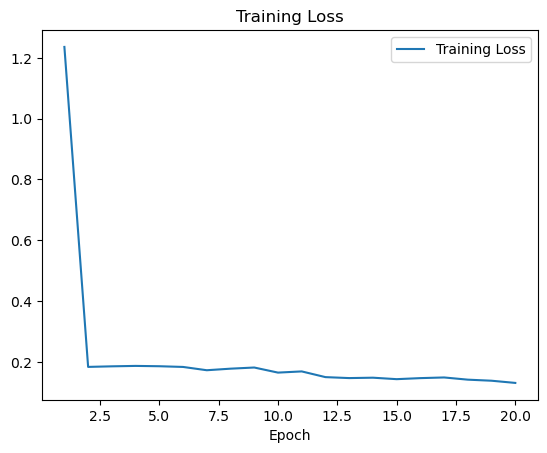

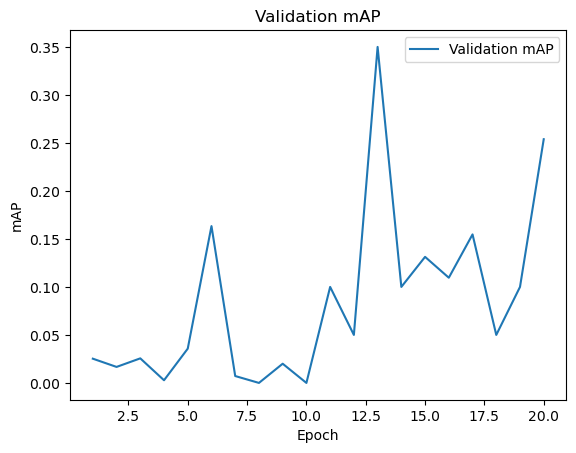

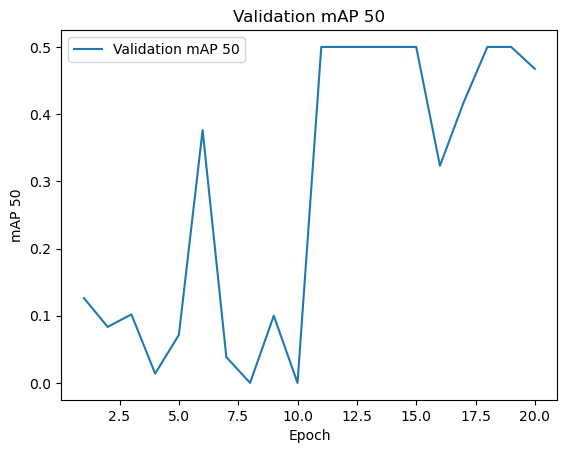

run time: 2:06:10.287859


In [47]:
backbone_model_02 = run_with_backbone()

In [162]:
############################################################################################################################

## Additonal runs with 70 epochs for Mobilenet and Resnet
#  We originally worked with a cpu, and model trained very slowly.
# Later we were able to obtain a laptop with a GPU which gave us more options and greatly reduced training time.

start time:  2024_04_01_1840
mobilenet
Model number:  1  current_params:  {'lr': 0.001, 'momentum': 0.9, 'epochs': 70, 'weight_decay': 0.01, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/70:
Train Loss: 0.5100, Train Accuracy: 0.7606
Testing Loss: 0.5947 Testing Accuracy: 0.6754
Finished Epoch 1
Epoch 2/70:
Train Loss: 0.3973, Train Accuracy: 0.8205
Testing Loss: 0.5359 Testing Accuracy: 0.7982
Finished Epoch 2
Epoch 3/70:
Train Loss: 0.3373, Train Accuracy: 0.8618
Testing Loss: 0.5150 Testing Accuracy: 0.6316
Finished Epoch 3
Epoch 4/70:
Train Loss: 0.2963, Train Accuracy: 0.8575
Testing Loss: 0.3553 Testing Accuracy: 0.7719
Finished Epoch 4
Epoch 5/70:
Train Loss: 0.3155, Train Accuracy: 0.8814
Testing Loss: 0.4175 Testing Accuracy: 0.8246
Finished Epoch 5
Epoch 6/70:
Train Loss: 0.2821, Train Accuracy: 0.8868
Testing Loss: 0.6425 Testing Accuracy: 0.4912
Finished Epoch 6
Epoch 7/70:
Train Loss: 0.2668, Train Accuracy: 0.8923
Testing Loss: 0.4083 Testing Accuracy: 0.8333
Finished Ep

Epoch 68/70:
Train Loss: 0.0663, Train Accuracy: 0.9902
Testing Loss: 0.5031 Testing Accuracy: 0.7807
Finished Epoch 68
Epoch 69/70:
Train Loss: 0.1052, Train Accuracy: 0.9663
Testing Loss: 0.3859 Testing Accuracy: 0.8509
Finished Epoch 69
Epoch 70/70:
Train Loss: 0.1163, Train Accuracy: 0.9652
Testing Loss: 0.2704 Testing Accuracy: 0.9211
Finished Epoch 70
Finished Training model number:  1
TRAINING data results:
Accuracy: 99.67%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


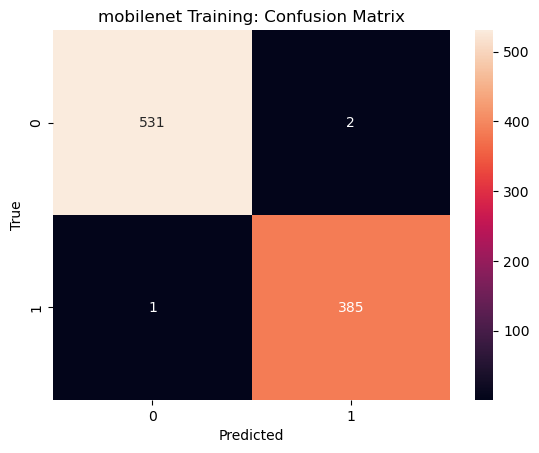

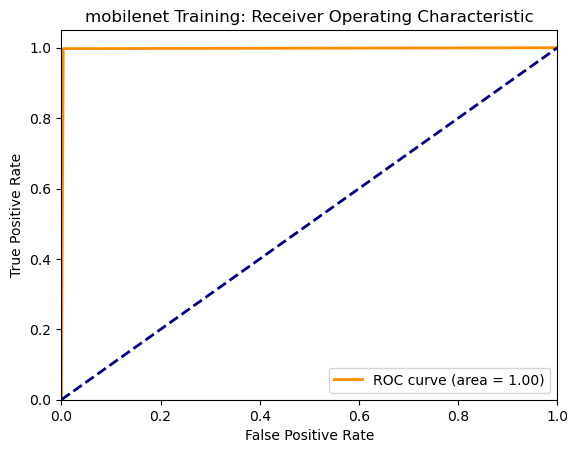

Testing data results:
Accuracy: 92.11%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92


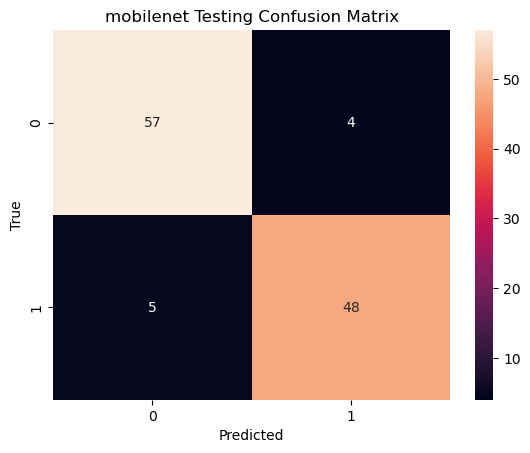

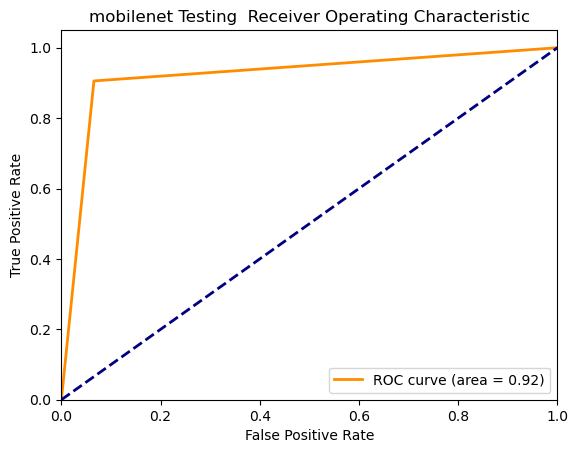

TRAINING and Testing data results:
{"{'lr': 0.001, 'momentum': 0.9, 'epochs': 70, 'weight_decay': 0.01, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 0.9967355821545157, 'train_precision': 0.9967391602387468, 'train_recall': 0.9967355821545157, 'train_f1': 0.9967361610891043, 'valid_accuracy': 0.9210526315789473, 'valid_precision': 0.9210852814418179, 'valid_recall': 0.9210526315789473, 'valid_f1': 0.9209976159911974}}


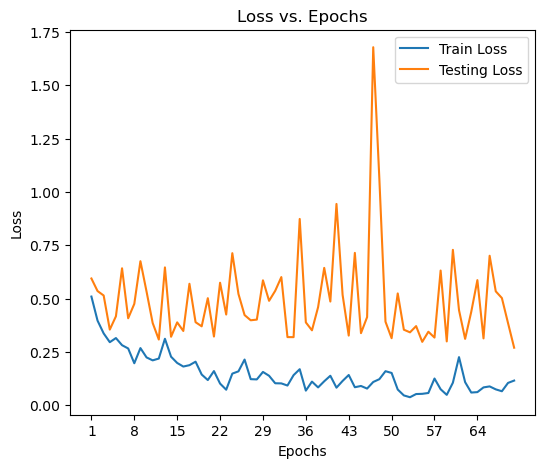

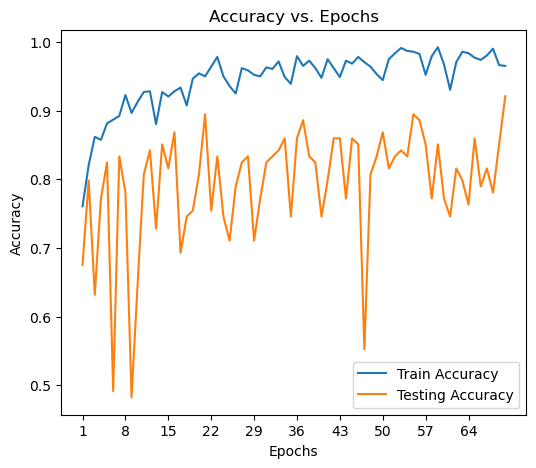

run time: 0:16:16.376864


In [85]:
# make_plots=0
# Looking at epochs for mobilenet
# use with plot as see when loss starts to level off
model_name = 'mobilenet'
param_grid = {
        'lr': [.001],
        'momentum': [.9],
        'epochs': [70],
        'weight_decay': [.01],  # Add weight_decay to the grid
        'optimizer': ['Adam'],  # Add optimizer to the grid
        'batch_size': [16]  
    }
    
#accuracy = build_model(lr=lr, momentum=momentum, weight_decay=weight_decay, batch_size=batch_size, epochs=epochs, 
#                      optimizer=optimizer_name, model_name=model_name)
accuracy=test_model_parameters(model_name, param_grid, train_dataset, test_dataset, device, valid_ds_name = 'Testing',
                               to_print=1, make_plots=1, write_csv=1)

start time:  2024_04_01_1859
mobilenet
Model number:  1  current_params:  {'lr': 0.01, 'momentum': 0.9, 'epochs': 70, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}
Epoch 1/70:
Train Loss: 0.7675, Train Accuracy: 0.6061
Testing Loss: 2.8519 Testing Accuracy: 0.5263
Finished Epoch 1
Epoch 2/70:
Train Loss: 0.6038, Train Accuracy: 0.6681
Testing Loss: 0.5761 Testing Accuracy: 0.7544
Finished Epoch 2
Epoch 3/70:
Train Loss: 0.5423, Train Accuracy: 0.7301
Testing Loss: 0.5582 Testing Accuracy: 0.7807
Finished Epoch 3
Epoch 4/70:
Train Loss: 0.5147, Train Accuracy: 0.7748
Testing Loss: 0.6364 Testing Accuracy: 0.6579
Finished Epoch 4
Epoch 5/70:
Train Loss: 0.4502, Train Accuracy: 0.8009
Testing Loss: 0.4809 Testing Accuracy: 0.7807
Finished Epoch 5
Epoch 6/70:
Train Loss: 0.4113, Train Accuracy: 0.8215
Testing Loss: 0.5790 Testing Accuracy: 0.7895
Finished Epoch 6
Epoch 7/70:
Train Loss: 0.3768, Train Accuracy: 0.8313
Testing Loss: 0.5526 Testing Accuracy: 0.8246
Finished Epoc

Epoch 68/70:
Train Loss: 0.0076, Train Accuracy: 0.9989
Testing Loss: 0.8489 Testing Accuracy: 0.8860
Finished Epoch 68
Epoch 69/70:
Train Loss: 0.0025, Train Accuracy: 1.0000
Testing Loss: 0.9376 Testing Accuracy: 0.9035
Finished Epoch 69
Epoch 70/70:
Train Loss: 0.0023, Train Accuracy: 0.9989
Testing Loss: 0.9056 Testing Accuracy: 0.8947
Finished Epoch 70
Finished Training model number:  1
TRAINING data results:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


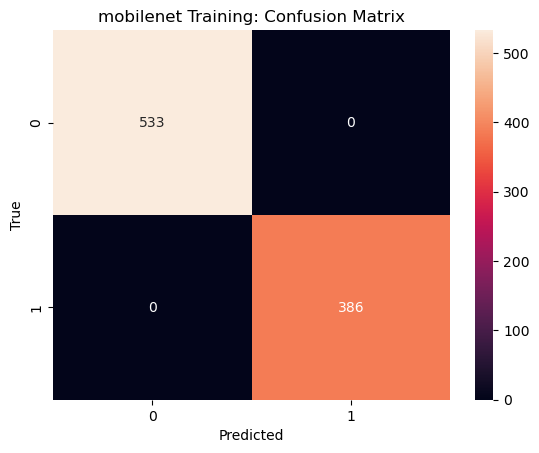

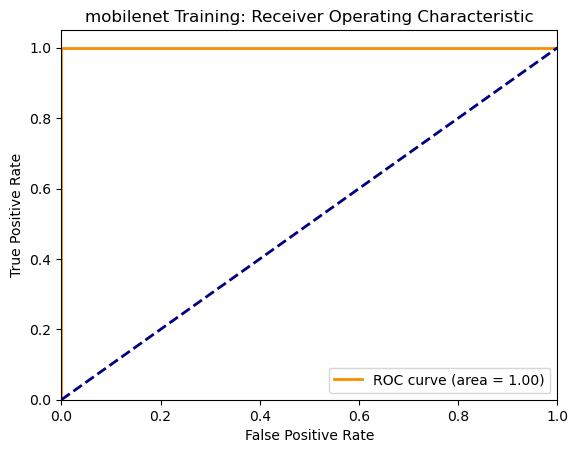

Testing data results:
Accuracy: 89.47%
Precision: 0.90
Recall: 0.89
F1 Score: 0.89


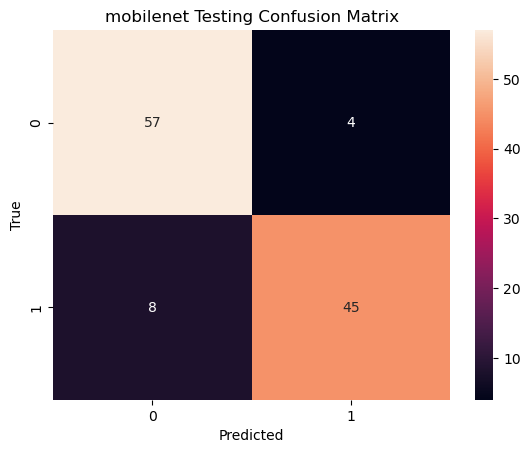

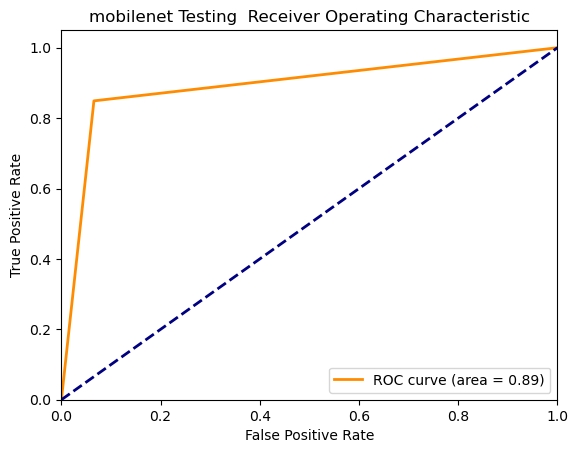

TRAINING and Testing data results:
{"{'lr': 0.01, 'momentum': 0.9, 'epochs': 70, 'weight_decay': 0.0, 'optimizer': 'Adam', 'batch_size': 16}": {'model_name': 'mobilenet', 'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'valid_accuracy': 0.8947368421052632, 'valid_precision': 0.8961910270180947, 'valid_recall': 0.8947368421052632, 'valid_f1': 0.8943437023932381}}


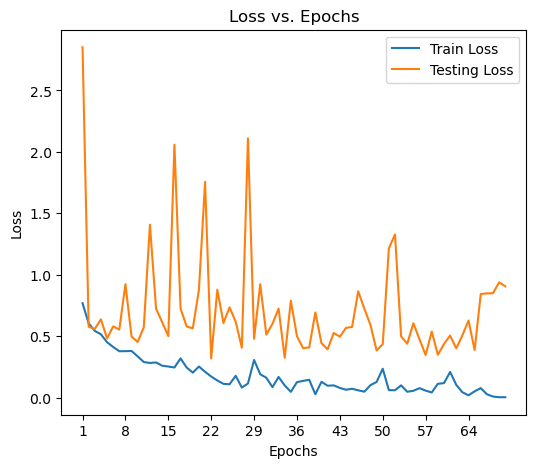

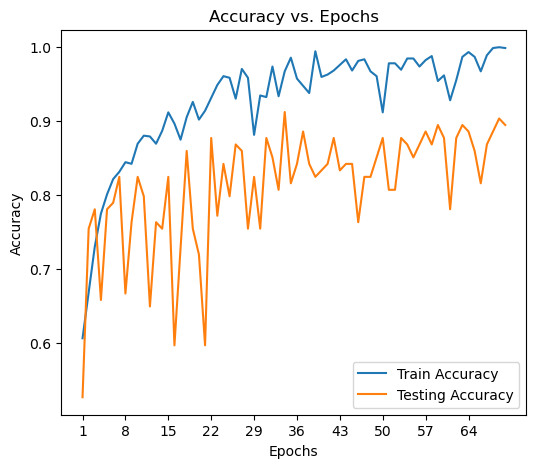

run time: 0:16:05.085881


In [86]:
# make_plots=0
# Looking at epochs for mobilenet
# use with plot as see when loss starts to level off
model_name = 'mobilenet'
param_grid = {
        'lr': [.01],
        'momentum': [.9],
        'epochs': [70],
        'weight_decay': [.0],  # Add weight_decay to the grid
        'optimizer': ['Adam'],  # Add optimizer to the grid
        'batch_size': [16]  
    }
    
#accuracy = build_model(lr=lr, momentum=momentum, weight_decay=weight_decay, batch_size=batch_size, epochs=epochs, 
#                      optimizer=optimizer_name, model_name=model_name)
accuracy=test_model_parameters(model_name, param_grid, train_dataset, test_dataset, device, valid_ds_name = 'Testing',
                               to_print=1, make_plots=1, write_csv=1)

# End of Jupyter Notebook